In [1]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [35]:
L = 4 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [36]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [37]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [38]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [39]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [40]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [41]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [42]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [43]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [44]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [45]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

#for i in range(LL+1):
#    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.1*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [46]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [47]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-0.92917693 -0.31306811 -0.1043844 ]


In [48]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [49]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(-0.00608513978886662+0.0687621491949182j)|2 2 0 1>
(0.013750677436505628-0.15538281226507367j)|2 2 0 0>
(-0.024896033564581244+0.28132546395425734j)|2 1 1 1>
(0.006648892672328394-0.07513256322428462j)|2 1 0 1>
(0.006085139788866612-0.06876214919491819j)|2 1 0 0>
(-0.024896033564581133+0.2813254639542572j)|1 1 1 2>
(0.06838605473083599-0.7727632004209706j)|1 1 1 1>
(-0.024896033564581317+0.2813254639542574j)|1 1 0 1>
(0.006085139788866681-0.06876214919491827j)|1 0 2 2>
(0.006648892672328154-0.0751325632242845j)|1 0 1 2>
(-0.02489603356458114+0.2813254639542574j)|1 0 1 1>
(0.013750677436505737-0.15538281226507378j)|0 0 2 2>
(-0.006085139788866705+0.06876214919491827j)|0 0 1 2>



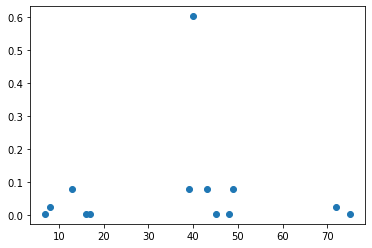

In [50]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [73]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod




def ms_hamiltonian(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

In [74]:
def func(x):
    if x>=0.9:
        return (0.9-x)
    if x<0.9:
        return 0

In [75]:
#initial state
string_0 = "1111"
#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)

psi_0[i_0] = 1.


In [91]:
import optuna
n_iter = 4000
theta = np.zeros(5*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+"+str(0), -4*np.pi, 4*np.pi)

        for j in range(1,5):
            theta[5*i+j] = trial.suggest_float("5*"+str(i)+"+"+str(j), -2*np.pi, 2*np.pi)
        
            
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var


    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-17 12:37:16,886] A new study created in memory with name: no-name-8afc1df3-ee5e-453b-a71a-5f297ecc93e0
[I 2022-05-17 12:37:17,046] Trial 0 finished with value: 3.2319949647941435 and parameters: {'5*0+0': -6.008906140125731, '7*0+1': 2.6487803663346146, '7*0+2': -0.1179449000036783, '7*0+3': 5.861328827125291, '7*0+4': 5.467196931340014, '7*0+5': 1.177660433596932, '7*0+6': 2.151827256910309, '5*1+0': 2.5814479312276255, '7*1+1': -3.1522499921355567, '7*1+2': -0.2831718173836517, '7*1+3': 0.7612126857550781, '7*1+4': 1.5596577612251785, '7*1+5': 0.7944690809323882, '7*1+6': 0.9953724667402897, '5*2+0': -6.1742738760581615, '7*2+1': 1.899689842362113, '7*2+2': 1.1835052080606685, '7*2+3': -2.4849725200291877, '7*2+4': 3.687540115443836, '7*2+5': -3.6056698552672155, '7*2+6': 2.868256461111942, '5*3+0': -5.3346923842280605, '7*3+1': 3.2411761092589657, '7*3+2': 0.9623249454234948, '7*3+3': -0.559953682835439, '7*3+4': -4.2334303299543645, '7*3+5': 1.965464254842976, '7*3+6': -

[I 2022-05-17 12:37:18,146] Trial 9 finished with value: 3.6154688295830586 and parameters: {'5*0+0': 0.6155953022995942, '7*0+1': -3.6512894639211044, '7*0+2': 0.4944894676517902, '7*0+3': 1.757321621873451, '7*0+4': 3.403015245684999, '7*0+5': 1.5144089377621708, '7*0+6': 2.0055963637009135, '5*1+0': 0.4966599964210827, '7*1+1': 1.5951987879659177, '7*1+2': -1.5471163560545125, '7*1+3': 1.4455820782018158, '7*1+4': -3.5639604470137005, '7*1+5': -2.2839749159942997, '7*1+6': -2.6718317066016133, '5*2+0': -0.5500100956859939, '7*2+1': 0.46863786957095965, '7*2+2': 2.3075428468159123, '7*2+3': 1.573949181815151, '7*2+4': 0.44232576194742884, '7*2+5': -1.8591488462417673, '7*2+6': 2.991184256698427, '5*3+0': -2.4824287772389533, '7*3+1': 0.6370102936751639, '7*3+2': 0.28077453110971584, '7*3+3': 2.868819214042863, '7*3+4': -1.6062140022302032, '7*3+5': -2.341283781400835, '7*3+6': -0.6728017351490023}. Best is trial 3 with value: 2.4386495473127194.
[I 2022-05-17 12:37:18,269] Trial 10 f

[I 2022-05-17 12:37:19,318] Trial 18 finished with value: 1.9238435825282139 and parameters: {'5*0+0': -0.6441488992759214, '7*0+1': -4.820957540174586, '7*0+2': -0.007502935556839951, '7*0+3': 1.3315620761038558, '7*0+4': 1.0226671996747678, '7*0+5': 0.2668207961979898, '7*0+6': 0.618553994203542, '5*1+0': -1.9702616262627073, '7*1+1': 5.218148159004627, '7*1+2': -0.1889969741873238, '7*1+3': 1.749162115640811, '7*1+4': 0.2887614696594538, '7*1+5': 0.8580178874021895, '7*1+6': 0.49211642149720136, '5*2+0': -1.5401195579608655, '7*2+1': -5.779324377963162, '7*2+2': -0.30306064658542237, '7*2+3': 1.5172108517382639, '7*2+4': 5.444224741601991, '7*2+5': 0.8104159829394859, '7*2+6': -2.07475726376743, '5*3+0': -0.9613734529222193, '7*3+1': -0.06320696022086925, '7*3+2': 5.151701178573489, '7*3+3': 0.040257071698924674, '7*3+4': -1.258138814755413, '7*3+5': 1.5258429315996673, '7*3+6': -1.7235998631248042}. Best is trial 18 with value: 1.9238435825282139.
[I 2022-05-17 12:37:19,447] Trial 

[I 2022-05-17 12:37:20,532] Trial 27 finished with value: 3.7740674826521214 and parameters: {'5*0+0': 3.406589805463369, '7*0+1': -4.500003662910407, '7*0+2': -5.3231888703295205, '7*0+3': 0.7237880525773979, '7*0+4': 1.1065067343911679, '7*0+5': 3.608873817276029, '7*0+6': 2.8405189529470425, '5*1+0': 0.5504163877264227, '7*1+1': 5.223513532399474, '7*1+2': -0.011452220692555026, '7*1+3': -0.1371129643101216, '7*1+4': -0.4341415223299022, '7*1+5': 5.1733460045814486, '7*1+6': 4.322894029024587, '5*2+0': 0.7634009093370804, '7*2+1': -3.844867240521257, '7*2+2': -1.5679968165589966, '7*2+3': 1.4385430571187972, '7*2+4': 3.551621337961449, '7*2+5': 2.2345077476072435, '7*2+6': 0.6918153048548834, '5*3+0': -0.48216628373652426, '7*3+1': -0.6871541943061845, '7*3+2': 0.6381619122533635, '7*3+3': 0.13150810149580794, '7*3+4': 0.34593110634056723, '7*3+5': 0.5302117297702442, '7*3+6': 4.172995138340213}. Best is trial 18 with value: 1.9238435825282139.
[I 2022-05-17 12:37:20,647] Trial 28 f

[I 2022-05-17 12:37:21,922] Trial 36 finished with value: 3.489439996136335 and parameters: {'5*0+0': -1.634200953399385, '7*0+1': -4.443377307483205, '7*0+2': 0.676490134738676, '7*0+3': 0.9196354084636327, '7*0+4': 2.349124442476277, '7*0+5': 1.3124337467650784, '7*0+6': 0.09510807072022376, '5*1+0': 2.4128107758370616, '7*1+1': 2.833227887870902, '7*1+2': -1.5133144517963824, '7*1+3': 3.944569689749261, '7*1+4': 2.974515662606261, '7*1+5': 4.831256472051862, '7*1+6': 2.9250462982021777, '5*2+0': -1.5017302007468634, '7*2+1': -3.25215700247521, '7*2+2': 0.07621558107390464, '7*2+3': 2.717104796214902, '7*2+4': 2.422694562406426, '7*2+5': 4.014884496793674, '7*2+6': -3.3968950798632127, '5*3+0': -0.03284344728365862, '7*3+1': 0.09732682855127495, '7*3+2': 0.0026692085277519872, '7*3+3': 1.246786777666725, '7*3+4': -2.3723487002859245, '7*3+5': 3.3399170600705737, '7*3+6': -1.6925972681616979}. Best is trial 18 with value: 1.9238435825282139.
[I 2022-05-17 12:37:22,086] Trial 37 finish

[I 2022-05-17 12:37:23,099] Trial 45 finished with value: 3.23450716683743 and parameters: {'5*0+0': 1.3736744115671229, '7*0+1': -2.7922470158463257, '7*0+2': 2.268426629606097, '7*0+3': 5.126746237778011, '7*0+4': 3.3183855453076734, '7*0+5': 0.9088680701489342, '7*0+6': 2.6308196730672044, '5*1+0': -3.855560800573627, '7*1+1': 6.042081686547923, '7*1+2': -1.516103226341857, '7*1+3': -4.594071581507943, '7*1+4': 1.1283851694056877, '7*1+5': -1.1530649830398734, '7*1+6': 3.4693602179371137, '5*2+0': 1.7105051432568215, '7*2+1': -1.9726160187509083, '7*2+2': 1.8909430715146425, '7*2+3': -1.0179803082576584, '7*2+4': 0.12687222903042805, '7*2+5': 1.812486369525176, '7*2+6': -0.24460768961516588, '5*3+0': -1.8967257640570483, '7*3+1': -2.0645595885357424, '7*3+2': 2.6882000608967807, '7*3+3': 0.45974740048342133, '7*3+4': 1.159601247569583, '7*3+5': 1.5940735975627915, '7*3+6': -4.114670650963815}. Best is trial 38 with value: 1.8773866279300602.
[I 2022-05-17 12:37:23,216] Trial 46 fini

[I 2022-05-17 12:37:24,108] Trial 54 finished with value: 2.3447190046043707 and parameters: {'5*0+0': -0.4192317385443125, '7*0+1': -5.0120220865351, '7*0+2': 0.7897240751410161, '7*0+3': 0.5743611964773976, '7*0+4': 1.4908378602847447, '7*0+5': -2.4037423299615917, '7*0+6': 0.9104762778092961, '5*1+0': -0.02827604615920487, '7*1+1': 3.5319395973266956, '7*1+2': -1.8756191237918434, '7*1+3': -3.0389710963900005, '7*1+4': 1.106805838275823, '7*1+5': -3.189883338255246, '7*1+6': -1.52592131090741, '5*2+0': -1.0811587103345137, '7*2+1': 1.1313857628346948, '7*2+2': 3.7978896072312645, '7*2+3': 2.442252454231708, '7*2+4': -0.4687848875833911, '7*2+5': 0.7004049389607974, '7*2+6': -1.0383163513412974, '5*3+0': -3.477069915623149, '7*3+1': 0.9617293424161741, '7*3+2': 0.284197888478662, '7*3+3': -2.6995383818451373, '7*3+4': 0.7108049619199996, '7*3+5': -0.48699501673997336, '7*3+6': 0.22824753474448212}. Best is trial 38 with value: 1.8773866279300602.
[I 2022-05-17 12:37:24,214] Trial 55 

[I 2022-05-17 12:37:25,340] Trial 63 finished with value: 2.61456276520837 and parameters: {'5*0+0': -1.5413883784686258, '7*0+1': -2.600333375702815, '7*0+2': 2.9129961556975097, '7*0+3': 0.6580033007841459, '7*0+4': -2.168520422020158, '7*0+5': -0.7152267078688656, '7*0+6': 4.046422220610057, '5*1+0': -0.15371697558304054, '7*1+1': 2.8311003645753314, '7*1+2': 2.4586484036710274, '7*1+3': -0.2987517739090261, '7*1+4': 2.0162850763062083, '7*1+5': -4.938522806056911, '7*1+6': -1.419406798327592, '5*2+0': 0.8777177071061233, '7*2+1': -0.7080864348512496, '7*2+2': 1.1238680595329789, '7*2+3': 0.5256491295612407, '7*2+4': 2.7543448326351823, '7*2+5': -0.35026688363725655, '7*2+6': -0.7573851855051156, '5*3+0': -3.499548556029696, '7*3+1': -1.506329563753832, '7*3+2': 3.570073302281039, '7*3+3': -0.6212057231173934, '7*3+4': 2.7377029189780635, '7*3+5': -0.9749507532378491, '7*3+6': -2.690053559474801}. Best is trial 38 with value: 1.8773866279300602.
[I 2022-05-17 12:37:25,478] Trial 64 

[I 2022-05-17 12:37:26,362] Trial 72 finished with value: 3.399786822421348 and parameters: {'5*0+0': -0.7879779484652519, '7*0+1': 2.5072665810312595, '7*0+2': 0.2310096122033651, '7*0+3': 2.1036541986972646, '7*0+4': 0.18099581945745058, '7*0+5': 0.12002254300001769, '7*0+6': 2.942095101401827, '5*1+0': -2.5258205021197053, '7*1+1': 1.442923765340932, '7*1+2': 1.4379336939867229, '7*1+3': -0.16145881232867793, '7*1+4': -1.4966042899608551, '7*1+5': -5.020499145266087, '7*1+6': -1.442453336581279, '5*2+0': 0.11954142617411978, '7*2+1': 2.4547254869771242, '7*2+2': -2.7963777274390953, '7*2+3': 0.3971002106408805, '7*2+4': 2.6572628671826144, '7*2+5': 1.4595629829501529, '7*2+6': -2.254052350427754, '5*3+0': -2.0327728370598597, '7*3+1': -0.7013496691793215, '7*3+2': -0.477265958290253, '7*3+3': 2.4872573896845807, '7*3+4': 1.6478021743398337, '7*3+5': -3.3699582586124235, '7*3+6': -0.9122484516370198}. Best is trial 68 with value: 1.7580142823280038.
[I 2022-05-17 12:37:26,470] Trial 

[I 2022-05-17 12:37:27,398] Trial 81 finished with value: 3.5824248671108037 and parameters: {'5*0+0': -0.21303682353231718, '7*0+1': -2.6309231440954597, '7*0+2': -1.6904418820368154, '7*0+3': 1.9780458609580636, '7*0+4': -3.285033225205491, '7*0+5': 2.7065956353966207, '7*0+6': 1.195552802589754, '5*1+0': -2.8290941409663852, '7*1+1': 2.450502072630602, '7*1+2': 2.3566387537069278, '7*1+3': -2.129728146819391, '7*1+4': -0.27723237118353905, '7*1+5': -2.322122815877808, '7*1+6': 0.7019897525844732, '5*2+0': 0.2940874310821606, '7*2+1': 1.1232870334059872, '7*2+2': -1.8822898662474388, '7*2+3': 4.106227724148067, '7*2+4': 3.6201668547278367, '7*2+5': -1.903411180938597, '7*2+6': 2.5885549636368204, '5*3+0': -5.087778725228363, '7*3+1': -1.1584526604139778, '7*3+2': 3.20732379752347, '7*3+3': -1.9513196712332395, '7*3+4': -0.8780696680071586, '7*3+5': 1.4512198413150295, '7*3+6': -3.260154843536081}. Best is trial 68 with value: 1.7580142823280038.
[I 2022-05-17 12:37:27,509] Trial 82 f

[I 2022-05-17 12:37:28,383] Trial 90 finished with value: 2.8815728706062993 and parameters: {'5*0+0': 1.241937598205412, '7*0+1': -2.2026212096314097, '7*0+2': 1.7785482231516998, '7*0+3': 2.981155680736352, '7*0+4': -1.7121824911307146, '7*0+5': 2.3251197892013455, '7*0+6': 1.4596248776485832, '5*1+0': -1.8522927956421933, '7*1+1': 2.0519554710254377, '7*1+2': 0.8126844729776215, '7*1+3': 0.6535643061116289, '7*1+4': -1.9889438966060062, '7*1+5': -3.084036641060627, '7*1+6': -0.6046469980870747, '5*2+0': 4.617625514461394, '7*2+1': 1.3828181440042884, '7*2+2': 2.6804700557485486, '7*2+3': 2.8767130553111135, '7*2+4': 2.808754646834143, '7*2+5': 1.5063421579509548, '7*2+6': -3.916846489599227, '5*3+0': 0.24070284023625588, '7*3+1': -0.9783652225970674, '7*3+2': 4.0988831491584605, '7*3+3': -0.48457949760600366, '7*3+4': 0.09816193554597594, '7*3+5': 0.40730949655709486, '7*3+6': -2.0305888691595504}. Best is trial 68 with value: 1.7580142823280038.
[I 2022-05-17 12:37:28,493] Trial 91

[I 2022-05-17 12:37:29,378] Trial 99 finished with value: 3.230648970328918 and parameters: {'5*0+0': -2.3555734640847645, '7*0+1': -1.4776957881332569, '7*0+2': -0.047032774147070563, '7*0+3': 3.6569652307503593, '7*0+4': -0.018583928886563017, '7*0+5': 2.9425530093109313, '7*0+6': 3.491406257362184, '5*1+0': -2.447794392359819, '7*1+1': 3.182800609546008, '7*1+2': 3.107411053691366, '7*1+3': -0.221056275055591, '7*1+4': 1.2586654864664015, '7*1+5': 0.3977654434434057, '7*1+6': -1.9335737294245772, '5*2+0': 2.1359772188753103, '7*2+1': 1.6470668912396311, '7*2+2': 1.2028281036773267, '7*2+3': 0.8466716584950919, '7*2+4': 1.8021039974257245, '7*2+5': -0.6872633222064293, '7*2+6': 0.933523279396773, '5*3+0': 0.705823530020633, '7*3+1': -1.3304282194252437, '7*3+2': 5.826077225921816, '7*3+3': -2.3540854188126525, '7*3+4': -1.0657510161270207, '7*3+5': 1.0649126018871806, '7*3+6': -0.29698815785142474}. Best is trial 68 with value: 1.7580142823280038.
[I 2022-05-17 12:37:29,488] Trial 10

[I 2022-05-17 12:37:30,358] Trial 108 finished with value: 3.6136903524413544 and parameters: {'5*0+0': 0.7117153278391268, '7*0+1': -0.5019176240020229, '7*0+2': -1.2050510750316945, '7*0+3': 3.231748513203853, '7*0+4': -1.7827891094228994, '7*0+5': 2.5094087062652117, '7*0+6': 2.3778532924911358, '5*1+0': -0.6649696528078812, '7*1+1': 1.6812646381104734, '7*1+2': 3.3047123015014863, '7*1+3': -0.31317988169434263, '7*1+4': -1.6510164117568769, '7*1+5': -0.5782645349303364, '7*1+6': -2.63139578062163, '5*2+0': 1.9281157744895245, '7*2+1': -0.9557938771939505, '7*2+2': 0.8103254427241371, '7*2+3': 0.32094279124510483, '7*2+4': 1.0762457712180227, '7*2+5': -0.5889230220119457, '7*2+6': 2.6160967301629796, '5*3+0': -2.19761042514505, '7*3+1': -0.3073014963510762, '7*3+2': 2.0193911131562983, '7*3+3': -0.8826264192308708, '7*3+4': -2.4596363933539447, '7*3+5': 0.0308248367127133, '7*3+6': -0.6471180199139339}. Best is trial 105 with value: 1.6831714545825036.
[I 2022-05-17 12:37:30,468] Tr

[I 2022-05-17 12:37:31,393] Trial 117 finished with value: 3.7444511482801817 and parameters: {'5*0+0': -0.2807976727983754, '7*0+1': -0.13582159003538785, '7*0+2': -2.6039829639527396, '7*0+3': 0.2738485300299518, '7*0+4': -0.825271386405346, '7*0+5': 2.5975612340550365, '7*0+6': 5.12377481748566, '5*1+0': -2.614030576751936, '7*1+1': 3.3618426423380052, '7*1+2': 1.7620168281870578, '7*1+3': -2.8838428044063904, '7*1+4': -1.7866412018493985, '7*1+5': 0.8325602135052554, '7*1+6': 0.5189682735136716, '5*2+0': 0.1301991944100681, '7*2+1': 3.7435776854774856, '7*2+2': 0.62773297349184, '7*2+3': 2.5250519117402628, '7*2+4': 0.5137860371329314, '7*2+5': -3.967692993156725, '7*2+6': 0.8218699932348785, '5*3+0': -1.1703281785394057, '7*3+1': -2.2420460598952534, '7*3+2': 0.6821029198003878, '7*3+3': -2.435608310905069, '7*3+4': -1.2366600441500553, '7*3+5': -0.1042978675954398, '7*3+6': -3.278752457009136}. Best is trial 105 with value: 1.6831714545825036.
[I 2022-05-17 12:37:31,501] Trial 11

[I 2022-05-17 12:37:32,419] Trial 126 finished with value: 4.043919008338282 and parameters: {'5*0+0': -0.08496193623972537, '7*0+1': -0.6050522751647562, '7*0+2': 0.7877263810547301, '7*0+3': 2.9644295189303747, '7*0+4': -2.606738426833014, '7*0+5': 4.109444878389066, '7*0+6': 2.908878454577689, '5*1+0': -2.1820334288968453, '7*1+1': 3.531724618794805, '7*1+2': 0.6272997249642928, '7*1+3': -1.6792055383976365, '7*1+4': 0.22021110913076858, '7*1+5': 1.8345330709522556, '7*1+6': -2.3397434649635795, '5*2+0': 4.444055114254744, '7*2+1': 2.228202838955433, '7*2+2': 4.681195310773139, '7*2+3': 0.6547972387722845, '7*2+4': 0.47701242516883124, '7*2+5': -0.23420315619274978, '7*2+6': -2.800635278865412, '5*3+0': -3.0046891324177674, '7*3+1': 1.1900228197355354, '7*3+2': 2.2477670104030887, '7*3+3': -0.8108184024244502, '7*3+4': -2.5759013925923515, '7*3+5': -2.5979912418232414, '7*3+6': 0.5048177617992742}. Best is trial 105 with value: 1.6831714545825036.
[I 2022-05-17 12:37:32,529] Trial 1

[I 2022-05-17 12:37:33,403] Trial 135 finished with value: 3.418402213998446 and parameters: {'5*0+0': -0.03805948426308259, '7*0+1': 0.016466470297457736, '7*0+2': -0.34662441412440564, '7*0+3': -0.8555515783306138, '7*0+4': -2.9927689462035993, '7*0+5': -1.9390173622707154, '7*0+6': 2.2407658944399773, '5*1+0': -0.7433990456091109, '7*1+1': 2.917690793057857, '7*1+2': -0.37214364832010416, '7*1+3': 0.7817548518599826, '7*1+4': 1.307709875440636, '7*1+5': 3.8622870003444967, '7*1+6': -1.5126976574224604, '5*2+0': 0.4315868981139994, '7*2+1': -2.1107427906540432, '7*2+2': 1.895688656418454, '7*2+3': 0.07494560546860529, '7*2+4': 1.16283484405674, '7*2+5': 2.4223166296877148, '7*2+6': -0.0063343463543870104, '5*3+0': -2.0344790691680132, '7*3+1': 0.16716734151741175, '7*3+2': 1.6970873159248412, '7*3+3': 0.05815795432444548, '7*3+4': -3.144239707440925, '7*3+5': -3.045751753196234, '7*3+6': 3.7083552020058583}. Best is trial 105 with value: 1.6831714545825036.
[I 2022-05-17 12:37:33,510

[I 2022-05-17 12:37:34,402] Trial 144 finished with value: 3.267022080587782 and parameters: {'5*0+0': -3.200400604748509, '7*0+1': -1.4835867529184075, '7*0+2': 0.27005523665333375, '7*0+3': -2.9553453332520294, '7*0+4': -2.5590166820255895, '7*0+5': 0.6695445401986142, '7*0+6': 5.039545417106519, '5*1+0': 0.4077049965404949, '7*1+1': 5.0087084160672966, '7*1+2': 3.5639081103721786, '7*1+3': 3.67225540268398, '7*1+4': 0.751520405414553, '7*1+5': 1.1068722821071528, '7*1+6': -4.098675697252892, '5*2+0': 3.442994516225821, '7*2+1': -3.494288705452195, '7*2+2': 2.665505335960942, '7*2+3': 1.7707599601392303, '7*2+4': 3.562586614727031, '7*2+5': -0.057720721861332924, '7*2+6': -0.6745792340070567, '5*3+0': 1.772231712319552, '7*3+1': 1.197254338677027, '7*3+2': 3.4032306986040606, '7*3+3': -0.29156771870715237, '7*3+4': -0.4238990765864974, '7*3+5': 0.08113837333828103, '7*3+6': 0.3719571002172206}. Best is trial 105 with value: 1.6831714545825036.
[I 2022-05-17 12:37:34,514] Trial 145 fi

[I 2022-05-17 12:37:35,384] Trial 153 finished with value: 5.151839789791694 and parameters: {'5*0+0': -0.6429620208964271, '7*0+1': -1.0412009158163917, '7*0+2': -0.49571107511754176, '7*0+3': -3.84774825766369, '7*0+4': -1.4945089810263266, '7*0+5': 0.334709222673357, '7*0+6': 3.1760924896355656, '5*1+0': -1.1680128050083274, '7*1+1': 3.115085711029443, '7*1+2': 3.6897839775337458, '7*1+3': 0.5628410230677315, '7*1+4': -0.041999394689502534, '7*1+5': 0.7552735835440161, '7*1+6': -0.9120001567366418, '5*2+0': 1.0520393927736202, '7*2+1': 1.4902258676161542, '7*2+2': 0.42647719741552814, '7*2+3': 2.349358458150011, '7*2+4': 0.30930811915836154, '7*2+5': 2.703618378261109, '7*2+6': -1.8129985249694767, '5*3+0': 2.2309704835094584, '7*3+1': 1.7968109370993695, '7*3+2': 5.199820655424263, '7*3+3': -3.073351514458544, '7*3+4': -0.43157095416301994, '7*3+5': -0.46919320956147903, '7*3+6': 1.9698865377549766}. Best is trial 105 with value: 1.6831714545825036.
[I 2022-05-17 12:37:35,492] Tria

[I 2022-05-17 12:37:36,369] Trial 162 finished with value: 3.694016244193647 and parameters: {'5*0+0': -2.238574076676126, '7*0+1': -2.546842233571436, '7*0+2': -3.2194360637795643, '7*0+3': 1.0234047127112724, '7*0+4': -0.5634102656755431, '7*0+5': -2.1009794396982917, '7*0+6': 3.1820850194161583, '5*1+0': -0.35903567601715625, '7*1+1': 1.6159670523611873, '7*1+2': 1.0824262589794242, '7*1+3': -0.27980597721463996, '7*1+4': -0.04025077675447819, '7*1+5': 2.6420853012533816, '7*1+6': -2.8193687538166485, '5*2+0': 1.5875286564705344, '7*2+1': -2.7287856502014227, '7*2+2': 3.2357293346767912, '7*2+3': 2.5662967283810114, '7*2+4': 1.4288866844474817, '7*2+5': 1.6314977547718583, '7*2+6': 0.8972328003775993, '5*3+0': -1.0413559357980229, '7*3+1': 0.1784470982643418, '7*3+2': 3.660157011128019, '7*3+3': -0.007449947606663843, '7*3+4': -0.9443367187271656, '7*3+5': 1.4462511397544133, '7*3+6': -0.598644641149785}. Best is trial 158 with value: 1.6324200453707354.
[I 2022-05-17 12:37:36,478] 

[I 2022-05-17 12:37:37,430] Trial 171 finished with value: 2.8670294158793754 and parameters: {'5*0+0': -2.900242478981468, '7*0+1': -3.2876801200821646, '7*0+2': -0.8231358375881221, '7*0+3': 1.4591761830664307, '7*0+4': -3.180752221250882, '7*0+5': -0.30972558991793164, '7*0+6': 3.3893905569449356, '5*1+0': 0.17674639853335877, '7*1+1': 2.6639271433907163, '7*1+2': 0.7487890145671426, '7*1+3': 0.5965768386743908, '7*1+4': -3.1055157552458663, '7*1+5': 0.556093088667072, '7*1+6': -1.7978299199127705, '5*2+0': 1.667005665691531, '7*2+1': 1.035775324181558, '7*2+2': 6.119580790396063, '7*2+3': 0.3843107800441753, '7*2+4': 2.9052491347026113, '7*2+5': 3.1028011151325634, '7*2+6': -0.9136945186563761, '5*3+0': -1.510781000676885, '7*3+1': -1.8038764827263938, '7*3+2': 4.659085758934159, '7*3+3': -4.08818122990375, '7*3+4': -1.1229377580376319, '7*3+5': -1.2701098611590123, '7*3+6': 3.608952003295782}. Best is trial 158 with value: 1.6324200453707354.
[I 2022-05-17 12:37:37,542] Trial 172 

[I 2022-05-17 12:37:38,442] Trial 180 finished with value: 4.7744567919268635 and parameters: {'5*0+0': -2.5135459992824667, '7*0+1': -2.1299783109635477, '7*0+2': -1.7213915137808573, '7*0+3': 1.7602746222619137, '7*0+4': -2.574266621749028, '7*0+5': 0.07062708955820685, '7*0+6': 3.4227419238436667, '5*1+0': 1.6791609149492321, '7*1+1': 2.3566186300622975, '7*1+2': 2.4260779992102592, '7*1+3': 1.389352109295947, '7*1+4': 0.9449714138692368, '7*1+5': 1.896930460878155, '7*1+6': -3.0043810570762606, '5*2+0': 2.7549840992030594, '7*2+1': -0.27608751703797085, '7*2+2': 1.012076552060406, '7*2+3': 0.45732244854291304, '7*2+4': -0.10218306400621402, '7*2+5': 1.715195619909023, '7*2+6': -0.5469316821160857, '5*3+0': -0.8116279765396507, '7*3+1': 2.0432924658527427, '7*3+2': 5.544243179104263, '7*3+3': 1.5348489305811785, '7*3+4': 1.8699351905578752, '7*3+5': 1.4028431031332766, '7*3+6': 2.2576193966200546}. Best is trial 158 with value: 1.6324200453707354.
[I 2022-05-17 12:37:38,555] Trial 1

[I 2022-05-17 12:37:39,442] Trial 189 finished with value: 2.643407696201259 and parameters: {'5*0+0': -0.3584865822298253, '7*0+1': 0.47239971667667513, '7*0+2': -2.307973606402952, '7*0+3': 2.924754299252215, '7*0+4': -2.174607349402423, '7*0+5': -0.20572977394302017, '7*0+6': 5.563584405320142, '5*1+0': 0.6175811570286691, '7*1+1': 2.4123138832046713, '7*1+2': 3.7517737649857006, '7*1+3': 1.7317887328136272, '7*1+4': -0.966087507421497, '7*1+5': -0.8367245030479973, '7*1+6': -1.924450157565061, '5*2+0': 1.7330932959085499, '7*2+1': -0.6291027191153453, '7*2+2': 2.7271364195476844, '7*2+3': 1.9939103855076512, '7*2+4': 0.37040431931696194, '7*2+5': 2.737041808479409, '7*2+6': 1.6760772639498425, '5*3+0': -0.8648550012882653, '7*3+1': 2.779694512218497, '7*3+2': 5.182436667138283, '7*3+3': -0.23408308202324468, '7*3+4': 3.2476113325225384, '7*3+5': -2.193770469271101, '7*3+6': -0.20512736203785398}. Best is trial 158 with value: 1.6324200453707354.
[I 2022-05-17 12:37:39,547] Trial 19

[I 2022-05-17 12:37:40,430] Trial 198 finished with value: 3.7137337143416067 and parameters: {'5*0+0': -4.421482627023177, '7*0+1': -1.5086046996035989, '7*0+2': -0.15697986469666958, '7*0+3': 2.359962122291096, '7*0+4': -0.57059028610196, '7*0+5': -2.422951536592551, '7*0+6': 5.407925949370641, '5*1+0': -0.6696167265934697, '7*1+1': 0.7128465509700659, '7*1+2': 2.2779808588743147, '7*1+3': -1.0785662761695085, '7*1+4': -2.1462350686835743, '7*1+5': -1.2232343712013072, '7*1+6': -2.6858105365965264, '5*2+0': -0.977874781325528, '7*2+1': 1.86911067363397, '7*2+2': 2.3911514720516838, '7*2+3': 1.6285649785456568, '7*2+4': -0.7059078928333979, '7*2+5': -0.43766063140484546, '7*2+6': -1.7566931239796446, '5*3+0': -1.2171539629453167, '7*3+1': -0.0035711332035991417, '7*3+2': 5.837189074584223, '7*3+3': -1.8409587852939158, '7*3+4': -0.3694774792104911, '7*3+5': -0.16260419671025494, '7*3+6': 1.7458864495994524}. Best is trial 158 with value: 1.6324200453707354.
[I 2022-05-17 12:37:40,538]

[I 2022-05-17 12:37:41,426] Trial 207 finished with value: 1.1915117165364646 and parameters: {'5*0+0': -3.414714270332458, '7*0+1': -2.7964419561902694, '7*0+2': -2.9449531924653805, '7*0+3': 2.1769087979809694, '7*0+4': -2.004052305917249, '7*0+5': -2.341806261338597, '7*0+6': 5.510117246940876, '5*1+0': -0.568047051330441, '7*1+1': 3.763993246271795, '7*1+2': 4.030850581627457, '7*1+3': -0.49536306889574827, '7*1+4': -2.5305777157787652, '7*1+5': 0.38533172774221075, '7*1+6': -4.1393555193105955, '5*2+0': 0.694739448396535, '7*2+1': 2.2164289394217738, '7*2+2': 0.7104772834084576, '7*2+3': 0.7326644146061817, '7*2+4': -1.780127816313116, '7*2+5': 3.3099993280840527, '7*2+6': 2.0055919989519135, '5*3+0': 0.31540634332658457, '7*3+1': 1.3301822011063185, '7*3+2': 4.832873294844725, '7*3+3': -3.74717241370658, '7*3+4': 2.779771132980976, '7*3+5': -1.7027565887276035, '7*3+6': 3.1122513744120432}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:41,536] Trial 208 fi

[I 2022-05-17 12:37:42,439] Trial 216 finished with value: 3.927610101889928 and parameters: {'5*0+0': -2.7121811869659864, '7*0+1': -3.6425032129338626, '7*0+2': -0.6354792678737884, '7*0+3': 2.12637638075825, '7*0+4': -5.780101080286027, '7*0+5': -3.3869754382740114, '7*0+6': 4.103798644725434, '5*1+0': 3.117923870069088, '7*1+1': 2.0366778918960655, '7*1+2': 3.171192116209271, '7*1+3': 1.4358440829092924, '7*1+4': -0.9538492525100778, '7*1+5': 1.9755741320031992, '7*1+6': -2.98438690971175, '5*2+0': 1.309044342047957, '7*2+1': 1.349752279167865, '7*2+2': 0.26771143241782847, '7*2+3': 0.5702807605091875, '7*2+4': 1.2217919857366588, '7*2+5': 0.9037508918224317, '7*2+6': 1.3024970015164778, '5*3+0': -0.4541707056142693, '7*3+1': 3.526816539066772, '7*3+2': 4.349373930025911, '7*3+3': -3.758111266184568, '7*3+4': 1.9146130010570062, '7*3+5': 0.8017889867084699, '7*3+6': 3.1766402971206262}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:42,555] Trial 217 finished

[I 2022-05-17 12:37:43,455] Trial 225 finished with value: 4.210327186573499 and parameters: {'5*0+0': 0.09647212357493373, '7*0+1': -1.7109417384584937, '7*0+2': -0.38548558990049986, '7*0+3': 3.1422198025574968, '7*0+4': -3.200673660627396, '7*0+5': -2.712049795777415, '7*0+6': 4.435047910509795, '5*1+0': 3.428138660110115, '7*1+1': 1.5752949964522125, '7*1+2': 1.3327637374675552, '7*1+3': -0.27009490669030717, '7*1+4': 0.3395639345635484, '7*1+5': 1.3681781405117688, '7*1+6': -3.4015642384206544, '5*2+0': -1.1714842465430788, '7*2+1': 3.250497755616171, '7*2+2': 2.0248360580369957, '7*2+3': 0.08479744757617813, '7*2+4': -1.391629497455884, '7*2+5': 1.1307642236964905, '7*2+6': 0.9640262433645461, '5*3+0': 0.5485290095247146, '7*3+1': 0.3710608673069412, '7*3+2': 5.627850278324765, '7*3+3': -1.950617896018175, '7*3+4': 0.9225027167504689, '7*3+5': -1.8306483418570754, '7*3+6': 0.14323195625964247}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:43,565] Trial 22

[I 2022-05-17 12:37:44,492] Trial 234 finished with value: 2.7227442626007896 and parameters: {'5*0+0': -2.963671347854105, '7*0+1': -2.040645806248005, '7*0+2': -3.56619745640721, '7*0+3': 0.9014572187651022, '7*0+4': 1.8445422724045157, '7*0+5': -2.0555692757057207, '7*0+6': 3.4975236984781084, '5*1+0': -0.7404956818768547, '7*1+1': 3.269943528473627, '7*1+2': 3.321263969989123, '7*1+3': 0.7871661413105475, '7*1+4': -2.802756746319324, '7*1+5': 0.05960193615575282, '7*1+6': -3.4929175128524603, '5*2+0': -2.016653651559144, '7*2+1': 1.76122821882787, '7*2+2': 0.1675917065077157, '7*2+3': 0.3566582874128016, '7*2+4': -3.1099133846937446, '7*2+5': 1.8162292288101425, '7*2+6': -0.04331187435366657, '5*3+0': -0.340092623109293, '7*3+1': 1.3617694844329893, '7*3+2': 5.051142273001267, '7*3+3': -4.154743039957111, '7*3+4': 0.8734567025648894, '7*3+5': -1.1990237489595983, '7*3+6': 3.477222489514501}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:44,607] Trial 235 fin

[I 2022-05-17 12:37:45,493] Trial 243 finished with value: 4.5877669586362 and parameters: {'5*0+0': -3.733428626658581, '7*0+1': -0.04855132454955324, '7*0+2': -1.5206926424949723, '7*0+3': -0.30615405422539177, '7*0+4': -1.3190422632919765, '7*0+5': -2.9840034030687335, '7*0+6': 5.231869240389721, '5*1+0': -0.4225809677974807, '7*1+1': 3.2408388773827452, '7*1+2': 2.0109206052813846, '7*1+3': -1.2721414903931199, '7*1+4': 0.4483588022576621, '7*1+5': 1.2373824027167823, '7*1+6': -5.0717937689848505, '5*2+0': -0.24884220293105586, '7*2+1': 2.2477109988767885, '7*2+2': -0.04673165060755813, '7*2+3': 1.5784762170606328, '7*2+4': -2.7787990846640804, '7*2+5': 5.134413485321574, '7*2+6': 0.9785374487483984, '5*3+0': -0.3715738304774372, '7*3+1': 1.7726968174853512, '7*3+2': 3.5946691967261577, '7*3+3': -1.9120218035530252, '7*3+4': 2.052549127579386, '7*3+5': -2.295142544467125, '7*3+6': 0.5006312965953996}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:45,602] Tri

[I 2022-05-17 12:37:46,513] Trial 252 finished with value: 3.8706285589579537 and parameters: {'5*0+0': -3.2807301442571215, '7*0+1': 1.0124130745593378, '7*0+2': -2.4721687895223408, '7*0+3': 1.293350636770444, '7*0+4': -3.2431802129710805, '7*0+5': -3.130563701334188, '7*0+6': 4.723065641698001, '5*1+0': 0.817918107681556, '7*1+1': 1.3390913102738367, '7*1+2': 3.3900919237981126, '7*1+3': 1.5986458172619975, '7*1+4': -1.2305175586142845, '7*1+5': 0.6901685559003464, '7*1+6': -4.7012242162924665, '5*2+0': 1.8608953911251023, '7*2+1': -0.5127198760348981, '7*2+2': 0.9084613439907395, '7*2+3': 0.9407610861411475, '7*2+4': 0.052934124645498404, '7*2+5': 1.6242944051975146, '7*2+6': -1.1860038057523736, '5*3+0': -0.4304771039969362, '7*3+1': 0.34992269371393525, '7*3+2': 5.153801392276368, '7*3+3': -2.754296768304402, '7*3+4': 1.66930408672397, '7*3+5': -3.464477591852676, '7*3+6': 3.0213939114646644}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:46,626] Trial 253

[I 2022-05-17 12:37:47,517] Trial 261 finished with value: 2.542980283832894 and parameters: {'5*0+0': -2.382079762286576, '7*0+1': 0.41912776047131484, '7*0+2': -3.563256042198401, '7*0+3': 1.216044807020775, '7*0+4': -4.502467470498596, '7*0+5': -4.041248208777921, '7*0+6': 3.726404898375768, '5*1+0': -0.5261407203075423, '7*1+1': 0.3608944573830525, '7*1+2': 6.009935840152813, '7*1+3': -0.014347083666036431, '7*1+4': -0.6184222318232262, '7*1+5': -1.4010146642773296, '7*1+6': -5.004167111681497, '5*2+0': -3.1224230237375727, '7*2+1': -1.0341856380851782, '7*2+2': 0.6458436765901403, '7*2+3': 1.6952446654010658, '7*2+4': -0.9752180270029431, '7*2+5': 0.6450501052090476, '7*2+6': -1.850382211634465, '5*3+0': 1.148740400406386, '7*3+1': -0.24821202380434232, '7*3+2': 5.540946824742107, '7*3+3': -2.6681200469134767, '7*3+4': 3.0085022642455397, '7*3+5': -1.9638249225054278, '7*3+6': 4.326954427961599}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:47,632] Trial 2

[I 2022-05-17 12:37:48,537] Trial 270 finished with value: 3.6486548530574465 and parameters: {'5*0+0': -2.7760411191093732, '7*0+1': 0.10683640129972385, '7*0+2': -2.88892006820443, '7*0+3': 1.3734670219406118, '7*0+4': -1.6380844400124104, '7*0+5': -3.152643673499486, '7*0+6': 5.852055546875375, '5*1+0': -0.27459410056957473, '7*1+1': 1.5156338751497023, '7*1+2': 4.222989927926618, '7*1+3': 2.4662643680867795, '7*1+4': -2.3222603375762123, '7*1+5': 0.06057783497024838, '7*1+6': -2.3897084226094067, '5*2+0': 1.2273404670222796, '7*2+1': 1.283040201004716, '7*2+2': 1.3244140528345638, '7*2+3': 0.7927938428184959, '7*2+4': -1.172041359819013, '7*2+5': 1.542143624092636, '7*2+6': 2.958406225747413, '5*3+0': -1.2268256821099142, '7*3+1': 0.4838684612407289, '7*3+2': 4.79985328913976, '7*3+3': -3.5633153940828555, '7*3+4': 3.4054272987015826, '7*3+5': -2.0644017984352376, '7*3+6': 4.465449510977618}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:48,649] Trial 271 fi

[I 2022-05-17 12:37:49,623] Trial 279 finished with value: 3.49310681086931 and parameters: {'5*0+0': -1.4092807506373242, '7*0+1': 0.3932372261437788, '7*0+2': -3.3506222951419726, '7*0+3': 1.4274186931167352, '7*0+4': -3.7313629661819245, '7*0+5': -1.80448671651991, '7*0+6': 5.407783937992839, '5*1+0': -0.9835291601163623, '7*1+1': -0.36737422481993653, '7*1+2': 5.481878773838875, '7*1+3': 2.192863142160253, '7*1+4': -0.394996497641833, '7*1+5': 0.4103651116561865, '7*1+6': -5.39026288171539, '5*2+0': -1.280104703290116, '7*2+1': -1.278432384268662, '7*2+2': 1.626954518928912, '7*2+3': 0.5652859414640465, '7*2+4': 1.269846579059428, '7*2+5': 1.4387213848535305, '7*2+6': 0.2397978393774567, '5*3+0': 1.775635903268558, '7*3+1': 0.19835801912252904, '7*3+2': 4.7298634844377805, '7*3+3': -1.6145839169202334, '7*3+4': 1.8401504303931244, '7*3+5': -0.9032427909506122, '7*3+6': -1.146888121458852}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:49,732] Trial 280 finis

[I 2022-05-17 12:37:50,637] Trial 288 finished with value: 7.015489065329941 and parameters: {'5*0+0': -6.240094022760211, '7*0+1': -0.10726758363074354, '7*0+2': -4.04236615393955, '7*0+3': 0.3848666109473662, '7*0+4': -1.8061638494138095, '7*0+5': -4.236053683437435, '7*0+6': 5.382385526652542, '5*1+0': -0.43242260059780546, '7*1+1': -1.4951372224261932, '7*1+2': 4.87380475419415, '7*1+3': -0.29392378452624235, '7*1+4': 0.5555414826607109, '7*1+5': -0.7491435695975502, '7*1+6': -3.8670511561289445, '5*2+0': -0.18849462895565117, '7*2+1': 0.4903655510025363, '7*2+2': -0.26279254847246714, '7*2+3': -0.5079401023657379, '7*2+4': -1.497461986433098, '7*2+5': 0.5234776799922305, '7*2+6': -0.9375456983212025, '5*3+0': -1.1121451767690278, '7*3+1': 2.0900439835501325, '7*3+2': 5.13977679694059, '7*3+3': -3.2451042820406717, '7*3+4': 3.461975782658842, '7*3+5': -0.3023172043117446, '7*3+6': 2.471481444096879}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:50,749] Tria

[I 2022-05-17 12:37:51,647] Trial 297 finished with value: 6.898552298471223 and parameters: {'5*0+0': -3.1563834787789795, '7*0+1': -0.747076631714706, '7*0+2': -3.0558505377351843, '7*0+3': 1.292298018876989, '7*0+4': -0.3362000664982012, '7*0+5': -5.035663264271648, '7*0+6': 4.032799545536699, '5*1+0': 1.234709144106632, '7*1+1': 0.0002846354475714019, '7*1+2': 4.957053502245872, '7*1+3': 2.7539922044457885, '7*1+4': 0.28347644872439004, '7*1+5': -1.3438304892005477, '7*1+6': -3.987233600245209, '5*2+0': 0.8827233057945105, '7*2+1': 1.0719962954586193, '7*2+2': 0.9433024639605626, '7*2+3': 0.244135997387135, '7*2+4': -1.5461352008782352, '7*2+5': 1.474727398848215, '7*2+6': -1.6537167223448088, '5*3+0': -0.5765796966577857, '7*3+1': 1.7374034797503648, '7*3+2': 4.668620382234151, '7*3+3': -1.153221768085369, '7*3+4': 2.631801362391198, '7*3+5': -1.8086946844665073, '7*3+6': 2.335120969633235}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:51,759] Trial 298 fi

[I 2022-05-17 12:37:52,667] Trial 306 finished with value: 5.400109564547946 and parameters: {'5*0+0': -1.6615870860118767, '7*0+1': 0.32142119498703003, '7*0+2': -1.4930909469955531, '7*0+3': 1.353966878256251, '7*0+4': -0.5993637482599956, '7*0+5': -3.425019788982786, '7*0+6': 5.246554379768083, '5*1+0': -1.1290751048343455, '7*1+1': -1.0834551385732172, '7*1+2': 4.424927547377919, '7*1+3': 2.179920121352935, '7*1+4': -1.4414398753913351, '7*1+5': -5.13041597250778, '7*1+6': -3.6292888873686, '5*2+0': 0.8148206057210197, '7*2+1': 1.3563992376425191, '7*2+2': -0.8219545946636168, '7*2+3': 1.8129809170127498, '7*2+4': -0.8570082636417318, '7*2+5': 1.6041927007992038, '7*2+6': 1.8945629357549585, '5*3+0': -0.30120355790144404, '7*3+1': 1.1545332145791432, '7*3+2': 6.002142942403679, '7*3+3': -1.5373066120609504, '7*3+4': 3.4188379933812305, '7*3+5': -1.4544550440872608, '7*3+6': 1.894861310307226}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:52,784] Trial 307 f

[I 2022-05-17 12:37:53,736] Trial 315 finished with value: 2.8489913513405893 and parameters: {'5*0+0': -2.8926957051832787, '7*0+1': 1.1601423264253832, '7*0+2': -3.206175377771889, '7*0+3': 2.245184770902802, '7*0+4': -2.913472082593139, '7*0+5': -2.384365890602962, '7*0+6': 5.868937882841197, '5*1+0': 1.685500809001116, '7*1+1': 0.31918635935715634, '7*1+2': 3.3203240758382053, '7*1+3': 1.446410607247793, '7*1+4': -1.0548564727983143, '7*1+5': -1.5452127498199275, '7*1+6': -5.409727286293883, '5*2+0': 1.7521927613952955, '7*2+1': 1.13654406692044, '7*2+2': 0.1566509730709288, '7*2+3': 1.406434280639914, '7*2+4': 0.11537839449564202, '7*2+5': 2.233034654406924, '7*2+6': 1.4261103530980894, '5*3+0': -2.0144765547105283, '7*3+1': 1.3727805572030611, '7*3+2': 4.910663566220235, '7*3+3': -1.536513355249741, '7*3+4': 4.166619322771848, '7*3+5': 0.24696243435504278, '7*3+6': 1.715828214088011}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:53,868] Trial 316 finished

[I 2022-05-17 12:37:54,774] Trial 324 finished with value: 3.721843590910078 and parameters: {'5*0+0': -0.23088689897204673, '7*0+1': -1.248994286711594, '7*0+2': -1.6305096508846402, '7*0+3': 0.8020927304691028, '7*0+4': 0.055076854653969054, '7*0+5': -4.694855428558771, '7*0+6': 4.356335442748881, '5*1+0': 1.470047530772809, '7*1+1': -0.10468335874973045, '7*1+2': 4.239887000447989, '7*1+3': 4.418653670128164, '7*1+4': -0.6112226833780795, '7*1+5': -1.1869735558794186, '7*1+6': -5.209782258213377, '5*2+0': 0.09891068161219803, '7*2+1': 0.3948394938989341, '7*2+2': 0.8470953876976202, '7*2+3': 0.21671602425847558, '7*2+4': 0.5184274728544749, '7*2+5': 2.2177882930154382, '7*2+6': -0.9082684555449536, '5*3+0': -0.06348262345784672, '7*3+1': 0.8214033349584693, '7*3+2': 4.129718655004764, '7*3+3': -2.3836477039283155, '7*3+4': 2.802009251520089, '7*3+5': 1.1967346586815468, '7*3+6': 3.9459072088570655}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:54,880] Trial 

[I 2022-05-17 12:37:55,757] Trial 333 finished with value: 3.093478582031314 and parameters: {'5*0+0': -4.086339644806904, '7*0+1': 0.6700449585453806, '7*0+2': -0.9903738471452713, '7*0+3': 2.239211807806917, '7*0+4': -2.8710142857967016, '7*0+5': -1.6926844628247089, '7*0+6': 3.5590213816111094, '5*1+0': 1.7510448925232853, '7*1+1': 1.4238081649636278, '7*1+2': 2.2114558302433176, '7*1+3': 1.1521564383690337, '7*1+4': -1.47158197168046, '7*1+5': -2.3267285627364966, '7*1+6': -6.154461133602742, '5*2+0': -0.2957932094086104, '7*2+1': 1.5258544224812318, '7*2+2': 3.0680723509707626, '7*2+3': 1.6162844800279879, '7*2+4': -2.3268196988244627, '7*2+5': 3.4592137209976777, '7*2+6': 1.3080316652666246, '5*3+0': -1.6429938099592654, '7*3+1': 2.211225789898207, '7*3+2': 3.860147304342804, '7*3+3': -0.9983259738329379, '7*3+4': 2.6008485117084152, '7*3+5': 0.10213832586923444, '7*3+6': 2.364171397411558}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:55,868] Trial 334 f

[I 2022-05-17 12:37:56,805] Trial 342 finished with value: 1.6347898221893415 and parameters: {'5*0+0': -3.7405992469889418, '7*0+1': 1.1037732883371894, '7*0+2': -2.772462250958101, '7*0+3': 3.5687257283000564, '7*0+4': -0.31039246092143924, '7*0+5': -0.30091421151522035, '7*0+6': 4.053190397928623, '5*1+0': 1.4352194500664661, '7*1+1': 0.887556445882455, '7*1+2': 4.282931592611398, '7*1+3': 2.240277357930438, '7*1+4': -0.4995169083390981, '7*1+5': -1.2113885154822535, '7*1+6': -4.661264123787245, '5*2+0': 0.34137958183866035, '7*2+1': 0.520171724045112, '7*2+2': 1.0292694731763117, '7*2+3': 3.2307043639287327, '7*2+4': 1.1182032747176147, '7*2+5': -0.6085906078382246, '7*2+6': 0.7727464727311537, '5*3+0': -1.663340643355835, '7*3+1': 0.34305127663962076, '7*3+2': 5.70104651472157, '7*3+3': 1.3148424041407227, '7*3+4': 3.990114876308611, '7*3+5': -0.16409126089671966, '7*3+6': 2.1201301995085196}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:56,925] Trial 343 

[I 2022-05-17 12:37:57,916] Trial 351 finished with value: 2.4471965530407473 and parameters: {'5*0+0': -1.0727709886249261, '7*0+1': 1.0191556568676114, '7*0+2': -0.7606971680347556, '7*0+3': 4.156188784032446, '7*0+4': -1.5794615160536254, '7*0+5': -1.3621055118907908, '7*0+6': 3.3700335289051173, '5*1+0': 2.0413027133645913, '7*1+1': 2.016510589889778, '7*1+2': 4.344216027207439, '7*1+3': 0.8212439749152419, '7*1+4': -0.14612783524444917, '7*1+5': -1.7184123658956136, '7*1+6': -5.923407410746404, '5*2+0': 1.0915515321852296, '7*2+1': 0.5382306798200527, '7*2+2': 2.153071091386063, '7*2+3': 2.1447975596452475, '7*2+4': -0.9550927195253202, '7*2+5': 1.3288013147496676, '7*2+6': -0.5173028622848079, '5*3+0': -0.7685790944528572, '7*3+1': 1.3007968130999252, '7*3+2': 4.693065202407703, '7*3+3': 1.2875383205692972, '7*3+4': 4.784897841566698, '7*3+5': -2.2543585666696595, '7*3+6': 3.733180599185645}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:58,039] Trial 352 

[I 2022-05-17 12:37:59,039] Trial 360 finished with value: 3.7818668192342164 and parameters: {'5*0+0': -2.004662801627432, '7*0+1': 1.3102952134731944, '7*0+2': -1.791558123622648, '7*0+3': 2.7104264023243783, '7*0+4': -0.15383797895300383, '7*0+5': 0.355502223168352, '7*0+6': 2.8830997013140887, '5*1+0': 1.6115755022143545, '7*1+1': 1.6811935106777771, '7*1+2': 5.32729133879034, '7*1+3': 3.4327319252647044, '7*1+4': -0.284767489982748, '7*1+5': -3.279351983107598, '7*1+6': -3.167005097880706, '5*2+0': -0.8658219077525885, '7*2+1': 0.03948518253325395, '7*2+2': 3.1376714969795345, '7*2+3': 2.7838986051142762, '7*2+4': 1.0150447813199859, '7*2+5': 0.12588684215734153, '7*2+6': 0.02174104831881591, '5*3+0': -0.6090595042191314, '7*3+1': 2.273463863935718, '7*3+2': 4.6383920032747685, '7*3+3': 2.0263486531439674, '7*3+4': 2.771189650350512, '7*3+5': 0.10620641714826173, '7*3+6': 2.859733866415819}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:37:59,158] Trial 361 fi

[I 2022-05-17 12:38:00,041] Trial 369 finished with value: 4.561864176696986 and parameters: {'5*0+0': -2.4988158755309504, '7*0+1': 0.4026179752371064, '7*0+2': -2.846280767053687, '7*0+3': 4.209552217951718, '7*0+4': -1.3648376947673388, '7*0+5': -0.3144347390387178, '7*0+6': 3.9024737079705965, '5*1+0': -0.09812742356506432, '7*1+1': 2.3405543388542878, '7*1+2': 5.064148635660322, '7*1+3': 2.016974368808821, '7*1+4': -1.1651099592329826, '7*1+5': -3.3779739489532687, '7*1+6': -3.3568768222122465, '5*2+0': -0.8040238367918169, '7*2+1': 0.5670496424421758, '7*2+2': 2.3635377775582866, '7*2+3': 2.253886669803719, '7*2+4': 0.9725330917181185, '7*2+5': -0.708905588136578, '7*2+6': -1.0723778372015205, '5*3+0': 0.03546332428445642, '7*3+1': 0.7559168649834795, '7*3+2': 4.7596752433561935, '7*3+3': 2.3240961797343114, '7*3+4': 2.693336652415101, '7*3+5': -1.5288409759590502, '7*3+6': 1.4534316518105403}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:38:00,153] Trial 37

[I 2022-05-17 12:38:01,100] Trial 378 finished with value: 3.2534106225573316 and parameters: {'5*0+0': -1.4889151479568992, '7*0+1': -0.3323171491181422, '7*0+2': -1.7559634588885875, '7*0+3': 4.720535160303869, '7*0+4': -0.25455231425940206, '7*0+5': 2.2292735841911675, '7*0+6': 5.246795289120268, '5*1+0': 2.3680872548961514, '7*1+1': 1.7308946808768586, '7*1+2': 5.84227981999198, '7*1+3': 1.237266619462833, '7*1+4': -0.40239315621901567, '7*1+5': -2.1793269752616813, '7*1+6': -4.232075437332473, '5*2+0': 0.903296141650028, '7*2+1': -1.1643678464496463, '7*2+2': 0.9314918339258478, '7*2+3': 2.2305308660851284, '7*2+4': 2.8222723074900955, '7*2+5': -1.019259857987121, '7*2+6': 0.4968886609078689, '5*3+0': -1.6414977492899088, '7*3+1': 0.19943640082734437, '7*3+2': 4.941858084476025, '7*3+3': 0.48948675041584755, '7*3+4': 2.865016408426616, '7*3+5': -0.15299351779093295, '7*3+6': 4.07709385732551}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:38:01,211] Trial 379 

[I 2022-05-17 12:38:02,102] Trial 387 finished with value: 5.255629624405374 and parameters: {'5*0+0': -1.3315981889274897, '7*0+1': -0.16015288580825401, '7*0+2': -1.0872910704377112, '7*0+3': 2.901840248939436, '7*0+4': -0.07445328241450211, '7*0+5': 0.40362470081860996, '7*0+6': 4.154424627574075, '5*1+0': 1.6241606823231978, '7*1+1': 2.228035169879481, '7*1+2': 4.125372811779695, '7*1+3': 1.5082040133390795, '7*1+4': -2.5996374654574153, '7*1+5': -2.1348071432561793, '7*1+6': -4.554758113955279, '5*2+0': -0.9132045599808459, '7*2+1': -0.5954986880002898, '7*2+2': 2.7475701220141318, '7*2+3': 2.9885150706208297, '7*2+4': 1.3276324858148143, '7*2+5': -0.06211566473550667, '7*2+6': -0.4220383458904484, '5*3+0': 0.018963676240690397, '7*3+1': 0.5613444783995234, '7*3+2': 4.859581698821097, '7*3+3': -0.7603375173888596, '7*3+4': 3.071736902808996, '7*3+5': -0.8209607933968641, '7*3+6': 3.591854991223068}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:38:02,215] Tria

[I 2022-05-17 12:38:03,154] Trial 396 finished with value: 4.075301534782423 and parameters: {'5*0+0': -3.1182660392287413, '7*0+1': -2.5829782086190907, '7*0+2': -1.830871628420559, '7*0+3': 3.0661566509484457, '7*0+4': -1.7224298059355017, '7*0+5': -0.45587698189080733, '7*0+6': 4.597591501229878, '5*1+0': 0.6334942673071887, '7*1+1': 1.6452209444692492, '7*1+2': 5.414080639372589, '7*1+3': 1.422824447090765, '7*1+4': -1.7775709245958837, '7*1+5': -1.8798070566882754, '7*1+6': -2.7119613063449397, '5*2+0': 0.059630014857210256, '7*2+1': 0.11731919379956546, '7*2+2': 2.456089451865698, '7*2+3': 3.0191695288434164, '7*2+4': 2.312426006094009, '7*2+5': 0.920950368994389, '7*2+6': -0.19876529945821403, '5*3+0': -1.447929041501125, '7*3+1': 0.764928287061395, '7*3+2': 5.061230135470782, '7*3+3': 1.1762009402981715, '7*3+4': 3.2467861477970885, '7*3+5': -2.733433724623503, '7*3+6': 5.421667640302716}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:38:03,263] Trial 397 f

[I 2022-05-17 12:38:04,139] Trial 405 finished with value: 3.9022778614499245 and parameters: {'5*0+0': -1.6368252421727383, '7*0+1': -1.4830350340271319, '7*0+2': -2.3784972839002965, '7*0+3': 1.2377478323972686, '7*0+4': -2.573667664126498, '7*0+5': 1.7845599511790005, '7*0+6': 4.516756783078074, '5*1+0': 0.9248632220407373, '7*1+1': 1.3277385897991825, '7*1+2': 4.241859291632168, '7*1+3': 1.8649525012969672, '7*1+4': 0.5220868281275961, '7*1+5': -2.613878093725579, '7*1+6': -3.9362151063590183, '5*2+0': -1.1834673704323468, '7*2+1': -0.023363541841185498, '7*2+2': 1.3872018166895488, '7*2+3': 4.405274248404711, '7*2+4': 2.3590852237855175, '7*2+5': 2.052264416946757, '7*2+6': 1.5421588782910933, '5*3+0': -1.2566315850303442, '7*3+1': -0.28458097272391725, '7*3+2': 3.6208289472772295, '7*3+3': 0.7486087371167655, '7*3+4': 2.6303359343798514, '7*3+5': -2.1303357819987117, '7*3+6': 2.021647409717928}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:38:04,248] Trial 4

[I 2022-05-17 12:38:05,116] Trial 414 finished with value: 3.2868679247399673 and parameters: {'5*0+0': -2.599187278784187, '7*0+1': 0.42597493908553374, '7*0+2': -2.972752058299292, '7*0+3': 1.4124713146391374, '7*0+4': -2.296024774686391, '7*0+5': 1.6537321089370316, '7*0+6': 4.627127568033376, '5*1+0': -0.445359999761195, '7*1+1': 1.1324992550719366, '7*1+2': 3.7880550497280145, '7*1+3': 2.095306710555087, '7*1+4': 0.00619881769604258, '7*1+5': -1.9799687094423128, '7*1+6': -3.3703406527636672, '5*2+0': 0.870669616069117, '7*2+1': -1.1807010930465418, '7*2+2': 0.3338710769433366, '7*2+3': 3.473297477262313, '7*2+4': 1.0650098089345383, '7*2+5': 1.8948058265445438, '7*2+6': 0.7501804965790326, '5*3+0': -1.625229728444297, '7*3+1': -1.7567623559822654, '7*3+2': 3.8059998606165677, '7*3+3': 0.9069707316321339, '7*3+4': 2.8767030412391956, '7*3+5': -0.2689210439035405, '7*3+6': 4.2837014354295615}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:38:05,226] Trial 415 f

[I 2022-05-17 12:38:06,157] Trial 423 finished with value: 1.899191987434728 and parameters: {'5*0+0': -3.2721325740836793, '7*0+1': 0.008687933010488813, '7*0+2': -1.0581967750662638, '7*0+3': 1.404984660633396, '7*0+4': -0.33734342015525143, '7*0+5': 1.994866079428614, '7*0+6': 5.3362124230134675, '5*1+0': -0.5572989638723151, '7*1+1': -0.32601511077700907, '7*1+2': 2.234985236453119, '7*1+3': 1.3999299778404284, '7*1+4': -0.41104619163975264, '7*1+5': -2.3730473477005143, '7*1+6': -2.0568757696087525, '5*2+0': -2.177871053782283, '7*2+1': -1.1264051760133622, '7*2+2': 2.1437846682090482, '7*2+3': 3.7997880660690675, '7*2+4': 1.1676367774267093, '7*2+5': 3.308636530074172, '7*2+6': -0.5016835394025727, '5*3+0': 0.5757766528947528, '7*3+1': 0.6437435193517723, '7*3+2': 2.654604911970877, '7*3+3': -0.0999673530086409, '7*3+4': 1.2586659306010326, '7*3+5': -2.021723282875352, '7*3+6': 2.8401659400777426}. Best is trial 207 with value: 1.1915117165364646.
[I 2022-05-17 12:38:06,285] Tria

[I 2022-05-17 12:38:07,222] Trial 432 finished with value: 3.5943368187376423 and parameters: {'5*0+0': -2.3661010180136666, '7*0+1': -0.006206507078577894, '7*0+2': -1.8367453547649726, '7*0+3': 1.6760276747481369, '7*0+4': -1.5766277616744762, '7*0+5': -0.3239514882113636, '7*0+6': 3.593924749135978, '5*1+0': 0.8144610618735131, '7*1+1': -1.4774565083824935, '7*1+2': 2.2475800591375013, '7*1+3': 2.2972751642309674, '7*1+4': -1.5000639342066586, '7*1+5': -0.7427040924144015, '7*1+6': -2.000225471759344, '5*2+0': -2.3245411958179076, '7*2+1': 0.17187808367276744, '7*2+2': 0.03380455051164488, '7*2+3': 5.736372187027918, '7*2+4': 1.6392874473671462, '7*2+5': 2.112104480314097, '7*2+6': 1.1047141068170832, '5*3+0': 1.3045582411746954, '7*3+1': -0.4949890425253213, '7*3+2': 2.2896025310697246, '7*3+3': -0.5014302278801339, '7*3+4': 2.5246021241797667, '7*3+5': -0.4679109696797696, '7*3+6': 4.781858030275589}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:07,331] Tri

[I 2022-05-17 12:38:08,192] Trial 441 finished with value: 3.3892685670365585 and parameters: {'5*0+0': -1.9343813306264785, '7*0+1': -0.15176859539218945, '7*0+2': -2.775827006317031, '7*0+3': 0.42233267605667024, '7*0+4': -4.1147147476191055, '7*0+5': 0.2442354773869871, '7*0+6': 4.414715809837141, '5*1+0': -0.4223464162774375, '7*1+1': 0.19681692170119958, '7*1+2': 3.247298150847479, '7*1+3': 0.8362333878245826, '7*1+4': -0.12251935698279726, '7*1+5': -3.632573044273241, '7*1+6': -1.2752030187993122, '5*2+0': -0.990551532287509, '7*2+1': -0.44992516911929603, '7*2+2': 1.7427703118911237, '7*2+3': 2.2314585401902978, '7*2+4': 1.6032391723156534, '7*2+5': 1.7228628735505458, '7*2+6': 1.5283269643002657, '5*3+0': -0.6566615984459038, '7*3+1': 2.9411467648842167, '7*3+2': 3.552402296972346, '7*3+3': 0.5488704172610094, '7*3+4': 4.147947825313444, '7*3+5': -1.53909266418642, '7*3+6': 4.956004453029323}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:08,298] Trial 44

[I 2022-05-17 12:38:09,184] Trial 450 finished with value: 1.675966986851786 and parameters: {'5*0+0': -1.0416841615133772, '7*0+1': 0.7905829285388362, '7*0+2': -1.3836490033713358, '7*0+3': -0.26692749783579317, '7*0+4': -3.0174324807618738, '7*0+5': -0.24190777247647594, '7*0+6': 4.0443993767286255, '5*1+0': 1.1426368794558042, '7*1+1': 0.1457144342323746, '7*1+2': 1.281011308410482, '7*1+3': 0.6975503790807511, '7*1+4': -0.4956290056884323, '7*1+5': -1.5860803769839211, '7*1+6': -1.5534322241874492, '5*2+0': -1.5600530441897082, '7*2+1': -0.353983057469929, '7*2+2': 1.9881260901244477, '7*2+3': 5.0330392215990125, '7*2+4': 1.6437172004305283, '7*2+5': 2.8994795669350393, '7*2+6': -0.6051265222614319, '5*3+0': -0.04125408761910682, '7*3+1': 0.5731587228557391, '7*3+2': 5.566441735775059, '7*3+3': 1.729351974553945, '7*3+4': 2.5321972502345966, '7*3+5': -1.7709062074430362, '7*3+6': 4.108671783228976}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:09,305] Trial

[I 2022-05-17 12:38:10,169] Trial 459 finished with value: 1.9904935698845287 and parameters: {'5*0+0': -0.0029703081126062347, '7*0+1': 1.4955788708169, '7*0+2': -1.3116025638338027, '7*0+3': 0.8107273769487736, '7*0+4': -2.829479421589021, '7*0+5': -0.3515497981501411, '7*0+6': 4.858035413415619, '5*1+0': 1.8451837177403503, '7*1+1': -0.9146702187828262, '7*1+2': 1.980054167600075, '7*1+3': 0.350448001531312, '7*1+4': 0.41598771678536384, '7*1+5': -0.5997082178067605, '7*1+6': -1.300281780847189, '5*2+0': -1.0256618046676464, '7*2+1': -0.5752909726671587, '7*2+2': 2.472937742999209, '7*2+3': 5.116308635021306, '7*2+4': 2.50656193738183, '7*2+5': 3.1181107301489526, '7*2+6': 0.08169354984961512, '5*3+0': -0.4665925254130451, '7*3+1': 0.9090957167742405, '7*3+2': 4.494426626439236, '7*3+3': 0.5624867642541179, '7*3+4': 3.0849500418070233, '7*3+5': -1.2321864336596737, '7*3+6': 3.673790484153578}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:10,278] Trial 460 fin

[I 2022-05-17 12:38:11,135] Trial 468 finished with value: 2.0023898732945855 and parameters: {'5*0+0': -0.2657736088054644, '7*0+1': -0.1561567867440754, '7*0+2': -2.3975539707634153, '7*0+3': -0.06962603932211953, '7*0+4': -1.7387068543146702, '7*0+5': 0.353280784497142, '7*0+6': 2.979644222384273, '5*1+0': 0.45283403349581686, '7*1+1': 1.132500422901518, '7*1+2': 2.050320388769496, '7*1+3': 0.09736948747613683, '7*1+4': 0.13583615239291924, '7*1+5': -1.5747899545844817, '7*1+6': 0.6968723621203765, '5*2+0': -1.0829781188082306, '7*2+1': -0.7508302556902845, '7*2+2': 2.8813170351138537, '7*2+3': 4.909620365935615, '7*2+4': 2.021528310020013, '7*2+5': 3.295248566995293, '7*2+6': -0.2194999470216845, '5*3+0': -1.3080571193936201, '7*3+1': -0.3184943143137853, '7*3+2': 3.375171218113086, '7*3+3': 1.0595603079165776, '7*3+4': 2.90459923772937, '7*3+5': -0.6436831193450124, '7*3+6': 3.550175472454888}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:11,246] Trial 469 

[I 2022-05-17 12:38:12,141] Trial 477 finished with value: 3.3777128172068096 and parameters: {'5*0+0': 0.09336108657906672, '7*0+1': 0.36511655407309285, '7*0+2': -2.580680004287723, '7*0+3': -0.15485079042052052, '7*0+4': -3.7338226158113783, '7*0+5': -2.168884669927064, '7*0+6': 3.29781606138784, '5*1+0': 0.11011446776981093, '7*1+1': -2.238395662985037, '7*1+2': 2.7946311434258213, '7*1+3': -0.3102586251858539, '7*1+4': -0.12296012725711503, '7*1+5': -1.328109996863288, '7*1+6': -1.8270599093043562, '5*2+0': -1.3731051228279227, '7*2+1': -1.7252085009776934, '7*2+2': 2.819776545753395, '7*2+3': 4.3211222705664865, '7*2+4': 1.237708939363753, '7*2+5': 1.7883503962853902, '7*2+6': -1.9603661368341891, '5*3+0': -2.17078235019275, '7*3+1': 0.6194850879813226, '7*3+2': 4.818598265688964, '7*3+3': 1.1363857283853518, '7*3+4': 1.4061331272298985, '7*3+5': -1.1829739627232914, '7*3+6': 3.355799046289462}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:12,249] Trial 47

[I 2022-05-17 12:38:13,117] Trial 486 finished with value: 3.9092302390092506 and parameters: {'5*0+0': 0.6493729952693467, '7*0+1': -1.1031204233604281, '7*0+2': -3.3792794474950094, '7*0+3': 1.5129716205985981, '7*0+4': -3.317851966010909, '7*0+5': -1.0715915779425529, '7*0+6': 3.9386594529138264, '5*1+0': -1.119263538373047, '7*1+1': -1.662022910098334, '7*1+2': 1.9360529106359459, '7*1+3': 0.38438994306616936, '7*1+4': -0.2527016701931891, '7*1+5': -1.340153709237685, '7*1+6': -1.5906996792479, '5*2+0': -1.290916760575676, '7*2+1': 1.0277661766717667, '7*2+2': 2.501402432038616, '7*2+3': 4.702604742060524, '7*2+4': 1.8383120509004947, '7*2+5': 3.1641675674660634, '7*2+6': 0.19270897676581755, '5*3+0': -0.7572107271952926, '7*3+1': 1.0822798214487388, '7*3+2': 4.134608953904335, '7*3+3': -0.3137615686367498, '7*3+4': 2.8002156978588997, '7*3+5': -1.4323093153164608, '7*3+6': 4.612537580831214}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:13,228] Trial 487 fi

[I 2022-05-17 12:38:14,091] Trial 495 finished with value: 3.0033556606772547 and parameters: {'5*0+0': -0.5845221773162862, '7*0+1': -0.6354958600471023, '7*0+2': -3.184278792829369, '7*0+3': -0.2648564092983763, '7*0+4': -3.254185984231345, '7*0+5': -1.3397794263730765, '7*0+6': 3.4584883183315527, '5*1+0': -1.995892719293705, '7*1+1': 0.004006781277576699, '7*1+2': 3.157913740115713, '7*1+3': 0.32623968798863795, '7*1+4': 0.26707546653870684, '7*1+5': -2.1113357090873617, '7*1+6': -0.23789141177835038, '5*2+0': -2.015637966563588, '7*2+1': 1.6485148091085948, '7*2+2': 1.5112420955715222, '7*2+3': 4.767307548292724, '7*2+4': 3.2876853199972107, '7*2+5': 4.077488190342467, '7*2+6': -2.096730886840837, '5*3+0': -0.20080706708394366, '7*3+1': 2.3257067098020854, '7*3+2': 2.9303824738446567, '7*3+3': 2.8379437000510768, '7*3+4': 1.3582574313510356, '7*3+5': -0.6803038560574222, '7*3+6': 3.7120353716279157}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:14,197] Tria

[I 2022-05-17 12:38:15,088] Trial 504 finished with value: 3.4962354351251177 and parameters: {'5*0+0': 1.5016368743276907, '7*0+1': 1.7825196250464295, '7*0+2': -1.748507541218308, '7*0+3': 0.19740442267151442, '7*0+4': -5.9617649444921685, '7*0+5': -1.6440056008890631, '7*0+6': 3.424252900338484, '5*1+0': -1.3251473980957085, '7*1+1': -1.8477643981975163, '7*1+2': 4.238812885693207, '7*1+3': 0.7577918858746612, '7*1+4': -1.4443912292708017, '7*1+5': -2.2539356432277744, '7*1+6': 0.06855391420637491, '5*2+0': -2.127019180482772, '7*2+1': 1.5825258879456585, '7*2+2': 2.2537070400611663, '7*2+3': 5.471971994147542, '7*2+4': 2.8705729882844624, '7*2+5': 2.6766987440141885, '7*2+6': -0.9918155930352427, '5*3+0': -0.36065684811186277, '7*3+1': 1.2091873078705868, '7*3+2': 4.4255531804575705, '7*3+3': 0.34886023332483695, '7*3+4': 2.303702563309062, '7*3+5': -1.5062642774504804, '7*3+6': 3.7930932221346065}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:15,201] Trial 

[I 2022-05-17 12:38:16,074] Trial 513 finished with value: 2.938120818462566 and parameters: {'5*0+0': -0.7188594505507742, '7*0+1': 1.4836304696690084, '7*0+2': -1.241488906684239, '7*0+3': 0.07225436542121211, '7*0+4': -5.029171211882065, '7*0+5': 1.7236194326467524, '7*0+6': 4.929708802414595, '5*1+0': -0.05114859080706291, '7*1+1': -1.0583024132310226, '7*1+2': 1.2681209301110254, '7*1+3': 0.8413182317551432, '7*1+4': -1.0601339571412811, '7*1+5': -1.6624484990129909, '7*1+6': -1.116437355648146, '5*2+0': -1.4299452268086974, '7*2+1': -0.9651452899426275, '7*2+2': 2.2330876045373986, '7*2+3': 5.655466076811338, '7*2+4': 3.207011867423345, '7*2+5': 3.881452756725373, '7*2+6': 0.4161084860691246, '5*3+0': 0.6402249034758767, '7*3+1': 1.5802305714233327, '7*3+2': 3.6875763419182865, '7*3+3': 1.538248795286717, '7*3+4': 3.221078664902476, '7*3+5': -0.9665590032388518, '7*3+6': 3.9073972580645733}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:16,182] Trial 514 fi

[I 2022-05-17 12:38:17,063] Trial 522 finished with value: 2.0593328458128903 and parameters: {'5*0+0': 0.9934332561386643, '7*0+1': -1.6752578274633376, '7*0+2': -3.010855562959354, '7*0+3': -1.2370234309514672, '7*0+4': -4.791625229651267, '7*0+5': 0.1342462201948893, '7*0+6': 3.3981381070115533, '5*1+0': 0.387880755070827, '7*1+1': -0.09001742101197452, '7*1+2': 4.353749636102209, '7*1+3': -0.882554917103652, '7*1+4': -0.17018075488560022, '7*1+5': -1.6930014034415455, '7*1+6': -1.7432181844232977, '5*2+0': -1.1560383113942194, '7*2+1': 0.8228038144293504, '7*2+2': 1.9204629040544634, '7*2+3': 4.034035009387402, '7*2+4': 2.720300609916998, '7*2+5': 3.5717203991332864, '7*2+6': -0.030724644681042267, '5*3+0': -0.14845552217969038, '7*3+1': 0.4017121434343137, '7*3+2': 4.442913344907364, '7*3+3': -0.8120635605256197, '7*3+4': 4.088777859869047, '7*3+5': -2.8298940763868723, '7*3+6': 3.7688395833587958}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:17,170] Trial

[I 2022-05-17 12:38:18,078] Trial 531 finished with value: 2.1070158228637372 and parameters: {'5*0+0': -0.10617346312294296, '7*0+1': 0.488531425717119, '7*0+2': -2.1588697363917553, '7*0+3': 0.12028528173361586, '7*0+4': -4.92595364600955, '7*0+5': -0.35778814462524666, '7*0+6': 2.127381030929195, '5*1+0': -1.6921151176550708, '7*1+1': -0.7029460124702451, '7*1+2': 4.652764676696144, '7*1+3': 0.46515272442936445, '7*1+4': -0.8364606425574073, '7*1+5': -2.1996763016256775, '7*1+6': 0.4158328899186253, '5*2+0': -2.884379712737533, '7*2+1': -0.8623097714513439, '7*2+2': 0.9289172256349988, '7*2+3': 2.3545683174758545, '7*2+4': 0.7912339176795051, '7*2+5': 4.889881210900274, '7*2+6': -0.3942152202400127, '5*3+0': -0.8569186901751489, '7*3+1': 1.3397814908263945, '7*3+2': 3.1190607297520216, '7*3+3': 1.237569163786504, '7*3+4': 3.8613759237710727, '7*3+5': -1.8354520867925297, '7*3+6': 4.26213396924372}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:18,189] Trial 53

[I 2022-05-17 12:38:19,088] Trial 540 finished with value: 3.913716930126361 and parameters: {'5*0+0': 3.7964648810215795, '7*0+1': -2.5855255947250426, '7*0+2': -2.531604524336511, '7*0+3': -0.5986163694225578, '7*0+4': -4.405985045417331, '7*0+5': -1.4344342789086377, '7*0+6': 2.8800526877658665, '5*1+0': -2.1213266330155416, '7*1+1': -0.6827005438435405, '7*1+2': 3.847441196692807, '7*1+3': -1.2406611410424278, '7*1+4': -1.3354220643513455, '7*1+5': -1.2534171060190928, '7*1+6': -0.0965919106105465, '5*2+0': -3.1306283400510373, '7*2+1': 0.05289966443223515, '7*2+2': 1.6516761187678295, '7*2+3': 3.979707409319569, '7*2+4': 3.5301858321880997, '7*2+5': 4.057453976354803, '7*2+6': -0.7844487618805656, '5*3+0': -0.8054882023030592, '7*3+1': 1.4059315177311509, '7*3+2': 4.533197910951185, '7*3+3': 0.25378759726519007, '7*3+4': 3.0211610228233683, '7*3+5': -1.37527172769708, '7*3+6': 4.035448978012102}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:19,200] Trial 54

[I 2022-05-17 12:38:20,097] Trial 549 finished with value: 2.1508237093502105 and parameters: {'5*0+0': 2.739401889008565, '7*0+1': 1.0229450862621319, '7*0+2': -0.3024403256950192, '7*0+3': 0.9302723127135981, '7*0+4': -5.894012579873249, '7*0+5': -0.273853791824197, '7*0+6': 2.930781145825122, '5*1+0': -0.9246183879787365, '7*1+1': -2.480452417058259, '7*1+2': 1.0049298042378512, '7*1+3': -1.6538182114062547, '7*1+4': 0.608643439608819, '7*1+5': -3.2813181067905655, '7*1+6': -1.3313013149644077, '5*2+0': -2.834112316113441, '7*2+1': 0.19353667325195698, '7*2+2': 1.4224795720886276, '7*2+3': 5.162072180729667, '7*2+4': 1.5171117256216535, '7*2+5': 5.628047661155492, '7*2+6': -1.0840215418182053, '5*3+0': -0.9066933403880942, '7*3+1': -0.13129541061177952, '7*3+2': 3.9499454075225207, '7*3+3': 0.6222689922293906, '7*3+4': 2.9250087318622366, '7*3+5': -3.1331922584481484, '7*3+6': 3.418072535733065}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:20,209] Trial 550 

[I 2022-05-17 12:38:21,094] Trial 558 finished with value: 1.3786354310336038 and parameters: {'5*0+0': 2.5972209115824407, '7*0+1': -0.93660772168464, '7*0+2': -1.9857653681746978, '7*0+3': -0.8560544439204829, '7*0+4': -4.059270920418607, '7*0+5': -0.2641590377275108, '7*0+6': 4.032889934593367, '5*1+0': 0.478275116774988, '7*1+1': 0.148175642315165, '7*1+2': 3.8227999987287062, '7*1+3': 0.06711830686467901, '7*1+4': -0.8327396886910637, '7*1+5': -1.6508689670146233, '7*1+6': -0.16771673577762714, '5*2+0': -2.612093957691898, '7*2+1': -0.27814585636902167, '7*2+2': 0.939665135135076, '7*2+3': 3.987284168602054, '7*2+4': 1.0060294929276274, '7*2+5': 1.6513838622624601, '7*2+6': 0.10231943416546141, '5*3+0': -0.8472202008125373, '7*3+1': 0.6785552482376973, '7*3+2': 2.938675759542297, '7*3+3': 0.09722291009325662, '7*3+4': 3.8726171909072153, '7*3+5': -3.1077341304602077, '7*3+6': 5.0298489653673455}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:21,201] Trial 55

[I 2022-05-17 12:38:22,090] Trial 567 finished with value: 2.928372381965839 and parameters: {'5*0+0': 1.2939400238394416, '7*0+1': -0.07553331997837363, '7*0+2': -0.297785326784598, '7*0+3': 0.9640547982993879, '7*0+4': -3.477190712589337, '7*0+5': 0.4737728149124476, '7*0+6': 5.274436407786315, '5*1+0': -0.26071693183793143, '7*1+1': 1.8418024001551658, '7*1+2': 4.498414948751197, '7*1+3': -0.058447395293301785, '7*1+4': -0.01794776111099816, '7*1+5': -2.2245706028090426, '7*1+6': -2.239899304654573, '5*2+0': -0.9853949306612726, '7*2+1': 0.9584637578174663, '7*2+2': 2.689863928512337, '7*2+3': 3.322858073068573, '7*2+4': 1.9108385140744706, '7*2+5': 3.13326993361806, '7*2+6': -1.573339796997397, '5*3+0': 0.1834185091017525, '7*3+1': -0.4204892245010663, '7*3+2': 4.4526227041214685, '7*3+3': 0.5218454490607911, '7*3+4': 2.456566644540719, '7*3+5': -3.185737600930778, '7*3+6': 3.5865392226190633}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:22,202] Trial 568 f

[I 2022-05-17 12:38:23,083] Trial 576 finished with value: 2.838455139402101 and parameters: {'5*0+0': 2.83097946264993, '7*0+1': -0.1915592004068929, '7*0+2': -1.0765616306155732, '7*0+3': 1.5174108220900486, '7*0+4': -4.013627194129426, '7*0+5': -0.031910401830748725, '7*0+6': 3.1352818821646204, '5*1+0': 0.37824626912037396, '7*1+1': -0.4984929251729182, '7*1+2': 1.4661967502870477, '7*1+3': -1.1614955695788396, '7*1+4': -0.06473133603187242, '7*1+5': -1.8821046693162498, '7*1+6': -0.41319611472164364, '5*2+0': -2.640255061064245, '7*2+1': -1.9260740617346703, '7*2+2': 1.4541629118242447, '7*2+3': 5.176489476804884, '7*2+4': 1.6657621701736907, '7*2+5': 3.605863040842207, '7*2+6': -0.10777153905515291, '5*3+0': -0.9373833590101475, '7*3+1': 1.1764738978834313, '7*3+2': 4.975205425474147, '7*3+3': -0.9582205395550185, '7*3+4': 4.211500423675649, '7*3+5': -3.9557327919568808, '7*3+6': 5.577424382296592}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:23,216] Tria

[I 2022-05-17 12:38:24,109] Trial 585 finished with value: 2.8607281601482057 and parameters: {'5*0+0': 3.3888136635323427, '7*0+1': -0.44494294115325717, '7*0+2': -1.820098063211859, '7*0+3': -0.2737995491403137, '7*0+4': -4.776885982113631, '7*0+5': -2.503262177615274, '7*0+6': 3.8841170653511123, '5*1+0': 0.616873654157873, '7*1+1': -0.4709887957119046, '7*1+2': 0.6013444641625165, '7*1+3': -1.9301598884179194, '7*1+4': 0.3926596094463054, '7*1+5': -1.0219512268806685, '7*1+6': -0.5006432011560926, '5*2+0': -2.561627255978366, '7*2+1': 1.2827133768482364, '7*2+2': 2.610584953199306, '7*2+3': 5.801870462801776, '7*2+4': 2.338295464877663, '7*2+5': 2.0031344836141782, '7*2+6': -0.18221799309230446, '5*3+0': -0.7271296663910716, '7*3+1': 1.077570048393167, '7*3+2': 3.0183273081377746, '7*3+3': 1.0845143170762468, '7*3+4': 4.15659858079316, '7*3+5': -2.5861334707927837, '7*3+6': 5.533651636616263}. Best is trial 427 with value: 1.006290944659335.
[I 2022-05-17 12:38:24,219] Trial 586 fi

[I 2022-05-17 12:38:25,140] Trial 594 finished with value: 3.8326635058621346 and parameters: {'5*0+0': 2.302093417132834, '7*0+1': -0.6409998980449158, '7*0+2': -2.7043993214642477, '7*0+3': 1.6979815966378944, '7*0+4': -5.124630597489643, '7*0+5': 0.29092979375152117, '7*0+6': 3.8413737736621116, '5*1+0': 1.7178003596968505, '7*1+1': 1.853932047598874, '7*1+2': 2.1396939692722223, '7*1+3': -1.5658848631451527, '7*1+4': 0.25625882046202386, '7*1+5': -1.940564695568742, '7*1+6': -1.6475506570334622, '5*2+0': -2.9301751405996175, '7*2+1': -1.3900853403462874, '7*2+2': 2.0454298206466106, '7*2+3': 5.5022966535100135, '7*2+4': 1.7674132486511396, '7*2+5': 4.014955392727243, '7*2+6': -0.5363645740139511, '5*3+0': -0.7924704883949509, '7*3+1': 0.8484776231401742, '7*3+2': 3.756394374929366, '7*3+3': -0.6135372206068082, '7*3+4': 2.9906701154652158, '7*3+5': -3.1974984720444266, '7*3+6': 3.0214188716700114}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:25,268] Trial 

[I 2022-05-17 12:38:26,175] Trial 603 finished with value: 3.289608532095701 and parameters: {'5*0+0': 2.575094236150663, '7*0+1': 1.2931557855909555, '7*0+2': -0.1607001905979084, '7*0+3': 0.06249769646620182, '7*0+4': -4.022632335556754, '7*0+5': -0.7812440717548385, '7*0+6': 4.256752778579242, '5*1+0': -0.8586743669806496, '7*1+1': 0.27433637624379154, '7*1+2': 0.8803646005283077, '7*1+3': -3.3580328486913915, '7*1+4': -0.48440364460977803, '7*1+5': -0.23049166578764757, '7*1+6': -0.47617557601759364, '5*2+0': -3.31979917198456, '7*2+1': -2.4192092422596234, '7*2+2': 1.7031670175130065, '7*2+3': 4.091817082208432, '7*2+4': 0.2128725209868474, '7*2+5': 3.2469169040055204, '7*2+6': -0.3241744018209335, '5*3+0': 0.017247865446275323, '7*3+1': 1.3091050417867613, '7*3+2': 3.474951583993764, '7*3+3': 0.02061976772946081, '7*3+4': 2.9663406742381366, '7*3+5': -2.7544239702094835, '7*3+6': 4.998418456955898}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:26,283] Tri

[I 2022-05-17 12:38:27,221] Trial 612 finished with value: 2.396169448952494 and parameters: {'5*0+0': 1.4349214814952358, '7*0+1': 0.8413287962410156, '7*0+2': -2.883641681712307, '7*0+3': 0.8866155517299572, '7*0+4': -3.1792195337898246, '7*0+5': 0.14859835560091622, '7*0+6': 4.116796439459446, '5*1+0': 1.6509606123017084, '7*1+1': 0.32919218275683454, '7*1+2': 2.1300572974917324, '7*1+3': -3.4549369806053356, '7*1+4': 0.08277205733274101, '7*1+5': -0.9948969968368347, '7*1+6': -1.9439977098178547, '5*2+0': -2.308218888558339, '7*2+1': -1.0465529976435783, '7*2+2': 2.4606975970156055, '7*2+3': 4.416387597352776, '7*2+4': 1.752959561352663, '7*2+5': 2.2534969251113277, '7*2+6': 0.12593203557311838, '5*3+0': 0.6083694321199075, '7*3+1': 0.8907467907616246, '7*3+2': 4.796683058498207, '7*3+3': 0.7172909631864735, '7*3+4': 3.4424911575902453, '7*3+5': -2.5732218864381204, '7*3+6': 5.742501517709726}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:27,353] Trial 613 

[I 2022-05-17 12:38:28,236] Trial 621 finished with value: 2.2633462823393327 and parameters: {'5*0+0': 0.5651846088341879, '7*0+1': 1.7307301540746782, '7*0+2': 0.075541408061929, '7*0+3': 0.8941773354078837, '7*0+4': -2.604657565627429, '7*0+5': 0.39005346294541055, '7*0+6': 4.452855078816397, '5*1+0': 0.6998932549700393, '7*1+1': 0.9618976340573699, '7*1+2': 1.931105629456404, '7*1+3': -3.3941065832763666, '7*1+4': -0.8255328684176203, '7*1+5': 0.556803304071359, '7*1+6': -2.028568094760641, '5*2+0': -2.5799262310693445, '7*2+1': -1.5157337684676984, '7*2+2': 3.261348269041948, '7*2+3': 4.552089668015525, '7*2+4': 1.0177351773631806, '7*2+5': 2.168056760410819, '7*2+6': 0.28002710702036315, '5*3+0': -0.42425389358924015, '7*3+1': 2.1725171754491845, '7*3+2': 3.822767054639473, '7*3+3': -0.9103711665684218, '7*3+4': 3.365473003639338, '7*3+5': -2.733289830316164, '7*3+6': 3.5999080962185452}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:28,350] Trial 622 fini

[I 2022-05-17 12:38:29,224] Trial 630 finished with value: 3.4568578175938787 and parameters: {'5*0+0': 0.9600552566943507, '7*0+1': 0.7580055974784923, '7*0+2': -1.2252448786125067, '7*0+3': 1.7110774307700254, '7*0+4': -2.568709688698791, '7*0+5': -1.2158984137970164, '7*0+6': 4.101714477107029, '5*1+0': 2.3814752367054393, '7*1+1': -0.1574316827815308, '7*1+2': 1.7028765539572996, '7*1+3': -2.740850679553344, '7*1+4': 0.23510800672046897, '7*1+5': -0.5371706850014404, '7*1+6': -1.1687224636403966, '5*2+0': -4.2999872297350965, '7*2+1': -1.7674191378864132, '7*2+2': 2.12917596863889, '7*2+3': 3.79277457304008, '7*2+4': 0.7264034489615486, '7*2+5': 1.9282958176787925, '7*2+6': 0.5207428605971918, '5*3+0': 0.4016603557546754, '7*3+1': 0.018441235931615618, '7*3+2': 4.328958958807576, '7*3+3': -0.5329403404784295, '7*3+4': 2.72916096606205, '7*3+5': -3.7392912466216597, '7*3+6': 6.151731550149523}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:29,331] Trial 631 f

[I 2022-05-17 12:38:30,196] Trial 639 finished with value: 2.061870314546399 and parameters: {'5*0+0': 1.2702218885072072, '7*0+1': -0.26571301498292826, '7*0+2': -0.4603986705414933, '7*0+3': 0.7810788607166886, '7*0+4': -2.085919678097646, '7*0+5': 0.3251448611398246, '7*0+6': 3.090919676350598, '5*1+0': 0.2295055982877312, '7*1+1': -0.6898766849211397, '7*1+2': 0.5347494093956461, '7*1+3': -2.0765157384009534, '7*1+4': 0.21887650878917703, '7*1+5': -1.03994426969602, '7*1+6': -1.0429211574164348, '5*2+0': -2.3734635732517004, '7*2+1': -0.09681300241297819, '7*2+2': 3.168519701575131, '7*2+3': 3.3820970514111552, '7*2+4': 1.7585296157923738, '7*2+5': 1.3542879310002085, '7*2+6': 0.39173164301156915, '5*3+0': -0.6214826475274648, '7*3+1': -0.40714888896255685, '7*3+2': 3.01549772784405, '7*3+3': 0.2403922793201843, '7*3+4': 2.2770159992798042, '7*3+5': -3.174976710293981, '7*3+6': 4.995646463258866}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:30,307] Trial 6

[I 2022-05-17 12:38:31,177] Trial 648 finished with value: 2.684366903940879 and parameters: {'5*0+0': 0.048940898168214675, '7*0+1': -0.9713825877317471, '7*0+2': -0.8974687729560233, '7*0+3': -0.3328910723175845, '7*0+4': -3.1392520758276676, '7*0+5': -0.4363721677256893, '7*0+6': 4.254966276329461, '5*1+0': 1.5604507488516581, '7*1+1': 0.05423546580386335, '7*1+2': -0.6126260231453136, '7*1+3': -2.29134743143083, '7*1+4': 0.9195505139043236, '7*1+5': -0.6392312958014873, '7*1+6': -0.826810350814871, '5*2+0': -2.962940739926638, '7*2+1': -0.728662548947878, '7*2+2': 2.6906433308933533, '7*2+3': 3.610988734123075, '7*2+4': 1.2169619606679458, '7*2+5': 1.9379921354136727, '7*2+6': -0.4691238363981914, '5*3+0': -1.0666038715079682, '7*3+1': 0.9408259723775585, '7*3+2': 3.975089376509665, '7*3+3': 2.3151315140177626, '7*3+4': 3.687712519191488, '7*3+5': -2.2092940488209485, '7*3+6': 4.933378732273649}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:31,285] Trial 64

[I 2022-05-17 12:38:32,150] Trial 657 finished with value: 5.5856877448128515 and parameters: {'5*0+0': 0.36621546353469975, '7*0+1': -0.02069716307764788, '7*0+2': -1.381450322630981, '7*0+3': 0.9800637303740547, '7*0+4': -3.867027414293346, '7*0+5': -0.6374331930624503, '7*0+6': 3.9983733021748034, '5*1+0': 2.343760234272734, '7*1+1': 0.5810539917459898, '7*1+2': 0.5542587503516948, '7*1+3': -3.37433984472972, '7*1+4': -0.9569143064182328, '7*1+5': 0.3631925748990349, '7*1+6': -1.0666138273780688, '5*2+0': -2.1599811029561353, '7*2+1': -1.620662319418169, '7*2+2': 3.3051786119914914, '7*2+3': 2.6879434699486167, '7*2+4': 0.9427375645486731, '7*2+5': 1.4441110372882644, '7*2+6': 0.5415555191586934, '5*3+0': 0.10911849059995071, '7*3+1': -0.7647029032228508, '7*3+2': 3.5298259335537288, '7*3+3': -1.1416301237032627, '7*3+4': 3.0829681573243906, '7*3+5': -4.638946770916361, '7*3+6': 4.983038668840347}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:32,260] Trial 6

[I 2022-05-17 12:38:33,154] Trial 666 finished with value: 3.8593089224516373 and parameters: {'5*0+0': 1.3903803722666923, '7*0+1': -0.7928386425060874, '7*0+2': 0.8329440151491159, '7*0+3': 0.7203801007288834, '7*0+4': -3.08042229251758, '7*0+5': -0.33750493501691936, '7*0+6': 3.4315641638084173, '5*1+0': 2.3787491973564334, '7*1+1': 1.476765653997154, '7*1+2': -0.28499403292643977, '7*1+3': -0.9429589858293508, '7*1+4': -0.13154578472697293, '7*1+5': 1.4508754828304296, '7*1+6': 0.21104259813243317, '5*2+0': -3.2570762155862507, '7*2+1': -1.604589723043734, '7*2+2': 3.00070123361094, '7*2+3': 3.3059499348749597, '7*2+4': 2.193819323769618, '7*2+5': 2.100683861537072, '7*2+6': 1.0537921549689786, '5*3+0': -0.5721447458577488, '7*3+1': -0.053058575295789806, '7*3+2': 4.795451436097108, '7*3+3': -0.6765440707047023, '7*3+4': 2.359908554575709, '7*3+5': -1.9344893651520791, '7*3+6': 3.389325095682894}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:33,262] Trial 6

[I 2022-05-17 12:38:34,138] Trial 675 finished with value: 1.53725621143949 and parameters: {'5*0+0': 0.24230007991107594, '7*0+1': 0.08540842008634747, '7*0+2': 1.2836430430637544, '7*0+3': 0.6722622302947573, '7*0+4': -4.186826740845324, '7*0+5': -1.601678912819875, '7*0+6': 4.337031494430933, '5*1+0': 2.503913873967022, '7*1+1': -0.38340827424431234, '7*1+2': 0.6216846819087893, '7*1+3': -3.8098742830427392, '7*1+4': -1.030171666114081, '7*1+5': 2.0929500530297904, '7*1+6': -1.269101686335207, '5*2+0': -3.576874051908994, '7*2+1': 0.6575714285320787, '7*2+2': 3.400685192418446, '7*2+3': 3.0247367463052575, '7*2+4': 1.104536496304078, '7*2+5': 2.0564775544181013, '7*2+6': -0.28114354540235215, '5*3+0': 0.3968626417558805, '7*3+1': -0.1464178971955552, '7*3+2': 3.5129603214462604, '7*3+3': 0.10558808058406143, '7*3+4': 3.6228141959429254, '7*3+5': -3.4892301140761326, '7*3+6': 5.774945127565839}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:34,255] Trial 676 f

[I 2022-05-17 12:38:35,142] Trial 684 finished with value: 1.6764237094620833 and parameters: {'5*0+0': 1.3183452727844107, '7*0+1': 0.12127044114978211, '7*0+2': 0.4910626706021543, '7*0+3': 0.9807285377638641, '7*0+4': -4.3952633679543105, '7*0+5': -0.8664348437264293, '7*0+6': 4.0227283989871765, '5*1+0': 3.3884258337352184, '7*1+1': -0.9000421325660409, '7*1+2': 1.4270800669421566, '7*1+3': -2.8254997369208077, '7*1+4': -1.2582958841022651, '7*1+5': -0.22676347219816573, '7*1+6': 0.17692435470133583, '5*2+0': -2.9196744051072803, '7*2+1': -0.36323054828133283, '7*2+2': 3.123089240858011, '7*2+3': 2.651974948122768, '7*2+4': -0.04299950453850565, '7*2+5': 2.16506766729817, '7*2+6': -0.16571779412603332, '5*3+0': -0.1892821328984896, '7*3+1': 0.7335793262470479, '7*3+2': 4.125278319908734, '7*3+3': -0.05593836684285122, '7*3+4': 4.007738750398665, '7*3+5': -3.790608200955628, '7*3+6': 5.550169997791229}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:35,251] Tr

[I 2022-05-17 12:38:36,139] Trial 693 finished with value: 2.2330094445791024 and parameters: {'5*0+0': 1.4801513883971502, '7*0+1': -0.1448699314375298, '7*0+2': 0.842721504410362, '7*0+3': -0.013051687856088567, '7*0+4': -4.592761935478289, '7*0+5': -1.1873912723424358, '7*0+6': 4.030398160130044, '5*1+0': 2.0764255898470596, '7*1+1': -0.859087032992097, '7*1+2': -0.7328390990553966, '7*1+3': -2.3385154041453666, '7*1+4': -0.513961251980096, '7*1+5': 1.1211852014429822, '7*1+6': 0.5178912962553668, '5*2+0': -3.6047812483703443, '7*2+1': -0.584317189571462, '7*2+2': 2.3493781621889416, '7*2+3': 4.416622896926882, '7*2+4': 1.0268825411883478, '7*2+5': 3.1816421052304014, '7*2+6': 0.2090940398858736, '5*3+0': 0.5917811616024765, '7*3+1': 1.3583861136189816, '7*3+2': 4.505346772977569, '7*3+3': -1.0974148933352432, '7*3+4': 3.502144404071152, '7*3+5': -4.5934501579457185, '7*3+6': 4.828385698167675}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:36,250] Trial 694 

[I 2022-05-17 12:38:37,136] Trial 702 finished with value: 3.498141731246676 and parameters: {'5*0+0': -0.4583627321216227, '7*0+1': 2.244890005398738, '7*0+2': -0.8617145260232963, '7*0+3': 0.01791534952728957, '7*0+4': -3.597436630550898, '7*0+5': -0.19496550425560452, '7*0+6': 3.3129781136432834, '5*1+0': 3.729409124575488, '7*1+1': -1.0424003503373396, '7*1+2': 1.1016334022977807, '7*1+3': -2.7761017386930757, '7*1+4': -0.2760313779042552, '7*1+5': -0.454814241171005, '7*1+6': -1.5459762789839535, '5*2+0': -4.462086713805499, '7*2+1': -1.0643923773537654, '7*2+2': 3.8974051803105505, '7*2+3': 3.7492549922838285, '7*2+4': 0.46324149892671795, '7*2+5': 2.213113496625975, '7*2+6': 0.2641763047930965, '5*3+0': -0.7888057005818487, '7*3+1': 1.4654031158820948, '7*3+2': 4.465129041324718, '7*3+3': -1.7761720200296989, '7*3+4': 3.6575065234354303, '7*3+5': -3.0579838199792353, '7*3+6': 4.877730801812216}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:37,247] Trial 

[I 2022-05-17 12:38:38,217] Trial 711 finished with value: 1.0120394947026499 and parameters: {'5*0+0': 2.3424376377909657, '7*0+1': -0.9455140045074025, '7*0+2': 0.797894448174961, '7*0+3': 0.2093362974958115, '7*0+4': -4.595482680049821, '7*0+5': 0.6521537245813275, '7*0+6': 3.9412277109141356, '5*1+0': 2.5309164235888746, '7*1+1': -0.8725640233906706, '7*1+2': 1.1717747665749805, '7*1+3': -2.68515139517795, '7*1+4': -0.01078367853140283, '7*1+5': 0.2522284056014634, '7*1+6': -0.5503056187902238, '5*2+0': -2.9458940350290033, '7*2+1': -0.6899861565419503, '7*2+2': 3.5409453137131495, '7*2+3': 2.4130516861997844, '7*2+4': 2.479910988419607, '7*2+5': 2.870934406994995, '7*2+6': 0.47701982790576664, '5*3+0': -0.021927173333722738, '7*3+1': -0.2734847188693472, '7*3+2': 4.725608809618732, '7*3+3': -1.1615951147925896, '7*3+4': 3.994020106482172, '7*3+5': -2.1608578739758864, '7*3+6': 5.720853779438415}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:38,325] Trial 7

[I 2022-05-17 12:38:39,224] Trial 720 finished with value: 1.9266103097160472 and parameters: {'5*0+0': 0.3883209543997308, '7*0+1': -1.128846803377338, '7*0+2': 1.0845795865656496, '7*0+3': 1.0706118249115177, '7*0+4': -4.943902996589558, '7*0+5': 0.14794711527006288, '7*0+6': 3.7952595469827384, '5*1+0': 2.5628664990235106, '7*1+1': -1.2673807252534748, '7*1+2': 1.9825282463585778, '7*1+3': -2.8033479669509513, '7*1+4': -0.7920604498620247, '7*1+5': -0.3668075874327495, '7*1+6': -1.432253288509721, '5*2+0': -3.2008951490994915, '7*2+1': 0.23097873896987514, '7*2+2': 3.7914830218997557, '7*2+3': 2.4697859794544557, '7*2+4': 2.8144449493704666, '7*2+5': 2.845677130391674, '7*2+6': -0.7424002805107838, '5*3+0': 0.6403527572078302, '7*3+1': -0.6429957436360233, '7*3+2': 4.427450867208384, '7*3+3': -0.3700004369921569, '7*3+4': 4.425333850670389, '7*3+5': -1.0006576633980082, '7*3+6': 4.989700704865555}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:39,354] Trial 7

[I 2022-05-17 12:38:40,252] Trial 729 finished with value: 2.311748697851489 and parameters: {'5*0+0': 0.22692855515182253, '7*0+1': -0.13845542534981337, '7*0+2': 1.502274409028796, '7*0+3': 1.0120555607417372, '7*0+4': -4.705383704286857, '7*0+5': -1.194201832468901, '7*0+6': 4.425518321166853, '5*1+0': 3.3509973701423985, '7*1+1': -1.2149485740074164, '7*1+2': 2.17308959642517, '7*1+3': -3.819138486150359, '7*1+4': -0.0904730083960929, '7*1+5': 1.0647749533240363, '7*1+6': -1.4253221400135245, '5*2+0': -3.6059219956323156, '7*2+1': -0.3000634383567169, '7*2+2': 3.2513175344089973, '7*2+3': 3.7220791101807595, '7*2+4': 3.7300184493466904, '7*2+5': 2.752851097238298, '7*2+6': 0.1366600108412106, '5*3+0': -0.5691176885006937, '7*3+1': -0.9206137135741361, '7*3+2': 3.502715432752799, '7*3+3': -1.5410341651675377, '7*3+4': 3.35828655342269, '7*3+5': -3.1608850537601776, '7*3+6': 4.360464998142557}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:40,363] Trial 730 fi

[I 2022-05-17 12:38:41,338] Trial 738 finished with value: 2.588378917928895 and parameters: {'5*0+0': 0.6240126937477061, '7*0+1': -1.6823645423057667, '7*0+2': 1.315070312917412, '7*0+3': 1.005229710930852, '7*0+4': -4.74993795445415, '7*0+5': 0.483058869251232, '7*0+6': 5.269013938355247, '5*1+0': 2.984946679790232, '7*1+1': -1.9836817430424007, '7*1+2': 0.7678251421611346, '7*1+3': -2.9508148363262614, '7*1+4': -1.420070234054589, '7*1+5': -1.4205540639375533, '7*1+6': -0.6409253024317074, '5*2+0': -3.163851873243962, '7*2+1': -0.009183916952740928, '7*2+2': 3.7273350555917637, '7*2+3': 2.6868096946635336, '7*2+4': 2.307451812342635, '7*2+5': 2.473684135916806, '7*2+6': 1.166774565367128, '5*3+0': -0.1673470929162751, '7*3+1': -0.6474561954635145, '7*3+2': 5.421433603157976, '7*3+3': -0.9316972277304434, '7*3+4': 4.471476924432566, '7*3+5': -3.792306525059664, '7*3+6': 5.216244913986582}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:41,459] Trial 739 finish

[I 2022-05-17 12:38:42,464] Trial 747 finished with value: 2.7088499337431933 and parameters: {'5*0+0': -1.0416996327917976, '7*0+1': -1.2062726563038755, '7*0+2': -0.4203243420632843, '7*0+3': 0.6671064589651461, '7*0+4': -3.897209403817288, '7*0+5': -1.373814609909945, '7*0+6': 5.034885129481864, '5*1+0': 2.257458725471509, '7*1+1': 0.1445464175605442, '7*1+2': 1.3515637500167896, '7*1+3': -2.0363077710688176, '7*1+4': -1.003415688758811, '7*1+5': -0.9189475677565238, '7*1+6': -2.478844762632056, '5*2+0': -2.5279456228723935, '7*2+1': -0.8862487256665912, '7*2+2': 2.822256959066304, '7*2+3': 3.8027773936431686, '7*2+4': 1.7180826271892238, '7*2+5': 2.460376507552256, '7*2+6': 1.3052796955488266, '5*3+0': 0.7563536104879447, '7*3+1': 0.5145332879450256, '7*3+2': 6.098414486240428, '7*3+3': -1.6798473326353887, '7*3+4': 5.015390153212581, '7*3+5': -3.085390292547402, '7*3+6': 5.3029410566209325}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:42,587] Trial 748 fi

[I 2022-05-17 12:38:43,586] Trial 756 finished with value: 1.92031406498732 and parameters: {'5*0+0': 0.6923029176531201, '7*0+1': -0.4532531760498356, '7*0+2': 1.6833787616886948, '7*0+3': 1.3094277448066722, '7*0+4': -4.572035247871444, '7*0+5': -0.4147564021516695, '7*0+6': 4.688279164296843, '5*1+0': 2.6316717783249732, '7*1+1': -1.2883784014219295, '7*1+2': 1.9733074268171644, '7*1+3': -1.8546643172739845, '7*1+4': 0.5265473890994602, '7*1+5': 0.14578630295972309, '7*1+6': -1.4874833487433878, '5*2+0': -3.0280313266751704, '7*2+1': -0.3376749656083208, '7*2+2': 2.978697829694919, '7*2+3': 3.305653624018697, '7*2+4': 2.599328156087396, '7*2+5': 2.5800646574729935, '7*2+6': 0.06169347096395267, '5*3+0': 1.7533169466205463, '7*3+1': -0.5608073070002754, '7*3+2': 6.069276045519685, '7*3+3': -0.07067389454172801, '7*3+4': 6.101230818116749, '7*3+5': -2.6238225117123246, '7*3+6': 4.558332254189276}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:43,725] Trial 757 

[I 2022-05-17 12:38:44,712] Trial 765 finished with value: 2.8109627644044197 and parameters: {'5*0+0': 1.4193719906382833, '7*0+1': 0.1504953185854518, '7*0+2': 0.034620217380480364, '7*0+3': -0.5037684164922788, '7*0+4': -5.631079534668537, '7*0+5': 0.6522783975325896, '7*0+6': 4.224924559982234, '5*1+0': 3.215658730230087, '7*1+1': -1.1904264887624894, '7*1+2': 0.9268955101726286, '7*1+3': -2.497257786395949, '7*1+4': -1.410483953285918, '7*1+5': 0.06945552915346169, '7*1+6': -2.912757323969587, '5*2+0': -4.598432040888249, '7*2+1': -1.0295737320500764, '7*2+2': 3.3628914268348025, '7*2+3': 4.6110335878670075, '7*2+4': 3.2574112295753364, '7*2+5': 2.7321189494865927, '7*2+6': -1.3662539060176346, '5*3+0': 0.2416850137371649, '7*3+1': 0.8347977083228028, '7*3+2': 4.31251033863046, '7*3+3': -1.2413978639286105, '7*3+4': 4.089409232958194, '7*3+5': -2.3378942632459694, '7*3+6': 4.565046690548239}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:44,839] Trial 766 f

[I 2022-05-17 12:38:45,838] Trial 774 finished with value: 1.20824996153722 and parameters: {'5*0+0': -0.10672399038987468, '7*0+1': -1.1195193288337075, '7*0+2': 1.0312533430620796, '7*0+3': 0.6348640066334452, '7*0+4': -4.155531163456161, '7*0+5': -0.5680273867886388, '7*0+6': 3.745702592175583, '5*1+0': 1.8778135475845374, '7*1+1': -0.9158530771224113, '7*1+2': 1.0096924854158051, '7*1+3': -2.412323357348031, '7*1+4': -0.07832437563331057, '7*1+5': -0.321417088649015, '7*1+6': -2.246615133055897, '5*2+0': -2.5501283954280023, '7*2+1': -0.7104663147307542, '7*2+2': 2.0993051113128924, '7*2+3': 3.5162757290724027, '7*2+4': 2.5094853231498053, '7*2+5': 1.1896837618844893, '7*2+6': 0.643216432950257, '5*3+0': -0.6670386672041999, '7*3+1': 0.1437439554590037, '7*3+2': 4.624126757185673, '7*3+3': 0.1917982790738071, '7*3+4': 4.9161924153587915, '7*3+5': -1.3201026015746007, '7*3+6': 5.59986755510648}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:45,962] Trial 775 

[I 2022-05-17 12:38:46,952] Trial 783 finished with value: 1.654377180988356 and parameters: {'5*0+0': 1.12872842192801, '7*0+1': -1.5630282309000019, '7*0+2': -0.7053719192095229, '7*0+3': -0.414387804843769, '7*0+4': -5.208903814971099, '7*0+5': -1.3358036429760412, '7*0+6': 4.735410809364085, '5*1+0': 2.385243455203723, '7*1+1': -0.37225175755573314, '7*1+2': 1.6822004111909206, '7*1+3': -2.7714549445063916, '7*1+4': 0.04475680053448567, '7*1+5': 0.30786669209793227, '7*1+6': -2.952438188374574, '5*2+0': -4.423844133885639, '7*2+1': -1.1483825201955467, '7*2+2': 3.2539762184776375, '7*2+3': 2.321125973830642, '7*2+4': 1.7032369866350043, '7*2+5': 2.7491384503791827, '7*2+6': 0.2569961965295056, '5*3+0': 0.9909881529591891, '7*3+1': 0.39419394789060325, '7*3+2': 4.055582509770173, '7*3+3': -0.354858287239475, '7*3+4': 4.381265973024591, '7*3+5': -3.1577779452529784, '7*3+6': 4.352331306568483}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:47,071] Trial 784 fi

[I 2022-05-17 12:38:48,059] Trial 792 finished with value: 2.2112108173848095 and parameters: {'5*0+0': 0.8440913706277847, '7*0+1': -0.6987138836486325, '7*0+2': -0.4787396001666632, '7*0+3': -0.9195642318258335, '7*0+4': -4.2143912008625195, '7*0+5': -0.562165097113525, '7*0+6': 4.8003810893301155, '5*1+0': 1.8456044464376833, '7*1+1': -1.487684990897622, '7*1+2': 1.6444884022783102, '7*1+3': -2.86984101939947, '7*1+4': -0.1840547100566663, '7*1+5': -1.7080563584948616, '7*1+6': -2.6464672406454977, '5*2+0': -3.778698921270175, '7*2+1': 0.21038496756890113, '7*2+2': 2.932574424489395, '7*2+3': 2.4275695149401595, '7*2+4': 2.3957907352996033, '7*2+5': 1.1482193110904968, '7*2+6': 0.1927704064638856, '5*3+0': 0.5518000436313668, '7*3+1': -0.2252482296800411, '7*3+2': 5.607602926330026, '7*3+3': 0.49849983559719396, '7*3+4': 5.2636997166629, '7*3+5': -2.393160639953001, '7*3+6': 4.556439380300523}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:48,181] Trial 793 f

[I 2022-05-17 12:38:49,164] Trial 801 finished with value: 2.0067723905749695 and parameters: {'5*0+0': 0.8130035111164076, '7*0+1': -1.6715075791957408, '7*0+2': -0.9060758215136834, '7*0+3': -0.985230991717247, '7*0+4': -4.109860865629209, '7*0+5': -0.7690178330723494, '7*0+6': 4.087051161154276, '5*1+0': 2.5063604720039496, '7*1+1': -1.178987987304624, '7*1+2': 2.9164819006308886, '7*1+3': -2.8042138538394537, '7*1+4': 1.2446445223402463, '7*1+5': -0.4498859887532588, '7*1+6': -3.9599568683005373, '5*2+0': -3.5974538040018187, '7*2+1': -0.050576671260916084, '7*2+2': 3.0931497544029716, '7*2+3': 3.1481442704799143, '7*2+4': 2.3918761372308994, '7*2+5': 2.556830126996829, '7*2+6': -1.242707833526958, '5*3+0': 0.29855482491573837, '7*3+1': 0.5511599881174979, '7*3+2': 5.021667766176169, '7*3+3': -0.39772835236066095, '7*3+4': 3.6910087279635126, '7*3+5': -2.9475322714243055, '7*3+6': 4.708548918533857}. Best is trial 586 with value: 0.5567775274506488.
[I 2022-05-17 12:38:49,284] Tria

[I 2022-05-17 12:38:50,248] Trial 810 finished with value: 2.2014740011710114 and parameters: {'5*0+0': 0.04487868791190408, '7*0+1': -0.25532432662200777, '7*0+2': 1.1450033342560877, '7*0+3': -0.09783245010365427, '7*0+4': -2.904159902393467, '7*0+5': -1.403384136367877, '7*0+6': 4.662527953828285, '5*1+0': 1.1748453251681903, '7*1+1': -1.2932933560604873, '7*1+2': 0.49347883948457905, '7*1+3': -2.560708505015797, '7*1+4': 0.339593116992588, '7*1+5': -0.02397014642820805, '7*1+6': -2.676950485381287, '5*2+0': -3.9798258149453147, '7*2+1': -0.236625568360661, '7*2+2': 2.309060327337197, '7*2+3': 3.117070506881123, '7*2+4': 1.7507606975619343, '7*2+5': 1.862241332398861, '7*2+6': 0.4574836673139856, '5*3+0': 1.2496342543234107, '7*3+1': -0.10898173895387231, '7*3+2': 4.851139140610084, '7*3+3': 0.10956207352461947, '7*3+4': 4.971449013933379, '7*3+5': -1.372618481376092, '7*3+6': 5.055205695668958}. Best is trial 805 with value: 0.4130269033915825.
[I 2022-05-17 12:38:50,367] Trial 811

[I 2022-05-17 12:38:51,335] Trial 819 finished with value: 0.1843550942077923 and parameters: {'5*0+0': -0.7644806986940487, '7*0+1': -1.2367196822123745, '7*0+2': 0.18962966721824812, '7*0+3': 0.5338259600695083, '7*0+4': -4.284429867388833, '7*0+5': -0.9724919724514538, '7*0+6': 4.770928348073777, '5*1+0': 2.8046063379022117, '7*1+1': -1.0010847999080683, '7*1+2': 0.8409266617878578, '7*1+3': -3.4478490919824076, '7*1+4': 0.23303873478545248, '7*1+5': 0.5862431353895172, '7*1+6': -2.879748965043063, '5*2+0': -2.8633461924297916, '7*2+1': -0.3788860375408496, '7*2+2': 2.6660183146814864, '7*2+3': 2.6078534366993393, '7*2+4': 1.1628750318732939, '7*2+5': 0.5649502429008874, '7*2+6': 0.13366795507126678, '5*3+0': -0.2895539191949772, '7*3+1': 0.5314244352698443, '7*3+2': 5.110155287671566, '7*3+3': 0.3083550026866988, '7*3+4': 4.545876135937367, '7*3+5': -1.369270922414187, '7*3+6': 5.357953884552591}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:38:51,454] Trial 8

[I 2022-05-17 12:38:52,411] Trial 828 finished with value: 2.1209669089314565 and parameters: {'5*0+0': -0.0059074071399168315, '7*0+1': -0.6411916862626957, '7*0+2': 0.25278294270067303, '7*0+3': 2.0817389116750467, '7*0+4': -5.097956669110786, '7*0+5': -0.0730415418121948, '7*0+6': 3.99890218439244, '5*1+0': 2.2388315234819687, '7*1+1': -2.3756730555114123, '7*1+2': 1.5531839452515925, '7*1+3': -2.6735849679989805, '7*1+4': -0.8080011913701819, '7*1+5': 0.28623015715068156, '7*1+6': -1.3234635852275713, '5*2+0': -4.241830169363069, '7*2+1': -0.7903944055450849, '7*2+2': 3.5012909380708317, '7*2+3': 2.5197313631078835, '7*2+4': 2.5228238430888896, '7*2+5': 1.325006584017237, '7*2+6': 0.6077142040218954, '5*3+0': 0.06156577718791921, '7*3+1': -0.7221538910438435, '7*3+2': 4.98556394946478, '7*3+3': -1.0163247128154391, '7*3+4': 3.8990084827741183, '7*3+5': -1.0931087700405298, '7*3+6': 4.455672658887244}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:38:52,528] Tri

[I 2022-05-17 12:38:53,566] Trial 837 finished with value: 1.0357723010643274 and parameters: {'5*0+0': -0.78242194990171, '7*0+1': -0.7531800283661542, '7*0+2': -0.9317408947415798, '7*0+3': -0.7281282280134316, '7*0+4': -3.837028382212935, '7*0+5': 0.025009092162621316, '7*0+6': 5.6338621750274145, '5*1+0': 3.1328073683219615, '7*1+1': -0.6037549115317178, '7*1+2': 1.5112462042313435, '7*1+3': -2.954438056655703, '7*1+4': 0.37484389398897455, '7*1+5': -0.7786952833632482, '7*1+6': -2.160766063722096, '5*2+0': -2.772748281685004, '7*2+1': 0.052227758275679714, '7*2+2': 2.9523851526100997, '7*2+3': 3.381402376208283, '7*2+4': 2.391837016102958, '7*2+5': 0.8881401153210537, '7*2+6': -1.0117207028662836, '5*3+0': -0.4739775940104137, '7*3+1': 0.6190591747458303, '7*3+2': 5.060236450594857, '7*3+3': -0.6728703663660247, '7*3+4': 4.239113417420315, '7*3+5': -1.136751805232818, '7*3+6': 5.4963203145961845}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:38:53,689] Trial 

[I 2022-05-17 12:38:54,653] Trial 846 finished with value: 2.9448945161427913 and parameters: {'5*0+0': -0.6956431434620849, '7*0+1': -1.4380492194886156, '7*0+2': -1.5525293289894877, '7*0+3': -0.7377262798832918, '7*0+4': -3.9247191961104755, '7*0+5': 0.521164606676917, '7*0+6': 3.7760371401276447, '5*1+0': 2.9017287904822266, '7*1+1': -1.394454055452647, '7*1+2': 1.5386699423894852, '7*1+3': -3.0377018483586338, '7*1+4': -0.7357404861265211, '7*1+5': 0.9991565386499874, '7*1+6': -3.3926864334079703, '5*2+0': -2.2282577036556184, '7*2+1': -1.7304365810053044, '7*2+2': 3.2844935661316406, '7*2+3': 3.1473575289780182, '7*2+4': 1.6188539874414731, '7*2+5': 0.5757563090818534, '7*2+6': 0.7070119840488309, '5*3+0': 1.4191038142987449, '7*3+1': 0.7863589160222462, '7*3+2': 3.833394524743765, '7*3+3': -0.7059524351151074, '7*3+4': 4.597600046526141, '7*3+5': -2.8333849060153886, '7*3+6': 5.93642657528423}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:38:54,775] Trial 8

[I 2022-05-17 12:38:55,738] Trial 855 finished with value: 0.5794011323425339 and parameters: {'5*0+0': -0.37521178829262547, '7*0+1': -1.2639646952000048, '7*0+2': -0.11204258680811607, '7*0+3': 0.520598540207207, '7*0+4': -4.3941365200048, '7*0+5': 0.10400782217311064, '7*0+6': 4.113311582194457, '5*1+0': 3.176832642096562, '7*1+1': -0.891833792362772, '7*1+2': 0.9202162005381912, '7*1+3': -2.558673433272725, '7*1+4': -0.4716728404811417, '7*1+5': -0.3015412604028479, '7*1+6': -3.2582294790027566, '5*2+0': -2.8695248723851536, '7*2+1': -0.08609717559695185, '7*2+2': 2.9558746505935467, '7*2+3': 3.4223461760619305, '7*2+4': 1.4079598655976224, '7*2+5': 0.6097616269505627, '7*2+6': 0.4954470603235255, '5*3+0': -1.1623447723088338, '7*3+1': 0.3079694152081989, '7*3+2': 5.123164565974689, '7*3+3': -0.03241468250099533, '7*3+4': 5.761841819987245, '7*3+5': -1.733317303772, '7*3+6': 4.95875919642205}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:38:55,874] Trial 856 f

[I 2022-05-17 12:38:56,996] Trial 864 finished with value: 2.188713202634255 and parameters: {'5*0+0': -1.0678836530277707, '7*0+1': -2.55385973175666, '7*0+2': -0.2282811228880626, '7*0+3': 0.47016286792188944, '7*0+4': -4.715859683504014, '7*0+5': -0.6375102707288863, '7*0+6': 3.876867560858271, '5*1+0': 3.691257597659122, '7*1+1': -1.166128686356254, '7*1+2': 2.1387940872191225, '7*1+3': -2.4725331698012725, '7*1+4': -0.9511633635849498, '7*1+5': -0.3319026715536326, '7*1+6': -3.119178709086672, '5*2+0': -2.324770024104975, '7*2+1': -0.4205584721472661, '7*2+2': 2.5028333933475895, '7*2+3': 3.5677722476147578, '7*2+4': 1.156501460947665, '7*2+5': 0.9263860492563224, '7*2+6': -0.11854652856460685, '5*3+0': -0.1490499955737002, '7*3+1': 0.8282538910173287, '7*3+2': 6.019596078812125, '7*3+3': 0.16984359179184624, '7*3+4': 4.417895941995002, '7*3+5': -1.0928172531242182, '7*3+6': 4.966427767853433}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:38:57,114] Trial 865

[I 2022-05-17 12:38:58,069] Trial 873 finished with value: 1.9132902484783394 and parameters: {'5*0+0': 0.08698663492890071, '7*0+1': -1.5748370908358758, '7*0+2': -0.35985505293596304, '7*0+3': 1.2879721301774505, '7*0+4': -4.025846140754706, '7*0+5': -1.3819030244073247, '7*0+6': 3.791421903494829, '5*1+0': 2.9088583813145634, '7*1+1': -0.8625682654582405, '7*1+2': 2.2042530788618118, '7*1+3': -2.945990821785378, '7*1+4': 0.5887381103909818, '7*1+5': 0.18755186649358535, '7*1+6': -2.1978278411954277, '5*2+0': -2.9609314625086904, '7*2+1': -0.504998303921522, '7*2+2': 1.8920288505636293, '7*2+3': 2.965065638425737, '7*2+4': 2.111044315162543, '7*2+5': 0.9038826345320436, '7*2+6': 1.2960934165206885, '5*3+0': -0.16386194666137222, '7*3+1': 0.3553103149640072, '7*3+2': 6.035758810341271, '7*3+3': -1.2659633773839043, '7*3+4': 4.516974034285981, '7*3+5': -1.0024853234191118, '7*3+6': 5.001114357555563}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:38:58,189] Trial 8

[I 2022-05-17 12:38:59,142] Trial 882 finished with value: 0.7023124717691233 and parameters: {'5*0+0': -0.35194977878798506, '7*0+1': -0.7452324080036525, '7*0+2': 0.34359192987320886, '7*0+3': 1.3228390907803937, '7*0+4': -4.6841243684867795, '7*0+5': -0.25033907421913565, '7*0+6': 2.9706205616866956, '5*1+0': 3.4610200263488236, '7*1+1': -0.9670351705221729, '7*1+2': 0.4271515388949636, '7*1+3': -2.3645731449184924, '7*1+4': -0.9535492543087872, '7*1+5': 0.3251075658732612, '7*1+6': -3.1924292800855114, '5*2+0': -2.2695522633125824, '7*2+1': -0.027586242095584024, '7*2+2': 3.2019948819246182, '7*2+3': 3.1532853679051245, '7*2+4': 1.4371571384850053, '7*2+5': 0.5182590926146984, '7*2+6': 0.8999899476107551, '5*3+0': -0.15497407383496992, '7*3+1': -0.13012424925553687, '7*3+2': 4.462408569479654, '7*3+3': 0.05474582858623578, '7*3+4': 5.753214578038233, '7*3+5': -0.8441198153336749, '7*3+6': 5.4515623366081405}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:38:59,

[I 2022-05-17 12:39:00,405] Trial 891 finished with value: 1.2063090815947253 and parameters: {'5*0+0': 0.3748450680328447, '7*0+1': 0.1293324819666728, '7*0+2': 0.03193751093657382, '7*0+3': 0.5311748912602625, '7*0+4': -5.019138014881718, '7*0+5': -0.46660408870253733, '7*0+6': 2.6017791905521417, '5*1+0': 2.9393478704159146, '7*1+1': -1.37427831406145, '7*1+2': 0.5444419067289231, '7*1+3': -3.0461768451654594, '7*1+4': -0.89658413718815, '7*1+5': -0.07528854512397648, '7*1+6': -2.199813001138572, '5*2+0': -3.616310002768966, '7*2+1': -0.8308333375133445, '7*2+2': 3.195802488277043, '7*2+3': 3.392606609189058, '7*2+4': 1.983113056521166, '7*2+5': 1.1871540981077902, '7*2+6': 0.7803004464922627, '5*3+0': 0.032962460778901324, '7*3+1': 0.6052648974185767, '7*3+2': 4.27858537359693, '7*3+3': -0.9115076726682023, '7*3+4': 5.262827319262322, '7*3+5': -1.6497274640177169, '7*3+6': 5.807513332826439}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:39:00,541] Trial 892 fi

[I 2022-05-17 12:39:01,565] Trial 900 finished with value: 1.5899244535616228 and parameters: {'5*0+0': -1.74646631366523, '7*0+1': -1.9407030436444694, '7*0+2': -0.1894469297710316, '7*0+3': 0.11003138313777117, '7*0+4': -5.904219844252023, '7*0+5': 0.15028084036071793, '7*0+6': 4.100211113718891, '5*1+0': 2.0191593984541893, '7*1+1': -1.5172424905669204, '7*1+2': 0.8009457981812512, '7*1+3': -2.468692897457645, '7*1+4': -0.057599124205357566, '7*1+5': 0.3605504772437004, '7*1+6': -2.381685862283694, '5*2+0': -3.678758337605747, '7*2+1': 0.2754848642936043, '7*2+2': 3.030786190478295, '7*2+3': 3.4245269241321443, '7*2+4': 1.9480890356504639, '7*2+5': 0.8907332772017116, '7*2+6': 1.216737558954915, '5*3+0': -1.2622526138826964, '7*3+1': 0.35974987442689704, '7*3+2': 4.8044608903412644, '7*3+3': -1.8268057506868933, '7*3+4': 6.146044765438655, '7*3+5': -1.225683351663089, '7*3+6': 5.4531428923430525}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:39:01,689] Trial 90

[I 2022-05-17 12:39:02,720] Trial 909 finished with value: 1.3826698360591783 and parameters: {'5*0+0': -0.2592550002399785, '7*0+1': -0.6387122309284685, '7*0+2': -0.024122386067131907, '7*0+3': 0.48080996352711763, '7*0+4': -5.954879242203127, '7*0+5': -0.690123998819953, '7*0+6': 2.9675614322718675, '5*1+0': 2.3439299565891556, '7*1+1': -1.9919714816899439, '7*1+2': 1.5970514649615426, '7*1+3': -2.862819417870597, '7*1+4': -0.5486395731152556, '7*1+5': 0.09562796310569191, '7*1+6': -1.5964804832373893, '5*2+0': -2.6313438167815235, '7*2+1': 0.036594977268056994, '7*2+2': 2.3255548343592696, '7*2+3': 2.971434384032108, '7*2+4': 2.7456627076742106, '7*2+5': 0.8551816301194418, '7*2+6': 0.8155633377328052, '5*3+0': -0.1863085627184663, '7*3+1': 0.14605431238929223, '7*3+2': 4.831791968970792, '7*3+3': -0.15953536813438185, '7*3+4': 4.534687125354392, '7*3+5': -0.8186469792992671, '7*3+6': 5.625804458269949}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:39:02,879] 

[I 2022-05-17 12:39:03,988] Trial 918 finished with value: 0.4513816802139114 and parameters: {'5*0+0': -1.2435202394882032, '7*0+1': -2.041361557899488, '7*0+2': 0.38446495334969477, '7*0+3': 0.33825699097395845, '7*0+4': -5.344360239570454, '7*0+5': 0.20836086559209527, '7*0+6': 2.514831760115398, '5*1+0': 2.7724610462618964, '7*1+1': -1.2131076279000983, '7*1+2': 0.8319651751358378, '7*1+3': -3.3347075205409955, '7*1+4': 0.14807401717648203, '7*1+5': 0.6064341389329082, '7*1+6': -3.042687972717255, '5*2+0': -2.8440321624913336, '7*2+1': 0.0017405033624280433, '7*2+2': 2.5445868877572058, '7*2+3': 3.5684426895586254, '7*2+4': 1.709688932653541, '7*2+5': 0.22112527109703273, '7*2+6': 0.3784736978929302, '5*3+0': -0.06913338009386946, '7*3+1': 0.3238108515059817, '7*3+2': 3.358600405757837, '7*3+3': -0.268517764729077, '7*3+4': 4.886419780660224, '7*3+5': -0.1905884702160917, '7*3+6': 5.825471629938592}. Best is trial 819 with value: 0.1843550942077923.
[I 2022-05-17 12:39:04,123] Tria

[I 2022-05-17 12:39:05,128] Trial 927 finished with value: 0.9488420804237987 and parameters: {'5*0+0': -1.5606020467951902, '7*0+1': -1.7997529628033944, '7*0+2': 0.27780922069467373, '7*0+3': -0.48240307575412233, '7*0+4': -5.558262002077662, '7*0+5': -0.7120599808190922, '7*0+6': 2.9755191956773666, '5*1+0': 3.445418254248273, '7*1+1': -1.3834375854686987, '7*1+2': 1.6452391197872644, '7*1+3': -2.0151292211945657, '7*1+4': -0.6623273897701616, '7*1+5': 1.1143654734742778, '7*1+6': -2.735686256168254, '5*2+0': -3.0947087699804343, '7*2+1': -0.031110971625213604, '7*2+2': 3.241476899350049, '7*2+3': 4.3201489804050945, '7*2+4': 1.449351790951729, '7*2+5': 0.7636359972929124, '7*2+6': 0.5803765526207897, '5*3+0': -0.17411575219227568, '7*3+1': 0.15792467866865637, '7*3+2': 4.374552717781809, '7*3+3': -1.2889866769668359, '7*3+4': 5.05733023178121, '7*3+5': -0.2117161926949238, '7*3+6': 3.855066221750829}. Best is trial 926 with value: 0.1842071125999214.
[I 2022-05-17 12:39:05,247] Tri

[I 2022-05-17 12:39:06,225] Trial 936 finished with value: 1.0418678317399088 and parameters: {'5*0+0': -0.419199512704924, '7*0+1': 0.052324825706334455, '7*0+2': -0.6452033410985123, '7*0+3': -0.5130247945032995, '7*0+4': -4.646873743725186, '7*0+5': -0.19620205297241272, '7*0+6': 2.8235556579735572, '5*1+0': 2.3830869195841506, '7*1+1': -1.0566703405042903, '7*1+2': 2.4687717157635314, '7*1+3': -2.8470737803125146, '7*1+4': -0.3473083483654381, '7*1+5': 0.7524982007031786, '7*1+6': -1.333545809956313, '5*2+0': -1.7806556380400864, '7*2+1': -0.410168196207116, '7*2+2': 1.9833352791962326, '7*2+3': 3.552043548884048, '7*2+4': 1.8595925922380547, '7*2+5': 1.462902542689135, '7*2+6': 0.23758440419424343, '5*3+0': -0.08132094437566303, '7*3+1': 0.29032769226933935, '7*3+2': 4.403049905885309, '7*3+3': -0.3887254940985981, '7*3+4': 4.999731267035846, '7*3+5': -0.520276414668406, '7*3+6': 5.650973584339}. Best is trial 926 with value: 0.1842071125999214.
[I 2022-05-17 12:39:06,345] Trial 9

[I 2022-05-17 12:39:07,333] Trial 945 finished with value: 1.1568430107117562 and parameters: {'5*0+0': -0.5242814054646625, '7*0+1': -1.4983747043198832, '7*0+2': -0.5333441118948725, '7*0+3': -0.2637059031945916, '7*0+4': -6.020556340347299, '7*0+5': 0.7636658308670101, '7*0+6': 3.0258924608286923, '5*1+0': 2.639516867057147, '7*1+1': -1.3089675302124426, '7*1+2': 0.5995264333226066, '7*1+3': -3.297882317736975, '7*1+4': -1.0738653034592045, '7*1+5': 0.27075440379445914, '7*1+6': -2.2281113090161373, '5*2+0': -3.3319502147825255, '7*2+1': -0.4728102935795664, '7*2+2': 2.802378187258259, '7*2+3': 3.2941013359869364, '7*2+4': 1.6927921783747397, '7*2+5': 0.45736819560047903, '7*2+6': 1.1658545632727326, '5*3+0': 0.8219055509609579, '7*3+1': 0.5793611613904672, '7*3+2': 3.607795676392075, '7*3+3': -0.9232433148391102, '7*3+4': 4.4287316546896065, '7*3+5': -0.16598582114026272, '7*3+6': 4.95734914044437}. Best is trial 926 with value: 0.1842071125999214.
[I 2022-05-17 12:39:07,450] Trial

[I 2022-05-17 12:39:08,391] Trial 954 finished with value: 1.2626011093526717 and parameters: {'5*0+0': -0.33634123694553314, '7*0+1': -1.5406583720610847, '7*0+2': 0.806182550931821, '7*0+3': -0.12724508992874572, '7*0+4': -5.492447910582823, '7*0+5': 1.2238018625513303, '7*0+6': 2.4547833407203923, '5*1+0': 3.331770305951357, '7*1+1': -0.9192305749157179, '7*1+2': 0.8123250482455049, '7*1+3': -2.8205877814688387, '7*1+4': -0.2682756572524899, '7*1+5': -0.23718847984288183, '7*1+6': -2.521399433840964, '5*2+0': -3.144764900242946, '7*2+1': 0.28581464915563004, '7*2+2': 3.829004599776434, '7*2+3': 2.8464053295886553, '7*2+4': 2.0792453051255797, '7*2+5': 1.1757800647530177, '7*2+6': 0.2649888559135816, '5*3+0': 0.35838267049885486, '7*3+1': 0.7685043975534547, '7*3+2': 3.903376675805946, '7*3+3': -0.4816869292189664, '7*3+4': 4.774777812305169, '7*3+5': -1.066822209390232, '7*3+6': 5.102997059859938}. Best is trial 926 with value: 0.1842071125999214.
[I 2022-05-17 12:39:08,508] Trial 9

[I 2022-05-17 12:39:09,462] Trial 963 finished with value: 1.7700943042696315 and parameters: {'5*0+0': -0.9165979085529314, '7*0+1': -0.8996758127628154, '7*0+2': -0.532602234639272, '7*0+3': -0.8660837586338556, '7*0+4': -5.534204370480633, '7*0+5': 1.4829316945492854, '7*0+6': 2.766439562708116, '5*1+0': 3.2697055581538828, '7*1+1': -0.07809583882512028, '7*1+2': 0.5101195169159595, '7*1+3': -2.90028171814652, '7*1+4': -0.27981935879078057, '7*1+5': -0.5504214335524258, '7*1+6': -2.566112503922106, '5*2+0': -2.0922886744697458, '7*2+1': -0.4199661446684665, '7*2+2': 3.119763654033991, '7*2+3': 2.663853387601487, '7*2+4': 1.8905942396662987, '7*2+5': 1.0360363754338335, '7*2+6': 0.6072473335024281, '5*3+0': 0.05846924848601853, '7*3+1': 0.4764220085453586, '7*3+2': 2.8143437404782916, '7*3+3': -0.7570249127561649, '7*3+4': 4.23846364366057, '7*3+5': 0.11524911279983674, '7*3+6': 4.604242694598391}. Best is trial 926 with value: 0.1842071125999214.
[I 2022-05-17 12:39:09,584] Trial 96

[I 2022-05-17 12:39:10,540] Trial 972 finished with value: 0.9459025773794987 and parameters: {'5*0+0': -0.5800143321354765, '7*0+1': -1.595344445207043, '7*0+2': -0.5967045135482132, '7*0+3': -1.7160563549700139, '7*0+4': -5.063744643970372, '7*0+5': 0.05246713948173756, '7*0+6': 2.3578192246723724, '5*1+0': 3.084841007457183, '7*1+1': -1.3333442873151866, '7*1+2': 0.7455889688983215, '7*1+3': -3.4269723566658485, '7*1+4': -0.9553260523257421, '7*1+5': 0.9004986991321365, '7*1+6': -2.2043091822313183, '5*2+0': -3.3981674914939832, '7*2+1': 0.11637905952255845, '7*2+2': 2.6084365677861507, '7*2+3': 2.6093119335221386, '7*2+4': 1.5799727441853486, '7*2+5': 0.47625852201237145, '7*2+6': -0.14217213454920408, '5*3+0': -0.30562983613794714, '7*3+1': 0.28677520743912455, '7*3+2': 3.154105508453441, '7*3+3': -0.40043719765779856, '7*3+4': 5.110902117607215, '7*3+5': -0.6751778781687927, '7*3+6': 5.6044110633397155}. Best is trial 926 with value: 0.1842071125999214.
[I 2022-05-17 12:39:10,655

[I 2022-05-17 12:39:11,595] Trial 981 finished with value: 1.3410648336713846 and parameters: {'5*0+0': -1.3388758900257607, '7*0+1': -1.2237231597047808, '7*0+2': 0.2677979435251759, '7*0+3': -0.8433781351910229, '7*0+4': -4.338980703784906, '7*0+5': -0.2378858398168321, '7*0+6': 2.168141043553121, '5*1+0': 3.469184376859306, '7*1+1': -0.9069314578541665, '7*1+2': 1.0344387014372973, '7*1+3': -3.708784551418746, '7*1+4': -1.1480581032755215, '7*1+5': -0.36600908893774564, '7*1+6': -2.682061215606396, '5*2+0': -2.7925506176163135, '7*2+1': -0.3935888549726278, '7*2+2': 3.1083036708592213, '7*2+3': 2.8444692832471223, '7*2+4': 2.2147890228355314, '7*2+5': 0.30183250524014077, '7*2+6': 0.36693783475182606, '5*3+0': 0.06130582917367061, '7*3+1': 0.7550453962758891, '7*3+2': 2.701952041376429, '7*3+3': 0.1087671522504502, '7*3+4': 5.2886655308808335, '7*3+5': -0.30154197905352326, '7*3+6': 4.808283400735803}. Best is trial 926 with value: 0.1842071125999214.
[I 2022-05-17 12:39:11,713] Tri

[I 2022-05-17 12:39:12,650] Trial 990 finished with value: 0.9397281415247849 and parameters: {'5*0+0': -1.1397694195919323, '7*0+1': -1.4642995291108978, '7*0+2': 0.39791821774975966, '7*0+3': -1.0003124531235215, '7*0+4': -5.6146016265500345, '7*0+5': -0.2561580576264851, '7*0+6': 1.5810803582023807, '5*1+0': 2.8989503498837186, '7*1+1': -1.1711321554447474, '7*1+2': 0.8595765882417641, '7*1+3': -3.9540607316809315, '7*1+4': -0.837447647112485, '7*1+5': 0.34827835656675743, '7*1+6': -2.2116904458936752, '5*2+0': -2.5398075299928533, '7*2+1': 0.4922175173993937, '7*2+2': 3.654761293640678, '7*2+3': 2.6369873261613765, '7*2+4': 2.6782621024308186, '7*2+5': 0.49568988814789694, '7*2+6': 0.07710441906303173, '5*3+0': 0.4392682250904508, '7*3+1': -0.20324116418160387, '7*3+2': 3.4552448815268995, '7*3+3': -1.4174440306510294, '7*3+4': 4.377597057894186, '7*3+5': -0.1283526675741467, '7*3+6': 5.101606290526399}. Best is trial 926 with value: 0.1842071125999214.
[I 2022-05-17 12:39:12,766] 

[I 2022-05-17 12:39:13,696] Trial 999 finished with value: 0.7107692900436631 and parameters: {'5*0+0': -0.5036182215615927, '7*0+1': -1.5136965397592135, '7*0+2': 1.2347192492654129, '7*0+3': -0.1802687723672538, '7*0+4': -5.8699283585752156, '7*0+5': 0.15377307899668044, '7*0+6': 2.8173619972855786, '5*1+0': 3.080253010884363, '7*1+1': -1.0920691444445518, '7*1+2': 1.209954527360344, '7*1+3': -3.8635907607967686, '7*1+4': -0.6634057156363358, '7*1+5': -0.1038040469137638, '7*1+6': -2.1967139904243074, '5*2+0': -3.6628997497117677, '7*2+1': -0.4078706255255794, '7*2+2': 3.688885450347866, '7*2+3': 3.068366685082988, '7*2+4': 2.231751891810356, '7*2+5': 0.2624272901923951, '7*2+6': 0.11350448899030136, '5*3+0': -0.021354545374730693, '7*3+1': 0.2048550788675382, '7*3+2': 3.158684542705311, '7*3+3': -0.9545874022116678, '7*3+4': 3.743813649808269, '7*3+5': -0.9844146380019287, '7*3+6': 5.203549379525638}. Best is trial 926 with value: 0.1842071125999214.
[I 2022-05-17 12:39:13,810] Tria

[I 2022-05-17 12:39:14,744] Trial 1008 finished with value: 0.5259234210612186 and parameters: {'5*0+0': -0.7733095847223131, '7*0+1': -0.7765978099470595, '7*0+2': -0.6855833519186099, '7*0+3': -0.4352573288226049, '7*0+4': -4.782950255408714, '7*0+5': 0.14753080081306047, '7*0+6': 2.197788117519839, '5*1+0': 2.6804026366874787, '7*1+1': -0.5564352829272097, '7*1+2': 0.8361470953749881, '7*1+3': -2.572398102636311, '7*1+4': -0.32334231199223407, '7*1+5': -0.0673530650897774, '7*1+6': -2.130228939478101, '5*2+0': -3.7607158602548467, '7*2+1': 0.24420311818087295, '7*2+2': 3.3863094623201873, '7*2+3': 3.157401776811338, '7*2+4': 2.319959224678899, '7*2+5': 0.5983885028608359, '7*2+6': 0.3232784403043789, '5*3+0': 0.19731340497547348, '7*3+1': 0.9119846752967745, '7*3+2': 3.865717020560745, '7*3+3': -1.2166693270170579, '7*3+4': 4.688474662247632, '7*3+5': -0.8610405715226334, '7*3+6': 5.407577132470734}. Best is trial 926 with value: 0.1842071125999214.
[I 2022-05-17 12:39:14,861] Trial

[I 2022-05-17 12:39:15,785] Trial 1017 finished with value: 0.146031968820435 and parameters: {'5*0+0': 0.020532224206126715, '7*0+1': -1.0031527973355343, '7*0+2': -0.17302804087969859, '7*0+3': -0.987867933459489, '7*0+4': -5.66362735244922, '7*0+5': 0.1706771057505013, '7*0+6': 2.0013440029984926, '5*1+0': 3.0070047821127464, '7*1+1': -0.7092106764082096, '7*1+2': 1.4261006277875725, '7*1+3': -2.642436270355089, '7*1+4': -0.010373840371538157, '7*1+5': 0.16025395713670493, '7*1+6': -2.745564723765118, '5*2+0': -3.5279356278079197, '7*2+1': 0.2993203667405415, '7*2+2': 3.1409787766837347, '7*2+3': 2.8859211485667244, '7*2+4': 3.193339189902051, '7*2+5': 0.7688460769742215, '7*2+6': -0.3290296915170612, '5*3+0': 1.0367920372565165, '7*3+1': 1.195659895862203, '7*3+2': 3.793452425660319, '7*3+3': -0.6387198184284586, '7*3+4': 5.065084060254429, '7*3+5': -0.40361981007619674, '7*3+6': 5.33969494866134}. Best is trial 1017 with value: 0.146031968820435.
[I 2022-05-17 12:39:15,902] Trial 

[I 2022-05-17 12:39:16,882] Trial 1026 finished with value: 0.6021180117450179 and parameters: {'5*0+0': 0.1677926148647504, '7*0+1': -0.5436295832827265, '7*0+2': -0.8324447781933053, '7*0+3': -0.8954307451725484, '7*0+4': -4.972458426844355, '7*0+5': 0.41553580288102254, '7*0+6': 1.8818618378086749, '5*1+0': 3.688213968597281, '7*1+1': -0.7505494881666182, '7*1+2': 0.2888117153198241, '7*1+3': -2.5241334328369995, '7*1+4': -0.2783234943222969, '7*1+5': 0.7195439743597913, '7*1+6': -2.9860919047597356, '5*2+0': -3.7058046124314887, '7*2+1': -0.6922558603998994, '7*2+2': 3.5605929675048267, '7*2+3': 3.4520484119403516, '7*2+4': 1.9787093743409048, '7*2+5': 0.8203725837611009, '7*2+6': 0.1728906614400612, '5*3+0': -0.08509291139378694, '7*3+1': 1.207167846076123, '7*3+2': 3.3384843590547324, '7*3+3': 0.01032386658601725, '7*3+4': 4.802567311944952, '7*3+5': -0.22283107349039696, '7*3+6': 5.7424823720346865}. Best is trial 1021 with value: 0.0853076330711616.
[I 2022-05-17 12:39:17,026] 

[I 2022-05-17 12:39:18,048] Trial 1035 finished with value: 0.19437554827652112 and parameters: {'5*0+0': 0.22765774283564705, '7*0+1': -0.24647653760438648, '7*0+2': -0.2552263808798176, '7*0+3': -0.5794709790506147, '7*0+4': -5.298920233407729, '7*0+5': 0.5919114716929195, '7*0+6': 2.445232413946134, '5*1+0': 3.125286308635199, '7*1+1': 0.00646151869599032, '7*1+2': 1.4653343522401028, '7*1+3': -3.3267423320128264, '7*1+4': -0.47887982889396447, '7*1+5': 0.6824422255028219, '7*1+6': -3.434816175025892, '5*2+0': -3.5686577697436555, '7*2+1': -0.3689382809851487, '7*2+2': 3.5093245839310416, '7*2+3': 3.528879985225403, '7*2+4': 1.9657910830765042, '7*2+5': 0.6233033855529424, '7*2+6': 0.012475332761216193, '5*3+0': 0.9594561440362439, '7*3+1': 0.47501290866154244, '7*3+2': 3.0717894047484453, '7*3+3': -0.16398337120569145, '7*3+4': 5.187099565988621, '7*3+5': -0.4981786438194901, '7*3+6': 5.697773132664754}. Best is trial 1028 with value: 0.02697601212397615.
[I 2022-05-17 12:39:18,167

[I 2022-05-17 12:39:19,100] Trial 1044 finished with value: 0.6726903642791109 and parameters: {'5*0+0': -0.23034287548041035, '7*0+1': -0.5017915226004839, '7*0+2': 0.3808759240704715, '7*0+3': -0.871475646355246, '7*0+4': -5.329203822968011, '7*0+5': -0.31389886678857176, '7*0+6': 3.0425775184850328, '5*1+0': 2.566120628182832, '7*1+1': -0.8851274054088948, '7*1+2': 1.2343406197662747, '7*1+3': -2.879123893289192, '7*1+4': -0.7231253488061601, '7*1+5': -0.7284583838340654, '7*1+6': -3.084984687034447, '5*2+0': -3.2232522314082264, '7*2+1': 0.6122960521222569, '7*2+2': 2.5966183877528337, '7*2+3': 3.224007325455143, '7*2+4': 3.1554734762187677, '7*2+5': 0.4366340080026661, '7*2+6': 0.8374482219023428, '5*3+0': 0.8742757878515394, '7*3+1': 0.625615178015234, '7*3+2': 3.452529777836297, '7*3+3': 0.22506071057830457, '7*3+4': 5.533569843544554, '7*3+5': 0.011898200026263295, '7*3+6': 5.929524582064687}. Best is trial 1028 with value: 0.02697601212397615.
[I 2022-05-17 12:39:19,219] Trial

[I 2022-05-17 12:39:20,178] Trial 1053 finished with value: 0.6593147711105717 and parameters: {'5*0+0': 0.060673073580957984, '7*0+1': -0.9072003372172267, '7*0+2': -0.5177713955440857, '7*0+3': -0.4292055387492598, '7*0+4': -5.306918104757464, '7*0+5': 0.11718194515590831, '7*0+6': 2.695660167749887, '5*1+0': 2.5171856742711274, '7*1+1': -0.6666738280114071, '7*1+2': 1.8507011968270048, '7*1+3': -3.008533722331621, '7*1+4': 0.5184169976259172, '7*1+5': -0.4911670021698334, '7*1+6': -2.3201806778827376, '5*2+0': -3.2230007008128525, '7*2+1': 0.21605557128063702, '7*2+2': 3.9630820205155137, '7*2+3': 3.2711711158898473, '7*2+4': 2.917615200916738, '7*2+5': 1.2349207879121469, '7*2+6': -0.12130450545621319, '5*3+0': 1.2945133713790467, '7*3+1': 1.2808088765298196, '7*3+2': 3.5950933020440967, '7*3+3': -0.027963365086784625, '7*3+4': 4.55636924166617, '7*3+5': -1.0185403155092958, '7*3+6': 5.206522587073275}. Best is trial 1050 with value: -0.1596682131968846.
[I 2022-05-17 12:39:20,295]

[I 2022-05-17 12:39:21,246] Trial 1062 finished with value: 0.04176037035553801 and parameters: {'5*0+0': -0.07413435433303728, '7*0+1': -0.684905132390698, '7*0+2': -0.30912261852419864, '7*0+3': -1.0631360519667337, '7*0+4': -5.636512177859164, '7*0+5': 0.11156738489312117, '7*0+6': 2.0701575348182475, '5*1+0': 2.8198159948664023, '7*1+1': -0.6140671066997696, '7*1+2': 0.7988525619022445, '7*1+3': -3.1561770803495435, '7*1+4': 0.09321547962472027, '7*1+5': 0.3110393310464881, '7*1+6': -3.293953843439068, '5*2+0': -2.8609477087224517, '7*2+1': 0.2856670893287662, '7*2+2': 4.166359438990709, '7*2+3': 2.820237549204147, '7*2+4': 2.6256083318886985, '7*2+5': 0.08877157463497531, '7*2+6': 0.14896082379020636, '5*3+0': 0.6538241377864046, '7*3+1': 0.6043237825873867, '7*3+2': 3.277825813719787, '7*3+3': -0.11177695690890388, '7*3+4': 5.4493540521139705, '7*3+5': -0.4206612364619439, '7*3+6': 4.69498685985813}. Best is trial 1050 with value: -0.1596682131968846.
[I 2022-05-17 12:39:21,361] 

[I 2022-05-17 12:39:22,289] Trial 1071 finished with value: 0.34520144996473173 and parameters: {'5*0+0': -0.16986200740702467, '7*0+1': -0.09999691922263598, '7*0+2': -0.41252191659922544, '7*0+3': -1.0067950563143957, '7*0+4': -5.0352328495155, '7*0+5': 0.04584657375922073, '7*0+6': 3.337372778223388, '5*1+0': 2.282254664455495, '7*1+1': -0.5507993888874416, '7*1+2': 1.9894008681403643, '7*1+3': -2.281227391657438, '7*1+4': 0.11760564048902324, '7*1+5': -0.37350689569213247, '7*1+6': -3.4915541834503503, '5*2+0': -3.368397087480122, '7*2+1': -0.4689268341695282, '7*2+2': 3.569613894215606, '7*2+3': 2.5621707312385884, '7*2+4': 2.49578921265844, '7*2+5': 0.6055541492601972, '7*2+6': 0.017059465431921994, '5*3+0': -0.2953839846902328, '7*3+1': 0.7784883662574874, '7*3+2': 3.2884883175291004, '7*3+3': -0.5127389238646655, '7*3+4': 5.685057996548378, '7*3+5': 0.08708200111924902, '7*3+6': 4.99475854224362}. Best is trial 1069 with value: -0.21783353471996703.
[I 2022-05-17 12:39:22,406] 

[I 2022-05-17 12:39:23,397] Trial 1080 finished with value: -0.07386589291313703 and parameters: {'5*0+0': 0.2584758849584776, '7*0+1': -0.2533925011585586, '7*0+2': -0.7649547797320311, '7*0+3': -0.8266072834237512, '7*0+4': -5.5281133649835414, '7*0+5': 0.005960316072116473, '7*0+6': 2.3268189945863487, '5*1+0': 3.0745977123803416, '7*1+1': 0.054780810843987615, '7*1+2': 1.509371514962556, '7*1+3': -2.8732328696915332, '7*1+4': 0.1877289315677902, '7*1+5': 0.21929084188396142, '7*1+6': -2.589403009951838, '5*2+0': -4.138744141424069, '7*2+1': 0.01735657801058149, '7*2+2': 3.1472659770925038, '7*2+3': 2.506739168795358, '7*2+4': 2.024417352117328, '7*2+5': 1.250799700650665, '7*2+6': -0.4368065054986484, '5*3+0': -0.1919516351927244, '7*3+1': 0.4685021893365398, '7*3+2': 3.2236264634726775, '7*3+3': -0.36249932440416877, '7*3+4': 4.651532347009552, '7*3+5': -0.09411772627612003, '7*3+6': 5.992242524902879}. Best is trial 1069 with value: -0.21783353471996703.
[I 2022-05-17 12:39:23,52

[I 2022-05-17 12:39:24,862] Trial 1089 finished with value: 0.9324737474577609 and parameters: {'5*0+0': 0.9054176867805062, '7*0+1': -1.2552636829821253, '7*0+2': -0.5753330845552456, '7*0+3': -1.418729122054436, '7*0+4': -5.454310763216754, '7*0+5': 0.21066229606781298, '7*0+6': 2.1976455148147664, '5*1+0': 2.6503529420116387, '7*1+1': -0.13207557441037093, '7*1+2': 1.242251489282145, '7*1+3': -2.6878969926790637, '7*1+4': 0.3298327375047796, '7*1+5': 0.19405720037977592, '7*1+6': -3.0029390150146336, '5*2+0': -3.6692178826951785, '7*2+1': 0.0824092836126572, '7*2+2': 3.6409846161450465, '7*2+3': 3.4245505149661515, '7*2+4': 2.9193577771575, '7*2+5': 0.4286697620984309, '7*2+6': 0.07327440167948984, '5*3+0': 0.47247614075784405, '7*3+1': 0.5166928434057063, '7*3+2': 3.2006389615746573, '7*3+3': -0.9203547059422356, '7*3+4': 5.439049217358779, '7*3+5': -0.5146624265572546, '7*3+6': 4.730833769893969}. Best is trial 1069 with value: -0.21783353471996703.
[I 2022-05-17 12:39:25,083] Tri

[I 2022-05-17 12:39:26,748] Trial 1098 finished with value: 0.10633211529032394 and parameters: {'5*0+0': 0.5691865851216225, '7*0+1': 0.19772453694844705, '7*0+2': -0.7243823558573627, '7*0+3': -1.5620868622444268, '7*0+4': -5.01188347847134, '7*0+5': 0.42219517323268374, '7*0+6': 2.2997760344762903, '5*1+0': 2.4203238208470452, '7*1+1': -0.07420229536566256, '7*1+2': 1.1057206562212802, '7*1+3': -2.5958591251288614, '7*1+4': 0.7803955444734892, '7*1+5': -0.08812264160915295, '7*1+6': -3.52751729524553, '5*2+0': -3.857469778773154, '7*2+1': -0.1329808608914216, '7*2+2': 3.419422101990473, '7*2+3': 2.2576778897729395, '7*2+4': 2.5947297777417635, '7*2+5': 0.7530594100680268, '7*2+6': -0.10122343312695481, '5*3+0': 0.2821230863598939, '7*3+1': 0.5350790303935877, '7*3+2': 2.7125998419052877, '7*3+3': -0.06982500976196879, '7*3+4': 4.543357229615563, '7*3+5': -0.052910677111830284, '7*3+6': 4.8869423190312435}. Best is trial 1069 with value: -0.21783353471996703.
[I 2022-05-17 12:39:26,9

[I 2022-05-17 12:39:28,397] Trial 1107 finished with value: -0.16596919531499862 and parameters: {'5*0+0': 0.06428393912649244, '7*0+1': -0.33185718091162403, '7*0+2': -0.4331634615434335, '7*0+3': -1.2970392962073745, '7*0+4': -5.543913041078082, '7*0+5': 0.31894374243551227, '7*0+6': 1.979844964813528, '5*1+0': 3.0676876541611184, '7*1+1': -0.18639615078582164, '7*1+2': 1.8787671060444504, '7*1+3': -2.6797307808581396, '7*1+4': -0.32562703400642146, '7*1+5': -0.08985357761781265, '7*1+6': -3.030813156602814, '5*2+0': -3.499820416579295, '7*2+1': 0.15704846031018208, '7*2+2': 3.4162478951039836, '7*2+3': 2.5486373475694424, '7*2+4': 2.4396370604874074, '7*2+5': 0.7280224281663549, '7*2+6': -0.9472118449177074, '5*3+0': 0.840366546667062, '7*3+1': 0.3762582795287606, '7*3+2': 3.0791208998600745, '7*3+3': -0.19135990852910828, '7*3+4': 5.47938022325493, '7*3+5': -0.6428360821724737, '7*3+6': 5.359583405703544}. Best is trial 1069 with value: -0.21783353471996703.
[I 2022-05-17 12:39:28,

[I 2022-05-17 12:39:30,010] Trial 1116 finished with value: 0.17955094448899966 and parameters: {'5*0+0': 0.04495053574506039, '7*0+1': -0.41580717918995774, '7*0+2': -0.5273765593050682, '7*0+3': -1.0418566719910936, '7*0+4': -4.598517057464533, '7*0+5': -0.4483209311522268, '7*0+6': 2.3783816717158954, '5*1+0': 2.81341587832215, '7*1+1': -0.17423627317764137, '7*1+2': 1.4890552684528293, '7*1+3': -3.0490352459778567, '7*1+4': 0.1878707189083864, '7*1+5': 0.009154806239538016, '7*1+6': -4.1172832838058815, '5*2+0': -4.010687561255494, '7*2+1': 0.0232780419675786, '7*2+2': 3.0338363822914545, '7*2+3': 2.3226582415628694, '7*2+4': 1.937932237456919, '7*2+5': 0.678930934835297, '7*2+6': -1.0708677131286921, '5*3+0': 0.006097116709914752, '7*3+1': 1.07719396183307, '7*3+2': 3.094208040252125, '7*3+3': -0.5817695493111128, '7*3+4': 5.405999098080372, '7*3+5': -0.6441935857656843, '7*3+6': 4.918573033453442}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:30,198] T

[I 2022-05-17 12:39:31,415] Trial 1125 finished with value: 0.6763831118361454 and parameters: {'5*0+0': 0.2833975881053077, '7*0+1': -0.2134885936192343, '7*0+2': -1.490970601299126, '7*0+3': -0.8536447902139694, '7*0+4': -5.645256500774262, '7*0+5': 0.18037521185370545, '7*0+6': 1.5793888826921516, '5*1+0': 3.8442158823504937, '7*1+1': -0.3266034445053034, '7*1+2': 1.3249428798694738, '7*1+3': -3.6509951792655086, '7*1+4': 0.2810552352358986, '7*1+5': 0.542609128471877, '7*1+6': -3.4156010953296194, '5*2+0': -4.085390165032123, '7*2+1': 0.5346208554177665, '7*2+2': 3.6530320452134757, '7*2+3': 1.891120984683183, '7*2+4': 2.2220554611103944, '7*2+5': 1.0605780878264304, '7*2+6': -0.5975471605488943, '5*3+0': 0.5573429617839947, '7*3+1': 0.36175315742714265, '7*3+2': 2.8295463341392484, '7*3+3': -0.22350303136295663, '7*3+4': 4.944840675977614, '7*3+5': 0.05479074567517561, '7*3+6': 5.331495397647468}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:31,565] Tri

[I 2022-05-17 12:39:32,899] Trial 1134 finished with value: 0.2147179754868348 and parameters: {'5*0+0': -0.3533933250673978, '7*0+1': -0.13765343291180138, '7*0+2': -0.988793697386114, '7*0+3': -1.3051127538871157, '7*0+4': -4.950154456135048, '7*0+5': 0.30078089609765024, '7*0+6': 2.162965139951796, '5*1+0': 2.9174707954529264, '7*1+1': -0.27632895826247683, '7*1+2': 1.8999377898055871, '7*1+3': -3.301241176765433, '7*1+4': 1.004002084860749, '7*1+5': -0.12224985573931768, '7*1+6': -2.329977820702543, '5*2+0': -4.1282157586994455, '7*2+1': 0.11970383816498567, '7*2+2': 3.5085670584653, '7*2+3': 1.742268060706772, '7*2+4': 2.3463354180056237, '7*2+5': 0.6697860551103959, '7*2+6': -0.3829268032049408, '5*3+0': 0.5161992634670703, '7*3+1': 0.32027893185442624, '7*3+2': 3.3236760123291207, '7*3+3': 0.18606908741793768, '7*3+4': 4.433395537013623, '7*3+5': -0.6421985077057757, '7*3+6': 5.210310229206878}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:33,048] Tri

[I 2022-05-17 12:39:34,403] Trial 1143 finished with value: 1.5492534341111543 and parameters: {'5*0+0': 0.6058934795658784, '7*0+1': 0.061372628965776166, '7*0+2': -1.1692416538027732, '7*0+3': -0.9224612756851411, '7*0+4': -5.463053381913851, '7*0+5': 0.3540531733176894, '7*0+6': 2.550615467009972, '5*1+0': 3.676719155046308, '7*1+1': -0.2852669236761419, '7*1+2': 1.7181666700795843, '7*1+3': -3.4018699093263387, '7*1+4': 0.3149076018761183, '7*1+5': -0.8284274192524533, '7*1+6': -2.484905667735429, '5*2+0': -4.104113551114841, '7*2+1': 0.7125773309130033, '7*2+2': 3.906387535020216, '7*2+3': 2.462162361842823, '7*2+4': 1.9955141582701468, '7*2+5': 0.7389741291846444, '7*2+6': -0.925979766558891, '5*3+0': 0.3878740292884555, '7*3+1': -0.06876410629098528, '7*3+2': 2.7528996138326716, '7*3+3': 0.19680145247686578, '7*3+4': 4.9396119679245185, '7*3+5': 0.3627900297648675, '7*3+6': 5.234877666153979}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:34,583] Trial

[I 2022-05-17 12:39:35,682] Trial 1152 finished with value: 0.10483134841495044 and parameters: {'5*0+0': 0.41284932331496715, '7*0+1': 0.4150960055770596, '7*0+2': -0.8444852855470494, '7*0+3': -1.403375901376971, '7*0+4': -5.595972600102819, '7*0+5': -0.163855209936682, '7*0+6': 2.744842523827911, '5*1+0': 2.9120024715715767, '7*1+1': 0.43426227182118954, '7*1+2': 1.5265022717922239, '7*1+3': -2.8857052666483742, '7*1+4': 0.19303599719461934, '7*1+5': 0.29414158595751, '7*1+6': -3.4724297017743666, '5*2+0': -4.131281239126694, '7*2+1': 0.33868629995373145, '7*2+2': 3.0887116206611767, '7*2+3': 1.682602492125906, '7*2+4': 2.062081516970637, '7*2+5': 1.305013558097987, '7*2+6': -1.4541377155839261, '5*3+0': 0.5457939122063905, '7*3+1': 0.71477691810458, '7*3+2': 2.3595834011963257, '7*3+3': -0.10783726230991242, '7*3+4': 5.042502601572881, '7*3+5': -0.628291998711697, '7*3+6': 4.770623270683717}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:35,807] Trial 115

[I 2022-05-17 12:39:36,838] Trial 1161 finished with value: -0.08776954034043813 and parameters: {'5*0+0': -0.4439882737191545, '7*0+1': 0.2336056769997693, '7*0+2': -0.29367853546397754, '7*0+3': -0.6526569940743733, '7*0+4': -5.755624190273337, '7*0+5': 0.13449750816043973, '7*0+6': 2.436021352723827, '5*1+0': 3.022267013478566, '7*1+1': -0.260708654418379, '7*1+2': 2.5098041077942024, '7*1+3': -3.0960477884860103, '7*1+4': 0.5711682558786244, '7*1+5': -0.28205471370767277, '7*1+6': -3.0353234872373966, '5*2+0': -3.8502101888598528, '7*2+1': -0.30361688209185367, '7*2+2': 2.8723331419751403, '7*2+3': 2.2717076055586043, '7*2+4': 1.606070693961883, '7*2+5': 0.5748477294361362, '7*2+6': -0.3082864261620808, '5*3+0': 0.13480152652120558, '7*3+1': 0.5659351956862586, '7*3+2': 3.095079305719002, '7*3+3': -0.04213890769086391, '7*3+4': 5.116141733801728, '7*3+5': -0.15578399198304227, '7*3+6': 5.2302332945810965}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:36,

[I 2022-05-17 12:39:37,985] Trial 1170 finished with value: 1.012943718681103 and parameters: {'5*0+0': 0.24869461646793528, '7*0+1': -0.3125846399569385, '7*0+2': -0.41852446706803353, '7*0+3': -1.877148045692636, '7*0+4': -5.762914420009499, '7*0+5': -0.26069603684113435, '7*0+6': 1.595869292522002, '5*1+0': 2.3091969587911656, '7*1+1': 0.6059314198864588, '7*1+2': 1.1220675295638654, '7*1+3': -3.4275365699025175, '7*1+4': 0.6430967864540423, '7*1+5': -1.0719825737395656, '7*1+6': -2.465485254748082, '5*2+0': -4.2435118493243005, '7*2+1': 0.062426092034766845, '7*2+2': 3.7891781296919014, '7*2+3': 2.791416483735943, '7*2+4': 1.319998960059874, '7*2+5': 1.109917879479653, '7*2+6': -0.866414500073576, '5*3+0': 0.3515059992185722, '7*3+1': 0.3801135583617728, '7*3+2': 2.6084524443243766, '7*3+3': 0.35637494691244553, '7*3+4': 4.365319691011343, '7*3+5': -1.049121594500737, '7*3+6': 5.1581089813394}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:38,128] Trial 1

[I 2022-05-17 12:39:39,070] Trial 1179 finished with value: 0.49221673142955014 and parameters: {'5*0+0': 0.4660223455088798, '7*0+1': 0.5123022904337021, '7*0+2': -0.7830228173760523, '7*0+3': -0.6934669084248218, '7*0+4': -5.773436241192045, '7*0+5': 0.40434206479489554, '7*0+6': 2.0759497761831724, '5*1+0': 3.1034761558841546, '7*1+1': -0.18313242586186496, '7*1+2': 1.6524747118787229, '7*1+3': -3.399322868585186, '7*1+4': 0.7280359251757124, '7*1+5': 0.17536181903943068, '7*1+6': -2.897706042086642, '5*2+0': -3.4317857517938464, '7*2+1': 0.155977363819919, '7*2+2': 3.3893841428180513, '7*2+3': 1.9473970317019829, '7*2+4': 1.2388932072348462, '7*2+5': 0.8664644061398749, '7*2+6': -0.7409310479920915, '5*3+0': -0.18192273283560795, '7*3+1': 0.7908154344611527, '7*3+2': 3.0532066033704752, '7*3+3': -0.21863732979469042, '7*3+4': 4.715036267435628, '7*3+5': -0.5981254290774737, '7*3+6': 5.510063079979279}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:39,187]

[I 2022-05-17 12:39:40,221] Trial 1188 finished with value: 0.36441942735127075 and parameters: {'5*0+0': -0.5490692006237478, '7*0+1': 0.12579010079591035, '7*0+2': -1.0509829973048581, '7*0+3': -1.5547866956871106, '7*0+4': -5.550642887130335, '7*0+5': 0.40345377914538183, '7*0+6': 2.2894281020543055, '5*1+0': 2.4900873916797632, '7*1+1': 0.6667411749922258, '7*1+2': 1.691141598803639, '7*1+3': -2.761685618815519, '7*1+4': 0.7824371511290058, '7*1+5': 0.33052287021416743, '7*1+6': -3.0719612666393994, '5*2+0': -3.693047322226218, '7*2+1': 0.4612931916358192, '7*2+2': 3.646075026276942, '7*2+3': 1.9846295007545505, '7*2+4': 2.442460096999015, '7*2+5': 0.26766548536713564, '7*2+6': -1.0073864794834568, '5*3+0': 0.30482492025375196, '7*3+1': 0.1355556918943575, '7*3+2': 2.342691676008785, '7*3+3': 0.32545111522533576, '7*3+4': 4.803503994443899, '7*3+5': 0.40042382090854034, '7*3+6': 5.556817375975808}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:40,339] Tri

[I 2022-05-17 12:39:41,281] Trial 1197 finished with value: 0.447419164098358 and parameters: {'5*0+0': 0.21554923781115176, '7*0+1': 0.3129534073949425, '7*0+2': -0.49356217770234756, '7*0+3': -1.1235030186438304, '7*0+4': -5.518438827401375, '7*0+5': 0.44875761711803686, '7*0+6': 2.2679516949302787, '5*1+0': 2.4788725299605074, '7*1+1': 0.457535380322836, '7*1+2': 1.9883676797828558, '7*1+3': -2.6737130230878203, '7*1+4': 1.0662361595551808, '7*1+5': 0.6743791977239083, '7*1+6': -1.9980462732621644, '5*2+0': -3.7973263566838784, '7*2+1': 0.511643538701939, '7*2+2': 3.8810301758644807, '7*2+3': 2.5921385223619637, '7*2+4': 1.6055121621141772, '7*2+5': 0.8227885714853602, '7*2+6': -0.8050668255235968, '5*3+0': 0.6059418554767324, '7*3+1': 0.2600092490813436, '7*3+2': 2.2979822040409648, '7*3+3': 0.012604751672940173, '7*3+4': 5.30777417687349, '7*3+5': -0.1669911991451093, '7*3+6': 5.6151157209019855}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:41,401] Tri

[I 2022-05-17 12:39:42,356] Trial 1206 finished with value: 0.3356858866831053 and parameters: {'5*0+0': 0.10806464046008264, '7*0+1': -0.42795848243748436, '7*0+2': -1.0499058462660216, '7*0+3': -1.30146529600644, '7*0+4': -5.343651730322646, '7*0+5': -0.020098547956707735, '7*0+6': 2.388823446281443, '5*1+0': 2.9505917718238956, '7*1+1': 0.5481923330443358, '7*1+2': 2.6542632796804995, '7*1+3': -2.93718995845973, '7*1+4': 0.8394830026034187, '7*1+5': -0.19189541494212664, '7*1+6': -2.53796593441214, '5*2+0': -3.8705455271354463, '7*2+1': 0.09535456840238894, '7*2+2': 4.096034583890907, '7*2+3': 2.3470009695946072, '7*2+4': 1.931766663772532, '7*2+5': -0.06665182385860702, '7*2+6': -0.425124783851639, '5*3+0': 0.012753408996351051, '7*3+1': 0.3113974718699446, '7*3+2': 2.391240278585136, '7*3+3': 0.729686719878532, '7*3+4': 4.936083985692407, '7*3+5': 0.3041197862252898, '7*3+6': 5.806481598357987}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:42,472] Trial

[I 2022-05-17 12:39:43,411] Trial 1215 finished with value: 0.23102118834349653 and parameters: {'5*0+0': 0.46200028886525873, '7*0+1': 0.3859862651138386, '7*0+2': -0.013085716897898836, '7*0+3': -1.3831549776299, '7*0+4': -5.312545785026949, '7*0+5': 0.30895597176468, '7*0+6': 2.523521845279698, '5*1+0': 2.8121544167779153, '7*1+1': 0.3759122996432714, '7*1+2': 1.8464955747282445, '7*1+3': -2.697065758991997, '7*1+4': 0.609582451527316, '7*1+5': 0.5901287923796271, '7*1+6': -2.357308797319473, '5*2+0': -3.6779697318357343, '7*2+1': 0.0387685628311905, '7*2+2': 3.9221339049361457, '7*2+3': 2.34552709587698, '7*2+4': 2.821390144402086, '7*2+5': 0.6655213238470759, '7*2+6': -0.450385352294876, '5*3+0': -0.11413120234016769, '7*3+1': 0.24018143817255871, '7*3+2': 2.0344335254241566, '7*3+3': 0.47953167906051813, '7*3+4': 4.428213087828486, '7*3+5': -0.40764906317827737, '7*3+6': 5.588418635022976}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:43,543] Trial 121

[I 2022-05-17 12:39:44,471] Trial 1224 finished with value: 0.21344276490339284 and parameters: {'5*0+0': -0.09250562183480976, '7*0+1': 0.0003827361526446138, '7*0+2': -0.3531121018367284, '7*0+3': -1.4737991398804278, '7*0+4': -5.6741192282576565, '7*0+5': 0.5375550812965919, '7*0+6': 2.7927586040183527, '5*1+0': 2.2373304960081164, '7*1+1': 0.301864695226741, '7*1+2': 1.8940370226658148, '7*1+3': -2.5806043959830616, '7*1+4': 0.4304608257459791, '7*1+5': -0.029872193174525385, '7*1+6': -1.5749806248435438, '5*2+0': -4.296867437291621, '7*2+1': 0.5598157079698145, '7*2+2': 3.601025149611565, '7*2+3': 2.9848574793082916, '7*2+4': 1.881699609967172, '7*2+5': 0.04279450920449979, '7*2+6': -0.468691889132789, '5*3+0': 0.44107424749800295, '7*3+1': 0.48530076745694417, '7*3+2': 2.452707857924001, '7*3+3': 0.40260387372452183, '7*3+4': 3.980761685857281, '7*3+5': -0.6395369893772204, '7*3+6': 5.975568669472052}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:44,58

[I 2022-05-17 12:39:45,511] Trial 1233 finished with value: 0.6286632871994192 and parameters: {'5*0+0': 0.0447423984320065, '7*0+1': 0.17640935276345532, '7*0+2': -0.6955705036560635, '7*0+3': -0.7684256974927293, '7*0+4': -5.871196796477592, '7*0+5': 0.3493531808247549, '7*0+6': 2.1434756056129984, '5*1+0': 2.0905017054079797, '7*1+1': 0.5068488477872004, '7*1+2': 2.638992643456467, '7*1+3': -2.3378171983840943, '7*1+4': 0.4485554378020574, '7*1+5': -0.482291245858981, '7*1+6': -2.1719387687148695, '5*2+0': -4.359019491914864, '7*2+1': 0.6748347494255341, '7*2+2': 3.4299580018877807, '7*2+3': 3.0126043720167184, '7*2+4': 2.448954901870897, '7*2+5': 0.4853232281280054, '7*2+6': -0.5265735891795328, '5*3+0': 0.6676680637241164, '7*3+1': 0.8691522732357837, '7*3+2': 2.108416143765018, '7*3+3': 0.6705895912562065, '7*3+4': 4.0468431937794165, '7*3+5': -0.2713450964370661, '7*3+6': 5.347761807481625}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:45,622] Trial 1

[I 2022-05-17 12:39:46,549] Trial 1242 finished with value: 0.4495620294319874 and parameters: {'5*0+0': -0.09381538106784243, '7*0+1': 0.20690743996937835, '7*0+2': 0.5788800332985473, '7*0+3': -0.9625289375819379, '7*0+4': -5.5295073928033505, '7*0+5': 0.03922147741812415, '7*0+6': 1.9098745797538232, '5*1+0': 2.922587041172515, '7*1+1': 0.07833706259219042, '7*1+2': 2.590956263672067, '7*1+3': -3.306121133940471, '7*1+4': 1.0006056310499571, '7*1+5': -0.2149942379202715, '7*1+6': -2.353209772639815, '5*2+0': -4.016349566025055, '7*2+1': 0.09323623104683347, '7*2+2': 3.6110697876283235, '7*2+3': 3.627063734690588, '7*2+4': 2.221921879544612, '7*2+5': 0.0359033802644424, '7*2+6': -0.38460440172034305, '5*3+0': -0.3441089807920964, '7*3+1': 0.4809497554977311, '7*3+2': 1.626919428605635, '7*3+3': -0.2950177939671884, '7*3+4': 4.444170921701787, '7*3+5': 0.0191342228927181, '7*3+6': 5.418950602881747}. Best is trial 1114 with value: -0.32634770383728895.
[I 2022-05-17 12:39:46,662] Tria

[I 2022-05-17 12:39:47,580] Trial 1251 finished with value: 0.012940416903021945 and parameters: {'5*0+0': -0.05131046128133221, '7*0+1': 0.06662415617098742, '7*0+2': -0.27153348116116777, '7*0+3': -1.1582960326605272, '7*0+4': -5.574615448788125, '7*0+5': 0.4536623615401951, '7*0+6': 2.18409040121931, '5*1+0': 2.1521063757460004, '7*1+1': 0.37651576636122513, '7*1+2': 2.1995859435136054, '7*1+3': -3.89927409772955, '7*1+4': 0.4247471524630665, '7*1+5': -0.22659135909453235, '7*1+6': -2.5816885016264535, '5*2+0': -5.242819320772054, '7*2+1': -0.013678063056760253, '7*2+2': 3.7002060341913716, '7*2+3': 2.7476760591866043, '7*2+4': 2.0358422413774053, '7*2+5': 0.1669861968977766, '7*2+6': -0.8271020157086058, '5*3+0': 0.7714632155481734, '7*3+1': 0.5730257939381374, '7*3+2': 1.573784110329018, '7*3+3': -0.381494673403048, '7*3+4': 3.9481477409584147, '7*3+5': -0.20683888406611123, '7*3+6': 4.882657817375694}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:39:47,69

[I 2022-05-17 12:39:48,617] Trial 1260 finished with value: -0.07499363601692985 and parameters: {'5*0+0': 0.49630678722901334, '7*0+1': 0.3928155778744168, '7*0+2': -0.40687071293441923, '7*0+3': -0.4899271335745159, '7*0+4': -5.603467316005861, '7*0+5': 0.07715960357615591, '7*0+6': 1.9212410653530037, '5*1+0': 1.9571143100103077, '7*1+1': 0.4823615913481573, '7*1+2': 2.4942622347458396, '7*1+3': -2.812059868837014, '7*1+4': 0.48307570186697646, '7*1+5': -0.1320736003670179, '7*1+6': -3.2109341855875444, '5*2+0': -4.40480795865675, '7*2+1': 0.598791629681317, '7*2+2': 3.464019169303138, '7*2+3': 2.479634447020395, '7*2+4': 1.1239882285721423, '7*2+5': 0.3269722229026705, '7*2+6': -1.0464203392125497, '5*3+0': -0.2991237736052056, '7*3+1': 0.8761547911091366, '7*3+2': 1.5958076530871723, '7*3+3': 0.26174651814124855, '7*3+4': 4.477669788683765, '7*3+5': -0.10810956926163323, '7*3+6': 5.026450071663684}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:39:48,732] T

[I 2022-05-17 12:39:49,656] Trial 1269 finished with value: -0.038156009308873334 and parameters: {'5*0+0': 0.052322521929795196, '7*0+1': 0.3687849828249484, '7*0+2': -0.047337789844730194, '7*0+3': -0.5258251079088907, '7*0+4': -5.9615583981632545, '7*0+5': 0.4753163855615943, '7*0+6': 2.204002062421428, '5*1+0': 2.467796729315989, '7*1+1': 0.12726823346849905, '7*1+2': 2.3602036419217627, '7*1+3': -2.8552233022480085, '7*1+4': 1.0000212838203792, '7*1+5': 0.058550236164881586, '7*1+6': -2.488149264167626, '5*2+0': -4.338148983875738, '7*2+1': 0.7204258995680147, '7*2+2': 3.3445629001606, '7*2+3': 2.8607024822902787, '7*2+4': 2.0276093626107095, '7*2+5': 0.36011874610796385, '7*2+6': -0.8126784960832643, '5*3+0': -0.04143185382421247, '7*3+1': 0.4350258124630365, '7*3+2': 1.8027685392680726, '7*3+3': 0.3160850987505571, '7*3+4': 4.141889469667797, '7*3+5': -0.2292368738541053, '7*3+6': 5.2142445989339175}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:39:49,77

[I 2022-05-17 12:39:50,734] Trial 1278 finished with value: 1.1795884780766033 and parameters: {'5*0+0': 0.40501384608846774, '7*0+1': -0.1707269101417534, '7*0+2': -0.899753979844298, '7*0+3': -1.4730281932660012, '7*0+4': -5.756342625101356, '7*0+5': 0.09359772399390885, '7*0+6': 2.4475358841821757, '5*1+0': 2.65689690500245, '7*1+1': 1.061460961500414, '7*1+2': 2.2043589961167784, '7*1+3': -3.083194209000818, '7*1+4': 0.19348354372219945, '7*1+5': -0.46044131666962707, '7*1+6': -2.5445779799450685, '5*2+0': -4.898689448693552, '7*2+1': 0.26737619589402734, '7*2+2': 3.1681023915143753, '7*2+3': 2.7776817341371274, '7*2+4': 1.6069646672675024, '7*2+5': 0.29567677686099164, '7*2+6': -0.6856171109301071, '5*3+0': 0.17417728151888864, '7*3+1': 1.2416160041412814, '7*3+2': 1.842091378560319, '7*3+3': -0.1598072297871543, '7*3+4': 4.0107028663172875, '7*3+5': -0.45024594932542383, '7*3+6': 5.4246584173377235}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:39:50,850]

[I 2022-05-17 12:39:51,803] Trial 1287 finished with value: 0.3113945696638052 and parameters: {'5*0+0': -0.07637410986911464, '7*0+1': 0.07542147004168125, '7*0+2': 0.40692995266784227, '7*0+3': -0.32696842921934705, '7*0+4': -5.5790494616723745, '7*0+5': 0.24717560819471546, '7*0+6': 2.432261898323949, '5*1+0': 2.90072159212866, '7*1+1': 0.17265794936434106, '7*1+2': 2.427403423862206, '7*1+3': -2.995775983592453, '7*1+4': 0.1881558186078533, '7*1+5': -0.8756248631741828, '7*1+6': -2.510458428145452, '5*2+0': -4.082740937800504, '7*2+1': 0.2445663159221198, '7*2+2': 2.85100236447449, '7*2+3': 2.9079251294244663, '7*2+4': 1.958022288077789, '7*2+5': -0.154907120485182, '7*2+6': -0.8408796906683182, '5*3+0': 0.22747672413559722, '7*3+1': 0.8594122392173998, '7*3+2': 1.8384228931853934, '7*3+3': 0.07635358367342601, '7*3+4': 4.295475580907927, '7*3+5': -0.42212380558782636, '7*3+6': 5.841657341123366}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:39:51,920] Tria

[I 2022-05-17 12:39:52,918] Trial 1296 finished with value: -0.20256232732387958 and parameters: {'5*0+0': 0.06251596950257227, '7*0+1': 0.06360087088479255, '7*0+2': 0.19692504375064834, '7*0+3': -0.3396249114096197, '7*0+4': -5.878214276822306, '7*0+5': -0.04778047135297539, '7*0+6': 2.2402103228431844, '5*1+0': 2.2486385275010017, '7*1+1': 0.15439780692729516, '7*1+2': 2.8296419181466717, '7*1+3': -3.2065335534752375, '7*1+4': 0.7200161583141291, '7*1+5': 0.10438564610135792, '7*1+6': -2.9165406260067503, '5*2+0': -4.2564246098675405, '7*2+1': 0.3943495574456507, '7*2+2': 3.435448059931592, '7*2+3': 2.940284370922059, '7*2+4': 2.1163541033193924, '7*2+5': -0.2001148897985193, '7*2+6': -1.0898335987736922, '5*3+0': 0.17513887178234, '7*3+1': 0.7386425074850587, '7*3+2': 1.7496936557333402, '7*3+3': 0.14636784521194876, '7*3+4': 4.072234691745092, '7*3+5': 0.07874418277789852, '7*3+6': 4.819033892140593}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:39:53,036]

[I 2022-05-17 12:39:53,985] Trial 1305 finished with value: -0.3213220963035236 and parameters: {'5*0+0': -0.13088985223995997, '7*0+1': -0.11515701460012466, '7*0+2': -0.021605757093201977, '7*0+3': -0.6145734386739509, '7*0+4': -5.8160517370056475, '7*0+5': -0.09239618494183892, '7*0+6': 2.994592390851646, '5*1+0': 2.9578361369245654, '7*1+1': 0.1597465617581777, '7*1+2': 2.7389347603427927, '7*1+3': -2.965730369806529, '7*1+4': 0.38673747055835694, '7*1+5': -0.36693488227114013, '7*1+6': -2.147401863601399, '5*2+0': -4.0000754641637, '7*2+1': -0.02858417132188834, '7*2+2': 3.2319140050205832, '7*2+3': 3.1949933920877944, '7*2+4': 2.2143114592975066, '7*2+5': -0.23000272526940907, '7*2+6': -1.3624076000298448, '5*3+0': 0.17276196726968857, '7*3+1': 0.33537424570135, '7*3+2': 2.0350398554155227, '7*3+3': -0.14763900539995628, '7*3+4': 3.8555198282334464, '7*3+5': 0.18102994068490127, '7*3+6': 5.336745519948984}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:39:

[I 2022-05-17 12:39:55,370] Trial 1314 finished with value: -0.37552375559580087 and parameters: {'5*0+0': -0.29359662522830515, '7*0+1': -0.4772741702940338, '7*0+2': -0.3499277386980195, '7*0+3': 0.11581675280247683, '7*0+4': -5.329843900933132, '7*0+5': -0.14509800100503079, '7*0+6': 2.3022353556914594, '5*1+0': 2.728762563482646, '7*1+1': -0.40224961980414886, '7*1+2': 2.9127256738652827, '7*1+3': -3.198842142793866, '7*1+4': 0.17801058063840963, '7*1+5': -0.9951842463291031, '7*1+6': -2.4348957214159177, '5*2+0': -4.017884135120821, '7*2+1': 0.4208692981956088, '7*2+2': 3.148117185787777, '7*2+3': 2.914873124077935, '7*2+4': 2.081754951950675, '7*2+5': -0.23835170312965367, '7*2+6': -1.4457381288833455, '5*3+0': -0.017274108959727058, '7*3+1': 0.22853200184709016, '7*3+2': 1.322420124232388, '7*3+3': 0.18979802568427112, '7*3+4': 4.21998703250298, '7*3+5': 0.20743075065357636, '7*3+6': 5.266689051552528}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:39:55,

[I 2022-05-17 12:39:57,032] Trial 1323 finished with value: -0.08178462238432363 and parameters: {'5*0+0': -0.33901493365468605, '7*0+1': -0.31952679293898095, '7*0+2': 0.5569446831473637, '7*0+3': -0.6137732108684952, '7*0+4': -5.714715852756883, '7*0+5': -0.16157313439658785, '7*0+6': 2.4966720685690262, '5*1+0': 2.9437429712804444, '7*1+1': -0.05983544631315393, '7*1+2': 2.6635719775291684, '7*1+3': -3.6660917462404847, '7*1+4': 0.3180007969390739, '7*1+5': -0.11201597835878038, '7*1+6': -2.1561974215883506, '5*2+0': -4.017877422704012, '7*2+1': -0.02519581432599266, '7*2+2': 3.177366527090821, '7*2+3': 3.2058009926508912, '7*2+4': 2.2565555486629085, '7*2+5': -0.2067335820414011, '7*2+6': -1.0644380490038003, '5*3+0': 0.6367179645187556, '7*3+1': 0.6371074999493501, '7*3+2': 2.2251593324903722, '7*3+3': -0.7252737787621482, '7*3+4': 4.072583702627854, '7*3+5': -0.006351029137729662, '7*3+6': 5.277304408110377}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:3

[I 2022-05-17 12:39:58,420] Trial 1332 finished with value: 0.3255489985901677 and parameters: {'5*0+0': -0.1514079238611567, '7*0+1': 0.14195465123479323, '7*0+2': -0.31825211006203025, '7*0+3': -0.5694097018285664, '7*0+4': -5.538936012327935, '7*0+5': -0.03845979675509469, '7*0+6': 2.6790530426662174, '5*1+0': 2.541858340268374, '7*1+1': 0.35193311208382183, '7*1+2': 3.158523498530843, '7*1+3': -3.396296963459339, '7*1+4': -0.2499308743482383, '7*1+5': -1.1930076956039684, '7*1+6': -2.603339624433632, '5*2+0': -4.052311034357012, '7*2+1': 0.9632434902006195, '7*2+2': 3.328258672890788, '7*2+3': 2.4548097349708984, '7*2+4': 2.060597425746061, '7*2+5': -0.058541374014228764, '7*2+6': -1.0451904115397577, '5*3+0': 0.051145153627589854, '7*3+1': 0.4073690703335257, '7*3+2': 1.3959307493245612, '7*3+3': 0.138850051500178, '7*3+4': 4.151166062904143, '7*3+5': 0.4457158230483503, '7*3+6': 5.934025176713362}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:39:58,582] T

[I 2022-05-17 12:39:59,798] Trial 1341 finished with value: -0.05529305086109754 and parameters: {'5*0+0': 0.08070362036825336, '7*0+1': -0.6976414957483191, '7*0+2': -0.14595262705021245, '7*0+3': -0.03358638831242788, '7*0+4': -5.173346838910498, '7*0+5': -0.15834462807812533, '7*0+6': 2.185159834350269, '5*1+0': 3.1631784353284234, '7*1+1': -0.4559122199017387, '7*1+2': 1.9920140945562022, '7*1+3': -3.7045437534941876, '7*1+4': 0.11107388308525154, '7*1+5': -0.5774869253923305, '7*1+6': -2.667993063651085, '5*2+0': -3.2629266864582065, '7*2+1': 0.056058206374401176, '7*2+2': 3.188481777900063, '7*2+3': 2.8265844294172893, '7*2+4': 2.2839741814774523, '7*2+5': 0.1678416680923619, '7*2+6': -0.7694680822926416, '5*3+0': 0.581214838899975, '7*3+1': 0.23443096907065075, '7*3+2': 2.1442696624078628, '7*3+3': -0.5245686260570178, '7*3+4': 4.172337771354452, '7*3+5': -0.3422242317272932, '7*3+6': 4.961950246861651}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:39:59

[I 2022-05-17 12:40:01,087] Trial 1350 finished with value: 0.3107681411701866 and parameters: {'5*0+0': -0.15406056988287198, '7*0+1': -0.8063951724373546, '7*0+2': -0.9734657823196184, '7*0+3': 0.33988918526022616, '7*0+4': -5.304976723588268, '7*0+5': 0.40622791760601407, '7*0+6': 2.237370520474932, '5*1+0': 3.136221419774306, '7*1+1': -0.12771945595486556, '7*1+2': 2.250087527655114, '7*1+3': -3.622786946543659, '7*1+4': -0.05741676712435104, '7*1+5': -0.48620227660638504, '7*1+6': -2.7884219393874, '5*2+0': -3.1857426065118353, '7*2+1': 0.22726995654299173, '7*2+2': 3.490878925591187, '7*2+3': 2.7943323742289614, '7*2+4': 2.05838566931845, '7*2+5': 0.06845757762163814, '7*2+6': -1.2857604485215555, '5*3+0': 0.180122920623037, '7*3+1': 0.22301261616218043, '7*3+2': 1.7043716179274198, '7*3+3': -0.2392430350009424, '7*3+4': 3.832072308210055, '7*3+5': -0.20620199195033406, '7*3+6': 5.570394199584141}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:40:01,241] T

[I 2022-05-17 12:40:02,471] Trial 1359 finished with value: -0.3117896178670921 and parameters: {'5*0+0': 0.4084069208398037, '7*0+1': -0.3498055774327301, '7*0+2': -0.25839109424461937, '7*0+3': -0.26474758086568584, '7*0+4': -5.104549458242207, '7*0+5': 0.20867162538999084, '7*0+6': 2.466316445000036, '5*1+0': 3.0525570536577367, '7*1+1': -0.37053498775463933, '7*1+2': 2.576007022313943, '7*1+3': -3.5451782374868777, '7*1+4': 0.22431354673992004, '7*1+5': -0.6145267967239261, '7*1+6': -2.6079622129703655, '5*2+0': -4.23506551752467, '7*2+1': -0.013883562387981885, '7*2+2': 3.432852853888566, '7*2+3': 3.3536188171895525, '7*2+4': 2.583159843236725, '7*2+5': 0.43360828934706797, '7*2+6': -0.848827614806596, '5*3+0': -0.00481379818488345, '7*3+1': 0.2284683663083935, '7*3+2': 2.1708811074860157, '7*3+3': -0.19571805936397402, '7*3+4': 4.080362995897204, '7*3+5': -0.06798279783781386, '7*3+6': 5.770524572035288}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:40:02

[I 2022-05-17 12:40:03,683] Trial 1368 finished with value: -0.025297008361846354 and parameters: {'5*0+0': -0.2740208623811281, '7*0+1': -0.43598150457074814, '7*0+2': -0.684573475624601, '7*0+3': 0.06331876268013499, '7*0+4': -5.749726550908073, '7*0+5': -0.034837178103682004, '7*0+6': 2.5223534971226633, '5*1+0': 2.318858555588461, '7*1+1': -0.3978631035936168, '7*1+2': 2.7805092968852665, '7*1+3': -3.97661829818093, '7*1+4': 0.2453746466208671, '7*1+5': 0.07548110010295206, '7*1+6': -3.0886468152707742, '5*2+0': -4.3210434272764555, '7*2+1': 0.13342009245527278, '7*2+2': 2.990966710023823, '7*2+3': 2.8020065679201593, '7*2+4': 2.2793192434361726, '7*2+5': -0.02028598369805118, '7*2+6': -1.2328033783143573, '5*3+0': -0.20590422789368867, '7*3+1': 0.8575334687933925, '7*3+2': 1.5154324655948186, '7*3+3': -0.6247717692736654, '7*3+4': 3.8142351665808145, '7*3+5': 0.21516730233817083, '7*3+6': 4.984959842529888}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:40:

[I 2022-05-17 12:40:04,835] Trial 1377 finished with value: 0.27588326007946673 and parameters: {'5*0+0': 0.36597414894590674, '7*0+1': -0.31837103444381243, '7*0+2': -0.5490493778107256, '7*0+3': -0.26816413241443626, '7*0+4': -5.087520277777053, '7*0+5': 0.9807733135463401, '7*0+6': 2.1444331218359487, '5*1+0': 2.9176811212767837, '7*1+1': -0.5758496712351573, '7*1+2': 2.7772991705821313, '7*1+3': -3.0236184348450954, '7*1+4': 0.16347930409789463, '7*1+5': -0.3505472748845067, '7*1+6': -2.710333690381023, '5*2+0': -4.090338891270713, '7*2+1': 0.08586393876665466, '7*2+2': 3.213006486504459, '7*2+3': 3.0270539830046697, '7*2+4': 1.654297897269621, '7*2+5': -0.13262707221719153, '7*2+6': -0.9770817822734723, '5*3+0': -0.23148790545317965, '7*3+1': 0.036974983082021906, '7*3+2': 1.3445410781427514, '7*3+3': 0.30644910084783106, '7*3+4': 3.733819110457173, '7*3+5': -0.445204654663045, '7*3+6': 5.197089868310993}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:40:04

[I 2022-05-17 12:40:05,935] Trial 1386 finished with value: 0.07435385305467929 and parameters: {'5*0+0': -0.5230039223765114, '7*0+1': -0.535710381641989, '7*0+2': -1.033061323726736, '7*0+3': -0.12316119604750053, '7*0+4': -5.204983857275168, '7*0+5': 0.06588554123190644, '7*0+6': 2.5429066721121596, '5*1+0': 2.76193509131269, '7*1+1': -0.1422250600274284, '7*1+2': 2.115687585584612, '7*1+3': -3.2770386436702936, '7*1+4': 0.20756679440186565, '7*1+5': -0.07338815086417849, '7*1+6': -2.4267039070597978, '5*2+0': -4.248710733436515, '7*2+1': 0.559633908764416, '7*2+2': 3.3471265899396534, '7*2+3': 3.008474019981631, '7*2+4': 2.2479421129116437, '7*2+5': 0.34711354564270186, '7*2+6': -1.0523823379355755, '5*3+0': 0.2778516200174975, '7*3+1': 0.5302279904499201, '7*3+2': 2.019435656136234, '7*3+3': -0.672961623972642, '7*3+4': 3.5026246669609957, '7*3+5': -0.09525140780015653, '7*3+6': 5.271211085376891}. Best is trial 1249 with value: -0.37749185698273247.
[I 2022-05-17 12:40:06,051] Tr

[I 2022-05-17 12:40:07,016] Trial 1395 finished with value: 0.06729946803581588 and parameters: {'5*0+0': -0.6647647123086207, '7*0+1': -0.6800547329524051, '7*0+2': -0.8434890710837979, '7*0+3': -0.23334479975870165, '7*0+4': -4.8501339722527055, '7*0+5': 0.2524675263708278, '7*0+6': 2.892521943192782, '5*1+0': 2.2643674361952346, '7*1+1': -0.498864918386828, '7*1+2': 2.494423835054587, '7*1+3': -3.6559348932164863, '7*1+4': 0.13369578149515732, '7*1+5': -0.6653651881800572, '7*1+6': -2.5073646765461204, '5*2+0': -4.369368401165956, '7*2+1': -0.14463269216863828, '7*2+2': 3.0096026363927986, '7*2+3': 2.3389179127650075, '7*2+4': 1.8494481754515302, '7*2+5': 0.1917664595131357, '7*2+6': -1.1464020879260086, '5*3+0': 0.4617369003387868, '7*3+1': 0.3951393449752644, '7*3+2': 1.5813290665177033, '7*3+3': -0.43401257951551087, '7*3+4': 3.269306188213636, '7*3+5': 0.04922257259833929, '7*3+6': 4.898933804032538}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:07,15

[I 2022-05-17 12:40:08,183] Trial 1404 finished with value: 0.030814306147586804 and parameters: {'5*0+0': -0.6699325797388997, '7*0+1': -0.802622423682559, '7*0+2': -0.35007179108604314, '7*0+3': 0.28432951511977445, '7*0+4': -4.780136630158669, '7*0+5': 0.4509848050196671, '7*0+6': 2.3189406003236464, '5*1+0': 2.748078013931644, '7*1+1': -0.11607833092437334, '7*1+2': 1.8570160832896014, '7*1+3': -3.306423633591938, '7*1+4': 0.2539047215435472, '7*1+5': -0.42204389866200664, '7*1+6': -3.1771868295449615, '5*2+0': -4.059230469599743, '7*2+1': -0.033796760703726336, '7*2+2': 2.951780246858907, '7*2+3': 2.8067254432756803, '7*2+4': 1.9862881472858396, '7*2+5': 0.23319325093955423, '7*2+6': -0.8537409673015252, '5*3+0': -0.3281823304525174, '7*3+1': 0.6924679770802473, '7*3+2': 2.1563074967103413, '7*3+3': -0.2393514853918168, '7*3+4': 3.592092498067319, '7*3+5': -0.02376342201072379, '7*3+6': 5.330082973035914}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:08

[I 2022-05-17 12:40:09,241] Trial 1413 finished with value: -0.23287893123555686 and parameters: {'5*0+0': -0.6345122276235904, '7*0+1': -0.6163810530133135, '7*0+2': -0.4517141488787319, '7*0+3': 0.5120307103914143, '7*0+4': -4.757888845371927, '7*0+5': 0.30482187132812344, '7*0+6': 2.5749356759675934, '5*1+0': 2.787465992160129, '7*1+1': -0.5644798117383526, '7*1+2': 2.3398173636414556, '7*1+3': -3.7476780211304064, '7*1+4': 0.21363195044433805, '7*1+5': 0.056136579040539925, '7*1+6': -2.4955402663678607, '5*2+0': -4.069845124197465, '7*2+1': 0.20256115846629613, '7*2+2': 2.831974347373483, '7*2+3': 2.719515920562338, '7*2+4': 2.0523440163036595, '7*2+5': -0.04764908354859604, '7*2+6': -0.535417700444716, '5*3+0': -0.5955115304203529, '7*3+1': 0.6809505600170209, '7*3+2': 1.644515081237123, '7*3+3': -0.3260284046692019, '7*3+4': 3.563928284838668, '7*3+5': -0.10316296881777715, '7*3+6': 5.0983089269107635}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:09,3

[I 2022-05-17 12:40:10,286] Trial 1422 finished with value: 0.26433572276446066 and parameters: {'5*0+0': -0.7210338288097942, '7*0+1': -0.7024215802440497, '7*0+2': -0.36238430871446325, '7*0+3': 0.23905951877790582, '7*0+4': -5.365067291834531, '7*0+5': 0.6407079825913147, '7*0+6': 2.763275501626292, '5*1+0': 3.2146547794426086, '7*1+1': -0.6916620819661077, '7*1+2': 2.077236738884884, '7*1+3': -4.213861941256752, '7*1+4': -0.30039260449711785, '7*1+5': 0.46448913340987885, '7*1+6': -2.3556982329723755, '5*2+0': -3.991185642552211, '7*2+1': 0.3657418297832554, '7*2+2': 3.4676553962291585, '7*2+3': 2.901017584828395, '7*2+4': 2.879020909300462, '7*2+5': -0.47526753722994497, '7*2+6': -0.9068803829100835, '5*3+0': -0.49137144995440646, '7*3+1': -0.0472422120647884, '7*3+2': 2.1068431491309636, '7*3+3': 0.04086831743030245, '7*3+4': 3.75394624916759, '7*3+5': 0.2047572720962028, '7*3+6': 4.783830335916188}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:10,398]

[I 2022-05-17 12:40:11,360] Trial 1431 finished with value: -0.12482203310044307 and parameters: {'5*0+0': -0.5746978042911538, '7*0+1': -0.7767479510282407, '7*0+2': -0.04367394289723364, '7*0+3': 0.2830069130154481, '7*0+4': -4.9908499869612415, '7*0+5': 0.17541586344052984, '7*0+6': 2.1741093006039938, '5*1+0': 3.0618015558736453, '7*1+1': -0.39979400152561617, '7*1+2': 2.535940136966739, '7*1+3': -4.417478988104415, '7*1+4': -0.16006501687671032, '7*1+5': -0.36379669715729324, '7*1+6': -2.578105805105314, '5*2+0': -3.311909689146689, '7*2+1': 0.4225871048326625, '7*2+2': 2.8561320874985605, '7*2+3': 2.5981638052238214, '7*2+4': 2.462978808871613, '7*2+5': -0.7557085159355503, '7*2+6': -0.6815540831910847, '5*3+0': -0.6126804575614381, '7*3+1': -0.1178868648913162, '7*3+2': 1.589022985031299, '7*3+3': -0.3242848910011986, '7*3+4': 4.149966509859526, '7*3+5': 0.1589467973302437, '7*3+6': 5.356551073989013}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:11,4

[I 2022-05-17 12:40:12,423] Trial 1440 finished with value: 0.463232331687047 and parameters: {'5*0+0': -1.1563275938754294, '7*0+1': -0.9193472864834824, '7*0+2': -0.42392363351914875, '7*0+3': -0.09541013125625401, '7*0+4': -4.693540659965367, '7*0+5': 0.14592697424269022, '7*0+6': 2.722268847876766, '5*1+0': 3.7053447417622873, '7*1+1': -1.3786248360462434, '7*1+2': 2.585938732497615, '7*1+3': -4.047431136066418, '7*1+4': -0.5045287896366657, '7*1+5': 0.01800781119537076, '7*1+6': -2.4973139492906533, '5*2+0': -3.24960470723408, '7*2+1': 0.0764287687955118, '7*2+2': 3.3695280296588783, '7*2+3': 2.700569378040367, '7*2+4': 2.40440845848335, '7*2+5': -1.1455060110063087, '7*2+6': -0.7763187208620596, '5*3+0': -0.28769771590357707, '7*3+1': 0.4347036893078292, '7*3+2': 1.8224222917007142, '7*3+3': -0.4197060846254611, '7*3+4': 3.9618407533545814, '7*3+5': 0.17962188831975062, '7*3+6': 5.1521906209452615}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:12,539] 

[I 2022-05-17 12:40:13,520] Trial 1449 finished with value: -0.37370662072232236 and parameters: {'5*0+0': -0.3774764454496965, '7*0+1': -0.5067621443793225, '7*0+2': -0.6770333462537489, '7*0+3': -0.29395402972734413, '7*0+4': -5.346147807005897, '7*0+5': 0.02340614947364927, '7*0+6': 2.5845250626570926, '5*1+0': 3.155858688526286, '7*1+1': -0.5230953285502555, '7*1+2': 2.18592861874388, '7*1+3': -3.884199803709454, '7*1+4': -0.13163684426115424, '7*1+5': -0.4279350972833575, '7*1+6': -1.9740918252337492, '5*2+0': -4.074221781467753, '7*2+1': 0.2406307690036702, '7*2+2': 3.081017049243038, '7*2+3': 2.412282315268518, '7*2+4': 2.332520587585886, '7*2+5': -0.28310115622403537, '7*2+6': -1.3087681397246127, '5*3+0': -0.11503090071998923, '7*3+1': 0.4730912176153881, '7*3+2': 1.4025677768243052, '7*3+3': -0.05573604958595546, '7*3+4': 3.621956786695614, '7*3+5': 0.5858777672205138, '7*3+6': 5.280412323225915}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:13,637

[I 2022-05-17 12:40:14,577] Trial 1458 finished with value: 0.24360438075283522 and parameters: {'5*0+0': 0.03494593568877996, '7*0+1': -0.5679003601075666, '7*0+2': -0.5513130858707976, '7*0+3': -0.10500459865412637, '7*0+4': -5.129049670014038, '7*0+5': 0.055660052523558566, '7*0+6': 2.2932349607821703, '5*1+0': 3.3154546391417976, '7*1+1': -1.181050107939095, '7*1+2': 2.1955771134740933, '7*1+3': -3.620052688985997, '7*1+4': -0.603408011823535, '7*1+5': 0.1481339655433016, '7*1+6': -2.4465211820988753, '5*2+0': -4.253145571664127, '7*2+1': 0.049960928530305926, '7*2+2': 3.833818827590009, '7*2+3': 2.9384311517632615, '7*2+4': 2.803080716301657, '7*2+5': -0.3452366112840072, '7*2+6': -1.1381247788258044, '5*3+0': 0.23200827978467484, '7*3+1': 0.5272863260785657, '7*3+2': 1.777379915911015, '7*3+3': -0.5993879051514786, '7*3+4': 3.789850278347233, '7*3+5': 0.600563224185209, '7*3+6': 4.795998753201085}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:14,710] T

[I 2022-05-17 12:40:15,825] Trial 1467 finished with value: -0.12657471297659684 and parameters: {'5*0+0': -0.151063038325597, '7*0+1': -0.7509999250594467, '7*0+2': -0.8011081950352564, '7*0+3': 0.02042114919120347, '7*0+4': -4.929219306616124, '7*0+5': 0.19893430965301545, '7*0+6': 2.5277123673262274, '5*1+0': 3.076830599585198, '7*1+1': -0.10779721794559893, '7*1+2': 2.2690271420333477, '7*1+3': -3.5603396795999935, '7*1+4': -0.2047800482068282, '7*1+5': -0.37115232639500595, '7*1+6': -1.8446762049602863, '5*2+0': -4.307883488805837, '7*2+1': 0.5820929269888564, '7*2+2': 3.3343131983682226, '7*2+3': 2.4078382123814994, '7*2+4': 2.6577565287136804, '7*2+5': -0.12997580272361625, '7*2+6': -1.7509598755458549, '5*3+0': -0.019558781099290545, '7*3+1': 0.27009535319167643, '7*3+2': 1.3421135024600848, '7*3+3': 0.09058957310120971, '7*3+4': 3.629243837280798, '7*3+5': 0.8310241687053666, '7*3+6': 5.519885077648892}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:

[I 2022-05-17 12:40:17,070] Trial 1476 finished with value: -0.19992555136601745 and parameters: {'5*0+0': -0.5038203448261375, '7*0+1': -0.860774728794905, '7*0+2': -0.6542300065230384, '7*0+3': -0.5118660123840922, '7*0+4': -5.329345574386937, '7*0+5': -0.2649274387004213, '7*0+6': 2.225242682640265, '5*1+0': 3.1731355254788127, '7*1+1': -0.48696566917484985, '7*1+2': 2.3900758418934074, '7*1+3': -3.7383817430384094, '7*1+4': -0.09394866004775912, '7*1+5': -0.38667741396026034, '7*1+6': -1.9295088201353876, '5*2+0': -3.967653769121313, '7*2+1': 0.25891829205176353, '7*2+2': 3.425274438225455, '7*2+3': 2.6736466089134616, '7*2+4': 2.7919626311946617, '7*2+5': -0.8840606502766835, '7*2+6': -1.7058559392682766, '5*3+0': -0.1163104943529509, '7*3+1': 0.4314010795869052, '7*3+2': 1.2724287284835347, '7*3+3': -0.5842950253084573, '7*3+4': 3.734704942635945, '7*3+5': 0.8445481199757386, '7*3+6': 4.952645810073381}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:17,

[I 2022-05-17 12:40:18,389] Trial 1485 finished with value: 0.027072972503926096 and parameters: {'5*0+0': -1.0106307999519606, '7*0+1': -1.0079359489236386, '7*0+2': -0.03692537891855974, '7*0+3': -0.2733935646237297, '7*0+4': -5.208240332218267, '7*0+5': -0.0232212324127279, '7*0+6': 3.1393642736965885, '5*1+0': 2.8949416895084537, '7*1+1': -0.4995212503643281, '7*1+2': 2.089334881832565, '7*1+3': -4.075645965723976, '7*1+4': -0.2929875077436447, '7*1+5': 0.055290606518051205, '7*1+6': -2.2975293938166192, '5*2+0': -3.986687359137244, '7*2+1': 0.08901651828555174, '7*2+2': 3.2542034261653607, '7*2+3': 2.223447801717626, '7*2+4': 2.9176854689864626, '7*2+5': -0.17824921331683008, '7*2+6': -1.0789517633861456, '5*3+0': 0.4135970230363549, '7*3+1': 0.36035650163700034, '7*3+2': 1.15513405285124, '7*3+3': -0.5205023203096651, '7*3+4': 4.051071135742297, '7*3+5': 0.17932050884145587, '7*3+6': 5.532574262058573}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:18,5

[I 2022-05-17 12:40:19,692] Trial 1494 finished with value: 0.17502436768220028 and parameters: {'5*0+0': -0.8574375966629171, '7*0+1': -0.7402328587736964, '7*0+2': -0.3917845235558296, '7*0+3': 0.15255075758517628, '7*0+4': -5.356260583351413, '7*0+5': -0.1910160831016128, '7*0+6': 3.0100929988559795, '5*1+0': 3.3515824303310016, '7*1+1': -0.3614109089673423, '7*1+2': 2.8334414851534717, '7*1+3': -3.6608821739842345, '7*1+4': 0.07729857831794615, '7*1+5': 0.059167668368803106, '7*1+6': -2.2909376217260924, '5*2+0': -3.798639960451435, '7*2+1': 0.09957584034479394, '7*2+2': 3.6120707757129744, '7*2+3': 2.721154303240647, '7*2+4': 2.5787653643175776, '7*2+5': -0.2412811682406959, '7*2+6': -1.1051347528259834, '5*3+0': 0.4976205648515202, '7*3+1': 0.3444588466412202, '7*3+2': 1.099228177680304, '7*3+3': 0.2714643131584241, '7*3+4': 3.700423719314594, '7*3+5': 0.6136159294132248, '7*3+6': 5.557405239818208}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:19,835]

[I 2022-05-17 12:40:20,968] Trial 1503 finished with value: -0.1848557378021143 and parameters: {'5*0+0': -0.44636630382012554, '7*0+1': -0.5871874969261275, '7*0+2': -0.5286884570869705, '7*0+3': 0.040530255737980865, '7*0+4': -5.128060075852708, '7*0+5': -0.208998915074192, '7*0+6': 3.293943367100786, '5*1+0': 2.9756616555934094, '7*1+1': -0.2594121497534397, '7*1+2': 2.6381907258292836, '7*1+3': -3.4848403959577596, '7*1+4': -0.3371878883644133, '7*1+5': -0.5197199692104716, '7*1+6': -2.2397596723088085, '5*2+0': -4.228157750904285, '7*2+1': 0.47794879291914866, '7*2+2': 3.4067840701686305, '7*2+3': 2.683022429283318, '7*2+4': 2.9192173785018927, '7*2+5': -0.3739479627182214, '7*2+6': -1.2621963822292424, '5*3+0': -0.14323309112392862, '7*3+1': 0.6409808840076215, '7*3+2': 1.3560274923890632, '7*3+3': -0.3500417417438346, '7*3+4': 3.454473385444888, '7*3+5': -0.23924007247290707, '7*3+6': 5.223397457193503}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:21

[I 2022-05-17 12:40:22,386] Trial 1512 finished with value: -0.12532735670240663 and parameters: {'5*0+0': -0.32140878645048376, '7*0+1': -0.16398922938035532, '7*0+2': -0.21225324708914192, '7*0+3': -0.3022099645512789, '7*0+4': -5.6930997005826365, '7*0+5': 0.00870014603110103, '7*0+6': 2.8583431959479038, '5*1+0': 2.973279539029716, '7*1+1': -0.5251015757645093, '7*1+2': 2.350014266558138, '7*1+3': -3.6162240011896865, '7*1+4': 0.02492902036611344, '7*1+5': 0.19982161979582747, '7*1+6': -1.8203278859520213, '5*2+0': -4.092068316963381, '7*2+1': 0.41230278650708907, '7*2+2': 3.6881985067791465, '7*2+3': 1.9321475316209853, '7*2+4': 2.535099138044269, '7*2+5': -0.7335771246310384, '7*2+6': -1.2802672007001885, '5*3+0': -0.019263478402585757, '7*3+1': 0.5643242606615881, '7*3+2': 1.5906805540690645, '7*3+3': 0.01838614140376399, '7*3+4': 3.4007328064972864, '7*3+5': 0.2900344717486543, '7*3+6': 5.234715807019429}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40

[I 2022-05-17 12:40:23,929] Trial 1521 finished with value: -0.045027945279259636 and parameters: {'5*0+0': -0.5856575683462812, '7*0+1': -0.549696449232245, '7*0+2': 0.20295566971686352, '7*0+3': 0.1491163397371323, '7*0+4': -5.637328163556507, '7*0+5': 0.01329914653985062, '7*0+6': 3.5500876503689076, '5*1+0': 3.0051817594580115, '7*1+1': -0.24013339666124486, '7*1+2': 3.582605285052911, '7*1+3': -4.120370122121422, '7*1+4': -0.1720889073556466, '7*1+5': -0.15484373797599005, '7*1+6': -2.026837226896631, '5*2+0': -3.576749115093824, '7*2+1': 0.15656111142559276, '7*2+2': 3.405074957269149, '7*2+3': 2.9513198836910686, '7*2+4': 2.34428735104185, '7*2+5': -0.7872124398732074, '7*2+6': -1.4487684757420298, '5*3+0': 0.10771767629367823, '7*3+1': 0.5395006292526922, '7*3+2': 1.574964893325653, '7*3+3': -0.2057767626366116, '7*3+4': 3.2979508350836912, '7*3+5': -0.2844229889757339, '7*3+6': 5.761613554930009}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:24,117]

[I 2022-05-17 12:40:25,323] Trial 1530 finished with value: -0.2987374070388921 and parameters: {'5*0+0': -0.849548381177547, '7*0+1': -0.8862696519617265, '7*0+2': -0.05224873794852079, '7*0+3': 0.15254127143985985, '7*0+4': -5.386505252903371, '7*0+5': 0.4719838852154683, '7*0+6': 3.5796527362919, '5*1+0': 3.1003989025273415, '7*1+1': -0.5424286300073871, '7*1+2': 2.5737264205113735, '7*1+3': -3.8146949736917506, '7*1+4': -0.09663124182010886, '7*1+5': -0.6364325877149266, '7*1+6': -1.8556983812418144, '5*2+0': -4.001233587400433, '7*2+1': 0.40201274121401603, '7*2+2': 3.6307751677292273, '7*2+3': 3.1323653151309427, '7*2+4': 3.4374239279807908, '7*2+5': -0.3815257581056945, '7*2+6': -1.6033389177933466, '5*3+0': -0.22215515359111604, '7*3+1': 0.37952875851305906, '7*3+2': 1.5159653620862636, '7*3+3': -0.0068866099130582, '7*3+4': 2.790163594473283, '7*3+5': 0.7491274970351262, '7*3+6': 4.782626636240727}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:25,45

[I 2022-05-17 12:40:26,457] Trial 1539 finished with value: -0.405731118616162 and parameters: {'5*0+0': -1.0605059206630563, '7*0+1': -0.3830661329590821, '7*0+2': -0.18367966757584875, '7*0+3': 0.06349715634637054, '7*0+4': -6.167654842003895, '7*0+5': 0.08592747342323338, '7*0+6': 3.2469401326905616, '5*1+0': 2.526446575246498, '7*1+1': -0.5425582697889877, '7*1+2': 2.7487814566577753, '7*1+3': -3.7354785813757596, '7*1+4': -0.2937479837778233, '7*1+5': -0.8022149732601891, '7*1+6': -2.0887647782417433, '5*2+0': -3.9199311406483153, '7*2+1': 0.17954666669262648, '7*2+2': 3.690037020354607, '7*2+3': 2.8820224289092136, '7*2+4': 2.881243758833898, '7*2+5': -0.2609562525819253, '7*2+6': -1.2147282345205983, '5*3+0': 0.0022898154905191814, '7*3+1': 0.23208486591740715, '7*3+2': 1.4596965365910237, '7*3+3': -0.08450079630449034, '7*3+4': 3.289275686699524, '7*3+5': -0.2515857583902179, '7*3+6': 5.155996779121362}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:2

[I 2022-05-17 12:40:27,681] Trial 1548 finished with value: -0.28006378945289695 and parameters: {'5*0+0': -0.8508380351131911, '7*0+1': -0.5277536556885005, '7*0+2': 0.15211418304394592, '7*0+3': 0.30739336830751085, '7*0+4': -5.663169692464217, '7*0+5': -0.11752105005768168, '7*0+6': 3.395066544792777, '5*1+0': 2.8572320270659146, '7*1+1': -0.4195575969924429, '7*1+2': 2.40088793757151, '7*1+3': -3.6049707641234563, '7*1+4': 0.22563875129396221, '7*1+5': -0.8657949465767142, '7*1+6': -2.267196657092109, '5*2+0': -3.6955690621981683, '7*2+1': 0.2639916517189228, '7*2+2': 3.4922473349492082, '7*2+3': 2.769510283863477, '7*2+4': 2.85154417452973, '7*2+5': -0.3830412365064121, '7*2+6': -1.0088508754775252, '5*3+0': 0.0851135034978684, '7*3+1': 0.0632475492237235, '7*3+2': 1.6602941923486547, '7*3+3': -0.0650446482944203, '7*3+4': 3.0535946814971386, '7*3+5': 0.058725813241260444, '7*3+6': 5.188080679970548}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:27,802]

[I 2022-05-17 12:40:28,857] Trial 1557 finished with value: -0.07489500723296452 and parameters: {'5*0+0': -1.0387757487612632, '7*0+1': -0.46717595417053487, '7*0+2': -0.28183295701102035, '7*0+3': 0.16471811072017908, '7*0+4': -5.952538157392156, '7*0+5': 0.1238041534202739, '7*0+6': 3.324282761684474, '5*1+0': 2.4837764674308835, '7*1+1': -0.4247677972256698, '7*1+2': 3.025857654913775, '7*1+3': -3.690543782028966, '7*1+4': -0.21938572722866595, '7*1+5': -0.7868811139654676, '7*1+6': -2.1524266263687255, '5*2+0': -4.179693830870905, '7*2+1': 0.1334303426745932, '7*2+2': 3.660460437873739, '7*2+3': 3.0379288626516665, '7*2+4': 2.689175578302824, '7*2+5': -0.7058352138060326, '7*2+6': -1.49941354778732, '5*3+0': -0.34234065831691973, '7*3+1': 0.4405332369260256, '7*3+2': 1.0547028054001713, '7*3+3': -0.03855187094925466, '7*3+4': 3.0110841116568974, '7*3+5': 0.1317140115197895, '7*3+6': 5.178408107615483}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:28,987

[I 2022-05-17 12:40:30,222] Trial 1566 finished with value: -0.1805175386360353 and parameters: {'5*0+0': -0.8689181263762717, '7*0+1': -0.7982968790973604, '7*0+2': -0.22721919245221953, '7*0+3': -0.542033795854896, '7*0+4': -5.917949737449297, '7*0+5': -0.13551467658941224, '7*0+6': 3.2113723698991263, '5*1+0': 2.6777772981535333, '7*1+1': -0.22873917799710541, '7*1+2': 2.9361655406444878, '7*1+3': -3.492407775357056, '7*1+4': -0.059908072310295823, '7*1+5': -0.5751732702032275, '7*1+6': -2.2831532261671414, '5*2+0': -4.220999448232769, '7*2+1': 0.39284147061561436, '7*2+2': 3.7066147753529646, '7*2+3': 2.5764274831166185, '7*2+4': 2.6503368596548085, '7*2+5': -0.15623023131809427, '7*2+6': -1.1464763761273633, '5*3+0': -0.2513362430772661, '7*3+1': 0.09604934340157324, '7*3+2': 1.7685591987507063, '7*3+3': -0.08216020510794664, '7*3+4': 3.4565418415295928, '7*3+5': 0.12735007836546114, '7*3+6': 5.157489533388488}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12

[I 2022-05-17 12:40:31,735] Trial 1575 finished with value: -0.31137611336320364 and parameters: {'5*0+0': -1.3219387383615893, '7*0+1': -0.7371504240849314, '7*0+2': -0.5356526830891741, '7*0+3': -0.05203987507489969, '7*0+4': -5.685028785191241, '7*0+5': -0.035619986298161065, '7*0+6': 3.3961975664278037, '5*1+0': 2.520584585951704, '7*1+1': -0.5158755040571356, '7*1+2': 3.029049548447773, '7*1+3': -3.4504948558852004, '7*1+4': -0.4582787520474336, '7*1+5': -0.8338712564351061, '7*1+6': -2.8520328641300443, '5*2+0': -3.492240966876177, '7*2+1': 0.3045037087706226, '7*2+2': 3.3680804103247715, '7*2+3': 2.704985250613932, '7*2+4': 2.5367393066148987, '7*2+5': -0.3506072084961848, '7*2+6': -1.389448691052117, '5*3+0': -0.3526559175188495, '7*3+1': 0.22133297712635902, '7*3+2': 1.8452607711011406, '7*3+3': -0.3872837984512869, '7*3+4': 3.575152260416097, '7*3+5': 0.005255737561667313, '7*3+6': 5.698333648728966}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:31

[I 2022-05-17 12:40:32,941] Trial 1584 finished with value: -0.1105419092287469 and parameters: {'5*0+0': -1.1125096011169409, '7*0+1': -0.5438260802825127, '7*0+2': -0.42153520226709085, '7*0+3': 0.11859775821928796, '7*0+4': -5.620420200960264, '7*0+5': -0.5188752535767618, '7*0+6': 3.5227864455660485, '5*1+0': 2.9524014090800037, '7*1+1': -0.7606347475296837, '7*1+2': 2.365251380611372, '7*1+3': -3.61690772341967, '7*1+4': -0.5770120081979628, '7*1+5': -0.5269130340878211, '7*1+6': -2.5103670388922477, '5*2+0': -3.690062882661837, '7*2+1': 0.16380451973448815, '7*2+2': 3.6815667504029044, '7*2+3': 2.76505975202921, '7*2+4': 1.8606329120045861, '7*2+5': -0.05939314408922988, '7*2+6': -1.0870181479860346, '5*3+0': -0.24193308101127164, '7*3+1': -0.16219111409701686, '7*3+2': 2.1076997658489716, '7*3+3': -0.39775946630965764, '7*3+4': 3.908838335209157, '7*3+5': 0.0022044832064851694, '7*3+6': 4.887604565984815}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:

[I 2022-05-17 12:40:34,127] Trial 1593 finished with value: -0.36509268539603257 and parameters: {'5*0+0': -1.6639504625709578, '7*0+1': -0.6050857083343053, '7*0+2': -0.25546040482783267, '7*0+3': -0.20810397220034582, '7*0+4': -6.263820283938553, '7*0+5': 0.11897885393231869, '7*0+6': 3.8174555834321415, '5*1+0': 3.036161393091527, '7*1+1': -0.6704842139305522, '7*1+2': 2.641538809924202, '7*1+3': -3.5019208130942907, '7*1+4': -0.38406778956435605, '7*1+5': -0.317308106345349, '7*1+6': -2.48266923593383, '5*2+0': -3.6423851911368224, '7*2+1': 0.30798929903652683, '7*2+2': 3.7081218102397933, '7*2+3': 2.4711102285013813, '7*2+4': 2.5208228808977395, '7*2+5': 0.14269824126745334, '7*2+6': -0.7272702372801125, '5*3+0': -0.09389813827451543, '7*3+1': 0.30651468021925304, '7*3+2': 1.7070126657455984, '7*3+3': -0.6987799064787168, '7*3+4': 3.494804652252775, '7*3+5': -0.26484459733826976, '7*3+6': 5.591255723659045}. Best is trial 1392 with value: -0.45923529569152904.
[I 2022-05-17 12:40:

[I 2022-05-17 12:40:35,287] Trial 1602 finished with value: -0.1163875856590132 and parameters: {'5*0+0': -1.6495482871751748, '7*0+1': -0.6848248036413512, '7*0+2': -0.1321618415104301, '7*0+3': -0.35122864916907404, '7*0+4': -5.744003342964646, '7*0+5': 0.09170762291374429, '7*0+6': 3.655261958605033, '5*1+0': 3.194180320473993, '7*1+1': -0.8779961458755844, '7*1+2': 2.51693909209316, '7*1+3': -3.2211219424478257, '7*1+4': -0.7483911771845275, '7*1+5': -0.4159623650513335, '7*1+6': -2.235269347422112, '5*2+0': -3.5265914464692254, '7*2+1': 0.2757014215034995, '7*2+2': 3.3281847157201967, '7*2+3': 3.0495867616636314, '7*2+4': 2.2820072945505987, '7*2+5': -0.18278250876627294, '7*2+6': -1.0840144921383013, '5*3+0': -0.3500658118497856, '7*3+1': 0.18437336486239841, '7*3+2': 1.8406763114059217, '7*3+3': -0.3779870670938339, '7*3+4': 3.094547196889686, '7*3+5': -0.1948569949430482, '7*3+6': 5.019830406774372}. Best is trial 1601 with value: -0.474796657630834.
[I 2022-05-17 12:40:35,408]

[I 2022-05-17 12:40:36,384] Trial 1611 finished with value: -0.4220354583982858 and parameters: {'5*0+0': -1.1688728632699918, '7*0+1': -0.6970036093696005, '7*0+2': -0.4982327505765086, '7*0+3': 0.2290187324636464, '7*0+4': -5.87641283577897, '7*0+5': -0.2833029922607694, '7*0+6': 3.3686935574777497, '5*1+0': 2.571601831403502, '7*1+1': -0.5555508064248514, '7*1+2': 2.9059523980971838, '7*1+3': -3.379480160262482, '7*1+4': -0.02534176672581606, '7*1+5': -0.515040974356734, '7*1+6': -2.449220196617324, '5*2+0': -3.8702316456182495, '7*2+1': 0.034556529795431154, '7*2+2': 3.5837539555049798, '7*2+3': 3.0864108586570005, '7*2+4': 2.653840955772193, '7*2+5': -0.18095000180153764, '7*2+6': -1.4443347844007044, '5*3+0': 0.17936647324874164, '7*3+1': 0.2315018810752703, '7*3+2': 2.0675850254017316, '7*3+3': -0.29808068213992545, '7*3+4': 3.1072637364922864, '7*3+5': -0.2086718932081054, '7*3+6': 5.249999820779958}. Best is trial 1601 with value: -0.474796657630834.
[I 2022-05-17 12:40:36,507

[I 2022-05-17 12:40:37,583] Trial 1620 finished with value: -0.4854636775875924 and parameters: {'5*0+0': -1.375584742419166, '7*0+1': -0.7238518225513094, '7*0+2': -0.45547661208091705, '7*0+3': 0.15477284607992536, '7*0+4': -6.082945390220835, '7*0+5': -0.041958717704448756, '7*0+6': 3.2868230469037387, '5*1+0': 2.809319538521217, '7*1+1': -0.8311942223790192, '7*1+2': 2.9242843433700685, '7*1+3': -3.7296790811427196, '7*1+4': -0.014754526045249003, '7*1+5': -0.6027294588053795, '7*1+6': -2.7630076075557386, '5*2+0': -3.980295369409348, '7*2+1': 0.327307075026372, '7*2+2': 3.1812838920865247, '7*2+3': 2.7420938423039587, '7*2+4': 2.3774001487329186, '7*2+5': -0.014189412707970389, '7*2+6': -0.9281605289656832, '5*3+0': 0.07390898894781445, '7*3+1': 0.5087626633751032, '7*3+2': 1.8062993411775838, '7*3+3': -0.11566741941631684, '7*3+4': 3.1325835622319556, '7*3+5': -0.16342493474875858, '7*3+6': 4.971443292684665}. Best is trial 1620 with value: -0.4854636775875924.
[I 2022-05-17 12:4

[I 2022-05-17 12:40:38,664] Trial 1629 finished with value: -0.3824192000112704 and parameters: {'5*0+0': -1.8037388647081352, '7*0+1': -0.38610829965985516, '7*0+2': -0.5251227772075207, '7*0+3': -0.15887563156325799, '7*0+4': -5.842873989536794, '7*0+5': 0.2751415126977077, '7*0+6': 3.5848349011567517, '5*1+0': 2.5776741115402793, '7*1+1': -0.4935767872768628, '7*1+2': 2.5793471534830745, '7*1+3': -3.5873157389120123, '7*1+4': 0.01680736942562011, '7*1+5': -0.7965580938541923, '7*1+6': -2.5559285228641646, '5*2+0': -3.8590569353385575, '7*2+1': -0.1940876290611237, '7*2+2': 3.495577033299121, '7*2+3': 3.0834158532956577, '7*2+4': 2.1128512040868723, '7*2+5': 0.13240764234381922, '7*2+6': -1.0619884812290545, '5*3+0': 0.37709272573587393, '7*3+1': 0.30154196985560994, '7*3+2': 2.2031924730254624, '7*3+3': 0.14721066285858997, '7*3+4': 3.0859951639429424, '7*3+5': -0.13868307418302667, '7*3+6': 5.3338558684826225}. Best is trial 1625 with value: -0.4959459310717202.
[I 2022-05-17 12:40

[I 2022-05-17 12:40:39,740] Trial 1638 finished with value: -0.23985744839092937 and parameters: {'5*0+0': -1.0928143808312922, '7*0+1': -0.2974840061251279, '7*0+2': -0.2647612514900574, '7*0+3': -0.6346934939529043, '7*0+4': -6.122378973225489, '7*0+5': -0.16212356150874427, '7*0+6': 3.1050035534144746, '5*1+0': 2.956524080793356, '7*1+1': -0.07152087755540215, '7*1+2': 2.427114788392183, '7*1+3': -3.433099035037777, '7*1+4': -0.1566467908152883, '7*1+5': -0.6996973910926204, '7*1+6': -2.2409454298411604, '5*2+0': -3.7302653843624345, '7*2+1': 0.2333313289653388, '7*2+2': 3.6581645851102613, '7*2+3': 3.024648813228617, '7*2+4': 2.189736374978982, '7*2+5': -0.22209060219632593, '7*2+6': -1.0772003213958936, '5*3+0': 0.21914169591277596, '7*3+1': 0.7053006365646309, '7*3+2': 1.8445176674737855, '7*3+3': -0.03154267495584473, '7*3+4': 3.3295404222098925, '7*3+5': -0.022256449783409085, '7*3+6': 4.9145379310098365}. Best is trial 1625 with value: -0.4959459310717202.
[I 2022-05-17 12:40:

[I 2022-05-17 12:40:40,798] Trial 1647 finished with value: -0.17247537510940092 and parameters: {'5*0+0': -1.6896736649012996, '7*0+1': -0.5391740207388391, '7*0+2': -0.26965453771998676, '7*0+3': 0.03465182162218322, '7*0+4': -5.695946619417265, '7*0+5': 0.07093085134363403, '7*0+6': 3.9471937909603154, '5*1+0': 2.826635507436611, '7*1+1': -0.9553053729070521, '7*1+2': 2.572402880995927, '7*1+3': -3.5000718637004202, '7*1+4': -0.29335823434461894, '7*1+5': -0.7013438246078535, '7*1+6': -2.4516071973525606, '5*2+0': -3.7066488617582833, '7*2+1': -0.33713064203212423, '7*2+2': 3.5675023859320603, '7*2+3': 2.867454748369316, '7*2+4': 2.666347282078015, '7*2+5': 0.11615154415846404, '7*2+6': -1.094077313048887, '5*3+0': 0.12104119976126959, '7*3+1': 0.5340676211261273, '7*3+2': 2.281607599988945, '7*3+3': -0.4311133120944574, '7*3+4': 3.4724054444417294, '7*3+5': -0.1623546487442921, '7*3+6': 5.4838844357283705}. Best is trial 1625 with value: -0.4959459310717202.
[I 2022-05-17 12:40:40,

[I 2022-05-17 12:40:41,888] Trial 1656 finished with value: -0.34470877222989327 and parameters: {'5*0+0': -1.5503810145095223, '7*0+1': -0.6218613569420687, '7*0+2': -0.3852828070716534, '7*0+3': 0.06657481905968965, '7*0+4': -5.655505857870023, '7*0+5': 0.008652020748676409, '7*0+6': 3.423402996667907, '5*1+0': 2.8654110547559504, '7*1+1': -0.6306462011875438, '7*1+2': 2.8919509344033827, '7*1+3': -3.537233659454582, '7*1+4': -0.18923057413091243, '7*1+5': -0.45045200205409436, '7*1+6': -2.036027836133501, '5*2+0': -3.963461943166001, '7*2+1': -0.049283683248246446, '7*2+2': 3.3369203618914383, '7*2+3': 3.09133824249065, '7*2+4': 2.450787646175917, '7*2+5': -0.4433062334655471, '7*2+6': -1.2643089805644157, '5*3+0': -0.12854225381713286, '7*3+1': 0.36157204449043834, '7*3+2': 1.7391607258740507, '7*3+3': 0.13306551143059095, '7*3+4': 3.2696821046191697, '7*3+5': 0.4294633112356258, '7*3+6': 5.224285521234527}. Best is trial 1625 with value: -0.4959459310717202.
[I 2022-05-17 12:40:42

[I 2022-05-17 12:40:42,985] Trial 1665 finished with value: -0.511850358736764 and parameters: {'5*0+0': -1.5753573682226572, '7*0+1': -0.6357875216329802, '7*0+2': -0.577235858834486, '7*0+3': -0.27610225126827026, '7*0+4': -5.920260122057068, '7*0+5': 0.059476480105505755, '7*0+6': 3.651697552334915, '5*1+0': 2.9125803766241667, '7*1+1': -0.6143663545657116, '7*1+2': 2.9920742370083646, '7*1+3': -3.218437126843147, '7*1+4': -0.1545942821720095, '7*1+5': -0.5323042614788502, '7*1+6': -2.135933046535125, '5*2+0': -3.8317104058022258, '7*2+1': 0.016280654348987116, '7*2+2': 3.767389354216903, '7*2+3': 2.8274602854466573, '7*2+4': 2.420519198114607, '7*2+5': -0.5170955608378215, '7*2+6': -1.3307439919945796, '5*3+0': -0.23049914632925533, '7*3+1': 0.4209043775436379, '7*3+2': 2.044500956717631, '7*3+3': -0.039733864995780445, '7*3+4': 3.7475442993244785, '7*3+5': 0.30788438137343144, '7*3+6': 5.4802772193063}. Best is trial 1660 with value: -0.5248500763758651.
[I 2022-05-17 12:40:43,122

[I 2022-05-17 12:40:44,184] Trial 1674 finished with value: -0.498614115083804 and parameters: {'5*0+0': -1.2768191488060219, '7*0+1': -0.9025890853075756, '7*0+2': -0.09911636017269318, '7*0+3': -0.06743637088373378, '7*0+4': -6.1982772942524464, '7*0+5': 0.026109389611520775, '7*0+6': 3.3188903659631865, '5*1+0': 2.7531055794026233, '7*1+1': -0.6988387639009906, '7*1+2': 2.7577936808539936, '7*1+3': -3.7493942576786954, '7*1+4': -0.20518677540899705, '7*1+5': -0.4402914541609813, '7*1+6': -2.2606475206264607, '5*2+0': -3.729121393734935, '7*2+1': 0.12025077239966887, '7*2+2': 3.6634110614615563, '7*2+3': 2.7719140734614482, '7*2+4': 2.2127662180651373, '7*2+5': -0.46358582263325243, '7*2+6': -1.5141861826804663, '5*3+0': -0.020860283941676806, '7*3+1': 0.399316998030422, '7*3+2': 2.10306132418379, '7*3+3': -0.06877620657906203, '7*3+4': 3.493820931898497, '7*3+5': 0.4669485638136635, '7*3+6': 5.165557284356903}. Best is trial 1671 with value: -0.5304651139360859.
[I 2022-05-17 12:40:

[I 2022-05-17 12:40:45,438] Trial 1683 finished with value: -0.5202457791445683 and parameters: {'5*0+0': -1.2967269944238062, '7*0+1': -0.9186568666522039, '7*0+2': -0.18623770074891052, '7*0+3': 0.04410132675709172, '7*0+4': -5.902372168920334, '7*0+5': 0.08840592416865889, '7*0+6': 3.175022956881966, '5*1+0': 3.0732621687728745, '7*1+1': -0.7022773965693535, '7*1+2': 2.918430791152312, '7*1+3': -3.6043156113301493, '7*1+4': -0.15440565955478658, '7*1+5': -0.47861672514146597, '7*1+6': -2.2908164295559734, '5*2+0': -3.799874221456647, '7*2+1': 0.19448666853944233, '7*2+2': 3.5071151908904232, '7*2+3': 2.8051635993234134, '7*2+4': 2.0107501064661055, '7*2+5': -0.3360833494008379, '7*2+6': -0.9314100677734385, '5*3+0': -0.15421191907883838, '7*3+1': 0.4515620900102646, '7*3+2': 2.1960324982033477, '7*3+3': 0.08007488391170933, '7*3+4': 3.9863827966512075, '7*3+5': 0.2803658909808937, '7*3+6': 5.144390618575657}. Best is trial 1671 with value: -0.5304651139360859.
[I 2022-05-17 12:40:45

[I 2022-05-17 12:40:46,940] Trial 1692 finished with value: -0.4168961371592206 and parameters: {'5*0+0': -1.5760275725476993, '7*0+1': -0.8384253200355036, '7*0+2': -0.40415726707002564, '7*0+3': -0.22874169495405056, '7*0+4': -5.950545852901858, '7*0+5': -0.12864013732549512, '7*0+6': 3.3146482391409524, '5*1+0': 2.7097119019637224, '7*1+1': -0.8771652755100801, '7*1+2': 2.76289192919007, '7*1+3': -3.850275822914528, '7*1+4': -0.14951547861910472, '7*1+5': -0.29147058620833516, '7*1+6': -2.2664728052446628, '5*2+0': -4.087871574401691, '7*2+1': -0.05453868744807654, '7*2+2': 3.6500751013798083, '7*2+3': 2.606538399775652, '7*2+4': 2.2685358788949688, '7*2+5': -0.39073600010639753, '7*2+6': -1.1206279352465363, '5*3+0': -0.21585046422097084, '7*3+1': 0.4168533265672318, '7*3+2': 2.347811193654065, '7*3+3': -0.21636109850690438, '7*3+4': 3.986635473648377, '7*3+5': 0.2466058588496018, '7*3+6': 5.486978553218678}. Best is trial 1671 with value: -0.5304651139360859.
[I 2022-05-17 12:40:4

[I 2022-05-17 12:40:48,215] Trial 1701 finished with value: -0.3828305806524319 and parameters: {'5*0+0': -1.454253406703275, '7*0+1': -0.7757137733804023, '7*0+2': -0.22583015888462804, '7*0+3': 0.039118211399734315, '7*0+4': -5.816348599074075, '7*0+5': -0.030810069629716816, '7*0+6': 3.578153737737189, '5*1+0': 2.7907101550309625, '7*1+1': -0.7696242358455792, '7*1+2': 2.608762114076077, '7*1+3': -3.8835528744628447, '7*1+4': -0.09329495832708079, '7*1+5': -0.6299511984113759, '7*1+6': -2.1241321951933245, '5*2+0': -3.871345843344775, '7*2+1': -0.269031246079194, '7*2+2': 3.5958565193275267, '7*2+3': 2.6075480065641825, '7*2+4': 2.3415755290294404, '7*2+5': -0.5014081669065874, '7*2+6': -1.4761768522898258, '5*3+0': 0.1412775557734621, '7*3+1': 0.3881904315834956, '7*3+2': 2.046007494864106, '7*3+3': -0.07020776850874176, '7*3+4': 4.008308079387349, '7*3+5': 0.2847579071493436, '7*3+6': 5.59519655317026}. Best is trial 1671 with value: -0.5304651139360859.
[I 2022-05-17 12:40:48,347

[I 2022-05-17 12:40:49,559] Trial 1710 finished with value: -0.48950735424604697 and parameters: {'5*0+0': -1.1506602570694249, '7*0+1': -0.7694895787770658, '7*0+2': -0.35628317162757855, '7*0+3': -0.3040497611385248, '7*0+4': -5.857946442083003, '7*0+5': 0.07814227430278262, '7*0+6': 3.0838043299592592, '5*1+0': 2.908553163246167, '7*1+1': -0.6344045694907623, '7*1+2': 2.708911695553339, '7*1+3': -3.5136855432458276, '7*1+4': 0.1703597621010604, '7*1+5': -0.4611081670791859, '7*1+6': -2.2519858561219723, '5*2+0': -4.045870138795618, '7*2+1': 0.17017241530708768, '7*2+2': 3.902548101317072, '7*2+3': 2.7613696207932352, '7*2+4': 2.317374980291655, '7*2+5': -0.08851716810279198, '7*2+6': -1.2426089735987147, '5*3+0': 0.02632485128423459, '7*3+1': 0.7304761718063532, '7*3+2': 2.3832648007640507, '7*3+3': 0.039711721207453775, '7*3+4': 3.7624023716250212, '7*3+5': 0.1820365655405038, '7*3+6': 5.466348229727113}. Best is trial 1671 with value: -0.5304651139360859.
[I 2022-05-17 12:40:49,70

[I 2022-05-17 12:40:50,817] Trial 1719 finished with value: -0.42299212943693987 and parameters: {'5*0+0': -1.1907494054852812, '7*0+1': -0.5547737936201129, '7*0+2': -0.12392955753268209, '7*0+3': -0.2742233972338171, '7*0+4': -5.8096862837360685, '7*0+5': -0.013787778551896883, '7*0+6': 3.3108178266736807, '5*1+0': 2.8585939433830565, '7*1+1': -0.6018518183222541, '7*1+2': 2.6636807638818416, '7*1+3': -3.6257679897913926, '7*1+4': 0.11894266197450466, '7*1+5': -0.17378255179339788, '7*1+6': -2.304733028261521, '5*2+0': -4.355088464977495, '7*2+1': 0.2014624367312688, '7*2+2': 3.9680423323957696, '7*2+3': 2.54895470706325, '7*2+4': 2.246478271122737, '7*2+5': -0.293741627019835, '7*2+6': -1.1725729104355829, '5*3+0': -0.12801092462558167, '7*3+1': 0.933045380706921, '7*3+2': 2.361279858186075, '7*3+3': 0.03952190297535797, '7*3+4': 3.9341935618237303, '7*3+5': 0.2722577025561239, '7*3+6': 5.536060865569089}. Best is trial 1715 with value: -0.5684155320459632.
[I 2022-05-17 12:40:50,93

[I 2022-05-17 12:40:51,989] Trial 1728 finished with value: -0.36424904981377104 and parameters: {'5*0+0': -1.5710110235418755, '7*0+1': -0.9973376005560496, '7*0+2': -0.06579269239362034, '7*0+3': -0.15921173261292468, '7*0+4': -5.875114543114258, '7*0+5': -0.22337244074242, '7*0+6': 3.3326909055699003, '5*1+0': 2.958017893647355, '7*1+1': -0.6522209150236121, '7*1+2': 2.8715468229699836, '7*1+3': -3.7144699394218215, '7*1+4': -0.1036190087732689, '7*1+5': -0.20588274393648653, '7*1+6': -2.14067327665445, '5*2+0': -4.298726819470196, '7*2+1': 0.18476764653080174, '7*2+2': 3.7212199428398387, '7*2+3': 2.50369634345835, '7*2+4': 2.344842743095179, '7*2+5': -0.08277981050383448, '7*2+6': -1.08637288848554, '5*3+0': -0.35016678064632545, '7*3+1': 0.5103987374400444, '7*3+2': 2.540149527089866, '7*3+3': -0.31994528917426796, '7*3+4': 3.49591281914003, '7*3+5': 0.4004940767831596, '7*3+6': 5.4093885152311625}. Best is trial 1715 with value: -0.5684155320459632.
[I 2022-05-17 12:40:52,114] T

[I 2022-05-17 12:40:53,141] Trial 1737 finished with value: -0.48265053858174356 and parameters: {'5*0+0': -1.1907048917652188, '7*0+1': -0.9045242567299338, '7*0+2': 0.09639542502404616, '7*0+3': -0.07946194981970059, '7*0+4': -5.9819519081035075, '7*0+5': 0.08613002339668033, '7*0+6': 3.185489101924917, '5*1+0': 2.9373141169009593, '7*1+1': -0.887333687478873, '7*1+2': 2.71598580675241, '7*1+3': -3.8574580796563844, '7*1+4': -0.24167138991720297, '7*1+5': -0.15648479624660716, '7*1+6': -2.1716704385088077, '5*2+0': -4.045196201403175, '7*2+1': 0.28367550494185567, '7*2+2': 3.8318142987980117, '7*2+3': 2.8446127968103583, '7*2+4': 2.4486374612330186, '7*2+5': -0.3196530457222445, '7*2+6': -0.9306582510547154, '5*3+0': -0.19744156636925977, '7*3+1': 0.5398122718530264, '7*3+2': 2.208303328236204, '7*3+3': -0.24873237658196506, '7*3+4': 3.746995520797162, '7*3+5': 0.053859587110354906, '7*3+6': 5.371663951920783}. Best is trial 1715 with value: -0.5684155320459632.
[I 2022-05-17 12:40:5

[I 2022-05-17 12:40:54,205] Trial 1746 finished with value: -0.5437255528504489 and parameters: {'5*0+0': -1.469344754450873, '7*0+1': -0.867550608957942, '7*0+2': 0.27070537450893595, '7*0+3': 0.24204533601203507, '7*0+4': -5.775773065722336, '7*0+5': -0.03661520686705805, '7*0+6': 3.245873900568929, '5*1+0': 2.9321155650088757, '7*1+1': -0.721067114264302, '7*1+2': 2.606853543912652, '7*1+3': -3.6587597603042985, '7*1+4': -0.11021052069491932, '7*1+5': 0.05336843388532697, '7*1+6': -2.039036557567117, '5*2+0': -4.331847577838415, '7*2+1': 0.41718022571176216, '7*2+2': 3.653174130912587, '7*2+3': 2.820428768754561, '7*2+4': 2.3343203268489026, '7*2+5': -0.09200297436225843, '7*2+6': -1.1708433595985202, '5*3+0': -0.20798089533760084, '7*3+1': 0.807046782272449, '7*3+2': 2.1289822743843834, '7*3+3': -0.006201633648283793, '7*3+4': 3.3929351999211512, '7*3+5': 0.08380694630532176, '7*3+6': 5.081100913912478}. Best is trial 1715 with value: -0.5684155320459632.
[I 2022-05-17 12:40:54,327

[I 2022-05-17 12:40:55,284] Trial 1755 finished with value: -0.41576487794726746 and parameters: {'5*0+0': -1.2642670386566688, '7*0+1': -0.8727440792349934, '7*0+2': -0.3458293071376861, '7*0+3': -0.07387880778190306, '7*0+4': -5.873399887138627, '7*0+5': 0.21885620970711323, '7*0+6': 3.2902031944714567, '5*1+0': 2.838574441456622, '7*1+1': -0.6693401648923029, '7*1+2': 2.793358305218636, '7*1+3': -3.5738814863148285, '7*1+4': -0.22041948862837532, '7*1+5': 0.025045613669854083, '7*1+6': -2.3159470457628077, '5*2+0': -4.178882878178214, '7*2+1': 0.3549419902637233, '7*2+2': 3.495947873544999, '7*2+3': 3.067761142365876, '7*2+4': 2.494180795022513, '7*2+5': -0.22485371399765497, '7*2+6': -0.9261350547686366, '5*3+0': -0.10887395523293, '7*3+1': 0.6106617435553767, '7*3+2': 2.565759621790641, '7*3+3': -0.11933508185417363, '7*3+4': 3.7770421172781226, '7*3+5': -0.15326192517058593, '7*3+6': 5.309543741543113}. Best is trial 1715 with value: -0.5684155320459632.
[I 2022-05-17 12:40:55,40

[I 2022-05-17 12:40:56,351] Trial 1764 finished with value: -0.46382992413858515 and parameters: {'5*0+0': -1.5042042008143424, '7*0+1': -0.9916244472617634, '7*0+2': 0.1778344647704741, '7*0+3': 0.017411742256902098, '7*0+4': -6.037502173549138, '7*0+5': 0.09490417103094226, '7*0+6': 3.3503257433494764, '5*1+0': 2.667917310187904, '7*1+1': -0.8015011600107076, '7*1+2': 2.5552651126516874, '7*1+3': -3.688143012009345, '7*1+4': 0.14573002065673546, '7*1+5': -0.18963517201096303, '7*1+6': -2.185625120544788, '5*2+0': -4.40456907802155, '7*2+1': 0.2810431541058269, '7*2+2': 3.7365255426038284, '7*2+3': 2.997330704379842, '7*2+4': 2.4647125038683066, '7*2+5': -0.20246671140721975, '7*2+6': -1.3285708626231, '5*3+0': -0.24630646277232468, '7*3+1': 0.7121986174392483, '7*3+2': 2.2263492076650184, '7*3+3': -0.023796683219914738, '7*3+4': 3.481992092908889, '7*3+5': -0.07485221429357432, '7*3+6': 5.251310803386149}. Best is trial 1715 with value: -0.5684155320459632.
[I 2022-05-17 12:40:56,469

[I 2022-05-17 12:40:57,793] Trial 1773 finished with value: -0.51677556566257 and parameters: {'5*0+0': -1.5004360438709041, '7*0+1': -1.0607941958205063, '7*0+2': 0.041223232741155094, '7*0+3': 0.12906592185276455, '7*0+4': -5.9708635426739765, '7*0+5': -0.111210877226915, '7*0+6': 3.3234260852865747, '5*1+0': 2.872834700294904, '7*1+1': -0.7903428688763903, '7*1+2': 2.578709240881334, '7*1+3': -3.525993011153707, '7*1+4': 0.19625024502477964, '7*1+5': 0.02314676100249028, '7*1+6': -2.298100928504922, '5*2+0': -4.208732866917747, '7*2+1': 0.3601681606049401, '7*2+2': 3.800257826377565, '7*2+3': 3.0079092207573632, '7*2+4': 2.6700850321927536, '7*2+5': -0.2756995718494494, '7*2+6': -0.8946279049481756, '5*3+0': -0.3076480100368292, '7*3+1': 0.7236581053135649, '7*3+2': 2.4602722870014553, '7*3+3': -0.07170941187823358, '7*3+4': 3.5272353853175975, '7*3+5': 0.042782858667311977, '7*3+6': 5.14687609315306}. Best is trial 1715 with value: -0.5684155320459632.
[I 2022-05-17 12:40:57,949] T

[I 2022-05-17 12:40:59,131] Trial 1782 finished with value: -0.511867590697857 and parameters: {'5*0+0': -1.4499113676542719, '7*0+1': -0.8851246593707162, '7*0+2': -0.20413703048579046, '7*0+3': 0.07736815536548979, '7*0+4': -5.935918516034841, '7*0+5': -0.3028668427323534, '7*0+6': 3.443840758815017, '5*1+0': 3.0248585506207464, '7*1+1': -0.8139128782720022, '7*1+2': 2.662216641900014, '7*1+3': -3.6220164085069455, '7*1+4': 0.1004300621965305, '7*1+5': 0.06600456632054952, '7*1+6': -2.213190359469921, '5*2+0': -4.247278300736647, '7*2+1': 0.2518486852482653, '7*2+2': 3.59795264144808, '7*2+3': 2.5747038707286283, '7*2+4': 2.437093038058614, '7*2+5': -0.39725621537753053, '7*2+6': -1.0812776616815145, '5*3+0': -0.2972610006388366, '7*3+1': 0.7281887546984769, '7*3+2': 2.104721374872893, '7*3+3': 0.25501346437246464, '7*3+4': 3.6918790062154687, '7*3+5': 0.35038159970799765, '7*3+6': 5.016315777835229}. Best is trial 1715 with value: -0.5684155320459632.
[I 2022-05-17 12:40:59,272] Tri

[I 2022-05-17 12:41:00,620] Trial 1791 finished with value: -0.4570075911593552 and parameters: {'5*0+0': -1.467415900824078, '7*0+1': -0.8708927933251283, '7*0+2': -0.0895125981098586, '7*0+3': 0.10848428953238629, '7*0+4': -6.021335628480841, '7*0+5': -0.08052575690471633, '7*0+6': 3.299944652602178, '5*1+0': 2.803519449379015, '7*1+1': -0.823769664280975, '7*1+2': 2.56194713297288, '7*1+3': -3.9834722091065817, '7*1+4': 0.1482630883509177, '7*1+5': -0.0004925678394918503, '7*1+6': -2.299379872344861, '5*2+0': -4.339224808991515, '7*2+1': 0.30757535335043446, '7*2+2': 3.808455652313764, '7*2+3': 2.658007094076453, '7*2+4': 2.48067580838847, '7*2+5': -0.3088503463481809, '7*2+6': -0.8016588129234592, '5*3+0': -0.36559782850178635, '7*3+1': 0.7151854812267787, '7*3+2': 2.2256801360234455, '7*3+3': 0.2785319816824715, '7*3+4': 3.5092019850311122, '7*3+5': 0.14328065589923375, '7*3+6': 5.0697340165385345}. Best is trial 1715 with value: -0.5684155320459632.
[I 2022-05-17 12:41:00,796] Tr

[I 2022-05-17 12:41:02,150] Trial 1800 finished with value: -0.36007590677399104 and parameters: {'5*0+0': -1.5598139016370733, '7*0+1': -0.8463007070960904, '7*0+2': -0.01763172884304033, '7*0+3': -0.17577512683672658, '7*0+4': -6.030419395951419, '7*0+5': -0.012255296053929476, '7*0+6': 3.4559572716182463, '5*1+0': 2.9673235901261004, '7*1+1': -1.0285336347673775, '7*1+2': 2.5394739615770723, '7*1+3': -3.907747225070748, '7*1+4': 0.061370161955688333, '7*1+5': -0.03729262538768893, '7*1+6': -1.9923962571787517, '5*2+0': -4.163932464922781, '7*2+1': 0.4012573337893104, '7*2+2': 3.925670395466945, '7*2+3': 2.4254112148217395, '7*2+4': 2.638604048679131, '7*2+5': -0.42125830107349904, '7*2+6': -0.911003553279931, '5*3+0': -0.3079775410329194, '7*3+1': 0.46737570756954294, '7*3+2': 2.2127555636216503, '7*3+3': 0.0696660005012374, '7*3+4': 3.2439993770453373, '7*3+5': 0.500970729308585, '7*3+6': 4.86915821521522}. Best is trial 1799 with value: -0.60208675507534.
[I 2022-05-17 12:41:02,27

[I 2022-05-17 12:41:03,401] Trial 1809 finished with value: -0.49185664197768875 and parameters: {'5*0+0': -1.9036498203606411, '7*0+1': -1.0284771208972703, '7*0+2': -0.07768385728080662, '7*0+3': 0.3173086840000107, '7*0+4': -5.952234050535829, '7*0+5': -0.14686650273938298, '7*0+6': 3.8151852776671404, '5*1+0': 3.0504970808461604, '7*1+1': -0.9372979249367999, '7*1+2': 2.508530816027433, '7*1+3': -3.6410314402012247, '7*1+4': -0.09494269496554959, '7*1+5': -0.0687962168029712, '7*1+6': -2.356142367043294, '5*2+0': -4.306835659396627, '7*2+1': 0.26425119312005346, '7*2+2': 3.700813740948253, '7*2+3': 2.6316973696911488, '7*2+4': 2.0632250761622233, '7*2+5': -0.28167411058756464, '7*2+6': -0.8884806049699819, '5*3+0': -0.2812880525035123, '7*3+1': 0.7354305146437633, '7*3+2': 1.9936872069968306, '7*3+3': 0.013742756729782729, '7*3+4': 3.324113885851808, '7*3+5': 0.21276631336643761, '7*3+6': 4.842787284150702}. Best is trial 1799 with value: -0.60208675507534.
[I 2022-05-17 12:41:03,5

[I 2022-05-17 12:41:04,847] Trial 1818 finished with value: -0.4944913662047457 and parameters: {'5*0+0': -1.803679486908224, '7*0+1': -1.1413123322850733, '7*0+2': -0.182682116706894, '7*0+3': 0.0961445407421384, '7*0+4': -6.0565151760616835, '7*0+5': -0.13206768031499824, '7*0+6': 3.396412946358936, '5*1+0': 3.049529696962038, '7*1+1': -0.6426672826270464, '7*1+2': 2.344017018108846, '7*1+3': -3.6577488082881775, '7*1+4': 0.19812701092152757, '7*1+5': -0.07426734778713813, '7*1+6': -2.3209463293146704, '5*2+0': -4.3043029999602185, '7*2+1': 0.4510817246496399, '7*2+2': 3.7307402105112635, '7*2+3': 2.8871372194308496, '7*2+4': 2.299312433945204, '7*2+5': -0.20904677990828013, '7*2+6': -0.8780748577405756, '5*3+0': -0.35277300127125477, '7*3+1': 0.8252575976208048, '7*3+2': 2.3298277436816117, '7*3+3': 0.14816573418909068, '7*3+4': 3.64880347911862, '7*3+5': 0.08942803508272198, '7*3+6': 4.872575316725829}. Best is trial 1799 with value: -0.60208675507534.
[I 2022-05-17 12:41:04,987] T

[I 2022-05-17 12:41:06,289] Trial 1827 finished with value: -0.5137868174147509 and parameters: {'5*0+0': -1.565170217855985, '7*0+1': -0.9309772895553714, '7*0+2': 0.0009873026043135669, '7*0+3': -0.002542543479333012, '7*0+4': -5.741240304541177, '7*0+5': -0.16388512371268765, '7*0+6': 3.543382876968251, '5*1+0': 3.1897985762193573, '7*1+1': -0.7187060825029823, '7*1+2': 2.4546949324870053, '7*1+3': -3.689601127699303, '7*1+4': -0.03764479293230605, '7*1+5': 0.1382827428701381, '7*1+6': -2.274678471475844, '5*2+0': -4.066398637977028, '7*2+1': 0.2811286660923734, '7*2+2': 3.4518902809155443, '7*2+3': 2.9277800535312, '7*2+4': 2.240660454286981, '7*2+5': -0.4655582132168153, '7*2+6': -0.5577634382834692, '5*3+0': -0.41780439386193613, '7*3+1': 0.805346214369617, '7*3+2': 2.6088776042563286, '7*3+3': -0.0017207111847646894, '7*3+4': 3.715388560823061, '7*3+5': 0.2796732586825028, '7*3+6': 5.0020427650102}. Best is trial 1799 with value: -0.60208675507534.
[I 2022-05-17 12:41:06,436] Tr

[I 2022-05-17 12:41:07,458] Trial 1836 finished with value: -0.531569690291554 and parameters: {'5*0+0': -2.0112045208597213, '7*0+1': -1.0342823426664984, '7*0+2': -0.21015573306223323, '7*0+3': 0.2495628409251675, '7*0+4': -5.69765849399996, '7*0+5': 0.1281417989154109, '7*0+6': 3.589035070907234, '5*1+0': 3.200258713395228, '7*1+1': -0.8290438515149989, '7*1+2': 2.5502768390588315, '7*1+3': -3.6670836821444426, '7*1+4': 0.004776978100656106, '7*1+5': -0.17282322896222632, '7*1+6': -2.4734357811763714, '5*2+0': -4.2782755847095215, '7*2+1': 0.42216676051612434, '7*2+2': 3.6205683612403177, '7*2+3': 2.8564896398210102, '7*2+4': 2.223825673444106, '7*2+5': -0.27126238876683995, '7*2+6': -0.6243932924052068, '5*3+0': -0.40906075491068405, '7*3+1': 0.529100367549878, '7*3+2': 2.2930953990978735, '7*3+3': 0.028788022257373355, '7*3+4': 3.693238254129237, '7*3+5': 0.02739497733227808, '7*3+6': 5.111592086661243}. Best is trial 1799 with value: -0.60208675507534.
[I 2022-05-17 12:41:07,579]

[I 2022-05-17 12:41:08,574] Trial 1845 finished with value: -0.49693904654230925 and parameters: {'5*0+0': -1.309825575092833, '7*0+1': -0.957824232947195, '7*0+2': -0.16051349468345866, '7*0+3': -0.1267485712101948, '7*0+4': -5.7620510244246645, '7*0+5': -0.17508869320151357, '7*0+6': 3.692553455813623, '5*1+0': 3.024716189811014, '7*1+1': -0.5177332329584763, '7*1+2': 2.3846743596243587, '7*1+3': -3.6442745913271715, '7*1+4': -0.15317032048244006, '7*1+5': -0.06739963573551579, '7*1+6': -2.1959795700671974, '5*2+0': -4.086641181756649, '7*2+1': 0.32898388999411843, '7*2+2': 3.6322197455952288, '7*2+3': 2.5652204635358444, '7*2+4': 2.158633293760867, '7*2+5': -0.3646369536894748, '7*2+6': -1.016996760579845, '5*3+0': -0.2430167978490141, '7*3+1': 0.339831383112411, '7*3+2': 2.1967363252046015, '7*3+3': 0.034408972135764895, '7*3+4': 3.6218801588287937, '7*3+5': 0.26946943051738076, '7*3+6': 5.205338833894516}. Best is trial 1799 with value: -0.60208675507534.
[I 2022-05-17 12:41:08,70

[I 2022-05-17 12:41:09,916] Trial 1854 finished with value: -0.35740261681763974 and parameters: {'5*0+0': -1.879154448483095, '7*0+1': -1.1492466782808528, '7*0+2': -0.4140696918180825, '7*0+3': 0.10412652003134841, '7*0+4': -5.720239637909028, '7*0+5': -0.14370256386422697, '7*0+6': 3.415434910353449, '5*1+0': 3.271493900631668, '7*1+1': -0.5779499734236777, '7*1+2': 2.462066147111494, '7*1+3': -3.5763719966661984, '7*1+4': -0.12858876601668343, '7*1+5': -0.04877237247757296, '7*1+6': -2.196042404316243, '5*2+0': -4.353295471872993, '7*2+1': 0.36864933640427033, '7*2+2': 3.611882114643602, '7*2+3': 2.8501670541147184, '7*2+4': 2.438273975845797, '7*2+5': -0.6637238365700281, '7*2+6': -0.8344488874399539, '5*3+0': -0.1289043385053978, '7*3+1': 0.7699966987986795, '7*3+2': 2.1030509617094126, '7*3+3': 0.17257947531931783, '7*3+4': 3.7127076018814953, '7*3+5': 0.3803511889393733, '7*3+6': 5.005801275266626}. Best is trial 1799 with value: -0.60208675507534.
[I 2022-05-17 12:41:10,112] T

[I 2022-05-17 12:41:11,420] Trial 1863 finished with value: -0.41619216750524957 and parameters: {'5*0+0': -1.541905132880303, '7*0+1': -1.1212803880327653, '7*0+2': -0.12947326354321212, '7*0+3': 0.2518162266046336, '7*0+4': -5.89054715302729, '7*0+5': -0.18145528951185186, '7*0+6': 3.523562587775923, '5*1+0': 3.1394501103518597, '7*1+1': -0.8406967473499363, '7*1+2': 2.3902383412177146, '7*1+3': -3.491912558963208, '7*1+4': 0.13118958378356965, '7*1+5': 0.1364840950641261, '7*1+6': -2.34587866965704, '5*2+0': -4.3738296323193415, '7*2+1': 0.2948367598926613, '7*2+2': 3.7363588021695233, '7*2+3': 2.8116953305941546, '7*2+4': 2.489383332126089, '7*2+5': -0.45582359255032967, '7*2+6': -0.7554701397714032, '5*3+0': -0.10257586279167835, '7*3+1': 0.4787314239578609, '7*3+2': 2.2643450087586405, '7*3+3': 0.08884218328983692, '7*3+4': 3.4354109159236064, '7*3+5': 0.03483129116629269, '7*3+6': 5.164044110226427}. Best is trial 1799 with value: -0.60208675507534.
[I 2022-05-17 12:41:11,548] T

[I 2022-05-17 12:41:12,554] Trial 1872 finished with value: -0.45349328323372384 and parameters: {'5*0+0': -1.3657154017756268, '7*0+1': -0.9712130931154328, '7*0+2': -0.3757110264717039, '7*0+3': 0.025051769826400005, '7*0+4': -5.838628395915481, '7*0+5': -0.03690300988681888, '7*0+6': 3.7610830603367384, '5*1+0': 3.0610385361289367, '7*1+1': -0.8866586453756183, '7*1+2': 2.639767499165066, '7*1+3': -3.68668301522496, '7*1+4': 0.3213714190468585, '7*1+5': 0.04582370497329909, '7*1+6': -2.678282843530066, '5*2+0': -4.488859730661075, '7*2+1': 0.33273290666743066, '7*2+2': 3.6051371326452313, '7*2+3': 2.6393395848721304, '7*2+4': 2.185206958602788, '7*2+5': -0.20468875887420904, '7*2+6': -0.7716208909003169, '5*3+0': -0.17693794522575249, '7*3+1': 0.34342013985724085, '7*3+2': 2.356582246492916, '7*3+3': 0.15622520431296094, '7*3+4': 3.3233036660981496, '7*3+5': 0.12692353001416906, '7*3+6': 4.987159393720197}. Best is trial 1799 with value: -0.60208675507534.
[I 2022-05-17 12:41:12,692

[I 2022-05-17 12:41:14,075] Trial 1881 finished with value: -0.5302201493740183 and parameters: {'5*0+0': -1.7188422518867412, '7*0+1': -1.1891404046566945, '7*0+2': -0.18326724782805948, '7*0+3': -0.21868514112000287, '7*0+4': -6.105442138823072, '7*0+5': 0.17998969014461155, '7*0+6': 3.662235940271606, '5*1+0': 3.3139704490566926, '7*1+1': -0.8058804842643607, '7*1+2': 2.4823816505228704, '7*1+3': -3.633828146286559, '7*1+4': 0.09075451415454351, '7*1+5': 0.07208948808000386, '7*1+6': -2.1706055795071286, '5*2+0': -4.4330551488398084, '7*2+1': 0.22349375999733917, '7*2+2': 3.7268913192138515, '7*2+3': 2.7095689070521596, '7*2+4': 2.582948167707667, '7*2+5': -0.42746976976385076, '7*2+6': -0.562527512750467, '5*3+0': -0.18962790970757715, '7*3+1': 0.5224677194974741, '7*3+2': 2.152995060048369, '7*3+3': 0.3383095424239427, '7*3+4': 3.2258786608902885, '7*3+5': 0.6112082540214766, '7*3+6': 5.04673012776308}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:14,219

[I 2022-05-17 12:41:15,428] Trial 1890 finished with value: -0.4140606271575437 and parameters: {'5*0+0': -1.5885575856090823, '7*0+1': -1.449694611222576, '7*0+2': 0.07891933034597774, '7*0+3': -0.005827357121954959, '7*0+4': -5.844199134266725, '7*0+5': 0.160403922066343, '7*0+6': 3.5344167679714635, '5*1+0': 3.1821497462109587, '7*1+1': -0.9682187457600379, '7*1+2': 2.741052654068773, '7*1+3': -3.714120023720225, '7*1+4': -0.09825829452046066, '7*1+5': -0.003328922556086772, '7*1+6': -1.9299147951295823, '5*2+0': -4.197832133214864, '7*2+1': 0.33258380146944305, '7*2+2': 3.761953511439542, '7*2+3': 2.9018463480010674, '7*2+4': 2.45565621361769, '7*2+5': -0.48095897616884625, '7*2+6': -1.0187793844242432, '5*3+0': -0.12549119939260495, '7*3+1': 0.4079468604826348, '7*3+2': 2.49702248804383, '7*3+3': 0.30626437776269577, '7*3+4': 3.499090735837877, '7*3+5': 0.1860209366289075, '7*3+6': 5.169681867327412}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:15,561] 

[I 2022-05-17 12:41:16,597] Trial 1899 finished with value: -0.5594358776317558 and parameters: {'5*0+0': -1.673467675747932, '7*0+1': -1.2857274509961507, '7*0+2': -0.11818076730738539, '7*0+3': -0.1407359963483779, '7*0+4': -5.953373414184794, '7*0+5': 0.014178396248336847, '7*0+6': 3.6212757103053748, '5*1+0': 3.254946052370332, '7*1+1': -0.8131875466362302, '7*1+2': 2.6541937060143224, '7*1+3': -3.416091358557619, '7*1+4': 0.11618230611849711, '7*1+5': 0.27732368536408303, '7*1+6': -2.708452073362852, '5*2+0': -4.354687252560725, '7*2+1': 0.3065680768079352, '7*2+2': 3.613554816264049, '7*2+3': 2.858691062232081, '7*2+4': 2.5056110137128322, '7*2+5': -0.7012722227619796, '7*2+6': -1.039145751377055, '5*3+0': -0.25492132847646026, '7*3+1': 0.6443910957548834, '7*3+2': 2.42726730902333, '7*3+3': 0.2894717334401265, '7*3+4': 3.536484730402816, '7*3+5': 0.5162219301956066, '7*3+6': 5.007820509231155}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:16,728] Trial

[I 2022-05-17 12:41:17,933] Trial 1908 finished with value: -0.3810077115361946 and parameters: {'5*0+0': -1.5724709905017673, '7*0+1': -1.0419466168248057, '7*0+2': -0.25645856894477115, '7*0+3': -0.09657384164114435, '7*0+4': -6.124642570375587, '7*0+5': -0.06010050913374576, '7*0+6': 3.4517072258772483, '5*1+0': 2.794852874200984, '7*1+1': -0.8937635831604889, '7*1+2': 2.671338422466616, '7*1+3': -3.637194743460159, '7*1+4': 0.165673544707652, '7*1+5': -0.06679700116267206, '7*1+6': -2.6525832057883143, '5*2+0': -4.574520696491131, '7*2+1': 0.2818100050161259, '7*2+2': 3.6286025597717755, '7*2+3': 2.922740108581217, '7*2+4': 2.4737099416036865, '7*2+5': -0.41503018935291913, '7*2+6': -1.32997800107582, '5*3+0': -0.2051482942546274, '7*3+1': 0.5272531397569793, '7*3+2': 2.281405391682212, '7*3+3': 0.3826869607620855, '7*3+4': 3.5791928274222786, '7*3+5': 0.6442541809706706, '7*3+6': 4.9439110167950355}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:18,081] T

[I 2022-05-17 12:41:19,362] Trial 1917 finished with value: -0.5575102507393785 and parameters: {'5*0+0': -1.6802489933199642, '7*0+1': -1.0220543475107495, '7*0+2': -0.08925716979614648, '7*0+3': -0.09717389096719134, '7*0+4': -6.014132906205592, '7*0+5': 0.07749284722428341, '7*0+6': 3.5224681023076396, '5*1+0': 3.110621152226108, '7*1+1': -0.7520257995570444, '7*1+2': 2.67826592613399, '7*1+3': -3.599942341782791, '7*1+4': 0.20414929969217338, '7*1+5': -0.011815349177347736, '7*1+6': -2.390808105840594, '5*2+0': -4.412488550661093, '7*2+1': 0.17827159793321207, '7*2+2': 3.6673980501310415, '7*2+3': 2.8790222910474266, '7*2+4': 2.483196801860363, '7*2+5': -0.5740294825913678, '7*2+6': -1.0796150295129152, '5*3+0': -0.08230897569457206, '7*3+1': 0.4326762862533638, '7*3+2': 2.3387435831097307, '7*3+3': 0.30507160867024424, '7*3+4': 3.384495504506119, '7*3+5': 0.3861506351409363, '7*3+6': 5.053488023688275}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:19,511

[I 2022-05-17 12:41:20,692] Trial 1926 finished with value: -0.5185418157012311 and parameters: {'5*0+0': -1.6304602837102178, '7*0+1': -0.9933239590334841, '7*0+2': -0.1983550157638833, '7*0+3': 0.1006537676605666, '7*0+4': -6.0483051632238825, '7*0+5': 0.0587680787001058, '7*0+6': 3.345501293194789, '5*1+0': 3.1209138913185814, '7*1+1': -0.6769383068600497, '7*1+2': 2.6375083089057947, '7*1+3': -3.5271809622855543, '7*1+4': -0.026857998489822718, '7*1+5': -0.32464208990067334, '7*1+6': -2.5228691556586975, '5*2+0': -4.456989538494279, '7*2+1': 0.203601664154825, '7*2+2': 3.4207137947092803, '7*2+3': 2.892868305888312, '7*2+4': 2.2346942703123043, '7*2+5': -0.42386314252191276, '7*2+6': -1.3364606285721685, '5*3+0': -0.3332645456629967, '7*3+1': 0.40227586200337456, '7*3+2': 2.1197985039481546, '7*3+3': 0.29153907321619105, '7*3+4': 3.592153142451083, '7*3+5': 0.4564430444259896, '7*3+6': 5.080965278420756}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:20,83

[I 2022-05-17 12:41:21,922] Trial 1935 finished with value: -0.4511981658027573 and parameters: {'5*0+0': -1.740299440146034, '7*0+1': -1.182984393517772, '7*0+2': -0.08013683397828164, '7*0+3': -0.12634534512770124, '7*0+4': -5.907687929091044, '7*0+5': 0.15163612261324577, '7*0+6': 3.3373857690473145, '5*1+0': 3.1313700864148837, '7*1+1': -0.5620565972848797, '7*1+2': 2.715223098797223, '7*1+3': -3.6629457108323242, '7*1+4': 0.19690595413278977, '7*1+5': 0.014114257595587397, '7*1+6': -2.731103156141186, '5*2+0': -4.333954901573535, '7*2+1': 0.30853880840707193, '7*2+2': 3.287385941302506, '7*2+3': 2.749131445775114, '7*2+4': 2.395102629045514, '7*2+5': -0.3220564169645912, '7*2+6': -0.9472888248476582, '5*3+0': -0.2466717473368359, '7*3+1': 0.33176232696274016, '7*3+2': 2.311448590241307, '7*3+3': 0.4507230778423482, '7*3+4': 3.514540947223325, '7*3+5': 0.2844605022573258, '7*3+6': 5.066157951682986}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:22,092] Tr

[I 2022-05-17 12:41:23,112] Trial 1944 finished with value: -0.5330701850332208 and parameters: {'5*0+0': -1.5502408714425062, '7*0+1': -1.125162438923812, '7*0+2': -0.22150060335497612, '7*0+3': -0.060306852941612116, '7*0+4': -5.599883670082582, '7*0+5': -0.024910871901564303, '7*0+6': 3.609885082431882, '5*1+0': 3.0778971692548374, '7*1+1': -0.4993579081802096, '7*1+2': 2.7072382237820314, '7*1+3': -3.450610769641879, '7*1+4': 0.1775111469110717, '7*1+5': -0.04251201585113182, '7*1+6': -2.555320251388192, '5*2+0': -4.569404657796403, '7*2+1': 0.24866804112364416, '7*2+2': 3.344910999532193, '7*2+3': 2.9273237944189496, '7*2+4': 2.079193049627966, '7*2+5': -0.2377408580339939, '7*2+6': -1.250716994649308, '5*3+0': -0.3742037852250173, '7*3+1': 0.33695210953267896, '7*3+2': 2.26780943811647, '7*3+3': 0.2838949310319654, '7*3+4': 3.824828068995941, '7*3+5': 0.36272753778277805, '7*3+6': 4.958640816227631}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:23,233] 

[I 2022-05-17 12:41:24,358] Trial 1953 finished with value: -0.4121658480348143 and parameters: {'5*0+0': -1.7201743468769262, '7*0+1': -1.4056467949703892, '7*0+2': -0.09251333285138975, '7*0+3': 0.07692041748269202, '7*0+4': -5.772524071416164, '7*0+5': 0.027019641832298866, '7*0+6': 3.6482605430890938, '5*1+0': 2.9975518149755302, '7*1+1': -0.5994866009130078, '7*1+2': 2.906305460462865, '7*1+3': -3.4835949091472687, '7*1+4': 0.2881734568332655, '7*1+5': -0.054059768814213, '7*1+6': -2.7361939699844404, '5*2+0': -4.313739954855815, '7*2+1': 0.25986238471132506, '7*2+2': 3.3932287153312823, '7*2+3': 3.0176699598119563, '7*2+4': 2.3586000987506504, '7*2+5': -0.7420056013701158, '7*2+6': -1.2028688663926406, '5*3+0': -0.1607977779787245, '7*3+1': 0.2837568943895289, '7*3+2': 2.34816251484442, '7*3+3': 0.39029146920117364, '7*3+4': 3.4803282621683764, '7*3+5': 0.5564215674549188, '7*3+6': 4.934689191426891}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:24,493]

[I 2022-05-17 12:41:25,611] Trial 1962 finished with value: -0.5417087394032768 and parameters: {'5*0+0': -1.4388851693687372, '7*0+1': -1.2406971300829963, '7*0+2': -0.1587485647521224, '7*0+3': 0.06916503476509858, '7*0+4': -5.689100934696345, '7*0+5': -0.13673977369360868, '7*0+6': 3.4922679939701164, '5*1+0': 2.9982529258724298, '7*1+1': -0.7803410708978249, '7*1+2': 2.783124769339372, '7*1+3': -3.50638588390244, '7*1+4': -0.0036328842041288, '7*1+5': -0.03444617763136966, '7*1+6': -2.7820718142571783, '5*2+0': -4.509942377082563, '7*2+1': 0.20181532624354487, '7*2+2': 3.333387343184045, '7*2+3': 2.856221252727491, '7*2+4': 2.463275329513027, '7*2+5': -0.5990399831928318, '7*2+6': -1.2559155904025194, '5*3+0': -0.2895472076531512, '7*3+1': 0.3735871736626419, '7*3+2': 2.340481043740894, '7*3+3': 0.2801701146842393, '7*3+4': 3.782760628723785, '7*3+5': 0.3639340711927733, '7*3+6': 4.8700134856708805}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:25,735] Tr

[I 2022-05-17 12:41:26,988] Trial 1971 finished with value: -0.5465832211287089 and parameters: {'5*0+0': -1.4683730120615188, '7*0+1': -1.1040009343220387, '7*0+2': -0.20252653415769023, '7*0+3': -0.14078933833220036, '7*0+4': -5.740466842187378, '7*0+5': 0.008176271723040408, '7*0+6': 3.532597865486209, '5*1+0': 2.815321838296586, '7*1+1': -0.5840561472578029, '7*1+2': 2.9272401996655026, '7*1+3': -3.398190646980248, '7*1+4': 0.10343088886671174, '7*1+5': 0.15498384296595574, '7*1+6': -2.6626305595474995, '5*2+0': -4.54384204480595, '7*2+1': 0.2939419266942104, '7*2+2': 3.4230567898959254, '7*2+3': 2.9783601856965807, '7*2+4': 2.130518442565493, '7*2+5': -0.23981233196963525, '7*2+6': -1.2703186118359167, '5*3+0': -0.09809956212787334, '7*3+1': 0.470489155174784, '7*3+2': 2.333794062654987, '7*3+3': 0.22708497643359507, '7*3+4': 3.7662018715713503, '7*3+5': 0.379453583596444, '7*3+6': 5.035330597986405}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:27,143] 

[I 2022-05-17 12:41:28,534] Trial 1980 finished with value: -0.48917835795155784 and parameters: {'5*0+0': -1.4211029545917078, '7*0+1': -1.0374695131073142, '7*0+2': -0.021569019288420838, '7*0+3': -0.022533690288959685, '7*0+4': -5.858947886957321, '7*0+5': 0.05019080431161543, '7*0+6': 3.426551282307779, '5*1+0': 2.8226187404666536, '7*1+1': -0.6832729174614758, '7*1+2': 2.67083186755967, '7*1+3': -3.500158577627191, '7*1+4': 0.048346575617191426, '7*1+5': 0.09196807324562241, '7*1+6': -2.713503576537155, '5*2+0': -4.354199359429322, '7*2+1': 0.10237417803185611, '7*2+2': 3.6070022090861054, '7*2+3': 3.0074510932612712, '7*2+4': 2.54955092197935, '7*2+5': -0.4030483877519205, '7*2+6': -1.3761328914909081, '5*3+0': -0.10829083356476893, '7*3+1': 0.2741053969288189, '7*3+2': 2.513174169202934, '7*3+3': 0.06451810215102538, '7*3+4': 3.5163253676186175, '7*3+5': 0.3659432133869594, '7*3+6': 4.779276393255909}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:28,72

[I 2022-05-17 12:41:30,339] Trial 1989 finished with value: -0.5776934000401988 and parameters: {'5*0+0': -1.6149166693649906, '7*0+1': -0.9045496779047706, '7*0+2': -0.19460944448068263, '7*0+3': 0.019900752704327312, '7*0+4': -5.610971012554642, '7*0+5': -0.025817750820506677, '7*0+6': 3.499659376828228, '5*1+0': 3.0890974619772447, '7*1+1': -0.565827724352237, '7*1+2': 2.8308435316744465, '7*1+3': -3.4123701215431304, '7*1+4': 0.01589848980906173, '7*1+5': 0.25663280474634786, '7*1+6': -2.8189110779013817, '5*2+0': -4.450558177971156, '7*2+1': 0.29139270368370485, '7*2+2': 3.258666889705453, '7*2+3': 3.0133505042867004, '7*2+4': 2.3534022964216064, '7*2+5': -0.628357858780025, '7*2+6': -1.1702143325319392, '5*3+0': -0.25867137645122623, '7*3+1': 0.5680395207563067, '7*3+2': 2.2421898669592846, '7*3+3': 0.16211978215305464, '7*3+4': 3.5883711751180614, '7*3+5': 0.7502215048772941, '7*3+6': 4.985501765453909}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:30,

[I 2022-05-17 12:41:31,898] Trial 1998 finished with value: -0.5429891869957002 and parameters: {'5*0+0': -1.644904845324856, '7*0+1': -1.3075317688038455, '7*0+2': -0.08264095857135942, '7*0+3': -0.03291881038954329, '7*0+4': -5.797597857217438, '7*0+5': 0.03499253932946553, '7*0+6': 3.788189802315475, '5*1+0': 3.046846502671681, '7*1+1': -0.8282191141525467, '7*1+2': 2.593380876671255, '7*1+3': -3.5366521540430456, '7*1+4': -0.04551312072921924, '7*1+5': 0.132877764236672, '7*1+6': -2.8488708230548703, '5*2+0': -4.47163693300802, '7*2+1': 0.1012337018168224, '7*2+2': 3.206376955358131, '7*2+3': 3.101184912207442, '7*2+4': 2.635655027579378, '7*2+5': -0.6553050140233802, '7*2+6': -1.37157257943581, '5*3+0': -0.1476565812270883, '7*3+1': 0.2948640465024811, '7*3+2': 2.266331475911964, '7*3+3': 0.056761941996973445, '7*3+4': 3.619523246937178, '7*3+5': 0.5369137978730857, '7*3+6': 4.843297657386224}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:32,083] Trial 1

[I 2022-05-17 12:41:33,566] Trial 2007 finished with value: -0.5618269552123568 and parameters: {'5*0+0': -2.1277373444611465, '7*0+1': -1.4656086210830943, '7*0+2': -0.11360747954655805, '7*0+3': 0.03841219149977914, '7*0+4': -5.700937313068527, '7*0+5': -0.07352375475317463, '7*0+6': 3.9578343099018505, '5*1+0': 3.0868720654308226, '7*1+1': -1.025418977821931, '7*1+2': 2.679964050253268, '7*1+3': -3.7942897136933076, '7*1+4': -0.09364867219776918, '7*1+5': 0.262859395746683, '7*1+6': -3.105079998148192, '5*2+0': -4.4159597693331145, '7*2+1': 0.11308722625902054, '7*2+2': 3.192880569859068, '7*2+3': 2.9054343795115445, '7*2+4': 2.424379852572469, '7*2+5': -0.48795106112475506, '7*2+6': -1.1488022004461889, '5*3+0': -0.09837357101342398, '7*3+1': 0.5574101623849799, '7*3+2': 2.608660854007136, '7*3+3': 0.35251359045664327, '7*3+4': 3.7518562911716162, '7*3+5': 0.5215425566026487, '7*3+6': 4.797726338708414}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:33,781

[I 2022-05-17 12:41:35,154] Trial 2016 finished with value: -0.5361747616231536 and parameters: {'5*0+0': -1.6450012007642356, '7*0+1': -1.3150185182621408, '7*0+2': 0.06703003198395485, '7*0+3': 0.1675308430440041, '7*0+4': -5.647873431680173, '7*0+5': -0.07421063035579972, '7*0+6': 3.638431359878085, '5*1+0': 3.127519537832871, '7*1+1': -0.8961871317980039, '7*1+2': 2.8448018599239893, '7*1+3': -3.64279225627286, '7*1+4': 0.03512128618858077, '7*1+5': 0.05660026318367645, '7*1+6': -2.680904592643196, '5*2+0': -4.33263656898085, '7*2+1': 0.077343454394663, '7*2+2': 3.355489943020782, '7*2+3': 2.742597552107886, '7*2+4': 2.2013226100904784, '7*2+5': -0.6116420276466541, '7*2+6': -1.162407761259967, '5*3+0': -0.30676708595405444, '7*3+1': 0.5892247727557993, '7*3+2': 2.426739296575922, '7*3+3': 0.10992063968156308, '7*3+4': 3.688585736528116, '7*3+5': 0.47030031024315744, '7*3+6': 4.793352108187828}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:35,331] Trial 2

[I 2022-05-17 12:41:36,684] Trial 2025 finished with value: -0.565459895426623 and parameters: {'5*0+0': -1.6144507001872352, '7*0+1': -1.4422163420681886, '7*0+2': -0.12272230956152157, '7*0+3': 0.1660577764357402, '7*0+4': -5.485442900402332, '7*0+5': -0.05838487738617526, '7*0+6': 3.7897132367550217, '5*1+0': 3.196841661101322, '7*1+1': -0.9561438439684706, '7*1+2': 2.907426049654406, '7*1+3': -3.7583929665874836, '7*1+4': 0.03598841455366407, '7*1+5': 0.16972494723188686, '7*1+6': -2.617060389899225, '5*2+0': -4.506538455260737, '7*2+1': 0.31245093920698935, '7*2+2': 3.4603855325712822, '7*2+3': 2.929579130720374, '7*2+4': 2.3965372716925817, '7*2+5': -0.608811955068897, '7*2+6': -1.2702329520630942, '5*3+0': -0.3597652873707998, '7*3+1': 0.5644409765742464, '7*3+2': 2.238545688080159, '7*3+3': 0.16894307253827456, '7*3+4': 3.4754547832218226, '7*3+5': 0.6832511632613675, '7*3+6': 4.576565959206878}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:36,855] Tr

[I 2022-05-17 12:41:38,110] Trial 2034 finished with value: -0.5802561423197927 and parameters: {'5*0+0': -1.6403034170998083, '7*0+1': -1.418571554349215, '7*0+2': -0.06546857732355149, '7*0+3': 0.2128691878836644, '7*0+4': -5.713855495261914, '7*0+5': -0.12131775769137487, '7*0+6': 3.7862506073103086, '5*1+0': 3.0440771471211545, '7*1+1': -0.9268219296176302, '7*1+2': 2.9358694218688024, '7*1+3': -3.8464101576135503, '7*1+4': 0.0021685493117083177, '7*1+5': 0.1264833996748999, '7*1+6': -2.924070101161078, '5*2+0': -4.519602102428784, '7*2+1': 0.42641987859009634, '7*2+2': 3.2762837977904247, '7*2+3': 2.817235317522634, '7*2+4': 2.201271255824738, '7*2+5': -0.4492508166238518, '7*2+6': -1.0675988618978487, '5*3+0': -0.2478017173589879, '7*3+1': 0.53156357844626, '7*3+2': 2.112529031914339, '7*3+3': 0.012701075283565608, '7*3+4': 3.6988251659994775, '7*3+5': 0.4777207937357989, '7*3+6': 4.848137100728118}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:38,279] 

[I 2022-05-17 12:41:39,569] Trial 2043 finished with value: -0.5672028079524466 and parameters: {'5*0+0': -1.8713093605572113, '7*0+1': -1.4963811899519672, '7*0+2': 0.063243294376012, '7*0+3': 0.1062833971990555, '7*0+4': -5.791053929967416, '7*0+5': -0.04102120078407084, '7*0+6': 3.6599558726360266, '5*1+0': 3.156690384083605, '7*1+1': -1.1111511395887335, '7*1+2': 2.8695695540508934, '7*1+3': -3.988719817158168, '7*1+4': -0.019457238876613117, '7*1+5': 0.2839870633750768, '7*1+6': -2.8257293596002806, '5*2+0': -4.616811709670344, '7*2+1': 0.5789272299509824, '7*2+2': 3.2401412728204573, '7*2+3': 3.0161448079678226, '7*2+4': 2.3573709447049374, '7*2+5': -0.512393943560743, '7*2+6': -1.071406124843302, '5*3+0': -0.07734440931779031, '7*3+1': 0.4063755856199391, '7*3+2': 2.019511424619156, '7*3+3': -0.06801348666500162, '7*3+4': 3.5953691955733342, '7*3+5': 0.4553217120603972, '7*3+6': 4.74158540093148}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:39,725] Tr

[I 2022-05-17 12:41:40,800] Trial 2052 finished with value: -0.5711693055300325 and parameters: {'5*0+0': -1.766708871426479, '7*0+1': -1.3458548276657658, '7*0+2': 0.07551119593327985, '7*0+3': 0.16046165529320428, '7*0+4': -5.666378264540858, '7*0+5': 0.16331028476057713, '7*0+6': 3.5484907309503533, '5*1+0': 3.1821745656148064, '7*1+1': -0.822070816500903, '7*1+2': 3.0535839787003294, '7*1+3': -3.828696717995409, '7*1+4': 0.01573838183318945, '7*1+5': 0.007718669821577151, '7*1+6': -2.738222357054216, '5*2+0': -4.497178965809679, '7*2+1': 0.49264801695048, '7*2+2': 3.2903642598358145, '7*2+3': 2.951126021369022, '7*2+4': 2.1843513497208655, '7*2+5': -0.572944444732692, '7*2+6': -1.2728060779524561, '5*3+0': -0.13949759925140387, '7*3+1': 0.39363325889446765, '7*3+2': 2.2052983008527156, '7*3+3': 0.16670157383154977, '7*3+4': 3.6043244571114155, '7*3+5': 0.41084063402903653, '7*3+6': 5.0567558343847265}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:40,935] 

[I 2022-05-17 12:41:42,143] Trial 2061 finished with value: -0.6100287750988139 and parameters: {'5*0+0': -1.8049433330459836, '7*0+1': -1.328128302549613, '7*0+2': -0.04519896515750053, '7*0+3': 0.14835522153146125, '7*0+4': -5.789843790170053, '7*0+5': 0.02535371748028063, '7*0+6': 3.520523343474627, '5*1+0': 3.237327797713666, '7*1+1': -0.9803113179062413, '7*1+2': 2.955414861953414, '7*1+3': -3.9186419268852823, '7*1+4': 0.11404476590112331, '7*1+5': 0.051803033170608345, '7*1+6': -2.8342153060558766, '5*2+0': -4.347544844554229, '7*2+1': 0.41250680693334485, '7*2+2': 3.231445157964618, '7*2+3': 2.571337072833346, '7*2+4': 2.2664369330993184, '7*2+5': -0.4930723028521405, '7*2+6': -1.2410384718485887, '5*3+0': -0.14238848662860767, '7*3+1': 0.5048832881384092, '7*3+2': 2.2803716563973286, '7*3+3': 0.09633181398177898, '7*3+4': 3.690602719021961, '7*3+5': 0.49249280154622244, '7*3+6': 5.040727843429288}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:42,287]

[I 2022-05-17 12:41:43,238] Trial 2070 finished with value: -0.5576736764557395 and parameters: {'5*0+0': -1.743713664498598, '7*0+1': -1.368914143511836, '7*0+2': 0.01001362317349596, '7*0+3': 0.07261127997030796, '7*0+4': -5.622153617068925, '7*0+5': 0.13161036643173293, '7*0+6': 3.51782391063172, '5*1+0': 3.3313127956111055, '7*1+1': -1.0200444519514427, '7*1+2': 2.90502610410058, '7*1+3': -3.9664726272505852, '7*1+4': -0.11193063252744759, '7*1+5': 0.037559467499319744, '7*1+6': -2.901365389702787, '5*2+0': -4.504153600725279, '7*2+1': 0.3620733835381734, '7*2+2': 2.9903699727565773, '7*2+3': 2.6606953433263856, '7*2+4': 2.2566728330072596, '7*2+5': -0.3556116610011275, '7*2+6': -1.161524039328537, '5*3+0': -0.26473440515515656, '7*3+1': 0.3555498531515953, '7*3+2': 2.1798154586814484, '7*3+3': 0.0011902893303842726, '7*3+4': 3.6538438203717813, '7*3+5': 0.4358343032782831, '7*3+6': 4.932595959661389}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:43,355] 

[I 2022-05-17 12:41:44,289] Trial 2079 finished with value: -0.5361212808538474 and parameters: {'5*0+0': -1.9715165004487176, '7*0+1': -1.498076075455057, '7*0+2': 0.12110849044349543, '7*0+3': 0.08048162236832283, '7*0+4': -5.5771644862940954, '7*0+5': 0.03753017114293, '7*0+6': 3.59421825587051, '5*1+0': 3.302081398026506, '7*1+1': -1.00408634670019, '7*1+2': 2.812080876088387, '7*1+3': -3.8449014248093523, '7*1+4': -0.06418444935694387, '7*1+5': 0.1962734821587342, '7*1+6': -2.7179417250567575, '5*2+0': -4.333335981809357, '7*2+1': 0.3654021266901934, '7*2+2': 3.1257074368564766, '7*2+3': 3.0153029182270745, '7*2+4': 2.264039009573946, '7*2+5': -0.4047235396942253, '7*2+6': -1.0108953910566978, '5*3+0': -0.1389278093600086, '7*3+1': 0.5124841281698015, '7*3+2': 2.2223699014854343, '7*3+3': 0.01199669312143438, '7*3+4': 3.728264437233568, '7*3+5': 0.5359294478835914, '7*3+6': 4.82997763352352}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:44,407] Trial 208

[I 2022-05-17 12:41:45,358] Trial 2088 finished with value: -0.5667685492739543 and parameters: {'5*0+0': -1.8442738234151932, '7*0+1': -1.3602382829716175, '7*0+2': -0.014216638550790889, '7*0+3': 0.1719492082046229, '7*0+4': -5.83457390961722, '7*0+5': -0.001426721599012172, '7*0+6': 3.5738263994095414, '5*1+0': 3.342190382785178, '7*1+1': -0.9084237068569577, '7*1+2': 3.092153847674878, '7*1+3': -3.928349240268698, '7*1+4': 0.21178177286278105, '7*1+5': 0.025854337041271963, '7*1+6': -2.787267332317371, '5*2+0': -4.476832508778103, '7*2+1': 0.4872524401219553, '7*2+2': 3.2033519123424914, '7*2+3': 2.7150103804458907, '7*2+4': 2.202516336376331, '7*2+5': -0.6727020389712552, '7*2+6': -1.1681187285513646, '5*3+0': -0.2617548068253622, '7*3+1': 0.4742915027063855, '7*3+2': 2.2837525523262925, '7*3+3': 0.026260214316976054, '7*3+4': 3.895809831149587, '7*3+5': 0.513581071926606, '7*3+6': 4.9402075957644405}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:45,477]

[I 2022-05-17 12:41:46,437] Trial 2097 finished with value: -0.568228822176553 and parameters: {'5*0+0': -1.8544641662341348, '7*0+1': -1.3378530544533904, '7*0+2': 0.1223638841173057, '7*0+3': -0.0006006479958150651, '7*0+4': -5.695482939833857, '7*0+5': -0.02616990012720802, '7*0+6': 3.9087660746610826, '5*1+0': 3.269432076895874, '7*1+1': -1.1422677004150783, '7*1+2': 2.749609583630366, '7*1+3': -3.912596029678308, '7*1+4': -0.030258759686453335, '7*1+5': 0.10125042597466972, '7*1+6': -2.539539452385077, '5*2+0': -4.540731981121464, '7*2+1': 0.3571319319817989, '7*2+2': 3.0981297062468847, '7*2+3': 2.828738654082972, '7*2+4': 2.2610124143088774, '7*2+5': -0.46400121523928967, '7*2+6': -1.3157565979962689, '5*3+0': -0.1616860629631293, '7*3+1': 0.5700258350607009, '7*3+2': 1.9178108389209356, '7*3+3': -0.03585522500627538, '7*3+4': 3.605197533905568, '7*3+5': 0.6128140004916193, '7*3+6': 4.947935173643704}. Best is trial 1874 with value: -0.6138963730889242.
[I 2022-05-17 12:41:46,55

[I 2022-05-17 12:41:47,523] Trial 2106 finished with value: -0.5323095368271988 and parameters: {'5*0+0': -1.6725032877718526, '7*0+1': -1.2032480897810225, '7*0+2': -0.014864965467377624, '7*0+3': 0.07239461960063401, '7*0+4': -6.1094568215316265, '7*0+5': -0.05826743683372898, '7*0+6': 3.60787364922725, '5*1+0': 3.341361105843215, '7*1+1': -0.9376419369548193, '7*1+2': 2.8428301639336038, '7*1+3': -3.894753040425517, '7*1+4': 0.11148540668567312, '7*1+5': -0.07529534481634602, '7*1+6': -2.6336175805637687, '5*2+0': -4.206738863393371, '7*2+1': 0.36859085305222455, '7*2+2': 3.1854084781959364, '7*2+3': 2.8769338414304584, '7*2+4': 2.3531323268354623, '7*2+5': -0.625397223238132, '7*2+6': -1.259712978057813, '5*3+0': -0.07422723435801898, '7*3+1': 0.45109005775101263, '7*3+2': 2.065632407932367, '7*3+3': 0.05337489394963344, '7*3+4': 3.7830095913481214, '7*3+5': 0.6950790618224415, '7*3+6': 5.121564342688662}. Best is trial 2101 with value: -0.6252285851845175.
[I 2022-05-17 12:41:47,6

[I 2022-05-17 12:41:48,591] Trial 2115 finished with value: -0.5853333976873533 and parameters: {'5*0+0': -1.7433767825865543, '7*0+1': -1.4347933864053704, '7*0+2': -0.05785544833426684, '7*0+3': 0.11455805346245163, '7*0+4': -5.843518190036948, '7*0+5': 0.14620127710109618, '7*0+6': 3.790248849486864, '5*1+0': 3.2025755863442726, '7*1+1': -1.2304307890118207, '7*1+2': 2.970531264253201, '7*1+3': -3.781723353756617, '7*1+4': 0.00248346227542412, '7*1+5': -0.03240387536785655, '7*1+6': -2.598962034567933, '5*2+0': -4.393556380128348, '7*2+1': 0.4002132166341291, '7*2+2': 3.1532032211022205, '7*2+3': 2.9226237217020983, '7*2+4': 2.24684632947174, '7*2+5': -0.5340672257174981, '7*2+6': -1.2487527924074155, '5*3+0': -0.27479314240196384, '7*3+1': 0.42903604710171617, '7*3+2': 2.1133847126538936, '7*3+3': -0.03424399730650697, '7*3+4': 3.536802906832457, '7*3+5': 0.4696247876174142, '7*3+6': 5.087732593177947}. Best is trial 2101 with value: -0.6252285851845175.
[I 2022-05-17 12:41:48,710]

[I 2022-05-17 12:41:49,691] Trial 2124 finished with value: -0.6123728750830264 and parameters: {'5*0+0': -1.8329691313495324, '7*0+1': -1.4552862634986676, '7*0+2': 0.07651063440784525, '7*0+3': -0.05275888565902696, '7*0+4': -6.066859393631612, '7*0+5': -0.08530661316921309, '7*0+6': 3.731979753757621, '5*1+0': 3.188385963716704, '7*1+1': -1.0840271683364506, '7*1+2': 2.906936664452449, '7*1+3': -3.7997783730111205, '7*1+4': 0.013763807736044565, '7*1+5': 0.028647913645038443, '7*1+6': -2.70176757658693, '5*2+0': -4.494481145165309, '7*2+1': 0.23769005652373273, '7*2+2': 3.237957574808504, '7*2+3': 2.962144158315061, '7*2+4': 2.123667690131451, '7*2+5': -0.4511796000444486, '7*2+6': -1.0490914109492822, '5*3+0': -0.06894537415103652, '7*3+1': 0.5500201370725674, '7*3+2': 2.2222403009006815, '7*3+3': -0.002717122166028929, '7*3+4': 3.72640328936229, '7*3+5': 0.4411663496665417, '7*3+6': 5.084989174882146}. Best is trial 2101 with value: -0.6252285851845175.
[I 2022-05-17 12:41:49,809]

[I 2022-05-17 12:41:50,746] Trial 2133 finished with value: -0.6068333090628496 and parameters: {'5*0+0': -2.0716711757918427, '7*0+1': -1.6646689516253093, '7*0+2': 0.015206018361211436, '7*0+3': 0.11410583328453458, '7*0+4': -6.127403830855677, '7*0+5': -0.018153869921670677, '7*0+6': 3.8829225184117844, '5*1+0': 3.197096439940946, '7*1+1': -1.2031490145666164, '7*1+2': 3.12284335485798, '7*1+3': -3.8587052597126164, '7*1+4': 0.01852360586408605, '7*1+5': 0.02051038890775786, '7*1+6': -2.5056117680802825, '5*2+0': -4.448362049659428, '7*2+1': 0.31582935907717274, '7*2+2': 3.455140913959035, '7*2+3': 2.9661391290032926, '7*2+4': 2.367159919466499, '7*2+5': -0.5530485861701644, '7*2+6': -1.1591459569725435, '5*3+0': 0.03966614182152381, '7*3+1': 0.461380644214268, '7*3+2': 2.2791367823591435, '7*3+3': -0.0613077731960026, '7*3+4': 3.7136856497730757, '7*3+5': 0.5574013182249086, '7*3+6': 5.107017465164618}. Best is trial 2101 with value: -0.6252285851845175.
[I 2022-05-17 12:41:50,864]

[I 2022-05-17 12:41:51,805] Trial 2142 finished with value: -0.5759363948309697 and parameters: {'5*0+0': -2.0465715806659865, '7*0+1': -1.5699583244382416, '7*0+2': -0.038734156266618774, '7*0+3': -0.01384336956614704, '7*0+4': -5.897072337959763, '7*0+5': 0.015932006634035288, '7*0+6': 3.7873272057791607, '5*1+0': 3.121951675851171, '7*1+1': -1.0372821949423192, '7*1+2': 2.937950775963249, '7*1+3': -3.8275476843100993, '7*1+4': 0.10069601719247691, '7*1+5': 0.09529027030390833, '7*1+6': -2.5297919584447, '5*2+0': -4.685195816733431, '7*2+1': 0.25698921524221274, '7*2+2': 3.414128517579421, '7*2+3': 2.9582163744307013, '7*2+4': 2.317453755824424, '7*2+5': -0.5933062982717678, '7*2+6': -1.2091948892012965, '5*3+0': -0.06332289569078146, '7*3+1': 0.4896516835390654, '7*3+2': 2.0349859296211115, '7*3+3': -0.038493340696145475, '7*3+4': 3.659488867846378, '7*3+5': 0.5276437638288244, '7*3+6': 5.122418552487672}. Best is trial 2101 with value: -0.6252285851845175.
[I 2022-05-17 12:41:51,92

[I 2022-05-17 12:41:52,865] Trial 2151 finished with value: -0.5677679216957532 and parameters: {'5*0+0': -1.9416562643123254, '7*0+1': -1.4847734689326861, '7*0+2': 0.10654044326183157, '7*0+3': 0.04934603846806177, '7*0+4': -6.234167626116596, '7*0+5': 0.018950114409790667, '7*0+6': 3.6536864546419725, '5*1+0': 3.1125505346270743, '7*1+1': -1.087444582978149, '7*1+2': 2.7643108197819966, '7*1+3': -3.9278458400334415, '7*1+4': 0.11456933159789488, '7*1+5': 0.15106685949503446, '7*1+6': -2.4121537689894708, '5*2+0': -4.4241591811954555, '7*2+1': 0.32694554865686926, '7*2+2': 3.4670908035112697, '7*2+3': 3.0334369037759146, '7*2+4': 2.3557836463008184, '7*2+5': -0.6543556494877023, '7*2+6': -1.2187926089590964, '5*3+0': 0.055513284370747346, '7*3+1': 0.5577642875520352, '7*3+2': 2.110991619764366, '7*3+3': 0.09078311990962758, '7*3+4': 3.7396252435679487, '7*3+5': 0.4489229686169382, '7*3+6': 5.201777604185485}. Best is trial 2101 with value: -0.6252285851845175.
[I 2022-05-17 12:41:52,

[I 2022-05-17 12:41:53,925] Trial 2160 finished with value: -0.6215450285221195 and parameters: {'5*0+0': -1.9038405066704516, '7*0+1': -1.6449864397842184, '7*0+2': -0.03372719741443235, '7*0+3': 0.0675180690077767, '7*0+4': -5.794018270531319, '7*0+5': -0.013525856227656312, '7*0+6': 3.6495228701294606, '5*1+0': 3.2864739304413177, '7*1+1': -1.2405790328554218, '7*1+2': 2.6247149962682035, '7*1+3': -3.8918235195238817, '7*1+4': -0.049946657208608136, '7*1+5': -0.0007788206684109164, '7*1+6': -2.4618048971618824, '5*2+0': -4.601841496694783, '7*2+1': 0.21954182608143935, '7*2+2': 3.355503470622122, '7*2+3': 3.0928822671399994, '7*2+4': 2.3771031990106506, '7*2+5': -0.3346318328075566, '7*2+6': -1.1860279261707987, '5*3+0': -0.07730873943907698, '7*3+1': 0.44094225683315713, '7*3+2': 2.1594678704683075, '7*3+3': -0.09609493750698228, '7*3+4': 3.8120928428445797, '7*3+5': 0.4728086182749137, '7*3+6': 5.15800230408143}. Best is trial 2153 with value: -0.6267054868322701.
[I 2022-05-17 12

[I 2022-05-17 12:41:55,081] Trial 2169 finished with value: -0.6014472539040158 and parameters: {'5*0+0': -2.0058864036072714, '7*0+1': -1.623623186721544, '7*0+2': -0.07363188701927445, '7*0+3': 0.1199425591353881, '7*0+4': -5.833756233599097, '7*0+5': -0.06125252738590117, '7*0+6': 3.734066525126823, '5*1+0': 3.206362898850474, '7*1+1': -1.2026665401613648, '7*1+2': 2.8308865548971607, '7*1+3': -3.73798093932841, '7*1+4': 0.0015287269409734738, '7*1+5': 0.07027709349737613, '7*1+6': -2.5362531178580805, '5*2+0': -4.538408269117801, '7*2+1': 0.32627168571704934, '7*2+2': 3.418654125923453, '7*2+3': 3.241858212263775, '7*2+4': 2.497598214328991, '7*2+5': -0.5317215188167919, '7*2+6': -1.0912188221791919, '5*3+0': -0.1095250091470495, '7*3+1': 0.39358803002680004, '7*3+2': 2.2118795976285925, '7*3+3': 0.007050787415190274, '7*3+4': 3.8241308307937327, '7*3+5': 0.3747646246545523, '7*3+6': 5.216224283501614}. Best is trial 2153 with value: -0.6267054868322701.
[I 2022-05-17 12:41:55,200]

[I 2022-05-17 12:41:56,150] Trial 2178 finished with value: -0.6158233889235765 and parameters: {'5*0+0': -1.8283209785909134, '7*0+1': -1.5896346193495705, '7*0+2': -0.09006366689284946, '7*0+3': -0.11288158154936237, '7*0+4': -5.748647987084058, '7*0+5': 0.06567126806890486, '7*0+6': 3.5401429401634945, '5*1+0': 3.2360214233115863, '7*1+1': -1.1974468724579366, '7*1+2': 2.7588592623037376, '7*1+3': -3.7632403113590627, '7*1+4': 0.034359283969659024, '7*1+5': -0.03735247938719698, '7*1+6': -2.5472530327190963, '5*2+0': -4.678118158995161, '7*2+1': 0.27725616011322574, '7*2+2': 3.3287103372007856, '7*2+3': 3.1694576817398183, '7*2+4': 2.3604409962465778, '7*2+5': -0.5111016395487227, '7*2+6': -1.0814517590043826, '5*3+0': -0.17213386857775526, '7*3+1': 0.4537675631538278, '7*3+2': 2.023706001354747, '7*3+3': -0.08926817803640764, '7*3+4': 3.7193320439183335, '7*3+5': 0.5588750289304418, '7*3+6': 5.148942446259801}. Best is trial 2153 with value: -0.6267054868322701.
[I 2022-05-17 12:41

[I 2022-05-17 12:41:57,202] Trial 2187 finished with value: -0.5776441529215952 and parameters: {'5*0+0': -1.8894904035361886, '7*0+1': -1.6198123017258, '7*0+2': -0.09105264633843826, '7*0+3': 0.12971142883840173, '7*0+4': -5.9779667845739874, '7*0+5': -0.0700880598107535, '7*0+6': 3.594925939202905, '5*1+0': 3.208360465054129, '7*1+1': -1.093931456298528, '7*1+2': 2.629405089834291, '7*1+3': -3.8062467273659113, '7*1+4': -0.019901151634750654, '7*1+5': 0.13746889996768707, '7*1+6': -2.5408844387513043, '5*2+0': -4.54266930095486, '7*2+1': 0.3525324685381778, '7*2+2': 3.3307518808745846, '7*2+3': 3.0233734830142263, '7*2+4': 2.4569977641833396, '7*2+5': -0.33763118628342714, '7*2+6': -1.145687529994565, '5*3+0': -0.2551015474732742, '7*3+1': 0.5923776496443778, '7*3+2': 2.1601404750863553, '7*3+3': -0.12001302930908606, '7*3+4': 3.7190332362233556, '7*3+5': 0.5696486038659163, '7*3+6': 5.209841622458528}. Best is trial 2153 with value: -0.6267054868322701.
[I 2022-05-17 12:41:57,338] 

[I 2022-05-17 12:41:58,309] Trial 2196 finished with value: -0.575274107799403 and parameters: {'5*0+0': -1.7038755984422753, '7*0+1': -1.5304236910989482, '7*0+2': -0.11805266156134178, '7*0+3': 0.08463363094832932, '7*0+4': -5.928289088567803, '7*0+5': -0.022920131426519507, '7*0+6': 3.621477075318596, '5*1+0': 3.168455340142568, '7*1+1': -1.2287193427868712, '7*1+2': 2.5076530027193487, '7*1+3': -3.8738967514784166, '7*1+4': 0.0632505870000336, '7*1+5': -0.04427110841637605, '7*1+6': -2.2884388056532017, '5*2+0': -4.454307775621688, '7*2+1': 0.14708801548420042, '7*2+2': 3.308891984863495, '7*2+3': 3.036591555202359, '7*2+4': 2.488248057210265, '7*2+5': -0.5722624543753693, '7*2+6': -1.2728727775116546, '5*3+0': -0.06405331367925964, '7*3+1': 0.4683174310473105, '7*3+2': 1.9962790394894248, '7*3+3': -0.02805548191932341, '7*3+4': 3.664222746782088, '7*3+5': 0.5041273517843002, '7*3+6': 5.136255083319968}. Best is trial 2153 with value: -0.6267054868322701.
[I 2022-05-17 12:41:58,426

[I 2022-05-17 12:41:59,365] Trial 2205 finished with value: -0.5916487623114052 and parameters: {'5*0+0': -1.7867524994753514, '7*0+1': -1.6890559408613555, '7*0+2': -0.04930839008888707, '7*0+3': 0.14258364791422598, '7*0+4': -5.8137148585933325, '7*0+5': -0.05127031579470914, '7*0+6': 3.631421494150331, '5*1+0': 3.3936447352469488, '7*1+1': -1.392187384651795, '7*1+2': 2.4916432228501035, '7*1+3': -3.9196141845227603, '7*1+4': 0.021193156303932988, '7*1+5': -0.04471921194912986, '7*1+6': -2.4171000860247793, '5*2+0': -4.528095868926263, '7*2+1': 0.33601424232436006, '7*2+2': 3.3422793313463908, '7*2+3': 2.9990792704598928, '7*2+4': 2.3490654604305186, '7*2+5': -0.37815529859249797, '7*2+6': -1.1014525199547365, '5*3+0': -0.18139719795103298, '7*3+1': 0.5032666815639905, '7*3+2': 2.0853978220653286, '7*3+3': -0.02999495467145666, '7*3+4': 3.680518258169108, '7*3+5': 0.563663873850467, '7*3+6': 5.04262810752968}. Best is trial 2200 with value: -0.6322906727633959.
[I 2022-05-17 12:41:5

[I 2022-05-17 12:42:00,486] Trial 2214 finished with value: -0.62209154725825 and parameters: {'5*0+0': -1.4930769764281353, '7*0+1': -1.59283065632056, '7*0+2': 0.07663427172334863, '7*0+3': 0.011164250231340959, '7*0+4': -5.76980676129085, '7*0+5': 0.08003965524712531, '7*0+6': 3.724652887878258, '5*1+0': 3.1938359338906546, '7*1+1': -1.1181498447502987, '7*1+2': 2.7038023629926946, '7*1+3': -3.766567604250716, '7*1+4': -0.05516871009126741, '7*1+5': 0.15161032487589274, '7*1+6': -2.4462260371115025, '5*2+0': -4.479908631859561, '7*2+1': 0.32883851863780544, '7*2+2': 3.416818940977671, '7*2+3': 2.9699668166598157, '7*2+4': 2.2831046458999067, '7*2+5': -0.5894047820542538, '7*2+6': -1.0707392358430525, '5*3+0': -0.18067545435543764, '7*3+1': 0.5050510993138744, '7*3+2': 2.2609742015055017, '7*3+3': 0.048860805555584974, '7*3+4': 3.852751406431249, '7*3+5': 0.688515599853181, '7*3+6': 5.181636741009099}. Best is trial 2200 with value: -0.6322906727633959.
[I 2022-05-17 12:42:00,602] Tr

[I 2022-05-17 12:42:01,538] Trial 2223 finished with value: -0.6181241642635755 and parameters: {'5*0+0': -1.7207020220029017, '7*0+1': -1.6536999575049183, '7*0+2': 0.02672915164660916, '7*0+3': 0.11462988163924268, '7*0+4': -5.916925525825415, '7*0+5': 0.03722432117615895, '7*0+6': 3.64478333014881, '5*1+0': 3.2662202376442617, '7*1+1': -1.134798697356563, '7*1+2': 2.860174264976585, '7*1+3': -3.7527430544219964, '7*1+4': -0.009431110517653489, '7*1+5': -0.06866162868287487, '7*1+6': -2.602524876018166, '5*2+0': -4.596597737636298, '7*2+1': 0.37340333297502126, '7*2+2': 3.4244818230515177, '7*2+3': 3.031723490711991, '7*2+4': 2.2335597760497703, '7*2+5': -0.5382857611662493, '7*2+6': -1.1485625497683647, '5*3+0': -0.1957695779712527, '7*3+1': 0.37665980625559037, '7*3+2': 2.1992367246799764, '7*3+3': -0.05795527184052702, '7*3+4': 3.8555654867095903, '7*3+5': 0.7008477318862483, '7*3+6': 5.272042852780926}. Best is trial 2200 with value: -0.6322906727633959.
[I 2022-05-17 12:42:01,65

[I 2022-05-17 12:42:02,593] Trial 2232 finished with value: -0.6076031596177262 and parameters: {'5*0+0': -1.6794334807558156, '7*0+1': -1.6943272502324775, '7*0+2': 0.023029616862496605, '7*0+3': 0.24607615845131758, '7*0+4': -5.985231726317529, '7*0+5': -0.051661528550251246, '7*0+6': 3.461713247805938, '5*1+0': 3.323788468473704, '7*1+1': -1.2673574453354592, '7*1+2': 2.7325586159405164, '7*1+3': -3.7851700845473837, '7*1+4': -0.055016816011494496, '7*1+5': 0.1303295738409877, '7*1+6': -2.572588492403592, '5*2+0': -4.4796648956793685, '7*2+1': 0.3250092149169149, '7*2+2': 3.365838127247883, '7*2+3': 2.9653003179808737, '7*2+4': 2.35620450913021, '7*2+5': -0.6234534192979018, '7*2+6': -1.1202381975355375, '5*3+0': -0.19930835489766247, '7*3+1': 0.4431942613682222, '7*3+2': 2.2022099284214995, '7*3+3': -0.11351154663631334, '7*3+4': 3.9200344627782524, '7*3+5': 0.786059609066524, '7*3+6': 5.231527653875309}. Best is trial 2229 with value: -0.633887424745013.
[I 2022-05-17 12:42:02,711

[I 2022-05-17 12:42:03,682] Trial 2241 finished with value: -0.6059749308660555 and parameters: {'5*0+0': -1.5034651479898264, '7*0+1': -1.5760187265447299, '7*0+2': 0.0008342153599739908, '7*0+3': 0.09072704829926422, '7*0+4': -5.810304236104961, '7*0+5': -0.025613291017959342, '7*0+6': 3.631150883795539, '5*1+0': 3.143892108504159, '7*1+1': -1.1568163422249909, '7*1+2': 2.7751959572133535, '7*1+3': -3.9184464898333866, '7*1+4': -0.08707321780401178, '7*1+5': 0.12516833649825465, '7*1+6': -2.39477815467634, '5*2+0': -4.593019134224015, '7*2+1': 0.2708316142316256, '7*2+2': 3.477974440967642, '7*2+3': 3.1167462804540267, '7*2+4': 2.2464140629247287, '7*2+5': -0.5679927846995262, '7*2+6': -1.106168775150647, '5*3+0': -0.19452810603419823, '7*3+1': 0.498323008375684, '7*3+2': 2.2635858130898354, '7*3+3': 0.09946928220082737, '7*3+4': 3.7843202048342235, '7*3+5': 0.6342255641692424, '7*3+6': 5.240773963478919}. Best is trial 2229 with value: -0.633887424745013.
[I 2022-05-17 12:42:03,801]

[I 2022-05-17 12:42:04,755] Trial 2250 finished with value: -0.5704906275552415 and parameters: {'5*0+0': -1.5868267709353499, '7*0+1': -1.6903119031231972, '7*0+2': -0.19181765499529124, '7*0+3': 0.13544345376909225, '7*0+4': -5.909008489080046, '7*0+5': 0.18075079132578542, '7*0+6': 3.619256401714184, '5*1+0': 3.2239686593664283, '7*1+1': -1.3341148399600569, '7*1+2': 2.813763190127208, '7*1+3': -3.652315101801996, '7*1+4': -0.13238549661819676, '7*1+5': -0.061724876568320985, '7*1+6': -2.5612085969156264, '5*2+0': -4.576273660637965, '7*2+1': 0.35334818689992237, '7*2+2': 3.5176055008905984, '7*2+3': 3.198452394238935, '7*2+4': 2.405799776485371, '7*2+5': -0.6515574917889084, '7*2+6': -0.9590445404792562, '5*3+0': -0.24860546090472657, '7*3+1': 0.4188349379547618, '7*3+2': 2.197858728364454, '7*3+3': -0.006602339489475823, '7*3+4': 3.857169460911681, '7*3+5': 0.6299163954632245, '7*3+6': 5.210776705187784}. Best is trial 2243 with value: -0.6343278757712824.
[I 2022-05-17 12:42:04,8

[I 2022-05-17 12:42:05,848] Trial 2259 finished with value: -0.5954913183948694 and parameters: {'5*0+0': -1.751744560984304, '7*0+1': -1.6571530261324798, '7*0+2': -0.08907203218255733, '7*0+3': 0.06998587258299718, '7*0+4': -5.919562799471852, '7*0+5': -0.010418374360276116, '7*0+6': 3.7459442672693797, '5*1+0': 3.2987272806148558, '7*1+1': -1.2583595786738222, '7*1+2': 2.9569409550280676, '7*1+3': -3.784671110726088, '7*1+4': 0.03291017341059764, '7*1+5': 0.12708546992093248, '7*1+6': -2.5889269068142298, '5*2+0': -4.702012110088354, '7*2+1': 0.4427686501895572, '7*2+2': 3.521119038919635, '7*2+3': 3.00523270507639, '7*2+4': 2.250740241459828, '7*2+5': -0.5983193708490676, '7*2+6': -1.1599435025701446, '5*3+0': -0.1968548321177771, '7*3+1': 0.6287823472355661, '7*3+2': 2.299489767735106, '7*3+3': -0.02676936823533745, '7*3+4': 3.8127388641758286, '7*3+5': 0.6427960635853063, '7*3+6': 5.094741681001887}. Best is trial 2243 with value: -0.6343278757712824.
[I 2022-05-17 12:42:05,967] 

[I 2022-05-17 12:42:06,943] Trial 2268 finished with value: -0.6179801236130825 and parameters: {'5*0+0': -1.8593553291816685, '7*0+1': -1.7972706270458543, '7*0+2': 0.039715371850256496, '7*0+3': 0.09682684747362501, '7*0+4': -5.791831946974595, '7*0+5': 0.07253638230351446, '7*0+6': 3.815934517646824, '5*1+0': 3.2136422864940513, '7*1+1': -1.314195850463943, '7*1+2': 2.8095024443921486, '7*1+3': -3.7471064718450893, '7*1+4': -0.11913862766619593, '7*1+5': 0.020410041781021064, '7*1+6': -2.5648567192124934, '5*2+0': -4.6229634114041485, '7*2+1': 0.3550009054065583, '7*2+2': 3.5090027661718284, '7*2+3': 3.0867576757485744, '7*2+4': 2.3927808381559283, '7*2+5': -0.5169970484787381, '7*2+6': -1.1429311240937439, '5*3+0': -0.09440137931367543, '7*3+1': 0.5887653322825644, '7*3+2': 2.2267617131951067, '7*3+3': 0.04066961740006213, '7*3+4': 3.8867200336925736, '7*3+5': 0.5754570120922287, '7*3+6': 5.118657295661198}. Best is trial 2243 with value: -0.6343278757712824.
[I 2022-05-17 12:42:07

[I 2022-05-17 12:42:08,013] Trial 2277 finished with value: -0.609923805694122 and parameters: {'5*0+0': -1.8018541401905872, '7*0+1': -1.643945068522612, '7*0+2': -0.05983384643949278, '7*0+3': 0.10831382164189673, '7*0+4': -5.769909441655936, '7*0+5': 0.17765289602786127, '7*0+6': 3.7038681892761756, '5*1+0': 3.299834938054178, '7*1+1': -1.2338319491128529, '7*1+2': 2.965109053435376, '7*1+3': -3.6856677184663487, '7*1+4': -0.07725851125403832, '7*1+5': -0.029006122479456643, '7*1+6': -2.444162958222045, '5*2+0': -4.53827713143202, '7*2+1': 0.2619360479749079, '7*2+2': 3.5452201457034795, '7*2+3': 3.0645885156277184, '7*2+4': 2.298772068573812, '7*2+5': -0.6294768028591873, '7*2+6': -1.1313804675827075, '5*3+0': -0.1348738358482905, '7*3+1': 0.5516927674814494, '7*3+2': 2.323096398027027, '7*3+3': -0.04104435864617371, '7*3+4': 3.8448775123221415, '7*3+5': 0.49323131385890595, '7*3+6': 5.00398471871551}. Best is trial 2243 with value: -0.6343278757712824.
[I 2022-05-17 12:42:08,129] 

[I 2022-05-17 12:42:09,077] Trial 2286 finished with value: -0.5765984020141195 and parameters: {'5*0+0': -1.674990670801131, '7*0+1': -1.5340523312578456, '7*0+2': -0.013709389215497927, '7*0+3': 0.07112329391214077, '7*0+4': -5.840417209755891, '7*0+5': 0.19260178449990803, '7*0+6': 3.6076504809916363, '5*1+0': 3.3253218628886243, '7*1+1': -1.2204589389905907, '7*1+2': 2.882951604979822, '7*1+3': -3.791466929424199, '7*1+4': -0.10553137727313067, '7*1+5': 0.026135768570246704, '7*1+6': -2.3616411248234765, '5*2+0': -4.52908810104045, '7*2+1': 0.309431706372426, '7*2+2': 3.7030921544966047, '7*2+3': 3.0558220497150934, '7*2+4': 2.439753310663793, '7*2+5': -0.6342943395243917, '7*2+6': -1.1964373462210935, '5*3+0': -0.08648053574014128, '7*3+1': 0.5438139025827144, '7*3+2': 2.1628253821844994, '7*3+3': 0.11906346222819414, '7*3+4': 3.6881543844852027, '7*3+5': 0.42915138283456244, '7*3+6': 5.091567042582071}. Best is trial 2243 with value: -0.6343278757712824.
[I 2022-05-17 12:42:09,19

[I 2022-05-17 12:42:10,159] Trial 2295 finished with value: -0.5734549092041199 and parameters: {'5*0+0': -1.8305354764163901, '7*0+1': -1.7072473550951075, '7*0+2': -0.0719519635739078, '7*0+3': 0.11469295484164357, '7*0+4': -5.8047836606436665, '7*0+5': 0.06442624869760806, '7*0+6': 3.8443561627709664, '5*1+0': 3.244498175328278, '7*1+1': -1.1360467114085477, '7*1+2': 2.9007077741995566, '7*1+3': -3.8113614599949974, '7*1+4': -0.00509857358006368, '7*1+5': 0.12151592999198804, '7*1+6': -2.435682271369508, '5*2+0': -4.681729204695454, '7*2+1': 0.3103083617085314, '7*2+2': 3.7050924796008164, '7*2+3': 3.074516559742413, '7*2+4': 2.3695182841857614, '7*2+5': -0.5823323610791459, '7*2+6': -1.2213058272874695, '5*3+0': -0.09611131204974152, '7*3+1': 0.6652959778348233, '7*3+2': 2.3191662456351323, '7*3+3': 0.07089271789362792, '7*3+4': 3.8115293116584006, '7*3+5': 0.5438278769396963, '7*3+6': 5.114491477155954}. Best is trial 2243 with value: -0.6343278757712824.
[I 2022-05-17 12:42:10,27

[I 2022-05-17 12:42:11,311] Trial 2304 finished with value: -0.6080081877498397 and parameters: {'5*0+0': -1.846494303697779, '7*0+1': -1.6963913344758008, '7*0+2': -0.1364348229591777, '7*0+3': 0.09120685768697522, '7*0+4': -5.853499278936689, '7*0+5': 0.010008653127606015, '7*0+6': 3.7166050938913253, '5*1+0': 3.353746342285456, '7*1+1': -1.3063373673836993, '7*1+2': 2.7955159886404353, '7*1+3': -3.7706376187380224, '7*1+4': -0.03988576803170064, '7*1+5': 0.028916244572691, '7*1+6': -2.39362180349232, '5*2+0': -4.526642266465027, '7*2+1': 0.3248134447414109, '7*2+2': 3.6230002413281626, '7*2+3': 3.023141753160332, '7*2+4': 2.259712610340294, '7*2+5': -0.7223357941660968, '7*2+6': -1.0757090497927015, '5*3+0': -0.11166131510899344, '7*3+1': 0.5662841251869221, '7*3+2': 2.242449362681961, '7*3+3': -0.04043111771001376, '7*3+4': 3.821964522749218, '7*3+5': 0.5416132397033917, '7*3+6': 5.195121864093411}. Best is trial 2243 with value: -0.6343278757712824.
[I 2022-05-17 12:42:11,466] Tri

[I 2022-05-17 12:42:12,451] Trial 2313 finished with value: -0.6018245276578332 and parameters: {'5*0+0': -1.7455762235470744, '7*0+1': -1.735454876703163, '7*0+2': -0.020211912423622063, '7*0+3': 0.14977422004749977, '7*0+4': -5.88534020182705, '7*0+5': 0.05966952578270457, '7*0+6': 3.702046961523402, '5*1+0': 3.2233842313349608, '7*1+1': -1.2473188168057818, '7*1+2': 2.8635853136840224, '7*1+3': -3.8542601548010897, '7*1+4': 0.008233980151069607, '7*1+5': 0.11440686164127829, '7*1+6': -2.551189851426988, '5*2+0': -4.736051679808622, '7*2+1': 0.3810730715759085, '7*2+2': 3.605906258580432, '7*2+3': 3.0672256257203285, '7*2+4': 2.433827506092453, '7*2+5': -0.5895033790622274, '7*2+6': -1.174734045534517, '5*3+0': -0.16930983625492052, '7*3+1': 0.5394728490089328, '7*3+2': 2.218101552210532, '7*3+3': 0.11482100168855042, '7*3+4': 3.7676939026846927, '7*3+5': 0.560661469108498, '7*3+6': 5.178846078264442}. Best is trial 2305 with value: -0.6412171834712656.
[I 2022-05-17 12:42:12,570] Tr

[I 2022-05-17 12:42:13,511] Trial 2322 finished with value: -0.618243768638663 and parameters: {'5*0+0': -1.8180761766897635, '7*0+1': -1.564598957901173, '7*0+2': -0.056976456676646886, '7*0+3': 0.07918684270798243, '7*0+4': -5.939254911864977, '7*0+5': 0.1470972196323903, '7*0+6': 3.814082860295596, '5*1+0': 3.3299789066225354, '7*1+1': -1.1770463217964164, '7*1+2': 3.021555007370042, '7*1+3': -3.7019451411691255, '7*1+4': -0.020699216879667467, '7*1+5': 0.062417455585936005, '7*1+6': -2.632548177076826, '5*2+0': -4.5582646922962455, '7*2+1': 0.29231940252700794, '7*2+2': 3.659133487000331, '7*2+3': 3.0179868874783438, '7*2+4': 2.2326810775394343, '7*2+5': -0.6266836428319549, '7*2+6': -1.2092402865370118, '5*3+0': -0.11349108856414367, '7*3+1': 0.65302862216155, '7*3+2': 2.381915997316871, '7*3+3': -0.014127488777837656, '7*3+4': 3.863470212037601, '7*3+5': 0.6172288957162633, '7*3+6': 5.080009034191301}. Best is trial 2305 with value: -0.6412171834712656.
[I 2022-05-17 12:42:13,629

[I 2022-05-17 12:42:14,684] Trial 2331 finished with value: -0.619216068039617 and parameters: {'5*0+0': -1.737822465304412, '7*0+1': -1.5223185896096867, '7*0+2': -0.08556015226605786, '7*0+3': 0.02618519054932935, '7*0+4': -5.970963602733228, '7*0+5': 0.10963954362935012, '7*0+6': 3.7460957514665307, '5*1+0': 3.3255589022427263, '7*1+1': -1.2995623365046542, '7*1+2': 2.7147834966871933, '7*1+3': -3.670046184559021, '7*1+4': 0.04726851186645371, '7*1+5': 0.1360973614983485, '7*1+6': -2.5634533107338555, '5*2+0': -4.669333272749044, '7*2+1': 0.4041102077816563, '7*2+2': 3.5894692611646692, '7*2+3': 3.1089235538653752, '7*2+4': 2.161248259444455, '7*2+5': -0.6762790815156624, '7*2+6': -0.9929941270166658, '5*3+0': -0.16785779020592984, '7*3+1': 0.6020367720873426, '7*3+2': 2.2380483642164024, '7*3+3': -0.011733440209095497, '7*3+4': 3.8691430784346803, '7*3+5': 0.6669868711429018, '7*3+6': 5.249396294448624}. Best is trial 2305 with value: -0.6412171834712656.
[I 2022-05-17 12:42:14,799

[I 2022-05-17 12:42:15,767] Trial 2340 finished with value: -0.6309619498542974 and parameters: {'5*0+0': -1.6449198569528403, '7*0+1': -1.56477171486729, '7*0+2': -0.060190055023576404, '7*0+3': 0.011188768239395713, '7*0+4': -5.993891033360964, '7*0+5': -0.08867270936983174, '7*0+6': 3.7899422125214026, '5*1+0': 3.364067295284398, '7*1+1': -1.2514303922877568, '7*1+2': 2.8855346242555595, '7*1+3': -3.7217180945491277, '7*1+4': 0.007320411907178671, '7*1+5': -0.01227991818437368, '7*1+6': -2.5204513518008107, '5*2+0': -4.580204910587088, '7*2+1': 0.39550385925931714, '7*2+2': 3.564450569885459, '7*2+3': 3.008517202695346, '7*2+4': 2.2722529649686645, '7*2+5': -0.6770730276997486, '7*2+6': -1.0067004183619173, '5*3+0': -0.2111493466676611, '7*3+1': 0.5546381883144651, '7*3+2': 2.1763086994792142, '7*3+3': 0.04652223379687481, '7*3+4': 3.9145734502775547, '7*3+5': 0.6466624646285939, '7*3+6': 5.1489328475661456}. Best is trial 2332 with value: -0.6429607512219679.
[I 2022-05-17 12:42:15

[I 2022-05-17 12:42:16,894] Trial 2349 finished with value: -0.6110516793956491 and parameters: {'5*0+0': -1.837389291047722, '7*0+1': -1.4730331854575969, '7*0+2': -0.19778431352352183, '7*0+3': 0.16007335979958576, '7*0+4': -5.82981340709492, '7*0+5': -0.04158777640613568, '7*0+6': 3.825691011731544, '5*1+0': 3.3259310148741754, '7*1+1': -1.2174364310701518, '7*1+2': 2.788765526675808, '7*1+3': -3.6884927266126497, '7*1+4': 0.039223725798110926, '7*1+5': -0.046633137968868484, '7*1+6': -2.6057606091139633, '5*2+0': -4.579670544921079, '7*2+1': 0.36409195402094974, '7*2+2': 3.4950801466619055, '7*2+3': 2.9824739942314764, '7*2+4': 2.215548711834117, '7*2+5': -0.6395538176877984, '7*2+6': -1.119477140099364, '5*3+0': -0.17394482810491277, '7*3+1': 0.5704364744690349, '7*3+2': 2.245912423915041, '7*3+3': 0.013580709343431085, '7*3+4': 3.7768386407917185, '7*3+5': 0.5720860754793415, '7*3+6': 5.142480637317309}. Best is trial 2332 with value: -0.6429607512219679.
[I 2022-05-17 12:42:17,0

[I 2022-05-17 12:42:17,966] Trial 2358 finished with value: -0.5983722593441215 and parameters: {'5*0+0': -1.8010198845270295, '7*0+1': -1.4514557895141373, '7*0+2': -0.16409861965687716, '7*0+3': 0.018662808734020993, '7*0+4': -6.018549393361567, '7*0+5': 0.0024731854056635125, '7*0+6': 3.69293230371429, '5*1+0': 3.243709408576055, '7*1+1': -1.106934123616893, '7*1+2': 2.706797956294824, '7*1+3': -3.7051505029231246, '7*1+4': 0.03588762076825624, '7*1+5': -0.10646486024999706, '7*1+6': -2.6744507165752704, '5*2+0': -4.617247829820705, '7*2+1': 0.36195366277108687, '7*2+2': 3.5414162553385538, '7*2+3': 3.032709669077306, '7*2+4': 2.356781342393052, '7*2+5': -0.6601080407705266, '7*2+6': -1.0569452899823442, '5*3+0': -0.2249241001607533, '7*3+1': 0.32745621857250484, '7*3+2': 2.2595892762964604, '7*3+3': -0.09234733173742757, '7*3+4': 3.912340729651967, '7*3+5': 0.6802639228013113, '7*3+6': 5.282156169913535}. Best is trial 2332 with value: -0.6429607512219679.
[I 2022-05-17 12:42:18,08

[I 2022-05-17 12:42:19,048] Trial 2367 finished with value: -0.5795941024293573 and parameters: {'5*0+0': -1.8133768290226915, '7*0+1': -1.4723914777062905, '7*0+2': -0.21344614546264526, '7*0+3': -0.07667890059657134, '7*0+4': -6.112813783547314, '7*0+5': 0.000252353003138861, '7*0+6': 3.558958550904906, '5*1+0': 3.444740276234099, '7*1+1': -1.1339859870500406, '7*1+2': 2.603826470396013, '7*1+3': -3.625541021173667, '7*1+4': -0.01661182715077131, '7*1+5': 0.017426474357364472, '7*1+6': -2.613020353872943, '5*2+0': -4.627738801783505, '7*2+1': 0.5585952300110428, '7*2+2': 3.4722202553639407, '7*2+3': 2.9777001348265197, '7*2+4': 2.187318927432996, '7*2+5': -0.634174927458326, '7*2+6': -1.0707948682945292, '5*3+0': -0.360284350041901, '7*3+1': 0.5225883525592752, '7*3+2': 2.1483764157114433, '7*3+3': 0.11079878126693578, '7*3+4': 3.9081012352004714, '7*3+5': 0.7090666700256805, '7*3+6': 5.114150546088378}. Best is trial 2332 with value: -0.6429607512219679.
[I 2022-05-17 12:42:19,167] 

[I 2022-05-17 12:42:20,144] Trial 2376 finished with value: -0.6397527233676807 and parameters: {'5*0+0': -1.8365304703087122, '7*0+1': -1.674229950359073, '7*0+2': -0.0666167596351258, '7*0+3': 0.06742276886545474, '7*0+4': -5.940207627753574, '7*0+5': -0.051360806227883894, '7*0+6': 3.75703993168112, '5*1+0': 3.360288377672018, '7*1+1': -1.2472190997010058, '7*1+2': 2.627602419597616, '7*1+3': -3.766149287404604, '7*1+4': -0.06189234238255027, '7*1+5': 0.02266901022079667, '7*1+6': -2.492524904273948, '5*2+0': -4.7636867887443515, '7*2+1': 0.31566856237632257, '7*2+2': 3.6162749314466853, '7*2+3': 3.1297890528599037, '7*2+4': 2.1804848069897846, '7*2+5': -0.6907956133096725, '7*2+6': -1.1159988575976159, '5*3+0': -0.144491383723054, '7*3+1': 0.42687905248373287, '7*3+2': 2.3205868326886914, '7*3+3': -0.09872763511535912, '7*3+4': 3.8873009607136426, '7*3+5': 0.639123427908946, '7*3+6': 5.155764137727063}. Best is trial 2332 with value: -0.6429607512219679.
[I 2022-05-17 12:42:20,263]

[I 2022-05-17 12:42:21,237] Trial 2385 finished with value: -0.6206988529090498 and parameters: {'5*0+0': -1.806199480306461, '7*0+1': -1.611116242238551, '7*0+2': 0.02626062787218561, '7*0+3': 0.08804516354779775, '7*0+4': -5.951077233984135, '7*0+5': 0.013714246838336067, '7*0+6': 3.669358632588873, '5*1+0': 3.5255128813781367, '7*1+1': -1.3065861153756357, '7*1+2': 2.651324330667034, '7*1+3': -3.742231966835131, '7*1+4': -0.03759835211511585, '7*1+5': -0.035727321497895446, '7*1+6': -2.441435455942244, '5*2+0': -4.649870071271006, '7*2+1': 0.3083115575940334, '7*2+2': 3.6784550612342763, '7*2+3': 2.943540345173764, '7*2+4': 2.1348008419858195, '7*2+5': -0.6341702765046676, '7*2+6': -1.1248272812168636, '5*3+0': -0.17275059176478563, '7*3+1': 0.4916809082122832, '7*3+2': 2.258466743096783, '7*3+3': 0.019193323511109014, '7*3+4': 3.793450539652843, '7*3+5': 0.7993029216863194, '7*3+6': 5.163580265085559}. Best is trial 2332 with value: -0.6429607512219679.
[I 2022-05-17 12:42:21,355] 

[I 2022-05-17 12:42:22,327] Trial 2394 finished with value: -0.6289514715403733 and parameters: {'5*0+0': -1.8108971643169771, '7*0+1': -1.5109191289244872, '7*0+2': -0.12401048023403836, '7*0+3': 0.004556688540121975, '7*0+4': -5.924090912507119, '7*0+5': -0.04392963263124785, '7*0+6': 3.7939115753334978, '5*1+0': 3.2752574794759055, '7*1+1': -1.1294045948849327, '7*1+2': 2.604290599491132, '7*1+3': -3.598597552362033, '7*1+4': 0.03214433746559776, '7*1+5': 0.12343983838204643, '7*1+6': -2.6638513175062872, '5*2+0': -4.691967286151853, '7*2+1': 0.3947890414511727, '7*2+2': 3.520423572735593, '7*2+3': 2.9214278055920624, '7*2+4': 2.1406201970842664, '7*2+5': -0.6150226648278225, '7*2+6': -1.0557219832269211, '5*3+0': -0.18289767935048357, '7*3+1': 0.5379216121582834, '7*3+2': 2.2439527499536163, '7*3+3': 0.05216631662898364, '7*3+4': 3.8737347839581697, '7*3+5': 0.6237408250473234, '7*3+6': 5.23350538557985}. Best is trial 2332 with value: -0.6429607512219679.
[I 2022-05-17 12:42:22,44

[I 2022-05-17 12:42:23,390] Trial 2403 finished with value: -0.6264069470424297 and parameters: {'5*0+0': -1.7270102781925956, '7*0+1': -1.5587683161494037, '7*0+2': -0.12211690462690873, '7*0+3': 0.019512545818975775, '7*0+4': -6.074592559419033, '7*0+5': -0.0014705103975077086, '7*0+6': 3.7517682482352783, '5*1+0': 3.3384118379906917, '7*1+1': -1.1532429040626422, '7*1+2': 2.644092485502419, '7*1+3': -3.769577337490503, '7*1+4': -0.03163937262216279, '7*1+5': -0.05740918758650579, '7*1+6': -2.416800854960588, '5*2+0': -4.690580812059546, '7*2+1': 0.38356796006639454, '7*2+2': 3.6099590549505374, '7*2+3': 2.9395223683840808, '7*2+4': 2.201748680274983, '7*2+5': -0.6480826162144215, '7*2+6': -1.1518336006652024, '5*3+0': -0.09364904525245563, '7*3+1': 0.5174153433478743, '7*3+2': 2.2114776013682373, '7*3+3': -0.03967714113902625, '7*3+4': 3.7799796600118403, '7*3+5': 0.6401855241655612, '7*3+6': 5.130349667342139}. Best is trial 2332 with value: -0.6429607512219679.
[I 2022-05-17 12:42

[I 2022-05-17 12:42:24,585] Trial 2412 finished with value: -0.6235961710227056 and parameters: {'5*0+0': -1.7417848937377705, '7*0+1': -1.4597353908919204, '7*0+2': -0.05349998752574507, '7*0+3': 0.03897319329670767, '7*0+4': -5.967377514776051, '7*0+5': 0.031174649936256252, '7*0+6': 3.737504000976777, '5*1+0': 3.364480903783222, '7*1+1': -1.2313293885394376, '7*1+2': 2.618342541107774, '7*1+3': -3.711184146781817, '7*1+4': 0.0008308145390872983, '7*1+5': 0.023693235469490335, '7*1+6': -2.654876140832175, '5*2+0': -4.656832636354015, '7*2+1': 0.42215745458933723, '7*2+2': 3.515569765687949, '7*2+3': 2.935665852483896, '7*2+4': 2.083183313934218, '7*2+5': -0.5935786597645927, '7*2+6': -1.1135540314951011, '5*3+0': -0.1753304060714107, '7*3+1': 0.3914923901304299, '7*3+2': 2.2334052784127834, '7*3+3': 0.01958506527960556, '7*3+4': 3.7793041936084815, '7*3+5': 0.6056053692255196, '7*3+6': 5.126062735636405}. Best is trial 2332 with value: -0.6429607512219679.
[I 2022-05-17 12:42:24,739]

[I 2022-05-17 12:42:25,681] Trial 2421 finished with value: -0.6220520057853658 and parameters: {'5*0+0': -1.6533354232445399, '7*0+1': -1.5417442828710421, '7*0+2': -0.05052870316115603, '7*0+3': 0.0875072251573091, '7*0+4': -5.840954177016369, '7*0+5': 0.08532849183811093, '7*0+6': 3.703914839257232, '5*1+0': 3.3820586182829393, '7*1+1': -1.2170906611295127, '7*1+2': 2.6832309870981557, '7*1+3': -3.731001732770582, '7*1+4': -0.032033370674815875, '7*1+5': -0.05337828824854465, '7*1+6': -2.577466959728282, '5*2+0': -4.615082978128032, '7*2+1': 0.2566249179889275, '7*2+2': 3.4811927225367327, '7*2+3': 2.9092031924283566, '7*2+4': 2.204123900317817, '7*2+5': -0.5108182533633505, '7*2+6': -1.032141977407412, '5*3+0': -0.20979459572885384, '7*3+1': 0.4694096174638809, '7*3+2': 2.129355183226671, '7*3+3': -0.08342211453994765, '7*3+4': 3.9153663566497428, '7*3+5': 0.643219568728693, '7*3+6': 5.001921145556361}. Best is trial 2420 with value: -0.6443525091960359.
[I 2022-05-17 12:42:25,801]

[I 2022-05-17 12:42:26,761] Trial 2430 finished with value: -0.6460041954877864 and parameters: {'5*0+0': -1.6279661280415998, '7*0+1': -1.540525957600225, '7*0+2': -0.12855775014493365, '7*0+3': 0.014932558594691087, '7*0+4': -5.8561314884297495, '7*0+5': 0.02774715304174837, '7*0+6': 3.729712084885186, '5*1+0': 3.2739096910364687, '7*1+1': -1.234584779379343, '7*1+2': 2.6731070528398004, '7*1+3': -3.6823349597689425, '7*1+4': -0.03771859685516083, '7*1+5': 0.0022726696303918444, '7*1+6': -2.5029607998481844, '5*2+0': -4.677009945776468, '7*2+1': 0.350943372476908, '7*2+2': 3.5739899500812857, '7*2+3': 2.976814033053352, '7*2+4': 2.2384760700991517, '7*2+5': -0.6244883162236312, '7*2+6': -1.115909497035648, '5*3+0': -0.16807053616116452, '7*3+1': 0.49152830512863294, '7*3+2': 2.16501025252832, '7*3+3': -0.04623287357764772, '7*3+4': 3.785151381963576, '7*3+5': 0.6085923781735539, '7*3+6': 5.155912778418528}. Best is trial 2425 with value: -0.6483937686433083.
[I 2022-05-17 12:42:26,87

[I 2022-05-17 12:42:27,836] Trial 2439 finished with value: -0.6437771492108533 and parameters: {'5*0+0': -1.5236550127007522, '7*0+1': -1.4845233631224592, '7*0+2': -0.11628858984382046, '7*0+3': 0.0911985242773803, '7*0+4': -5.853964619832448, '7*0+5': 0.019624088660077144, '7*0+6': 3.745308920374449, '5*1+0': 3.228163134544203, '7*1+1': -1.1748210534521708, '7*1+2': 2.6181274181362943, '7*1+3': -3.696755712729713, '7*1+4': 0.013238926009433619, '7*1+5': -0.002730443018896793, '7*1+6': -2.5516575711260154, '5*2+0': -4.612592613133119, '7*2+1': 0.32276973503736806, '7*2+2': 3.4996167762426937, '7*2+3': 2.9813585585751157, '7*2+4': 2.1767698555348085, '7*2+5': -0.5441059173690492, '7*2+6': -1.1001039966492399, '5*3+0': -0.19241334894397988, '7*3+1': 0.5236433505296824, '7*3+2': 2.1907279250224043, '7*3+3': -0.008308773962343113, '7*3+4': 3.9426004964209476, '7*3+5': 0.6863551729569048, '7*3+6': 5.09530380555927}. Best is trial 2425 with value: -0.6483937686433083.
[I 2022-05-17 12:42:2

[I 2022-05-17 12:42:28,923] Trial 2448 finished with value: -0.6341132430461142 and parameters: {'5*0+0': -1.5783632602148545, '7*0+1': -1.4849318549469248, '7*0+2': -0.122994113716696, '7*0+3': 0.013002514813687721, '7*0+4': -5.936169692253796, '7*0+5': 0.02142026383050048, '7*0+6': 3.6374519120043614, '5*1+0': 3.1899059987199863, '7*1+1': -1.1715169601719742, '7*1+2': 2.6691299083548756, '7*1+3': -3.7232087334912727, '7*1+4': 0.032578150142655915, '7*1+5': 0.040398511149668, '7*1+6': -2.5491109598155517, '5*2+0': -4.623280358533092, '7*2+1': 0.4068654356424362, '7*2+2': 3.5515446836382627, '7*2+3': 3.0242737462886535, '7*2+4': 2.190536381246494, '7*2+5': -0.5863506038506492, '7*2+6': -1.0291659022895183, '5*3+0': -0.17763523971322498, '7*3+1': 0.5979499365410168, '7*3+2': 2.1205247569023538, '7*3+3': -0.04130999796047499, '7*3+4': 3.9367725822285173, '7*3+5': 0.6553916169494478, '7*3+6': 5.150379890903387}. Best is trial 2425 with value: -0.6483937686433083.
[I 2022-05-17 12:42:29,04

[I 2022-05-17 12:42:30,004] Trial 2457 finished with value: -0.6489680454425392 and parameters: {'5*0+0': -1.4970059224051706, '7*0+1': -1.4500210801519662, '7*0+2': -0.08475140238374443, '7*0+3': 0.043268010485133616, '7*0+4': -5.841855869802419, '7*0+5': -0.002575969917953537, '7*0+6': 3.6604024397555293, '5*1+0': 3.216514581638489, '7*1+1': -1.153492876151785, '7*1+2': 2.5415373548497247, '7*1+3': -3.765750564693178, '7*1+4': 0.005279639854613528, '7*1+5': 0.04312889245401065, '7*1+6': -2.424426408683748, '5*2+0': -4.608511644633589, '7*2+1': 0.32177458262440833, '7*2+2': 3.45600815007835, '7*2+3': 2.952651534656551, '7*2+4': 2.1422585582473856, '7*2+5': -0.5450228907864388, '7*2+6': -1.0989134169572454, '5*3+0': -0.14201462535874404, '7*3+1': 0.5160836054927476, '7*3+2': 2.209159205438895, '7*3+3': 0.0014218726789305969, '7*3+4': 3.9205702642113955, '7*3+5': 0.6023995845194166, '7*3+6': 5.015246650793419}. Best is trial 2457 with value: -0.6489680454425392.
[I 2022-05-17 12:42:30,1

[I 2022-05-17 12:42:31,088] Trial 2466 finished with value: -0.6212727486102041 and parameters: {'5*0+0': -1.546799228210124, '7*0+1': -1.5680736745951873, '7*0+2': -0.029359741903378013, '7*0+3': 0.16591607735064529, '7*0+4': -5.848894091475369, '7*0+5': -0.02147320098518818, '7*0+6': 3.682602703590831, '5*1+0': 3.3083081440147777, '7*1+1': -1.354634342073552, '7*1+2': 2.5976804666496833, '7*1+3': -3.7785071634680807, '7*1+4': -0.061616147663464516, '7*1+5': -0.014183613399348247, '7*1+6': -2.39527752284861, '5*2+0': -4.657748594547029, '7*2+1': 0.2965912818003299, '7*2+2': 3.473460109630627, '7*2+3': 2.950500613869601, '7*2+4': 2.157934733076565, '7*2+5': -0.6147859695507017, '7*2+6': -1.0562036659995344, '5*3+0': -0.1671076082700226, '7*3+1': 0.4278748279427632, '7*3+2': 2.2691116157620943, '7*3+3': -0.019410469568144285, '7*3+4': 4.0426405850505995, '7*3+5': 0.6381718979647668, '7*3+6': 5.214954814351154}. Best is trial 2457 with value: -0.6489680454425392.
[I 2022-05-17 12:42:31,2

[I 2022-05-17 12:42:32,178] Trial 2475 finished with value: -0.6463779497908835 and parameters: {'5*0+0': -1.555153492042981, '7*0+1': -1.5134433331964479, '7*0+2': -0.09785642950404903, '7*0+3': 0.052840881512163804, '7*0+4': -5.918435186761287, '7*0+5': 0.055224553828072426, '7*0+6': 3.6977256606976976, '5*1+0': 3.3076546712018886, '7*1+1': -1.2427738485602704, '7*1+2': 2.557578878222399, '7*1+3': -3.701805649357785, '7*1+4': -0.025508240902711803, '7*1+5': 0.01734231683818143, '7*1+6': -2.5074368161594136, '5*2+0': -4.616549128917428, '7*2+1': 0.3680473665986654, '7*2+2': 3.3729543928707066, '7*2+3': 2.9853619033142853, '7*2+4': 2.0177969430202514, '7*2+5': -0.5455858227238515, '7*2+6': -1.1084215559531354, '5*3+0': -0.2222684994727693, '7*3+1': 0.5354668082543074, '7*3+2': 2.26828504864794, '7*3+3': -0.050534637907121635, '7*3+4': 3.955099028951737, '7*3+5': 0.4851325635109656, '7*3+6': 5.0413590076175865}. Best is trial 2457 with value: -0.6489680454425392.
[I 2022-05-17 12:42:32,

[I 2022-05-17 12:42:33,272] Trial 2484 finished with value: -0.6460556519052968 and parameters: {'5*0+0': -1.557466351594234, '7*0+1': -1.5229624692128514, '7*0+2': -0.08769247480002908, '7*0+3': 0.14297306864562315, '7*0+4': -5.876994694102444, '7*0+5': 0.003492341759988176, '7*0+6': 3.743578795849471, '5*1+0': 3.308153410682252, '7*1+1': -1.2370643713295293, '7*1+2': 2.5678174703171326, '7*1+3': -3.7776151092705654, '7*1+4': -0.06816880860553735, '7*1+5': 0.03747528693824559, '7*1+6': -2.5357255194014856, '5*2+0': -4.5947875900903785, '7*2+1': 0.33703816837831796, '7*2+2': 3.4348827443713836, '7*2+3': 2.9755566156616764, '7*2+4': 2.102727163340488, '7*2+5': -0.5178624159603319, '7*2+6': -1.1230886775774493, '5*3+0': -0.24933329699796197, '7*3+1': 0.5442794541600572, '7*3+2': 2.294359609476957, '7*3+3': -0.0727169626397299, '7*3+4': 3.8175693244746025, '7*3+5': 0.5112065949677849, '7*3+6': 5.0295652608840395}. Best is trial 2457 with value: -0.6489680454425392.
[I 2022-05-17 12:42:33,

[I 2022-05-17 12:42:34,352] Trial 2493 finished with value: -0.6314783686308508 and parameters: {'5*0+0': -1.6268359134455952, '7*0+1': -1.6158289665911072, '7*0+2': -0.043210559735618465, '7*0+3': 0.11935786288472786, '7*0+4': -5.989227824414525, '7*0+5': -0.042470662517756635, '7*0+6': 3.6975225580143034, '5*1+0': 3.3139089151025565, '7*1+1': -1.3265322123050995, '7*1+2': 2.631929695269323, '7*1+3': -3.7205408373852973, '7*1+4': -0.006957379669356417, '7*1+5': 0.008492575328235077, '7*1+6': -2.4743748157809087, '5*2+0': -4.620447202578359, '7*2+1': 0.40394874702529626, '7*2+2': 3.458528945815474, '7*2+3': 2.9304324714036696, '7*2+4': 2.097680158388672, '7*2+5': -0.520992717387887, '7*2+6': -1.0250001101924986, '5*3+0': -0.17332061414799813, '7*3+1': 0.6223098010941063, '7*3+2': 2.285161327492711, '7*3+3': -0.05863971808677852, '7*3+4': 3.8911934705503137, '7*3+5': 0.5640416457588728, '7*3+6': 5.015298862825068}. Best is trial 2487 with value: -0.6504249874612867.
[I 2022-05-17 12:42:

[I 2022-05-17 12:42:35,416] Trial 2502 finished with value: -0.6399768866877953 and parameters: {'5*0+0': -1.6291562187976065, '7*0+1': -1.5418311509753764, '7*0+2': 0.029158828112427246, '7*0+3': 0.09157098369706146, '7*0+4': -5.944540753250656, '7*0+5': -0.02046525920694607, '7*0+6': 3.65861406567079, '5*1+0': 3.264591594815577, '7*1+1': -1.2521512128102303, '7*1+2': 2.513435926870273, '7*1+3': -3.7082539392237277, '7*1+4': -0.011728285399157944, '7*1+5': -0.014362707011889917, '7*1+6': -2.478729110718954, '5*2+0': -4.619295267817718, '7*2+1': 0.4326125439042499, '7*2+2': 3.5374694332763648, '7*2+3': 2.9635253584743295, '7*2+4': 2.08357272786958, '7*2+5': -0.5859916055940388, '7*2+6': -0.9407431551975884, '5*3+0': -0.32428678249000203, '7*3+1': 0.5484349297956027, '7*3+2': 2.275640896887188, '7*3+3': -0.07460779802253346, '7*3+4': 3.9163096444295524, '7*3+5': 0.5119442445111076, '7*3+6': 5.014253767022375}. Best is trial 2487 with value: -0.6504249874612867.
[I 2022-05-17 12:42:35,53

[I 2022-05-17 12:42:36,498] Trial 2511 finished with value: -0.6376625597312151 and parameters: {'5*0+0': -1.6815059440137279, '7*0+1': -1.5466797787145652, '7*0+2': -0.11207778495456172, '7*0+3': 0.04655995992490392, '7*0+4': -5.969103282725055, '7*0+5': -0.024493659558092393, '7*0+6': 3.699808745760135, '5*1+0': 3.3327422710125956, '7*1+1': -1.260268853606817, '7*1+2': 2.5995268935750855, '7*1+3': -3.705920822751423, '7*1+4': -0.051115613936571436, '7*1+5': 0.03684529571483351, '7*1+6': -2.53592346299805, '5*2+0': -4.594265027772141, '7*2+1': 0.30894347483075035, '7*2+2': 3.533615995268097, '7*2+3': 3.014673179471812, '7*2+4': 2.028388357277114, '7*2+5': -0.5172962023458003, '7*2+6': -0.9791852703673212, '5*3+0': -0.25898237016882547, '7*3+1': 0.5552469346565369, '7*3+2': 2.211516502816143, '7*3+3': -0.08246946030339994, '7*3+4': 3.857727659128324, '7*3+5': 0.5440415507380585, '7*3+6': 5.095204647908601}. Best is trial 2487 with value: -0.6504249874612867.
[I 2022-05-17 12:42:36,618]

[I 2022-05-17 12:42:37,565] Trial 2520 finished with value: -0.6473096658576626 and parameters: {'5*0+0': -1.6451430053715217, '7*0+1': -1.518202650044653, '7*0+2': -0.10539224228649824, '7*0+3': 0.019742514234235745, '7*0+4': -5.886965509452402, '7*0+5': -0.02240487983717598, '7*0+6': 3.763004929703488, '5*1+0': 3.2677671734884637, '7*1+1': -1.1743884721881361, '7*1+2': 2.4818375138584208, '7*1+3': -3.6563901908953995, '7*1+4': 0.004359387018529882, '7*1+5': 0.07544092944307129, '7*1+6': -2.5009281618545525, '5*2+0': -4.572137129246639, '7*2+1': 0.3223447947484794, '7*2+2': 3.4733170038872654, '7*2+3': 3.038542193875854, '7*2+4': 2.0510542238601506, '7*2+5': -0.49688281324397676, '7*2+6': -1.0883301371500835, '5*3+0': -0.26605656613156614, '7*3+1': 0.5716188362098411, '7*3+2': 2.4309022746566176, '7*3+3': -0.07019438790964869, '7*3+4': 3.8418910149225387, '7*3+5': 0.53164120903663, '7*3+6': 5.161695978685205}. Best is trial 2519 with value: -0.6516865876677854.
[I 2022-05-17 12:42:37,

[I 2022-05-17 12:42:38,632] Trial 2529 finished with value: -0.6315132729499725 and parameters: {'5*0+0': -1.6220133622547137, '7*0+1': -1.4530620457637646, '7*0+2': -0.17395804491122316, '7*0+3': -0.008872197266323566, '7*0+4': -5.938983393527807, '7*0+5': 0.008876791734918146, '7*0+6': 3.662303678346074, '5*1+0': 3.2874570590643866, '7*1+1': -1.151456989611739, '7*1+2': 2.6073251090206737, '7*1+3': -3.743754047876766, '7*1+4': 0.057798831347720014, '7*1+5': 0.07112830708154412, '7*1+6': -2.582733728549814, '5*2+0': -4.554406619393131, '7*2+1': 0.30500114786117793, '7*2+2': 3.4902271685562787, '7*2+3': 2.8887427118169007, '7*2+4': 1.9894797884319033, '7*2+5': -0.43701383967560326, '7*2+6': -1.066519421364138, '5*3+0': -0.24370143024028373, '7*3+1': 0.5953020162384268, '7*3+2': 2.3216300614299845, '7*3+3': -0.03382843364580691, '7*3+4': 3.763365700700154, '7*3+5': 0.4918190093530407, '7*3+6': 5.085827149166011}. Best is trial 2519 with value: -0.6516865876677854.
[I 2022-05-17 12:42:38

[I 2022-05-17 12:42:39,694] Trial 2538 finished with value: -0.634004642275449 and parameters: {'5*0+0': -1.642033453178671, '7*0+1': -1.501311992271554, '7*0+2': -0.11242021972772756, '7*0+3': 0.008361683586333636, '7*0+4': -5.87758588095738, '7*0+5': 0.015335115337772189, '7*0+6': 3.7211147199387815, '5*1+0': 3.305225685976577, '7*1+1': -1.2175973480155255, '7*1+2': 2.5230715652966884, '7*1+3': -3.658683137971769, '7*1+4': -0.05098055368822828, '7*1+5': 0.04923673684907802, '7*1+6': -2.5203400131006295, '5*2+0': -4.549514772558064, '7*2+1': 0.3314768662522365, '7*2+2': 3.4806498281156384, '7*2+3': 2.8501388348667374, '7*2+4': 2.135646113374778, '7*2+5': -0.37994729904163943, '7*2+6': -1.094234146036243, '5*3+0': -0.18134504555637534, '7*3+1': 0.48343673995504594, '7*3+2': 2.370653716475585, '7*3+3': 0.03188419081376229, '7*3+4': 3.8825682819914547, '7*3+5': 0.40246617394644985, '7*3+6': 5.115957119218751}. Best is trial 2533 with value: -0.6542385790997773.
[I 2022-05-17 12:42:39,811

[I 2022-05-17 12:42:40,782] Trial 2547 finished with value: -0.6471846267138749 and parameters: {'5*0+0': -1.5926563606457496, '7*0+1': -1.492702010633962, '7*0+2': 5.282864199873671e-06, '7*0+3': -0.01289113894049198, '7*0+4': -5.7283667428727885, '7*0+5': 0.05364420594534035, '7*0+6': 3.7640898218747703, '5*1+0': 3.2684602023044786, '7*1+1': -1.1579608481664176, '7*1+2': 2.619721726943262, '7*1+3': -3.6823774960197384, '7*1+4': -0.04415741953665248, '7*1+5': 0.03943532385906319, '7*1+6': -2.5788915977525333, '5*2+0': -4.636014041421046, '7*2+1': 0.39198419117994576, '7*2+2': 3.4730663352614486, '7*2+3': 2.947961025982166, '7*2+4': 2.1420136872327133, '7*2+5': -0.39890193226142506, '7*2+6': -1.1579530476467528, '5*3+0': -0.2225583248475148, '7*3+1': 0.5003187064847043, '7*3+2': 2.364733061174632, '7*3+3': 0.06816042100776507, '7*3+4': 3.883614101036508, '7*3+5': 0.5628654057154128, '7*3+6': 5.079940188453714}. Best is trial 2533 with value: -0.6542385790997773.
[I 2022-05-17 12:42:40,

[I 2022-05-17 12:42:41,866] Trial 2556 finished with value: -0.641179166731412 and parameters: {'5*0+0': -1.8002832089822594, '7*0+1': -1.5802763545172047, '7*0+2': -0.024506222779980706, '7*0+3': 0.022536424741338087, '7*0+4': -5.772366393982688, '7*0+5': 0.04306530605947492, '7*0+6': 3.7025952743466934, '5*1+0': 3.271620782263341, '7*1+1': -1.2073921900315008, '7*1+2': 2.530403755373314, '7*1+3': -3.7074432487704163, '7*1+4': -0.07407376198720074, '7*1+5': 0.04997868053637294, '7*1+6': -2.6619048917962673, '5*2+0': -4.6707602699300885, '7*2+1': 0.3966897352772344, '7*2+2': 3.4762493680364646, '7*2+3': 2.960939199963502, '7*2+4': 2.1119535805778655, '7*2+5': -0.4623099413746133, '7*2+6': -1.1305812254378835, '5*3+0': -0.17902673039926528, '7*3+1': 0.5585134658270426, '7*3+2': 2.4075444320613877, '7*3+3': -0.03231900365405186, '7*3+4': 3.8337300492679476, '7*3+5': 0.5443998415747537, '7*3+6': 5.091599600049198}. Best is trial 2533 with value: -0.6542385790997773.
[I 2022-05-17 12:42:42

[I 2022-05-17 12:42:42,964] Trial 2565 finished with value: -0.6524838471930584 and parameters: {'5*0+0': -1.7013819522711136, '7*0+1': -1.5671326734072997, '7*0+2': -0.022080151923949968, '7*0+3': 0.015163475150448202, '7*0+4': -5.800728751646818, '7*0+5': 0.045362506999788464, '7*0+6': 3.8389926500058786, '5*1+0': 3.340921747131873, '7*1+1': -1.1846426173873303, '7*1+2': 2.508952764887796, '7*1+3': -3.665078078303104, '7*1+4': -0.006641290731049836, '7*1+5': 0.10989590840933958, '7*1+6': -2.5553615076522784, '5*2+0': -4.6671159189586096, '7*2+1': 0.3223614528216754, '7*2+2': 3.433810446155092, '7*2+3': 2.9312489841419507, '7*2+4': 2.0406962317478428, '7*2+5': -0.4559219874847495, '7*2+6': -1.170817797403463, '5*3+0': -0.1866433668921507, '7*3+1': 0.4726848546836726, '7*3+2': 2.4029927485718274, '7*3+3': 0.011460916462749843, '7*3+4': 3.9116503252720065, '7*3+5': 0.5280706890974174, '7*3+6': 5.099356872831846}. Best is trial 2533 with value: -0.6542385790997773.
[I 2022-05-17 12:42:43

[I 2022-05-17 12:42:44,022] Trial 2574 finished with value: -0.6537841425320623 and parameters: {'5*0+0': -1.6801263297899682, '7*0+1': -1.6690680173042831, '7*0+2': -0.007570242597615517, '7*0+3': -0.049258440753087544, '7*0+4': -5.7536904024583215, '7*0+5': 0.022845488025234464, '7*0+6': 3.659600997219195, '5*1+0': 3.2814312475414695, '7*1+1': -1.2327431963412947, '7*1+2': 2.674066190456159, '7*1+3': -3.63595131043729, '7*1+4': -0.018980669297667403, '7*1+5': 0.08874121128122804, '7*1+6': -2.7090391377455316, '5*2+0': -4.599966830960904, '7*2+1': 0.3336932649270694, '7*2+2': 3.482833820737453, '7*2+3': 2.959133277244353, '7*2+4': 2.1123430747307923, '7*2+5': -0.4990316411105635, '7*2+6': -1.1318540576844993, '5*3+0': -0.21991616936139036, '7*3+1': 0.515488584283052, '7*3+2': 2.451633309245729, '7*3+3': 0.02809415116672724, '7*3+4': 3.9385147997473, '7*3+5': 0.5793733910037907, '7*3+6': 5.076964914635113}. Best is trial 2533 with value: -0.6542385790997773.
[I 2022-05-17 12:42:44,142]

[I 2022-05-17 12:42:45,090] Trial 2583 finished with value: -0.6385175501082176 and parameters: {'5*0+0': -1.6006917867742452, '7*0+1': -1.6004806608323308, '7*0+2': -0.024225506051700256, '7*0+3': -0.06290026766172291, '7*0+4': -5.821625563119897, '7*0+5': 0.013981111484860169, '7*0+6': 3.8819153428927202, '5*1+0': 3.2402684736506124, '7*1+1': -1.1212070977229343, '7*1+2': 2.6338551931687393, '7*1+3': -3.6611756313954955, '7*1+4': 0.045117172049834384, '7*1+5': 0.07154071412021444, '7*1+6': -2.593822523188185, '5*2+0': -4.617818742868968, '7*2+1': 0.3352797602463086, '7*2+2': 3.5724083812898546, '7*2+3': 2.9387642085543284, '7*2+4': 2.0982263412059683, '7*2+5': -0.3987963324457434, '7*2+6': -1.1115162338774163, '5*3+0': -0.20302189227753673, '7*3+1': 0.5090586609634965, '7*3+2': 2.4572354568314223, '7*3+3': 0.058471555298116984, '7*3+4': 3.9590837981459037, '7*3+5': 0.5633346011688063, '7*3+6': 5.091545468911582}. Best is trial 2533 with value: -0.6542385790997773.
[I 2022-05-17 12:42

[I 2022-05-17 12:42:46,153] Trial 2592 finished with value: -0.6446571231350847 and parameters: {'5*0+0': -1.7831126772288381, '7*0+1': -1.66021417271352, '7*0+2': -0.0450040954588598, '7*0+3': -0.03265747969017596, '7*0+4': -5.7888787459351665, '7*0+5': -0.002520895805284709, '7*0+6': 3.8004117782128293, '5*1+0': 3.2768761091911265, '7*1+1': -1.2769062485420777, '7*1+2': 2.6293177700729764, '7*1+3': -3.6438485471179765, '7*1+4': -0.0325652577740753, '7*1+5': 0.10865415017373599, '7*1+6': -2.7108610630169463, '5*2+0': -4.536870079744292, '7*2+1': 0.3758889976581781, '7*2+2': 3.538650951104411, '7*2+3': 2.937564859206669, '7*2+4': 2.049292432507863, '7*2+5': -0.4472928513231267, '7*2+6': -1.0865474108331676, '5*3+0': -0.18011401069958277, '7*3+1': 0.6180894114475582, '7*3+2': 2.4310231970854943, '7*3+3': 0.009736324665592315, '7*3+4': 4.005299549769553, '7*3+5': 0.4824812812608928, '7*3+6': 5.052530104445062}. Best is trial 2533 with value: -0.6542385790997773.
[I 2022-05-17 12:42:46,27

[I 2022-05-17 12:42:47,222] Trial 2601 finished with value: -0.6377784505577915 and parameters: {'5*0+0': -1.745137766357379, '7*0+1': -1.7546058230995194, '7*0+2': 0.02865743245400277, '7*0+3': -0.02454671380966214, '7*0+4': -5.87014167888399, '7*0+5': -0.01333041175229892, '7*0+6': 3.8185190816955736, '5*1+0': 3.288323615698746, '7*1+1': -1.3204028522274014, '7*1+2': 2.6948381811878015, '7*1+3': -3.6574818817305186, '7*1+4': 0.008361921865264639, '7*1+5': 0.15231737514720317, '7*1+6': -2.6801269948160518, '5*2+0': -4.5386514508859825, '7*2+1': 0.2957365177979672, '7*2+2': 3.5017621313074003, '7*2+3': 2.949811565109843, '7*2+4': 2.169951109370584, '7*2+5': -0.4938352980513804, '7*2+6': -1.142116231188319, '5*3+0': -0.17383331463055063, '7*3+1': 0.42178629405342727, '7*3+2': 2.417249069444316, '7*3+3': 0.020088439561906354, '7*3+4': 4.004909144540531, '7*3+5': 0.5726758951958859, '7*3+6': 5.0979368361556725}. Best is trial 2533 with value: -0.6542385790997773.
[I 2022-05-17 12:42:47,33

[I 2022-05-17 12:42:48,318] Trial 2610 finished with value: -0.6540974580656068 and parameters: {'5*0+0': -1.7456747387565268, '7*0+1': -1.6937785109345742, '7*0+2': -0.013631108573137655, '7*0+3': -0.01581617654208227, '7*0+4': -5.879544392192388, '7*0+5': 0.008919659278504518, '7*0+6': 3.7700949375544055, '5*1+0': 3.2572548778178376, '7*1+1': -1.290520722063465, '7*1+2': 2.6347430827329044, '7*1+3': -3.6327442794904874, '7*1+4': -0.02555782468385768, '7*1+5': 0.1288739902421077, '7*1+6': -2.5065802178460497, '5*2+0': -4.611810247331293, '7*2+1': 0.33692248459357627, '7*2+2': 3.5520167877970614, '7*2+3': 2.9417811036086055, '7*2+4': 2.227978004890083, '7*2+5': -0.42986224994823097, '7*2+6': -1.200638852689564, '5*3+0': -0.17687322748185194, '7*3+1': 0.4966321862247526, '7*3+2': 2.471252515456787, '7*3+3': 0.0598523644452856, '7*3+4': 3.919672078027726, '7*3+5': 0.4535898949152568, '7*3+6': 5.114256144542383}. Best is trial 2533 with value: -0.6542385790997773.
[I 2022-05-17 12:42:48,4

[I 2022-05-17 12:42:49,434] Trial 2619 finished with value: -0.6532795163991149 and parameters: {'5*0+0': -1.771118421685526, '7*0+1': -1.712243197364915, '7*0+2': -0.05443581950595667, '7*0+3': -0.1248066927088877, '7*0+4': -5.918718570682934, '7*0+5': -0.02363043477472992, '7*0+6': 3.746421043395495, '5*1+0': 3.3742508061007297, '7*1+1': -1.3900861726329221, '7*1+2': 2.71684039005634, '7*1+3': -3.590460150764833, '7*1+4': 0.017205032471450103, '7*1+5': 0.1626344623346344, '7*1+6': -2.533741443537514, '5*2+0': -4.709912066549147, '7*2+1': 0.34997725323896406, '7*2+2': 3.5852809491170192, '7*2+3': 3.0038624859212226, '7*2+4': 2.228007861319354, '7*2+5': -0.4368942183269358, '7*2+6': -1.1262469176145318, '5*3+0': -0.23917981332530824, '7*3+1': 0.4974012984015759, '7*3+2': 2.400632497620049, '7*3+3': 0.020633937210666822, '7*3+4': 3.922611078736703, '7*3+5': 0.48497324748495163, '7*3+6': 5.073678866385715}. Best is trial 2533 with value: -0.6542385790997773.
[I 2022-05-17 12:42:49,549] T

[I 2022-05-17 12:42:50,500] Trial 2628 finished with value: -0.654516841541974 and parameters: {'5*0+0': -1.734540354343138, '7*0+1': -1.701539503088353, '7*0+2': -0.042273860471545674, '7*0+3': -0.09064330858930184, '7*0+4': -5.89219021972602, '7*0+5': -0.024449980289576963, '7*0+6': 3.6875881823978647, '5*1+0': 3.3331781287070132, '7*1+1': -1.3338142100935881, '7*1+2': 2.6059346063092312, '7*1+3': -3.5912598013655748, '7*1+4': 0.01822147173660915, '7*1+5': 0.13443122606285596, '7*1+6': -2.5710265460500596, '5*2+0': -4.709237840015117, '7*2+1': 0.3536081497530213, '7*2+2': 3.489224976794991, '7*2+3': 3.0491814586125683, '7*2+4': 2.177916001618183, '7*2+5': -0.4565123750900415, '7*2+6': -1.051124360143267, '5*3+0': -0.2140450377797115, '7*3+1': 0.45097933372339105, '7*3+2': 2.433889081035262, '7*3+3': -0.023794846134132817, '7*3+4': 3.970102386558405, '7*3+5': 0.5050483361604085, '7*3+6': 5.149170164918157}. Best is trial 2628 with value: -0.654516841541974.
[I 2022-05-17 12:42:50,617]

[I 2022-05-17 12:42:51,563] Trial 2637 finished with value: -0.6459495449457905 and parameters: {'5*0+0': -1.7760053578646038, '7*0+1': -1.619132831849635, '7*0+2': -0.1229555559218754, '7*0+3': -0.04567940748844366, '7*0+4': -5.838350860846103, '7*0+5': 0.02368466746811966, '7*0+6': 3.761833436350509, '5*1+0': 3.349011321430814, '7*1+1': -1.2458873492468079, '7*1+2': 2.6520874465879323, '7*1+3': -3.6566081955444445, '7*1+4': 0.07754835835613123, '7*1+5': 0.0839237483657215, '7*1+6': -2.6105938617498627, '5*2+0': -4.678692882546786, '7*2+1': 0.3430052287190056, '7*2+2': 3.541274154050835, '7*2+3': 2.91404494479327, '7*2+4': 2.104253399274342, '7*2+5': -0.447667566029653, '7*2+6': -1.1497658276487308, '5*3+0': -0.22876551548329468, '7*3+1': 0.44741208645332203, '7*3+2': 2.41454563326891, '7*3+3': 0.11441356136055404, '7*3+4': 3.9008835494668834, '7*3+5': 0.4376665236146426, '7*3+6': 5.03248218148394}. Best is trial 2628 with value: -0.654516841541974.
[I 2022-05-17 12:42:51,687] Trial 2

[I 2022-05-17 12:42:52,695] Trial 2646 finished with value: -0.6402223351667174 and parameters: {'5*0+0': -1.7449839068009576, '7*0+1': -1.7039243582032293, '7*0+2': -0.026378114291018898, '7*0+3': -0.10813877756480555, '7*0+4': -5.897928444358949, '7*0+5': -0.030248416623165734, '7*0+6': 3.7058498498043595, '5*1+0': 3.309248448430075, '7*1+1': -1.3248184583963887, '7*1+2': 2.6981444317452317, '7*1+3': -3.5684933476296883, '7*1+4': 0.05339225971028836, '7*1+5': 0.22794396034146036, '7*1+6': -2.578361781198583, '5*2+0': -4.664656679004503, '7*2+1': 0.3382547551033968, '7*2+2': 3.5402245175346105, '7*2+3': 3.0592392348980226, '7*2+4': 2.1833254026988786, '7*2+5': -0.4996397049784314, '7*2+6': -1.1495593294698192, '5*3+0': -0.17352229345649414, '7*3+1': 0.4650663009920904, '7*3+2': 2.4296516292863553, '7*3+3': -0.018064337816904173, '7*3+4': 3.9598627365762207, '7*3+5': 0.502140009158634, '7*3+6': 5.182042264393139}. Best is trial 2643 with value: -0.65607968063447.
[I 2022-05-17 12:42:52

[I 2022-05-17 12:42:53,762] Trial 2655 finished with value: -0.6384753077595915 and parameters: {'5*0+0': -1.7769549125990798, '7*0+1': -1.7649875437514788, '7*0+2': 0.011364584859079416, '7*0+3': -0.05577993160614579, '7*0+4': -5.863590379046905, '7*0+5': 0.010916392934073663, '7*0+6': 3.6800286825186372, '5*1+0': 3.2759195247235025, '7*1+1': -1.3955782113062412, '7*1+2': 2.7559759405029554, '7*1+3': -3.5471453428207442, '7*1+4': 0.065315839434295, '7*1+5': 0.1966573173083005, '7*1+6': -2.6823612527133878, '5*2+0': -4.649166233086831, '7*2+1': 0.3310311550825774, '7*2+2': 3.435606201350357, '7*2+3': 2.9935457540129184, '7*2+4': 2.279271274745328, '7*2+5': -0.45496632251921476, '7*2+6': -1.19398658983467, '5*3+0': -0.19981680077586045, '7*3+1': 0.4888619112559436, '7*3+2': 2.474209056738504, '7*3+3': 0.127240719037025, '7*3+4': 3.9313085636969407, '7*3+5': 0.456265150983678, '7*3+6': 5.10405666468615}. Best is trial 2643 with value: -0.65607968063447.
[I 2022-05-17 12:42:53,888] Trial 

[I 2022-05-17 12:42:54,858] Trial 2664 finished with value: -0.6211495438243358 and parameters: {'5*0+0': -1.742180993971958, '7*0+1': -1.6271181547416609, '7*0+2': -0.001766339810756877, '7*0+3': 0.007680465361149483, '7*0+4': -5.924648131307141, '7*0+5': 0.032578272791745855, '7*0+6': 3.764379465083896, '5*1+0': 3.323214361801438, '7*1+1': -1.360143050920768, '7*1+2': 2.7038867315650315, '7*1+3': -3.610485579740497, '7*1+4': 0.0417331512740807, '7*1+5': 0.12509868458960838, '7*1+6': -2.6450594751235053, '5*2+0': -4.6221226020810064, '7*2+1': 0.2990863265397669, '7*2+2': 3.5193369688133798, '7*2+3': 3.0429957025936836, '7*2+4': 2.137690387778925, '7*2+5': -0.5493129980212296, '7*2+6': -1.1026601517787378, '5*3+0': -0.24464030955743787, '7*3+1': 0.3799866190648467, '7*3+2': 2.4177763938230337, '7*3+3': -0.005365888592527752, '7*3+4': 4.060823575165111, '7*3+5': 0.5599870472885712, '7*3+6': 5.107383325431015}. Best is trial 2663 with value: -0.6561027862122886.
[I 2022-05-17 12:42:54,97

[I 2022-05-17 12:42:55,918] Trial 2673 finished with value: -0.6364179771394478 and parameters: {'5*0+0': -1.610751934445967, '7*0+1': -1.6390859615001685, '7*0+2': -0.07819272689686563, '7*0+3': -0.1508693196649621, '7*0+4': -5.831163242982139, '7*0+5': 0.0864299204413562, '7*0+6': 3.6960242619961545, '5*1+0': 3.295572436094291, '7*1+1': -1.359803093529101, '7*1+2': 2.7760755303451257, '7*1+3': -3.52201344547245, '7*1+4': 0.02885595580259199, '7*1+5': 0.10491306580410768, '7*1+6': -2.6873938011111256, '5*2+0': -4.607664347952787, '7*2+1': 0.2571280913447044, '7*2+2': 3.492137238797719, '7*2+3': 2.9996328274834507, '7*2+4': 2.1731145237416127, '7*2+5': -0.5048469265664935, '7*2+6': -1.1200838727659368, '5*3+0': -0.1844467558640558, '7*3+1': 0.4931192630602906, '7*3+2': 2.3795576396149123, '7*3+3': 0.1383267338222688, '7*3+4': 4.026189719775759, '7*3+5': 0.49565784003978425, '7*3+6': 5.028233614934836}. Best is trial 2663 with value: -0.6561027862122886.
[I 2022-05-17 12:42:56,051] Tria

[I 2022-05-17 12:42:57,032] Trial 2682 finished with value: -0.6411832012401549 and parameters: {'5*0+0': -1.735464424832941, '7*0+1': -1.7007419116305296, '7*0+2': -0.08986343085797663, '7*0+3': -0.06674621379924703, '7*0+4': -5.886711347112675, '7*0+5': 0.022041221406286567, '7*0+6': 3.7931118800969523, '5*1+0': 3.260222914770479, '7*1+1': -1.3276641501365078, '7*1+2': 2.7415587625594675, '7*1+3': -3.5467737549487253, '7*1+4': 0.02277937434618555, '7*1+5': 0.07046892956768029, '7*1+6': -2.623354416515083, '5*2+0': -4.69908905299423, '7*2+1': 0.32576394033872275, '7*2+2': 3.4867790210093883, '7*2+3': 2.982470614089407, '7*2+4': 2.2510652152378516, '7*2+5': -0.5009436334747862, '7*2+6': -1.1110601953991441, '5*3+0': -0.2962086761978867, '7*3+1': 0.4963219407557796, '7*3+2': 2.2911720150050754, '7*3+3': -0.031205970913223025, '7*3+4': 3.9544465662748247, '7*3+5': 0.511267670781913, '7*3+6': 5.1458586185849216}. Best is trial 2663 with value: -0.6561027862122886.
[I 2022-05-17 12:42:57,1

[I 2022-05-17 12:42:58,157] Trial 2691 finished with value: -0.646589451301599 and parameters: {'5*0+0': -1.6243000918737702, '7*0+1': -1.7252717545995735, '7*0+2': -0.003708809142346635, '7*0+3': -0.12244808524556806, '7*0+4': -5.884708734926341, '7*0+5': 0.08114926983910828, '7*0+6': 3.7083420282366477, '5*1+0': 3.301781375316504, '7*1+1': -1.3011426198086775, '7*1+2': 2.7971372880269922, '7*1+3': -3.4860139663382173, '7*1+4': 0.01511950643814627, '7*1+5': 0.06268026680660074, '7*1+6': -2.5331596580694415, '5*2+0': -4.622888910493479, '7*2+1': 0.31236682785419695, '7*2+2': 3.503291302792152, '7*2+3': 3.065527561704803, '7*2+4': 2.1711747018340977, '7*2+5': -0.5270419328157037, '7*2+6': -1.1173286923889436, '5*3+0': -0.2565324480331148, '7*3+1': 0.42685399110863576, '7*3+2': 2.31496020196177, '7*3+3': -0.011457436846836078, '7*3+4': 4.018295522894941, '7*3+5': 0.5825842817754887, '7*3+6': 5.163901122677188}. Best is trial 2685 with value: -0.6601099746943053.
[I 2022-05-17 12:42:58,28

[I 2022-05-17 12:42:59,265] Trial 2700 finished with value: -0.6468110066264583 and parameters: {'5*0+0': -1.7152166680718168, '7*0+1': -1.6631971523901097, '7*0+2': -0.03266900808938118, '7*0+3': -0.19662220867273603, '7*0+4': -5.975364904720487, '7*0+5': -0.010771374745411073, '7*0+6': 3.7867421598761175, '5*1+0': 3.2765428484884302, '7*1+1': -1.3470982792583626, '7*1+2': 2.795934520261186, '7*1+3': -3.5071283888452895, '7*1+4': 0.06260024579942557, '7*1+5': -0.024486155230138806, '7*1+6': -2.483551862736094, '5*2+0': -4.58875716023381, '7*2+1': 0.25395534093390143, '7*2+2': 3.5894838585970126, '7*2+3': 2.993909906047674, '7*2+4': 2.262143398735279, '7*2+5': -0.45502157312705216, '7*2+6': -1.210800060517982, '5*3+0': -0.14576432513065757, '7*3+1': 0.4798141610765678, '7*3+2': 2.346656108460891, '7*3+3': -0.02101429147842823, '7*3+4': 3.968447848084465, '7*3+5': 0.5389521442229201, '7*3+6': 5.083533932624926}. Best is trial 2685 with value: -0.6601099746943053.
[I 2022-05-17 12:42:59,

[I 2022-05-17 12:43:00,348] Trial 2709 finished with value: -0.6503889465273235 and parameters: {'5*0+0': -1.6204963381787263, '7*0+1': -1.7233762977223284, '7*0+2': 0.012317782644045148, '7*0+3': -0.15192933685267307, '7*0+4': -5.861749585813352, '7*0+5': 0.03405344982532355, '7*0+6': 3.75251187624903, '5*1+0': 3.245665039087983, '7*1+1': -1.3022833044941406, '7*1+2': 2.853691826850716, '7*1+3': -3.4973093219943086, '7*1+4': -0.04367021962846921, '7*1+5': -0.007901155801145487, '7*1+6': -2.5685805653366356, '5*2+0': -4.605876188764925, '7*2+1': 0.2619844150683909, '7*2+2': 3.588646201009965, '7*2+3': 3.058480915462284, '7*2+4': 2.211005034635115, '7*2+5': -0.3748498363527053, '7*2+6': -1.2183602765299406, '5*3+0': -0.21402962300243633, '7*3+1': 0.40701203117672086, '7*3+2': 2.445220472347865, '7*3+3': -0.02808464693162821, '7*3+4': 4.004033055860348, '7*3+5': 0.4206084922953861, '7*3+6': 5.022665081550086}. Best is trial 2685 with value: -0.6601099746943053.
[I 2022-05-17 12:43:00,466

[I 2022-05-17 12:43:01,426] Trial 2718 finished with value: -0.6462048712779237 and parameters: {'5*0+0': -1.790939076296831, '7*0+1': -1.6530932027387883, '7*0+2': 0.060903351259672854, '7*0+3': -0.13912526950444418, '7*0+4': -5.915766721969882, '7*0+5': -0.004836182805945895, '7*0+6': 3.7607509101582504, '5*1+0': 3.252641986300013, '7*1+1': -1.212066904944742, '7*1+2': 2.7318151481818904, '7*1+3': -3.489452057445176, '7*1+4': -0.11471320729793423, '7*1+5': 0.020231477930951182, '7*1+6': -2.4498867440802115, '5*2+0': -4.622218002248287, '7*2+1': 0.29349760917993994, '7*2+2': 3.4950170246789516, '7*2+3': 2.9358246355756172, '7*2+4': 2.095092626391829, '7*2+5': -0.4314680067155045, '7*2+6': -1.2189866377487686, '5*3+0': -0.1372874405585334, '7*3+1': 0.47025080511101447, '7*3+2': 2.414419790435285, '7*3+3': -0.030423553919270582, '7*3+4': 3.9363043915244518, '7*3+5': 0.5309695445462397, '7*3+6': 5.01217141714129}. Best is trial 2685 with value: -0.6601099746943053.
[I 2022-05-17 12:43:01

[I 2022-05-17 12:43:02,505] Trial 2727 finished with value: -0.6547175396721612 and parameters: {'5*0+0': -1.720543187468766, '7*0+1': -1.6982063511170185, '7*0+2': -0.010399787976604206, '7*0+3': -0.20805850888162658, '7*0+4': -5.954596214519765, '7*0+5': 0.04723128835229278, '7*0+6': 3.802772562055863, '5*1+0': 3.362200562393914, '7*1+1': -1.2680711241760851, '7*1+2': 2.7730854712272635, '7*1+3': -3.546125955169144, '7*1+4': 0.01945687210151541, '7*1+5': -0.010185615280816688, '7*1+6': -2.5174019463699193, '5*2+0': -4.615021612166221, '7*2+1': 0.3171474562078066, '7*2+2': 3.573244275163226, '7*2+3': 3.0601986687857874, '7*2+4': 2.1476022464031708, '7*2+5': -0.4529301321781181, '7*2+6': -1.193862332658217, '5*3+0': -0.1265363128321372, '7*3+1': 0.4638052496556928, '7*3+2': 2.2927932064305523, '7*3+3': 0.06847646706170264, '7*3+4': 3.986779785114629, '7*3+5': 0.5264288422390346, '7*3+6': 4.904721436069883}. Best is trial 2726 with value: -0.6602374948671963.
[I 2022-05-17 12:43:02,624]

[I 2022-05-17 12:43:03,620] Trial 2736 finished with value: -0.6505735371427023 and parameters: {'5*0+0': -1.6914010038080294, '7*0+1': -1.6508115281414315, '7*0+2': 0.011075206339227366, '7*0+3': -0.2599405462562739, '7*0+4': -6.119393758014353, '7*0+5': 0.05820791649652917, '7*0+6': 3.8207736141422433, '5*1+0': 3.318417777418018, '7*1+1': -1.285441864332745, '7*1+2': 2.797266871818873, '7*1+3': -3.5027564664799526, '7*1+4': -0.08309575063449028, '7*1+5': 0.11362547242481102, '7*1+6': -2.484414678565865, '5*2+0': -4.644824017471292, '7*2+1': 0.33197109457789065, '7*2+2': 3.625583285661332, '7*2+3': 3.035720124317829, '7*2+4': 2.1287394086494205, '7*2+5': -0.44261984075434785, '7*2+6': -1.2401046765453978, '5*3+0': -0.1281899249054596, '7*3+1': 0.5630179702734823, '7*3+2': 2.3839221300962135, '7*3+3': -0.009177512966091754, '7*3+4': 3.8948138435424173, '7*3+5': 0.48462094170675996, '7*3+6': 5.084584943648057}. Best is trial 2726 with value: -0.6602374948671963.
[I 2022-05-17 12:43:03,7

[I 2022-05-17 12:43:04,867] Trial 2745 finished with value: -0.6453850804186704 and parameters: {'5*0+0': -1.7872687596456864, '7*0+1': -1.7301131395154192, '7*0+2': 0.03066883227611672, '7*0+3': -0.2444991945583474, '7*0+4': -6.089989385506051, '7*0+5': 0.06421022695148462, '7*0+6': 3.76568595165744, '5*1+0': 3.333281336225064, '7*1+1': -1.3185753786304635, '7*1+2': 2.738664187748616, '7*1+3': -3.519892055159217, '7*1+4': 0.01141885169444181, '7*1+5': 0.008894453765646109, '7*1+6': -2.4391400729044013, '5*2+0': -4.5656865520707095, '7*2+1': 0.2587544181184582, '7*2+2': 3.6194889185115424, '7*2+3': 3.040829345522874, '7*2+4': 2.2146653952505853, '7*2+5': -0.44748210933634247, '7*2+6': -1.2147527642090852, '5*3+0': -0.09678063784477489, '7*3+1': 0.501937904723058, '7*3+2': 2.4242911135641556, '7*3+3': -0.019608388260674195, '7*3+4': 3.954372438554433, '7*3+5': 0.5448515818688455, '7*3+6': 5.043261571585787}. Best is trial 2739 with value: -0.6611146975612539.
[I 2022-05-17 12:43:04,988]

[I 2022-05-17 12:43:05,940] Trial 2754 finished with value: -0.6576289871458929 and parameters: {'5*0+0': -1.7925435156451326, '7*0+1': -1.7016833864527956, '7*0+2': 0.006113506406173336, '7*0+3': -0.1828277800964235, '7*0+4': -6.063990525144127, '7*0+5': 0.014497587908600992, '7*0+6': 3.8256831677552903, '5*1+0': 3.272982546501603, '7*1+1': -1.2567143619359753, '7*1+2': 2.799066398741241, '7*1+3': -3.4793135031464444, '7*1+4': -0.03284662436243107, '7*1+5': 0.04501090119693642, '7*1+6': -2.550257622111796, '5*2+0': -4.681252673095268, '7*2+1': 0.2968417963625353, '7*2+2': 3.6338673874507035, '7*2+3': 3.0311201152471305, '7*2+4': 2.213492663327593, '7*2+5': -0.4617344492768051, '7*2+6': -1.248155720086531, '5*3+0': -0.1727820255130744, '7*3+1': 0.4412378764331743, '7*3+2': 2.3834940054485525, '7*3+3': -0.061973460917297586, '7*3+4': 3.8945735208565315, '7*3+5': 0.4587505298689181, '7*3+6': 5.0942183517858215}. Best is trial 2739 with value: -0.6611146975612539.
[I 2022-05-17 12:43:06,0

[I 2022-05-17 12:43:07,028] Trial 2763 finished with value: -0.6644859918077398 and parameters: {'5*0+0': -1.8302893868559018, '7*0+1': -1.686064560772702, '7*0+2': 0.018124977989980574, '7*0+3': -0.17579906698263234, '7*0+4': -6.121120982874392, '7*0+5': 0.04170151708531441, '7*0+6': 3.820892926305081, '5*1+0': 3.3200108000590256, '7*1+1': -1.2707781854856544, '7*1+2': 2.720985006065618, '7*1+3': -3.4009833841396695, '7*1+4': -0.02741820355174914, '7*1+5': 0.007905788424520893, '7*1+6': -2.5447461637896067, '5*2+0': -4.695075242315846, '7*2+1': 0.30145651253756334, '7*2+2': 3.6504402038412795, '7*2+3': 3.050805088738107, '7*2+4': 2.2547862961911527, '7*2+5': -0.35187730222783276, '7*2+6': -1.2502969303304199, '5*3+0': -0.21121745841940975, '7*3+1': 0.4840637651424764, '7*3+2': 2.4080530813985472, '7*3+3': -0.01347442905554819, '7*3+4': 3.966785018109076, '7*3+5': 0.42875878719320193, '7*3+6': 5.004084112953429}. Best is trial 2763 with value: -0.6644859918077398.
[I 2022-05-17 12:43:0

[I 2022-05-17 12:43:08,088] Trial 2772 finished with value: -0.6569754160906383 and parameters: {'5*0+0': -1.7499305957508826, '7*0+1': -1.725849305498843, '7*0+2': -0.04476577536113495, '7*0+3': -0.14355921361880214, '7*0+4': -6.049560363215877, '7*0+5': 0.07339748448736882, '7*0+6': 3.7676828793263843, '5*1+0': 3.326217128164268, '7*1+1': -1.3317144590933458, '7*1+2': 2.5874127535241125, '7*1+3': -3.4497994078117666, '7*1+4': -0.0022892027199734113, '7*1+5': 0.041352085267961296, '7*1+6': -2.5752868837193024, '5*2+0': -4.738827837533599, '7*2+1': 0.35777758145629607, '7*2+2': 3.6063774978821987, '7*2+3': 3.1281584336945927, '7*2+4': 2.2005471793527938, '7*2+5': -0.35937653093225325, '7*2+6': -1.2639525950982315, '5*3+0': -0.18785151314185766, '7*3+1': 0.43415654485676575, '7*3+2': 2.3774838811519303, '7*3+3': -0.12196196828015872, '7*3+4': 3.9881141136345244, '7*3+5': 0.41460462502401624, '7*3+6': 4.991269520276236}. Best is trial 2763 with value: -0.6644859918077398.
[I 2022-05-17 1

[I 2022-05-17 12:43:09,141] Trial 2781 finished with value: -0.6479441369152972 and parameters: {'5*0+0': -1.7655870256655228, '7*0+1': -1.6425734813540604, '7*0+2': -0.0415933358291021, '7*0+3': -0.20103148139360666, '7*0+4': -6.04076464823849, '7*0+5': 0.052176829703149526, '7*0+6': 3.808045422269524, '5*1+0': 3.2936404271577855, '7*1+1': -1.2781357173696712, '7*1+2': 2.7598295308911807, '7*1+3': -3.382316013643119, '7*1+4': 0.0699654102798743, '7*1+5': 0.02914303401848822, '7*1+6': -2.5067203360638493, '5*2+0': -4.669641640114511, '7*2+1': 0.2292316946534248, '7*2+2': 3.6610042140578747, '7*2+3': 3.1564795889910893, '7*2+4': 2.230634744880187, '7*2+5': -0.43889831776620886, '7*2+6': -1.290763184991306, '5*3+0': -0.18999211770868893, '7*3+1': 0.5632994990949447, '7*3+2': 2.4396895416382813, '7*3+3': -0.042583589649224776, '7*3+4': 3.9912960579387313, '7*3+5': 0.4085279474501518, '7*3+6': 4.936585952602417}. Best is trial 2763 with value: -0.6644859918077398.
[I 2022-05-17 12:43:09,25

[I 2022-05-17 12:43:10,204] Trial 2790 finished with value: -0.6584314624393082 and parameters: {'5*0+0': -1.8198380447525035, '7*0+1': -1.7066273725372065, '7*0+2': -0.0791176710732945, '7*0+3': -0.27708394708493583, '7*0+4': -6.155113972283331, '7*0+5': 0.03276540622870576, '7*0+6': 3.8375903341280604, '5*1+0': 3.330187105876669, '7*1+1': -1.2965593094985262, '7*1+2': 2.677497581015281, '7*1+3': -3.398149095806654, '7*1+4': -0.07794581809568787, '7*1+5': 0.05067549267151189, '7*1+6': -2.5052439461211904, '5*2+0': -4.662374532722348, '7*2+1': 0.2887884658281022, '7*2+2': 3.634375602272716, '7*2+3': 3.063740714254862, '7*2+4': 2.130596848143837, '7*2+5': -0.3721463807586889, '7*2+6': -1.3562762006978695, '5*3+0': -0.1623599292451293, '7*3+1': 0.4707616600503974, '7*3+2': 2.3308812768724243, '7*3+3': -0.11917314248335815, '7*3+4': 3.889765781974311, '7*3+5': 0.4136470386942294, '7*3+6': 5.04327541827673}. Best is trial 2763 with value: -0.6644859918077398.
[I 2022-05-17 12:43:10,322] Tr

[I 2022-05-17 12:43:11,264] Trial 2799 finished with value: -0.6612779058105398 and parameters: {'5*0+0': -1.718817567371288, '7*0+1': -1.7281010369343566, '7*0+2': -0.04304118869657639, '7*0+3': -0.24966686232069435, '7*0+4': -6.155979746812609, '7*0+5': 0.033065087286799175, '7*0+6': 3.8544313533370547, '5*1+0': 3.2867365429399187, '7*1+1': -1.34854609819886, '7*1+2': 2.7759076260897118, '7*1+3': -3.414060408788195, '7*1+4': -0.020788990674652667, '7*1+5': 0.037776468118846024, '7*1+6': -2.611821544486792, '5*2+0': -4.726921000770757, '7*2+1': 0.265725458728748, '7*2+2': 3.6774477049392247, '7*2+3': 3.0727877307845044, '7*2+4': 2.155653086218812, '7*2+5': -0.4141740808939443, '7*2+6': -1.319458073425436, '5*3+0': -0.20570572435392706, '7*3+1': 0.4761810070777656, '7*3+2': 2.3377226202872023, '7*3+3': -0.09207983028326396, '7*3+4': 3.985197849122435, '7*3+5': 0.43727693914175325, '7*3+6': 5.074336445356312}. Best is trial 2798 with value: -0.6647994041792282.
[I 2022-05-17 12:43:11,38

[I 2022-05-17 12:43:12,404] Trial 2808 finished with value: -0.6446718137196681 and parameters: {'5*0+0': -1.714040533370901, '7*0+1': -1.9113467426131574, '7*0+2': 0.01570623053629433, '7*0+3': -0.2138247296899696, '7*0+4': -6.164218194375964, '7*0+5': 0.1104298029794, '7*0+6': 3.865420383270773, '5*1+0': 3.3268363278120554, '7*1+1': -1.421082972271194, '7*1+2': 2.7016847547123093, '7*1+3': -3.36635541966023, '7*1+4': -0.0997081760348922, '7*1+5': -0.026458580321526308, '7*1+6': -2.4040470251406147, '5*2+0': -4.72731799637655, '7*2+1': 0.33400933301216396, '7*2+2': 3.5762458204514935, '7*2+3': 3.0729504413174706, '7*2+4': 2.218191739662894, '7*2+5': -0.35843511679351553, '7*2+6': -1.3332337028247423, '5*3+0': -0.13672019154720083, '7*3+1': 0.5042139756307591, '7*3+2': 2.3845036161829074, '7*3+3': -0.030494905853771244, '7*3+4': 3.9788869855682134, '7*3+5': 0.4518331288687829, '7*3+6': 5.020375438754539}. Best is trial 2803 with value: -0.6663446423901833.
[I 2022-05-17 12:43:12,523] T

[I 2022-05-17 12:43:13,504] Trial 2817 finished with value: -0.6653205509799991 and parameters: {'5*0+0': -1.780208930720318, '7*0+1': -1.8440634572829928, '7*0+2': -0.04789649083920675, '7*0+3': -0.3742818441772575, '7*0+4': -6.154602380333668, '7*0+5': 0.07707931197213365, '7*0+6': 3.901579856474751, '5*1+0': 3.3551553646967527, '7*1+1': -1.474286517023913, '7*1+2': 2.7702908224742506, '7*1+3': -3.3640486739076505, '7*1+4': -0.06850607009468868, '7*1+5': 0.04218012466564166, '7*1+6': -2.5347868633187502, '5*2+0': -4.780033424837561, '7*2+1': 0.21440425061447962, '7*2+2': 3.6665407224652515, '7*2+3': 3.144980610418159, '7*2+4': 2.024976066747524, '7*2+5': -0.3266380402221571, '7*2+6': -1.3290028367774325, '5*3+0': -0.16023449178592544, '7*3+1': 0.46417178297304457, '7*3+2': 2.4932419654705678, '7*3+3': 0.027554974854220482, '7*3+4': 4.013034806980311, '7*3+5': 0.39771900857849946, '7*3+6': 5.028798337448664}. Best is trial 2803 with value: -0.6663446423901833.
[I 2022-05-17 12:43:13,6

[I 2022-05-17 12:43:14,584] Trial 2826 finished with value: -0.6542147739962934 and parameters: {'5*0+0': -1.8322670520073832, '7*0+1': -1.7886331469955308, '7*0+2': -0.07528280086366038, '7*0+3': -0.1788365059714396, '7*0+4': -6.160627198983409, '7*0+5': 0.06617558149650932, '7*0+6': 3.920044996237151, '5*1+0': 3.307104999802605, '7*1+1': -1.4018284850702256, '7*1+2': 2.6917020758043693, '7*1+3': -3.382789206765672, '7*1+4': -0.06461862729903699, '7*1+5': 0.07101804321455449, '7*1+6': -2.653890157022159, '5*2+0': -4.727002340302362, '7*2+1': 0.27492339708441876, '7*2+2': 3.671287405831651, '7*2+3': 3.197032879607147, '7*2+4': 2.0884845969077195, '7*2+5': -0.423884270945708, '7*2+6': -1.3132795814138059, '5*3+0': -0.2032208191629322, '7*3+1': 0.4912428938486976, '7*3+2': 2.477893509672271, '7*3+3': 0.001411084643802605, '7*3+4': 4.126805631517129, '7*3+5': 0.3899000403819175, '7*3+6': 5.013333837477733}. Best is trial 2803 with value: -0.6663446423901833.
[I 2022-05-17 12:43:14,719] Tr

[I 2022-05-17 12:43:15,664] Trial 2835 finished with value: -0.6588984076393853 and parameters: {'5*0+0': -1.8698371897949273, '7*0+1': -1.807997331240427, '7*0+2': -0.07529261983322835, '7*0+3': -0.28904019490717126, '7*0+4': -6.091528821581353, '7*0+5': 0.025557787855417492, '7*0+6': 3.910779007577492, '5*1+0': 3.28764792314932, '7*1+1': -1.3303839304387257, '7*1+2': 2.8004140296452187, '7*1+3': -3.402085177968833, '7*1+4': -0.12766279165789793, '7*1+5': 0.08229983090480794, '7*1+6': -2.5586307447414387, '5*2+0': -4.6768480230348, '7*2+1': 0.2415540040612753, '7*2+2': 3.6552801317318115, '7*2+3': 3.1858259348731757, '7*2+4': 2.1179203451785735, '7*2+5': -0.3242859941679616, '7*2+6': -1.355529435118072, '5*3+0': -0.15079674065405976, '7*3+1': 0.49292470168181135, '7*3+2': 2.561957542732992, '7*3+3': -0.11142426164524583, '7*3+4': 3.989072229531665, '7*3+5': 0.3389489845596824, '7*3+6': 4.95108182838621}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:15,782] T

[I 2022-05-17 12:43:16,745] Trial 2844 finished with value: -0.6571673186196892 and parameters: {'5*0+0': -1.7984969043242383, '7*0+1': -1.825884629017502, '7*0+2': -0.0465638772558127, '7*0+3': -0.3435113917375418, '7*0+4': -6.2144354337120795, '7*0+5': -0.07362249507901429, '7*0+6': 3.8501588967743006, '5*1+0': 3.304853260316016, '7*1+1': -1.430173491736352, '7*1+2': 2.632176283771841, '7*1+3': -3.3991212614407225, '7*1+4': -0.1013762225101621, '7*1+5': 0.01042773513871087, '7*1+6': -2.4795952066543836, '5*2+0': -4.832747955470005, '7*2+1': 0.18636797650580322, '7*2+2': 3.600532490887978, '7*2+3': 3.197386576729096, '7*2+4': 2.1868998737500425, '7*2+5': -0.2593102350382194, '7*2+6': -1.4184107610667929, '5*3+0': -0.11535788922228013, '7*3+1': 0.40041332231232557, '7*3+2': 2.506853347132145, '7*3+3': -0.092127591004564, '7*3+4': 4.028428322350988, '7*3+5': 0.31480524854934466, '7*3+6': 4.901274509171999}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:16,862] 

[I 2022-05-17 12:43:17,827] Trial 2853 finished with value: -0.6607608558042861 and parameters: {'5*0+0': -1.8350224938691115, '7*0+1': -1.8088486702849034, '7*0+2': -0.0850276949772901, '7*0+3': -0.1973412274395802, '7*0+4': -6.142187354331658, '7*0+5': 0.04774884058783292, '7*0+6': 3.82417611587917, '5*1+0': 3.3182321833091564, '7*1+1': -1.449546747948478, '7*1+2': 2.7763186689331465, '7*1+3': -3.4621963116741488, '7*1+4': -0.03640599502844712, '7*1+5': 0.018955207577687344, '7*1+6': -2.5943298031603734, '5*2+0': -4.759727349172296, '7*2+1': 0.19751872921535507, '7*2+2': 3.6919699179500975, '7*2+3': 2.989864377886684, '7*2+4': 2.147551675464645, '7*2+5': -0.33213730645547, '7*2+6': -1.3066819402919356, '5*3+0': -0.17542209132538514, '7*3+1': 0.48401998698705145, '7*3+2': 2.4623315251794873, '7*3+3': 0.02042201570450959, '7*3+4': 3.95594838613779, '7*3+5': 0.4128353098143073, '7*3+6': 4.904592396063787}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:17,945] T

[I 2022-05-17 12:43:18,906] Trial 2862 finished with value: -0.6595578012480833 and parameters: {'5*0+0': -1.771485291868113, '7*0+1': -1.8123007176218036, '7*0+2': -0.040327696295735294, '7*0+3': -0.3117156358612116, '7*0+4': -6.1669937306956655, '7*0+5': -0.03480482541014719, '7*0+6': 3.863913554088484, '5*1+0': 3.3572106794941936, '7*1+1': -1.4020096808656846, '7*1+2': 2.7757348509809168, '7*1+3': -3.4971830471237304, '7*1+4': -0.05940330021937831, '7*1+5': 0.06627339498890825, '7*1+6': -2.538872943041774, '5*2+0': -4.816535160928028, '7*2+1': 0.27182171652871034, '7*2+2': 3.650403416686004, '7*2+3': 3.1877590432392555, '7*2+4': 2.0886818028411636, '7*2+5': -0.3279960458610768, '7*2+6': -1.3225726597019185, '5*3+0': -0.15704371120610017, '7*3+1': 0.4425467743686015, '7*3+2': 2.4083327483848396, '7*3+3': -0.05294875276966233, '7*3+4': 3.9481093492475545, '7*3+5': 0.423395731598489, '7*3+6': 5.035175584770531}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:19

[I 2022-05-17 12:43:19,993] Trial 2871 finished with value: -0.6511315615190415 and parameters: {'5*0+0': -1.6917665949168648, '7*0+1': -1.8330716238160563, '7*0+2': -0.030075640015869723, '7*0+3': -0.2573053740221666, '7*0+4': -6.102245226925319, '7*0+5': 0.034480031859577126, '7*0+6': 3.882342153519131, '5*1+0': 3.382683756820163, '7*1+1': -1.4042349679244668, '7*1+2': 2.745310050989405, '7*1+3': -3.5151046584467993, '7*1+4': 0.022016281550528996, '7*1+5': 0.013507120393426914, '7*1+6': -2.6035983710322537, '5*2+0': -4.729315975144155, '7*2+1': 0.26134757089980276, '7*2+2': 3.6960913220643015, '7*2+3': 3.080818424669675, '7*2+4': 2.1510593297183123, '7*2+5': -0.38046847131969075, '7*2+6': -1.266224837357414, '5*3+0': -0.22842157431158958, '7*3+1': 0.4571944095053634, '7*3+2': 2.381349200917334, '7*3+3': -0.030071788457594267, '7*3+4': 4.043394567366032, '7*3+5': 0.5548516765184163, '7*3+6': 5.017942759046741}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:20

[I 2022-05-17 12:43:21,058] Trial 2880 finished with value: -0.6600499265766633 and parameters: {'5*0+0': -1.7266647652851301, '7*0+1': -1.9626710799839413, '7*0+2': -0.01719758820722625, '7*0+3': -0.3660755020379514, '7*0+4': -6.163324524890049, '7*0+5': 0.06505429874653104, '7*0+6': 3.916722639092224, '5*1+0': 3.332158315887645, '7*1+1': -1.505535856321486, '7*1+2': 2.8160793108073827, '7*1+3': -3.3998279751116764, '7*1+4': -0.08443805338873278, '7*1+5': 0.013041104886955535, '7*1+6': -2.581405061833039, '5*2+0': -4.749235184624677, '7*2+1': 0.16617697539667595, '7*2+2': 3.7216672260830204, '7*2+3': 3.1417705722570832, '7*2+4': 2.189209205972718, '7*2+5': -0.26201417969673885, '7*2+6': -1.3359694707510745, '5*3+0': -0.0733440733163639, '7*3+1': 0.4332188250279704, '7*3+2': 2.3448779067362144, '7*3+3': -0.05916795455761178, '7*3+4': 4.050236520614518, '7*3+5': 0.3867052483151133, '7*3+6': 4.8582731775865975}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:21,1

[I 2022-05-17 12:43:22,129] Trial 2889 finished with value: -0.6513234186926644 and parameters: {'5*0+0': -1.7382167124646917, '7*0+1': -1.9157500893968127, '7*0+2': -0.01134478609166164, '7*0+3': -0.22345550452165852, '7*0+4': -6.117331725042367, '7*0+5': 0.061668379247843894, '7*0+6': 3.808402290823567, '5*1+0': 3.3466795091292374, '7*1+1': -1.4512425686288581, '7*1+2': 2.764510943566373, '7*1+3': -3.5683840409588394, '7*1+4': -0.04147057061974025, '7*1+5': 0.0012664280468424396, '7*1+6': -2.66995400218385, '5*2+0': -4.762271635647113, '7*2+1': 0.29838274513963525, '7*2+2': 3.7097986823165154, '7*2+3': 3.065502264123466, '7*2+4': 2.116876981806484, '7*2+5': -0.2732777316934049, '7*2+6': -1.2837214464783777, '5*3+0': -0.10028072142255207, '7*3+1': 0.4748554151393557, '7*3+2': 2.4404611571094104, '7*3+3': -0.03363997655585876, '7*3+4': 4.060860475422002, '7*3+5': 0.443182737978869, '7*3+6': 4.880696319727322}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:22,2

[I 2022-05-17 12:43:23,195] Trial 2898 finished with value: -0.65517502960924 and parameters: {'5*0+0': -1.809671518303488, '7*0+1': -1.870603849542544, '7*0+2': 1.06937078693959e-05, '7*0+3': -0.2760545722611059, '7*0+4': -6.015923271832122, '7*0+5': 0.04438798102685633, '7*0+6': 3.8793699891387274, '5*1+0': 3.356233344857166, '7*1+1': -1.4213510193990868, '7*1+2': 2.7404012524423296, '7*1+3': -3.4088014576599246, '7*1+4': -0.025398343549404283, '7*1+5': 0.12720352750244804, '7*1+6': -2.591726797181693, '5*2+0': -4.775208744503263, '7*2+1': 0.25035787529077597, '7*2+2': 3.685989425023603, '7*2+3': 3.264275563716366, '7*2+4': 2.085488157587655, '7*2+5': -0.32594061211812997, '7*2+6': -1.3198031292194097, '5*3+0': -0.095223572375723, '7*3+1': 0.4768964187249554, '7*3+2': 2.413590089903159, '7*3+3': 0.03417504671967103, '7*3+4': 4.017411646909765, '7*3+5': 0.3672831841552731, '7*3+6': 4.928685288519109}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:23,331] Tria

[I 2022-05-17 12:43:24,289] Trial 2907 finished with value: -0.6576205728400834 and parameters: {'5*0+0': -1.7831015395331136, '7*0+1': -1.9272389308011597, '7*0+2': -0.013635747266906577, '7*0+3': -0.15155384228205274, '7*0+4': -6.077169184873188, '7*0+5': -0.023304070047221126, '7*0+6': 3.916674544428666, '5*1+0': 3.2873280007029084, '7*1+1': -1.4807697660734112, '7*1+2': 2.781895167216281, '7*1+3': -3.4558986332686787, '7*1+4': -0.07963612704987441, '7*1+5': 0.10921870337482903, '7*1+6': -2.576812437330126, '5*2+0': -4.686334926224549, '7*2+1': 0.19143544172871596, '7*2+2': 3.720729067432945, '7*2+3': 3.1336850564190044, '7*2+4': 2.1164322329664715, '7*2+5': -0.3464342701473859, '7*2+6': -1.3497907433301992, '5*3+0': -0.18954642974053512, '7*3+1': 0.46839188045071667, '7*3+2': 2.3416312307473444, '7*3+3': -0.045978160780814334, '7*3+4': 3.9716796509162977, '7*3+5': 0.41757997715234446, '7*3+6': 4.9109796508845385}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12

[I 2022-05-17 12:43:25,372] Trial 2916 finished with value: -0.665374630618859 and parameters: {'5*0+0': -1.7643357535757338, '7*0+1': -1.8923918045443084, '7*0+2': 0.020870173107023167, '7*0+3': -0.2094427263280612, '7*0+4': -6.194477465928064, '7*0+5': -0.021130549079399295, '7*0+6': 3.831047488628511, '5*1+0': 3.261481616031422, '7*1+1': -1.426414554983259, '7*1+2': 2.7478524547699776, '7*1+3': -3.489552032579883, '7*1+4': -0.04677103466177534, '7*1+5': 0.072579863298605, '7*1+6': -2.6344087994735914, '5*2+0': -4.660288480406835, '7*2+1': 0.2472581011082745, '7*2+2': 3.76232860204625, '7*2+3': 3.149871690175565, '7*2+4': 2.1947647624684676, '7*2+5': -0.3400763460600055, '7*2+6': -1.339657260736792, '5*3+0': -0.15398601646679602, '7*3+1': 0.4663177673317124, '7*3+2': 2.545102405831449, '7*3+3': -0.015874989014112384, '7*3+4': 3.9701283189469927, '7*3+5': 0.317402244901002, '7*3+6': 4.950528986352226}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:25,489] Tri

[I 2022-05-17 12:43:26,458] Trial 2925 finished with value: -0.6657689030918925 and parameters: {'5*0+0': -1.6973876781990174, '7*0+1': -1.9453824459952636, '7*0+2': -0.059727585677351314, '7*0+3': -0.23834338073442127, '7*0+4': -6.167060241734861, '7*0+5': -0.011001560749336947, '7*0+6': 3.9831965299763112, '5*1+0': 3.369669964787314, '7*1+1': -1.5122908391836158, '7*1+2': 2.7880776676131442, '7*1+3': -3.435767895622969, '7*1+4': -0.007301500718315368, '7*1+5': 0.05354543153330076, '7*1+6': -2.637497934989268, '5*2+0': -4.753560111596449, '7*2+1': 0.22047843136648274, '7*2+2': 3.664066890207194, '7*2+3': 3.1219760222831545, '7*2+4': 2.1570295586627384, '7*2+5': -0.38733859674210036, '7*2+6': -1.31250951138931, '5*3+0': -0.20131916827295934, '7*3+1': 0.4219058341148203, '7*3+2': 2.389616474497431, '7*3+3': -0.03781384934323168, '7*3+4': 3.936752008621504, '7*3+5': 0.39231059631400517, '7*3+6': 4.956991088450253}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:2

[I 2022-05-17 12:43:27,517] Trial 2934 finished with value: -0.6632132568247321 and parameters: {'5*0+0': -1.7304830486849816, '7*0+1': -1.9219664866017387, '7*0+2': -0.0668597956825395, '7*0+3': -0.3062069767270732, '7*0+4': -6.13117682276604, '7*0+5': -0.04028406486390429, '7*0+6': 3.957019904177637, '5*1+0': 3.3687227430578295, '7*1+1': -1.4681127150934672, '7*1+2': 2.808140603929412, '7*1+3': -3.3937540000749076, '7*1+4': -0.02173332843581899, '7*1+5': 0.02605622002874495, '7*1+6': -2.6100529048309267, '5*2+0': -4.678873209405627, '7*2+1': 0.23561121892148243, '7*2+2': 3.7596487875728952, '7*2+3': 3.1310540496177017, '7*2+4': 2.074152975725915, '7*2+5': -0.23033750007591686, '7*2+6': -1.3358359957764887, '5*3+0': -0.15604381703850773, '7*3+1': 0.513892166695608, '7*3+2': 2.5159303929351986, '7*3+3': 0.025141982470431177, '7*3+4': 3.9315548390113926, '7*3+5': 0.34418790324953763, '7*3+6': 4.856204199065676}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:27,

[I 2022-05-17 12:43:28,594] Trial 2943 finished with value: -0.6576632862012708 and parameters: {'5*0+0': -1.6089852311339083, '7*0+1': -1.8536785003749179, '7*0+2': -0.00867939548189118, '7*0+3': -0.2400046712763689, '7*0+4': -6.092140625702756, '7*0+5': 0.006654520096944731, '7*0+6': 3.9949975077353708, '5*1+0': 3.337559563283595, '7*1+1': -1.3660232139267492, '7*1+2': 2.854555222713568, '7*1+3': -3.501979972016536, '7*1+4': -0.07139390648216623, '7*1+5': 0.01770708192989351, '7*1+6': -2.6018404057064615, '5*2+0': -4.6682366825579615, '7*2+1': 0.23596362862946801, '7*2+2': 3.776867258045744, '7*2+3': 3.1542171102991126, '7*2+4': 2.0709709426840552, '7*2+5': -0.28511012064315644, '7*2+6': -1.3599555243170744, '5*3+0': -0.20420482173002452, '7*3+1': 0.4812243372846946, '7*3+2': 2.4854423496046314, '7*3+3': -0.003480269627655415, '7*3+4': 4.043537325892057, '7*3+5': 0.2788962577200855, '7*3+6': 5.005561348585998}. Best is trial 2834 with value: -0.6669637082596602.
[I 2022-05-17 12:43:2

[I 2022-05-17 12:43:29,646] Trial 2952 finished with value: -0.6671609832115497 and parameters: {'5*0+0': -1.7751040047362323, '7*0+1': -1.8514789650204273, '7*0+2': 0.012387121902697619, '7*0+3': -0.21153218163208293, '7*0+4': -6.140944304960446, '7*0+5': 0.02425746030922002, '7*0+6': 3.965878104487097, '5*1+0': 3.3599095636457057, '7*1+1': -1.454642974944103, '7*1+2': 2.7934241483243136, '7*1+3': -3.53111496956383, '7*1+4': -0.07237480618939962, '7*1+5': 0.05860799250715472, '7*1+6': -2.570589212087228, '5*2+0': -4.7814827061406655, '7*2+1': 0.26197681701957515, '7*2+2': 3.8408661131282194, '7*2+3': 3.079560240552241, '7*2+4': 2.138195491723324, '7*2+5': -0.35456542837136396, '7*2+6': -1.2894052871939043, '5*3+0': -0.1699126487360841, '7*3+1': 0.4192138185634936, '7*3+2': 2.4830979851243327, '7*3+3': -0.015562940455805762, '7*3+4': 3.9449595635237973, '7*3+5': 0.3140364890480983, '7*3+6': 4.833445636349701}. Best is trial 2951 with value: -0.6681403610599815.
[I 2022-05-17 12:43:29,7

[I 2022-05-17 12:43:30,788] Trial 2961 finished with value: -0.6540767529201282 and parameters: {'5*0+0': -1.7364994471946595, '7*0+1': -1.891702872907519, '7*0+2': -0.036037989936155874, '7*0+3': -0.21330394331236002, '7*0+4': -6.212718978607129, '7*0+5': 0.029211067044100286, '7*0+6': 3.9458768605397188, '5*1+0': 3.369488281627419, '7*1+1': -1.4143379544984562, '7*1+2': 2.768188772829877, '7*1+3': -3.3987594390899227, '7*1+4': -0.12000936932321642, '7*1+5': 0.06496689089257932, '7*1+6': -2.4989300591716943, '5*2+0': -4.651977229467263, '7*2+1': 0.22932121227509455, '7*2+2': 3.8726140760757146, '7*2+3': 3.108479995491315, '7*2+4': 2.12772806472077, '7*2+5': -0.30706552479381394, '7*2+6': -1.2730837326603763, '5*3+0': -0.15981997945947418, '7*3+1': 0.5071756614135757, '7*3+2': 2.52573970246965, '7*3+3': -0.011361449909500713, '7*3+4': 4.015542216123293, '7*3+5': 0.28841721947249765, '7*3+6': 4.839685497469793}. Best is trial 2954 with value: -0.6692544782358232.
[I 2022-05-17 12:43:30,

[I 2022-05-17 12:43:31,981] Trial 2970 finished with value: -0.6590055593379254 and parameters: {'5*0+0': -1.7548865469900476, '7*0+1': -1.7197614551439182, '7*0+2': -0.0801874844646239, '7*0+3': -0.21413465438343932, '7*0+4': -6.152556852419668, '7*0+5': -0.00230821533904298, '7*0+6': 3.9098441327625415, '5*1+0': 3.360614152560612, '7*1+1': -1.3844956615099555, '7*1+2': 2.706050179070828, '7*1+3': -3.6028665208472708, '7*1+4': 0.01385821591266563, '7*1+5': 0.04321174566360078, '7*1+6': -2.6303555673252608, '5*2+0': -4.767237990873819, '7*2+1': 0.25522551209996597, '7*2+2': 3.7520641309375677, '7*2+3': 3.0944043141458737, '7*2+4': 2.076270226820691, '7*2+5': -0.2999458538319328, '7*2+6': -1.382392645528739, '5*3+0': -0.20516731800913815, '7*3+1': 0.4441227925361025, '7*3+2': 2.3956247454600996, '7*3+3': 0.005930107875994883, '7*3+4': 3.954969005835962, '7*3+5': 0.3878394378733509, '7*3+6': 4.916321196206754}. Best is trial 2963 with value: -0.6709509512949494.
[I 2022-05-17 12:43:32,10

[I 2022-05-17 12:43:33,063] Trial 2979 finished with value: -0.6648178554991803 and parameters: {'5*0+0': -1.7304815592272755, '7*0+1': -1.858765056232885, '7*0+2': 0.007018676360170725, '7*0+3': -0.24308617411248598, '7*0+4': -6.034119393299089, '7*0+5': 0.05956153057514277, '7*0+6': 3.994533958356073, '5*1+0': 3.371063858933794, '7*1+1': -1.458036279265003, '7*1+2': 2.785113812963588, '7*1+3': -3.459471471147179, '7*1+4': -0.03146813787102749, '7*1+5': 0.06191413862806256, '7*1+6': -2.592059662277703, '5*2+0': -4.755550387807868, '7*2+1': 0.31186687092842086, '7*2+2': 3.777889341168825, '7*2+3': 3.1003190253218893, '7*2+4': 2.095778238135191, '7*2+5': -0.29988461349162887, '7*2+6': -1.3764708186933925, '5*3+0': -0.12539070678090808, '7*3+1': 0.4393956101473666, '7*3+2': 2.4775560697805648, '7*3+3': 0.04400111578601051, '7*3+4': 4.043066891858349, '7*3+5': 0.40365320794335796, '7*3+6': 4.820328012670338}. Best is trial 2975 with value: -0.6734590744193109.
[I 2022-05-17 12:43:33,182] 

[I 2022-05-17 12:43:34,128] Trial 2988 finished with value: -0.6718165527664259 and parameters: {'5*0+0': -1.7976684920852777, '7*0+1': -1.8761967867533424, '7*0+2': -0.0344230285033046, '7*0+3': -0.19335395565361027, '7*0+4': -6.093995201031698, '7*0+5': -0.002481236758429685, '7*0+6': 3.9332440598541676, '5*1+0': 3.3305593468991677, '7*1+1': -1.4779199991815601, '7*1+2': 2.706618970968827, '7*1+3': -3.5253797930865542, '7*1+4': -0.06293909963093733, '7*1+5': 0.05294546585066286, '7*1+6': -2.562146185323345, '5*2+0': -4.72924475941557, '7*2+1': 0.27105242228898785, '7*2+2': 3.823747106664051, '7*2+3': 3.061194503965152, '7*2+4': 2.1255493110229113, '7*2+5': -0.34193224333301286, '7*2+6': -1.273324210886919, '5*3+0': -0.18331147045753599, '7*3+1': 0.4907758390323956, '7*3+2': 2.5264373045182524, '7*3+3': 0.0015634315118506449, '7*3+4': 3.947407055039151, '7*3+5': 0.35942233516937067, '7*3+6': 4.81149838479876}. Best is trial 2975 with value: -0.6734590744193109.
[I 2022-05-17 12:43:34,

[I 2022-05-17 12:43:35,201] Trial 2997 finished with value: -0.6640904250965397 and parameters: {'5*0+0': -1.8280647232900358, '7*0+1': -1.8933403802359638, '7*0+2': 0.015996030588700402, '7*0+3': -0.23891860209760388, '7*0+4': -6.156304053516492, '7*0+5': 0.0308329211106799, '7*0+6': 3.9218181523189073, '5*1+0': 3.41601896526298, '7*1+1': -1.5193032447792583, '7*1+2': 2.696563810747575, '7*1+3': -3.4842385264736944, '7*1+4': -0.12631199629361406, '7*1+5': 0.07335186519886697, '7*1+6': -2.5466543618978954, '5*2+0': -4.754764227002046, '7*2+1': 0.2475356499274199, '7*2+2': 3.7504902901906227, '7*2+3': 3.079058748224714, '7*2+4': 2.154024677030906, '7*2+5': -0.31313445559583736, '7*2+6': -1.3112618906405735, '5*3+0': -0.18143788240247058, '7*3+1': 0.5161459314290098, '7*3+2': 2.5198365169465013, '7*3+3': -0.01894642445817147, '7*3+4': 3.984393082456327, '7*3+5': 0.3212520959956489, '7*3+6': 4.783308169208145}. Best is trial 2975 with value: -0.6734590744193109.
[I 2022-05-17 12:43:35,320

[I 2022-05-17 12:43:36,387] Trial 3006 finished with value: -0.6668781447858804 and parameters: {'5*0+0': -1.63940032968086, '7*0+1': -1.9292075060034597, '7*0+2': 0.00307782209898751, '7*0+3': -0.27285931829380233, '7*0+4': -6.07126287558303, '7*0+5': -0.012723669031665545, '7*0+6': 3.8475110726429294, '5*1+0': 3.3569685783929537, '7*1+1': -1.4974228316955809, '7*1+2': 2.809187321337225, '7*1+3': -3.448352509620037, '7*1+4': -0.032435723115340744, '7*1+5': 0.06873211619380956, '7*1+6': -2.63959588732378, '5*2+0': -4.7555364985187865, '7*2+1': 0.2616898662166016, '7*2+2': 3.7777701785639497, '7*2+3': 3.16651854254914, '7*2+4': 2.1391363569283515, '7*2+5': -0.2656335208789888, '7*2+6': -1.3255615162492242, '5*3+0': -0.17776148255863997, '7*3+1': 0.37658783024782905, '7*3+2': 2.4986339256848886, '7*3+3': -0.00045627593926723595, '7*3+4': 3.8599815358510847, '7*3+5': 0.33660685446940075, '7*3+6': 4.802794716699637}. Best is trial 2975 with value: -0.6734590744193109.
[I 2022-05-17 12:43:3

[I 2022-05-17 12:43:37,486] Trial 3015 finished with value: -0.6593713990164992 and parameters: {'5*0+0': -1.7909708953054528, '7*0+1': -1.985228937231438, '7*0+2': 0.03208458635299069, '7*0+3': -0.23807295539757628, '7*0+4': -6.081786803123629, '7*0+5': 0.06916241415871628, '7*0+6': 3.9405574348365775, '5*1+0': 3.417598048891985, '7*1+1': -1.4957391562768887, '7*1+2': 2.7096193412403764, '7*1+3': -3.4761138101571656, '7*1+4': -0.07755861714473272, '7*1+5': 0.03208958104507685, '7*1+6': -2.5588470162514083, '5*2+0': -4.779913081549142, '7*2+1': 0.2703487428523101, '7*2+2': 3.8315574702729287, '7*2+3': 3.187736693934115, '7*2+4': 2.1573438573648014, '7*2+5': -0.31200530764833134, '7*2+6': -1.255676644769073, '5*3+0': -0.1799650884832904, '7*3+1': 0.5055278107507005, '7*3+2': 2.514339526366161, '7*3+3': -0.024987921744257124, '7*3+4': 3.963127300211721, '7*3+5': 0.2961975600565178, '7*3+6': 4.821540393159893}. Best is trial 2975 with value: -0.6734590744193109.
[I 2022-05-17 12:43:37,603

[I 2022-05-17 12:43:38,589] Trial 3024 finished with value: -0.6635051749939601 and parameters: {'5*0+0': -1.7864505690763914, '7*0+1': -1.9315522919360517, '7*0+2': 0.020894199033268557, '7*0+3': -0.2434854347016593, '7*0+4': -6.0242996770970185, '7*0+5': 0.04247816466425164, '7*0+6': 3.9043637480814373, '5*1+0': 3.2814368523128166, '7*1+1': -1.4669244640171077, '7*1+2': 2.784732627463593, '7*1+3': -3.485340267150389, '7*1+4': -0.0721266000656037, '7*1+5': 0.023789315341165553, '7*1+6': -2.6172830784678185, '5*2+0': -4.680571821328992, '7*2+1': 0.27633741295668557, '7*2+2': 3.803901254644681, '7*2+3': 3.188375378767248, '7*2+4': 2.100546745340425, '7*2+5': -0.277655595888429, '7*2+6': -1.2541554443255782, '5*3+0': -0.1601669614873604, '7*3+1': 0.4478473254652948, '7*3+2': 2.420044545547163, '7*3+3': -0.05037941682541444, '7*3+4': 3.933224467926055, '7*3+5': 0.4154112326117335, '7*3+6': 4.8239395614914375}. Best is trial 2975 with value: -0.6734590744193109.
[I 2022-05-17 12:43:38,705]

[I 2022-05-17 12:43:39,679] Trial 3033 finished with value: -0.6703670352204153 and parameters: {'5*0+0': -1.8224254462198979, '7*0+1': -1.8695423265038087, '7*0+2': -0.05472275746633004, '7*0+3': -0.26150582476218903, '7*0+4': -6.12352429514408, '7*0+5': 0.011947658454736347, '7*0+6': 3.8456150746752664, '5*1+0': 3.3955273436119175, '7*1+1': -1.4688003184811, '7*1+2': 2.687163342655729, '7*1+3': -3.491857662254153, '7*1+4': -0.04961572184758809, '7*1+5': 0.053017693432170956, '7*1+6': -2.551219270312967, '5*2+0': -4.790402286920277, '7*2+1': 0.2657198767697186, '7*2+2': 3.911426377022763, '7*2+3': 3.160521398622683, '7*2+4': 2.214542131554779, '7*2+5': -0.23536046029286584, '7*2+6': -1.3309577133405035, '5*3+0': -0.1720932508797415, '7*3+1': 0.4990426124666215, '7*3+2': 2.4682229230236765, '7*3+3': -0.021965758623154537, '7*3+4': 3.91702097139094, '7*3+5': 0.3964189067378373, '7*3+6': 4.706903671578075}. Best is trial 2975 with value: -0.6734590744193109.
[I 2022-05-17 12:43:39,804] T

[I 2022-05-17 12:43:40,757] Trial 3042 finished with value: -0.6684358310812368 and parameters: {'5*0+0': -1.8081509837425833, '7*0+1': -1.9144383342011941, '7*0+2': -0.04206153211564566, '7*0+3': -0.2080160676576448, '7*0+4': -6.051933092331758, '7*0+5': 0.037016028691612995, '7*0+6': 3.9538019584666473, '5*1+0': 3.3608571544562342, '7*1+1': -1.4936434891473946, '7*1+2': 2.7024007655182922, '7*1+3': -3.505424709427038, '7*1+4': -0.05656936847799012, '7*1+5': 0.08408201830326278, '7*1+6': -2.533467866799821, '5*2+0': -4.739622405258412, '7*2+1': 0.2088170536365561, '7*2+2': 3.810659577848177, '7*2+3': 3.1221852851900356, '7*2+4': 2.1163315226659494, '7*2+5': -0.36791997737459115, '7*2+6': -1.379400717038288, '5*3+0': -0.16635433750346645, '7*3+1': 0.432887764512912, '7*3+2': 2.550340712680545, '7*3+3': -0.03200706521573156, '7*3+4': 3.9692374839763263, '7*3+5': 0.42004253867522984, '7*3+6': 4.719969842361443}. Best is trial 2975 with value: -0.6734590744193109.
[I 2022-05-17 12:43:40,8

[I 2022-05-17 12:43:41,869] Trial 3051 finished with value: -0.6717233120178195 and parameters: {'5*0+0': -1.8437173479436557, '7*0+1': -1.9680168843021852, '7*0+2': -0.05403477513582451, '7*0+3': -0.20770358166095365, '7*0+4': -6.080763552741831, '7*0+5': -0.02318322158002991, '7*0+6': 3.9541461836675116, '5*1+0': 3.381190396098656, '7*1+1': -1.5646692000111704, '7*1+2': 2.730569418647487, '7*1+3': -3.463449917676148, '7*1+4': -0.05376378717983714, '7*1+5': 0.03140349179525019, '7*1+6': -2.4806957078612752, '5*2+0': -4.766110420960419, '7*2+1': 0.2869007799654627, '7*2+2': 3.9124567773847065, '7*2+3': 3.141386771740453, '7*2+4': 2.1425395739514252, '7*2+5': -0.21783858279222118, '7*2+6': -1.3195142690723676, '5*3+0': -0.23744472695917715, '7*3+1': 0.4994259588136104, '7*3+2': 2.417862262327257, '7*3+3': -0.041674939422373596, '7*3+4': 3.8538978252765164, '7*3+5': 0.33307609259075044, '7*3+6': 4.672633172581625}. Best is trial 2975 with value: -0.6734590744193109.
[I 2022-05-17 12:43:4

[I 2022-05-17 12:43:42,938] Trial 3060 finished with value: -0.6709958505900149 and parameters: {'5*0+0': -1.8549362828960085, '7*0+1': -1.9407345527830118, '7*0+2': -0.037549828994878964, '7*0+3': -0.17063191481204118, '7*0+4': -6.122792748951774, '7*0+5': -0.017216520991030514, '7*0+6': 3.8957205177677863, '5*1+0': 3.3324432997185616, '7*1+1': -1.5745092521500175, '7*1+2': 2.6952973019563586, '7*1+3': -3.498439901063861, '7*1+4': -0.06270995339832607, '7*1+5': 0.04950379936977879, '7*1+6': -2.44991041789325, '5*2+0': -4.7766452112479, '7*2+1': 0.29471448354702007, '7*2+2': 3.8848349547339165, '7*2+3': 3.2319727680341472, '7*2+4': 2.1979988842502114, '7*2+5': -0.286401115994816, '7*2+6': -1.221990633063595, '5*3+0': -0.20197582034194478, '7*3+1': 0.500232892055141, '7*3+2': 2.379848106269553, '7*3+3': -0.09166077636636091, '7*3+4': 3.8649039635929276, '7*3+5': 0.3627843264320104, '7*3+6': 4.723663213355811}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:43,05

[I 2022-05-17 12:43:44,004] Trial 3069 finished with value: -0.6641911884622583 and parameters: {'5*0+0': -1.8039551488112897, '7*0+1': -1.9177925710666346, '7*0+2': -0.045169366750594304, '7*0+3': -0.2459528140538874, '7*0+4': -6.157185002003189, '7*0+5': 0.012195777436326586, '7*0+6': 3.9390745311435933, '5*1+0': 3.3713100759913823, '7*1+1': -1.585754318812035, '7*1+2': 2.6748408480041506, '7*1+3': -3.4189386306802563, '7*1+4': -0.09248772441666084, '7*1+5': 0.06686108923625582, '7*1+6': -2.49787119739414, '5*2+0': -4.731686692356654, '7*2+1': 0.29775811819352627, '7*2+2': 3.896354627232126, '7*2+3': 3.196863711189038, '7*2+4': 2.1486307749765587, '7*2+5': -0.2665325504453541, '7*2+6': -1.186099772166794, '5*3+0': -0.2703831373197288, '7*3+1': 0.4588979334590779, '7*3+2': 2.4393544546235564, '7*3+3': -0.0846119563353899, '7*3+4': 3.8973903838139665, '7*3+5': 0.33959369415167984, '7*3+6': 4.709185258815716}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:44,12

[I 2022-05-17 12:43:45,078] Trial 3078 finished with value: -0.6708076136778489 and parameters: {'5*0+0': -1.7997258037541652, '7*0+1': -1.9264846958028867, '7*0+2': -0.022735777382302872, '7*0+3': -0.30016267166147587, '7*0+4': -6.084106140676, '7*0+5': -0.023922842962492884, '7*0+6': 3.9840287842917674, '5*1+0': 3.4091766079846906, '7*1+1': -1.5348332191736083, '7*1+2': 2.721966162877195, '7*1+3': -3.441636243446141, '7*1+4': -0.08906932467444578, '7*1+5': 0.04745889960432859, '7*1+6': -2.423998218656391, '5*2+0': -4.772930134311897, '7*2+1': 0.30148745390237996, '7*2+2': 3.8524646085755077, '7*2+3': 3.230183197414054, '7*2+4': 2.1026334564278337, '7*2+5': -0.2877416585219903, '7*2+6': -1.3065441501381085, '5*3+0': -0.21701419405180172, '7*3+1': 0.5054599556200622, '7*3+2': 2.4846968208169873, '7*3+3': -0.035271297835564666, '7*3+4': 3.907060615783654, '7*3+5': 0.32684637415846307, '7*3+6': 4.762019120848504}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:45

[I 2022-05-17 12:43:46,166] Trial 3087 finished with value: -0.6616247079419677 and parameters: {'5*0+0': -1.809295728856711, '7*0+1': -1.926423882718012, '7*0+2': -0.03994771354811154, '7*0+3': -0.21860585968346147, '7*0+4': -6.1174537886582305, '7*0+5': 0.008178807647927227, '7*0+6': 3.9593125161548484, '5*1+0': 3.383746001746031, '7*1+1': -1.4734342518879961, '7*1+2': 2.78641939926909, '7*1+3': -3.489632859135028, '7*1+4': -0.08702905606318363, '7*1+5': 0.12196864391803489, '7*1+6': -2.426607702156426, '5*2+0': -4.763714661284622, '7*2+1': 0.3025061623551617, '7*2+2': 3.822063011092225, '7*2+3': 3.138088006675416, '7*2+4': 2.0753800080576204, '7*2+5': -0.34263443199488686, '7*2+6': -1.2537147872126622, '5*3+0': -0.2197921896544031, '7*3+1': 0.4996099721483843, '7*3+2': 2.4435115248396237, '7*3+3': -0.07305670146118146, '7*3+4': 3.9025485206260795, '7*3+5': 0.3979134359664271, '7*3+6': 4.749202498356396}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:46,288]

[I 2022-05-17 12:43:47,247] Trial 3096 finished with value: -0.6675908649232778 and parameters: {'5*0+0': -1.8210696966653237, '7*0+1': -1.8934197447559487, '7*0+2': 0.05222955842331295, '7*0+3': -0.24371850520783792, '7*0+4': -6.043176825910844, '7*0+5': -0.04810961255849843, '7*0+6': 3.894633362762883, '5*1+0': 3.3677874878975103, '7*1+1': -1.5300056712613888, '7*1+2': 2.5982400456017425, '7*1+3': -3.421082984252154, '7*1+4': -0.07423896636786614, '7*1+5': 0.09190720748414488, '7*1+6': -2.3728048529404235, '5*2+0': -4.8447300239045195, '7*2+1': 0.3249101221907138, '7*2+2': 3.921571425650926, '7*2+3': 3.1866857493291745, '7*2+4': 2.1521757604042304, '7*2+5': -0.26445546810110365, '7*2+6': -1.2982553408362985, '5*3+0': -0.2228457751634279, '7*3+1': 0.5245969458156928, '7*3+2': 2.499733276632266, '7*3+3': -0.014394963248538905, '7*3+4': 3.940458720374765, '7*3+5': 0.318370894327488, '7*3+6': 4.74166945734502}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:47,36

[I 2022-05-17 12:43:48,322] Trial 3105 finished with value: -0.6615898908144296 and parameters: {'5*0+0': -1.7912095320063266, '7*0+1': -1.8562893535062261, '7*0+2': -0.06612593155821135, '7*0+3': -0.2987406663893714, '7*0+4': -6.146411407265937, '7*0+5': 0.01369437538911416, '7*0+6': 3.8846096587885612, '5*1+0': 3.3196914057590967, '7*1+1': -1.5308744391669855, '7*1+2': 2.713978776091896, '7*1+3': -3.3796819413391805, '7*1+4': -0.09737660074565178, '7*1+5': 0.07170217878851298, '7*1+6': -2.367040747203471, '5*2+0': -4.754523578967224, '7*2+1': 0.2961811802647324, '7*2+2': 3.876214339974762, '7*2+3': 3.230062674196497, '7*2+4': 2.1598654713981507, '7*2+5': -0.28388741865331885, '7*2+6': -1.2100283165163808, '5*3+0': -0.14659551598014975, '7*3+1': 0.5074148583501762, '7*3+2': 2.4542813218846016, '7*3+3': -0.02753770226621876, '7*3+4': 3.96062633630669, '7*3+5': 0.4009452979912565, '7*3+6': 4.7632139169139585}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:48,44

[I 2022-05-17 12:43:49,394] Trial 3114 finished with value: -0.6704827325917354 and parameters: {'5*0+0': -1.848307277459735, '7*0+1': -1.855486020068136, '7*0+2': 0.011471512986732758, '7*0+3': -0.1623384860731575, '7*0+4': -6.131074092253452, '7*0+5': -0.016028902482538944, '7*0+6': 3.915722279819017, '5*1+0': 3.3451694510448635, '7*1+1': -1.4277950763892049, '7*1+2': 2.6214423706317542, '7*1+3': -3.4579618666865217, '7*1+4': -0.08344798400352536, '7*1+5': 0.042307814449714, '7*1+6': -2.410843056574406, '5*2+0': -4.78801649291274, '7*2+1': 0.3099231762047403, '7*2+2': 3.8603063117937526, '7*2+3': 3.1999182565459026, '7*2+4': 2.1069279803397505, '7*2+5': -0.24000665949597497, '7*2+6': -1.2452313587229307, '5*3+0': -0.2273841192716473, '7*3+1': 0.4891339654294333, '7*3+2': 2.4940432161443886, '7*3+3': -0.0254856704503891, '7*3+4': 3.9375247118666032, '7*3+5': 0.265333896505583, '7*3+6': 4.733422935251375}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:49,513] 

[I 2022-05-17 12:43:50,476] Trial 3123 finished with value: -0.668030616797828 and parameters: {'5*0+0': -1.7623966054929272, '7*0+1': -1.8558930564041074, '7*0+2': 0.017738699683318655, '7*0+3': -0.19978351831012797, '7*0+4': -6.105266880513094, '7*0+5': 0.01373076772025936, '7*0+6': 3.874277378301135, '5*1+0': 3.323230651553927, '7*1+1': -1.490406747957928, '7*1+2': 2.626136286852966, '7*1+3': -3.4359564895184733, '7*1+4': -0.06042690485462664, '7*1+5': 0.10439309819347217, '7*1+6': -2.4161984914936947, '5*2+0': -4.763050125266808, '7*2+1': 0.29540901737281683, '7*2+2': 3.844546391566435, '7*2+3': 3.2368621233204427, '7*2+4': 2.140902962316511, '7*2+5': -0.3053192447085776, '7*2+6': -1.2493179943625605, '5*3+0': -0.24779599851860235, '7*3+1': 0.537960513756221, '7*3+2': 2.5223658659710653, '7*3+3': -0.036769219731398683, '7*3+4': 3.983621880226724, '7*3+5': 0.30973507377265147, '7*3+6': 4.796568095926379}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:50,628

[I 2022-05-17 12:43:51,600] Trial 3132 finished with value: -0.6690893459110483 and parameters: {'5*0+0': -1.7795210276932851, '7*0+1': -1.951835541871595, '7*0+2': 5.200966192409409e-06, '7*0+3': -0.18722339331245336, '7*0+4': -6.126269838893952, '7*0+5': 0.024854932702938152, '7*0+6': 3.9184825442579614, '5*1+0': 3.4006738216655537, '7*1+1': -1.5544295578339438, '7*1+2': 2.6112465201467323, '7*1+3': -3.391650134215127, '7*1+4': -0.10115456835758471, '7*1+5': 0.08428259817628758, '7*1+6': -2.394572785119776, '5*2+0': -4.839954442981013, '7*2+1': 0.29997801229489385, '7*2+2': 3.9357919806388124, '7*2+3': 3.209721126295892, '7*2+4': 2.1019947890565542, '7*2+5': -0.2224075027798991, '7*2+6': -1.2544561847319449, '5*3+0': -0.25626438249498085, '7*3+1': 0.5135898636772126, '7*3+2': 2.5291368912428993, '7*3+3': -0.09072149072858215, '7*3+4': 3.938615105793234, '7*3+5': 0.21526700874909105, '7*3+6': 4.780646770516993}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:5

[I 2022-05-17 12:43:52,722] Trial 3141 finished with value: -0.6695075308576371 and parameters: {'5*0+0': -1.8276595115580385, '7*0+1': -1.9335522482916532, '7*0+2': -0.014017194294305924, '7*0+3': -0.216643755619018, '7*0+4': -6.157484075103728, '7*0+5': -0.008307047935859492, '7*0+6': 3.890221305379926, '5*1+0': 3.436647811775317, '7*1+1': -1.5033041955093964, '7*1+2': 2.637976286359655, '7*1+3': -3.508371276117952, '7*1+4': -0.03449113898469682, '7*1+5': 0.025698937897297415, '7*1+6': -2.382078606835395, '5*2+0': -4.812570485686862, '7*2+1': 0.29949316597110764, '7*2+2': 3.858829535934244, '7*2+3': 3.1954624113785695, '7*2+4': 2.0563764638366626, '7*2+5': -0.21169064331886286, '7*2+6': -1.2650134935055797, '5*3+0': -0.21928659560614683, '7*3+1': 0.46081665377936065, '7*3+2': 2.438806391216462, '7*3+3': -0.04472082090691437, '7*3+4': 3.892521269474522, '7*3+5': 0.2942950560551429, '7*3+6': 4.785277443837304}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:52,

[I 2022-05-17 12:43:53,796] Trial 3150 finished with value: -0.6619924883185635 and parameters: {'5*0+0': -1.877236353816995, '7*0+1': -1.9260073706200695, '7*0+2': -0.030988462360556274, '7*0+3': -0.28705630373822405, '7*0+4': -6.090755621904397, '7*0+5': -0.00853290342829591, '7*0+6': 3.891892028596844, '5*1+0': 3.4084257105653752, '7*1+1': -1.5154534906831973, '7*1+2': 2.5948723823154367, '7*1+3': -3.4728002123692576, '7*1+4': -0.13779530141296345, '7*1+5': 0.04996563836457608, '7*1+6': -2.3983673459940578, '5*2+0': -4.825067841323855, '7*2+1': 0.3522547493350447, '7*2+2': 3.833125552226935, '7*2+3': 3.200551170897981, '7*2+4': 2.1058237672205133, '7*2+5': -0.238422783168473, '7*2+6': -1.2867823642365936, '5*3+0': -0.18943365200881582, '7*3+1': 0.4812725766314358, '7*3+2': 2.4758672191967332, '7*3+3': -0.07442123961923025, '7*3+4': 3.9389243973244903, '7*3+5': 0.28023056711286864, '7*3+6': 4.726118824933365}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:53

[I 2022-05-17 12:43:54,884] Trial 3159 finished with value: -0.6705896780799045 and parameters: {'5*0+0': -1.839795813364072, '7*0+1': -1.9027657753568914, '7*0+2': -0.03048065807061567, '7*0+3': -0.23910213239048947, '7*0+4': -6.185715004406654, '7*0+5': -0.0381213400002233, '7*0+6': 3.9055414108776545, '5*1+0': 3.3691694950123585, '7*1+1': -1.5360493786775415, '7*1+2': 2.6318084273827336, '7*1+3': -3.4521476350063462, '7*1+4': -0.04962859923574947, '7*1+5': 0.013923653647241099, '7*1+6': -2.3942243539932426, '5*2+0': -4.774928989952462, '7*2+1': 0.28923201940653914, '7*2+2': 3.902010630356387, '7*2+3': 3.1315703506634125, '7*2+4': 2.076461522003122, '7*2+5': -0.33961426144063434, '7*2+6': -1.267154141641411, '5*3+0': -0.22323603568593617, '7*3+1': 0.4681654767877376, '7*3+2': 2.4393766474308096, '7*3+3': -0.02284400142652673, '7*3+4': 3.917173090850192, '7*3+5': 0.4026515281188, '7*3+6': 4.819376438192366}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:55,00

[I 2022-05-17 12:43:55,979] Trial 3168 finished with value: -0.6633087077095792 and parameters: {'5*0+0': -1.9068442102720988, '7*0+1': -1.9461777749643536, '7*0+2': -0.0219541680950655, '7*0+3': -0.26007152132204703, '7*0+4': -6.10699467649401, '7*0+5': -0.047808415404373944, '7*0+6': 3.9124510172483182, '5*1+0': 3.368761050786574, '7*1+1': -1.5177977530773028, '7*1+2': 2.5834068844244693, '7*1+3': -3.445236202210671, '7*1+4': -0.08639553203444951, '7*1+5': 0.04736387235655451, '7*1+6': -2.404111658775281, '5*2+0': -4.805123377376679, '7*2+1': 0.26685561833945975, '7*2+2': 3.90896309504277, '7*2+3': 3.2213800859629638, '7*2+4': 2.0696379170007373, '7*2+5': -0.3038584525970245, '7*2+6': -1.2606906183038102, '5*3+0': -0.2831056617724185, '7*3+1': 0.4526425027661503, '7*3+2': 2.5313453462783873, '7*3+3': -0.06929947618381124, '7*3+4': 3.936501019880972, '7*3+5': 0.2724405017537052, '7*3+6': 4.753686099472156}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:56,098

[I 2022-05-17 12:43:57,056] Trial 3177 finished with value: -0.6743133195501975 and parameters: {'5*0+0': -1.8344246888373883, '7*0+1': -1.9078176256894572, '7*0+2': 0.005407675130495273, '7*0+3': -0.2804545572439421, '7*0+4': -6.174622736582936, '7*0+5': 0.03557457636185919, '7*0+6': 3.8513881521254674, '5*1+0': 3.3642806010859787, '7*1+1': -1.5368599687769888, '7*1+2': 2.671659650689374, '7*1+3': -3.4304244053743354, '7*1+4': -0.04203783090943497, '7*1+5': 0.03681120122650634, '7*1+6': -2.4142213780407187, '5*2+0': -4.748432820621294, '7*2+1': 0.2537378125127786, '7*2+2': 3.888567426224142, '7*2+3': 3.1035460757938624, '7*2+4': 2.024658035561979, '7*2+5': -0.3160800240266275, '7*2+6': -1.2505958080040682, '5*3+0': -0.22818792077569428, '7*3+1': 0.493325476814596, '7*3+2': 2.4784278933273427, '7*3+3': -0.012583436251602409, '7*3+4': 3.962915496326943, '7*3+5': 0.3430197388589552, '7*3+6': 4.762132706881132}. Best is trial 3056 with value: -0.6752035049097077.
[I 2022-05-17 12:43:57,17

[I 2022-05-17 12:43:58,168] Trial 3186 finished with value: -0.668922964287705 and parameters: {'5*0+0': -1.888448411184545, '7*0+1': -1.8637417276166668, '7*0+2': -0.03172564547579406, '7*0+3': -0.22001231654340647, '7*0+4': -6.180483996386459, '7*0+5': -0.02335910327412514, '7*0+6': 3.8751116495064135, '5*1+0': 3.385857475490934, '7*1+1': -1.5162662288265163, '7*1+2': 2.623928455372947, '7*1+3': -3.431741838537894, '7*1+4': -0.05280283801607695, '7*1+5': 0.07695835598912658, '7*1+6': -2.3820313139273885, '5*2+0': -4.735768280345231, '7*2+1': 0.272391633731712, '7*2+2': 3.882708857386002, '7*2+3': 3.1339764585550665, '7*2+4': 2.0735202049554, '7*2+5': -0.30059669909249215, '7*2+6': -1.2442328166493104, '5*3+0': -0.24908811077025247, '7*3+1': 0.5536636099971158, '7*3+2': 2.489998417717864, '7*3+3': -0.05959671720036504, '7*3+4': 3.9222787928352223, '7*3+5': 0.265395826536168, '7*3+6': 4.744827377252903}. Best is trial 3182 with value: -0.6759734318891186.
[I 2022-05-17 12:43:58,285] Tr

[I 2022-05-17 12:43:59,240] Trial 3195 finished with value: -0.6766352329148495 and parameters: {'5*0+0': -1.8284007269299691, '7*0+1': -1.915425595778126, '7*0+2': 0.012515120588024117, '7*0+3': -0.23312414948407628, '7*0+4': -6.084040898457863, '7*0+5': 0.027173850098401228, '7*0+6': 3.8968316982067632, '5*1+0': 3.3411923476237697, '7*1+1': -1.5135859249050152, '7*1+2': 2.654392978770255, '7*1+3': -3.4339650090666107, '7*1+4': -0.03469767166781666, '7*1+5': 0.05454544036894725, '7*1+6': -2.374712939530944, '5*2+0': -4.731310287383284, '7*2+1': 0.2694522443394117, '7*2+2': 3.9009385427104633, '7*2+3': 3.165201673427149, '7*2+4': 2.139702138461385, '7*2+5': -0.25648209564912716, '7*2+6': -1.2294208164964402, '5*3+0': -0.2055524223282722, '7*3+1': 0.5196146306490059, '7*3+2': 2.495068788892061, '7*3+3': -0.006239237093134009, '7*3+4': 3.91500163331296, '7*3+5': 0.3027453893048601, '7*3+6': 4.696662759326049}. Best is trial 3195 with value: -0.6766352329148495.
[I 2022-05-17 12:43:59,360

[I 2022-05-17 12:44:00,323] Trial 3204 finished with value: -0.6653951686854532 and parameters: {'5*0+0': -1.8150189636262413, '7*0+1': -1.9273336221577166, '7*0+2': 0.07001001294108931, '7*0+3': -0.2285255178417964, '7*0+4': -6.070854580185593, '7*0+5': 0.009868898459428954, '7*0+6': 3.890965992766106, '5*1+0': 3.3133112531399744, '7*1+1': -1.4679876846431863, '7*1+2': 2.6259445494917317, '7*1+3': -3.419054845240625, '7*1+4': -0.0615294519137133, '7*1+5': 0.06340393485198802, '7*1+6': -2.33568023387269, '5*2+0': -4.7302128996901995, '7*2+1': 0.2596530924094357, '7*2+2': 3.910368149378873, '7*2+3': 3.150671872831821, '7*2+4': 2.1067625030939623, '7*2+5': -0.2643225928576845, '7*2+6': -1.265885317885192, '5*3+0': -0.21210406512540686, '7*3+1': 0.530810605456282, '7*3+2': 2.510927291975893, '7*3+3': -0.01682379356838186, '7*3+4': 3.8953479536855298, '7*3+5': 0.24497142030575736, '7*3+6': 4.798106545730288}. Best is trial 3195 with value: -0.6766352329148495.
[I 2022-05-17 12:44:00,444] T

[I 2022-05-17 12:44:01,422] Trial 3213 finished with value: -0.6744693045872127 and parameters: {'5*0+0': -1.9022765052354782, '7*0+1': -1.9083455510675122, '7*0+2': 0.007861545041751662, '7*0+3': -0.2898291383137132, '7*0+4': -6.139757975687956, '7*0+5': 0.0067225093588717515, '7*0+6': 3.906880244441458, '5*1+0': 3.3588217490667986, '7*1+1': -1.5349197687624259, '7*1+2': 2.651874829239305, '7*1+3': -3.3738927064729474, '7*1+4': -0.019737338648641054, '7*1+5': 0.1011674557253305, '7*1+6': -2.360587962506628, '5*2+0': -4.753838795671866, '7*2+1': 0.2732007299680132, '7*2+2': 3.996627173058307, '7*2+3': 3.1033703662523022, '7*2+4': 2.087723192208953, '7*2+5': -0.2399968080460359, '7*2+6': -1.3345669820368222, '5*3+0': -0.23601665756366744, '7*3+1': 0.5526872253692546, '7*3+2': 2.529808372327368, '7*3+3': 0.028866318345594652, '7*3+4': 3.905483629108657, '7*3+5': 0.29861351147045256, '7*3+6': 4.663803843679573}. Best is trial 3195 with value: -0.6766352329148495.
[I 2022-05-17 12:44:01,54

[I 2022-05-17 12:44:02,528] Trial 3222 finished with value: -0.6752691698736036 and parameters: {'5*0+0': -1.8846329270180653, '7*0+1': -1.8764824778381572, '7*0+2': -0.006094647312638521, '7*0+3': -0.2561516460996369, '7*0+4': -6.147445119947498, '7*0+5': -0.005938266219626648, '7*0+6': 3.8860674168823697, '5*1+0': 3.37200050083823, '7*1+1': -1.514628669135124, '7*1+2': 2.638164051734951, '7*1+3': -3.4430122696257173, '7*1+4': -0.03518744486044076, '7*1+5': 0.10057819607456508, '7*1+6': -2.4290784369134206, '5*2+0': -4.758894115618116, '7*2+1': 0.24454269199002998, '7*2+2': 3.9669645782166474, '7*2+3': 3.152140067520185, '7*2+4': 2.0813783854339114, '7*2+5': -0.25424421733374586, '7*2+6': -1.2440296696254882, '5*3+0': -0.18456852656881598, '7*3+1': 0.4792600121144968, '7*3+2': 2.4904429765324143, '7*3+3': -0.014444083685166927, '7*3+4': 3.9700212216915998, '7*3+5': 0.29956457370615114, '7*3+6': 4.7294839606849335}. Best is trial 3195 with value: -0.6766352329148495.
[I 2022-05-17 12:4

[I 2022-05-17 12:44:03,620] Trial 3231 finished with value: -0.6735217366195471 and parameters: {'5*0+0': -1.891086696255992, '7*0+1': -1.8965659917286355, '7*0+2': -0.008476414446658474, '7*0+3': -0.2518602550361279, '7*0+4': -6.073880088212317, '7*0+5': 0.01897672203685191, '7*0+6': 3.941125909169076, '5*1+0': 3.380615640626823, '7*1+1': -1.4944027445878214, '7*1+2': 2.5932977050877835, '7*1+3': -3.427256396039396, '7*1+4': -0.016715212884054777, '7*1+5': 0.07213143688472166, '7*1+6': -2.429610160714739, '5*2+0': -4.777204529265727, '7*2+1': 0.2952038210863918, '7*2+2': 3.9378318885550496, '7*2+3': 3.19793294241415, '7*2+4': 2.149508046937844, '7*2+5': -0.23706769199769148, '7*2+6': -1.233651876764063, '5*3+0': -0.2330385602265633, '7*3+1': 0.5387533323853654, '7*3+2': 2.5016460957217035, '7*3+3': 0.01564897961590303, '7*3+4': 3.9339898590630367, '7*3+5': 0.31214067143439955, '7*3+6': 4.6717391925854885}. Best is trial 3229 with value: -0.6767201761809992.
[I 2022-05-17 12:44:03,740]

[I 2022-05-17 12:44:04,692] Trial 3240 finished with value: -0.6770323629499416 and parameters: {'5*0+0': -1.836947363379631, '7*0+1': -1.9098587558227216, '7*0+2': 0.017992003951328446, '7*0+3': -0.2690463990233131, '7*0+4': -6.151628017234624, '7*0+5': -0.011221709472098771, '7*0+6': 3.8592706029386834, '5*1+0': 3.366318371105012, '7*1+1': -1.5495479155866179, '7*1+2': 2.7157487969604093, '7*1+3': -3.405543568898971, '7*1+4': -0.05158511259473677, '7*1+5': 0.0442863816263472, '7*1+6': -2.420859044999304, '5*2+0': -4.748648162935944, '7*2+1': 0.29312765563853377, '7*2+2': 3.9480886535536532, '7*2+3': 3.141462045237405, '7*2+4': 2.1358793390793744, '7*2+5': -0.23858452778243225, '7*2+6': -1.3125804244943833, '5*3+0': -0.1994594959739375, '7*3+1': 0.47780826198121945, '7*3+2': 2.48168345040838, '7*3+3': -0.010485268565070562, '7*3+4': 3.9274154249446243, '7*3+5': 0.30411955006769414, '7*3+6': 4.665181062608918}. Best is trial 3240 with value: -0.6770323629499416.
[I 2022-05-17 12:44:04,

[I 2022-05-17 12:44:05,797] Trial 3249 finished with value: -0.6767802318968291 and parameters: {'5*0+0': -1.8066907812997595, '7*0+1': -1.8841006516818224, '7*0+2': -0.0359317920240626, '7*0+3': -0.27851089039116383, '7*0+4': -6.150437049279737, '7*0+5': -0.010259717321162971, '7*0+6': 3.9071003175154098, '5*1+0': 3.3521137952350997, '7*1+1': -1.5074624567334105, '7*1+2': 2.669133077438661, '7*1+3': -3.42941235233627, '7*1+4': -0.03201358046313753, '7*1+5': 0.06477908922163822, '7*1+6': -2.4202593734189763, '5*2+0': -4.772229188232006, '7*2+1': 0.2727313871736595, '7*2+2': 3.9302737946000543, '7*2+3': 3.176693595309034, '7*2+4': 2.122814515206955, '7*2+5': -0.21518094955539818, '7*2+6': -1.2528943479384371, '5*3+0': -0.18756098706881108, '7*3+1': 0.4837127380508117, '7*3+2': 2.523212616791867, '7*3+3': -0.030548762205880646, '7*3+4': 3.947674214876147, '7*3+5': 0.2835460999491736, '7*3+6': 4.699209939740654}. Best is trial 3240 with value: -0.6770323629499416.
[I 2022-05-17 12:44:05,9

[I 2022-05-17 12:44:06,905] Trial 3258 finished with value: -0.6738634593085484 and parameters: {'5*0+0': -1.8125382110389232, '7*0+1': -1.889534541241439, '7*0+2': -0.0013422318249373655, '7*0+3': -0.2874208242306605, '7*0+4': -6.139961789117914, '7*0+5': -0.015461302557687602, '7*0+6': 3.9361379644205257, '5*1+0': 3.370336336510787, '7*1+1': -1.5197036842598604, '7*1+2': 2.746571329062432, '7*1+3': -3.4134998492362665, '7*1+4': -0.04849127427058439, '7*1+5': 0.0824503247397915, '7*1+6': -2.4751022946611374, '5*2+0': -4.728235071853971, '7*2+1': 0.28207984519149665, '7*2+2': 3.9832748569226952, '7*2+3': 3.1740216894552216, '7*2+4': 2.1281759847164827, '7*2+5': -0.2593316332937192, '7*2+6': -1.305952481098085, '5*3+0': -0.1971322025018219, '7*3+1': 0.4687326867970681, '7*3+2': 2.52877775186923, '7*3+3': -0.02476344328100096, '7*3+4': 3.9843512255248386, '7*3+5': 0.2696849220908365, '7*3+6': 4.715398314929298}. Best is trial 3240 with value: -0.6770323629499416.
[I 2022-05-17 12:44:07,0

[I 2022-05-17 12:44:07,972] Trial 3267 finished with value: -0.6752058280502888 and parameters: {'5*0+0': -1.8364784879257883, '7*0+1': -1.863132831946484, '7*0+2': -0.005813236067475765, '7*0+3': -0.2968214197670172, '7*0+4': -6.1376825873937975, '7*0+5': 0.004947394157553101, '7*0+6': 3.911878814863185, '5*1+0': 3.355909157784271, '7*1+1': -1.4879428528759586, '7*1+2': 2.679355284267432, '7*1+3': -3.4329290810318676, '7*1+4': -0.029229423257738144, '7*1+5': 0.032612420386540796, '7*1+6': -2.4009343058264245, '5*2+0': -4.7620869974351905, '7*2+1': 0.284400392248347, '7*2+2': 3.956730951577998, '7*2+3': 3.122784387585468, '7*2+4': 2.1622744827976277, '7*2+5': -0.19423048794332773, '7*2+6': -1.268014691639345, '5*3+0': -0.17287916133664855, '7*3+1': 0.4757445106832148, '7*3+2': 2.520102874074626, '7*3+3': -0.026660130475942442, '7*3+4': 3.947856210117717, '7*3+5': 0.28465096179535204, '7*3+6': 4.728794679452521}. Best is trial 3262 with value: -0.6781353868387401.
[I 2022-05-17 12:44:08

[I 2022-05-17 12:44:09,061] Trial 3276 finished with value: -0.6752067920453309 and parameters: {'5*0+0': -1.8517825537713517, '7*0+1': -1.8828266000185854, '7*0+2': 0.04835709639381963, '7*0+3': -0.26803931268426967, '7*0+4': -6.09524029124923, '7*0+5': 0.005374063144459217, '7*0+6': 3.830890521590653, '5*1+0': 3.373298110359247, '7*1+1': -1.4952462128316828, '7*1+2': 2.659448682015841, '7*1+3': -3.38431521018637, '7*1+4': -0.04848246693054327, '7*1+5': 0.045125471875215296, '7*1+6': -2.4126050193675006, '5*2+0': -4.734695817557777, '7*2+1': 0.2846257880604915, '7*2+2': 3.9515062875902562, '7*2+3': 3.1295627526541105, '7*2+4': 2.1291298183628307, '7*2+5': -0.20800735563945627, '7*2+6': -1.252021458446232, '5*3+0': -0.21385029259045063, '7*3+1': 0.5100886367064688, '7*3+2': 2.459689863576268, '7*3+3': -0.05412589758274176, '7*3+4': 3.9336686937619794, '7*3+5': 0.2885270663197141, '7*3+6': 4.691865944117222}. Best is trial 3275 with value: -0.6787058237925737.
[I 2022-05-17 12:44:09,180

[I 2022-05-17 12:44:10,154] Trial 3285 finished with value: -0.6749237377734854 and parameters: {'5*0+0': -1.832070602858864, '7*0+1': -1.9265995046683986, '7*0+2': 0.004722597167311505, '7*0+3': -0.2847879269666167, '7*0+4': -6.118533009065392, '7*0+5': -0.005200588854271139, '7*0+6': 3.870746674178658, '5*1+0': 3.3469988264435346, '7*1+1': -1.5126324747453384, '7*1+2': 2.62651203066738, '7*1+3': -3.452999111809854, '7*1+4': -0.02544600879023059, '7*1+5': 0.02326172488210987, '7*1+6': -2.372573657656858, '5*2+0': -4.7414917752490515, '7*2+1': 0.2391463271375834, '7*2+2': 3.9309239726662235, '7*2+3': 3.0984423706927844, '7*2+4': 2.1400906391582453, '7*2+5': -0.22791750217427645, '7*2+6': -1.316778400014292, '5*3+0': -0.15622345675477367, '7*3+1': 0.509051124823946, '7*3+2': 2.5195321647530933, '7*3+3': -0.009096765610342611, '7*3+4': 3.9067175707346586, '7*3+5': 0.28879632000120004, '7*3+6': 4.686680409837206}. Best is trial 3275 with value: -0.6787058237925737.
[I 2022-05-17 12:44:10,

[I 2022-05-17 12:44:11,224] Trial 3294 finished with value: -0.6792710829423433 and parameters: {'5*0+0': -1.7113018408263585, '7*0+1': -1.8584530733900415, '7*0+2': 0.019595208601455024, '7*0+3': -0.2943675290368359, '7*0+4': -6.123652543214618, '7*0+5': -0.0016458641254446967, '7*0+6': 3.8348053670541797, '5*1+0': 3.3386025454526194, '7*1+1': -1.4792572248743923, '7*1+2': 2.6783961574086033, '7*1+3': -3.387074440257266, '7*1+4': -0.025650534362601056, '7*1+5': 0.05228168438482139, '7*1+6': -2.4146102863007037, '5*2+0': -4.745694531337552, '7*2+1': 0.2762854991084676, '7*2+2': 3.9781810478156046, '7*2+3': 3.180247539960945, '7*2+4': 2.1597623344419223, '7*2+5': -0.1599018210124113, '7*2+6': -1.353602510804675, '5*3+0': -0.19627158913336432, '7*3+1': 0.4968575827925115, '7*3+2': 2.4795790146716405, '7*3+3': -0.011767437381132895, '7*3+4': 4.001430796494749, '7*3+5': 0.2438628029766872, '7*3+6': 4.6276666456048705}. Best is trial 3291 with value: -0.6796723049866115.
[I 2022-05-17 12:44

[I 2022-05-17 12:44:12,294] Trial 3303 finished with value: -0.6790520471332697 and parameters: {'5*0+0': -1.761534093198298, '7*0+1': -1.8590387934705364, '7*0+2': -0.009783654829073517, '7*0+3': -0.30507046298288776, '7*0+4': -6.104972003440056, '7*0+5': -0.018489628481883708, '7*0+6': 3.8244680439731695, '5*1+0': 3.347863088071693, '7*1+1': -1.4824089238453069, '7*1+2': 2.6979409634323765, '7*1+3': -3.35824788300595, '7*1+4': -0.034901621565340976, '7*1+5': 0.08488369709436139, '7*1+6': -2.386484155774352, '5*2+0': -4.74232828728361, '7*2+1': 0.26458041613155425, '7*2+2': 4.009746100174129, '7*2+3': 3.151732756638021, '7*2+4': 2.1794826709513586, '7*2+5': -0.1613401514833415, '7*2+6': -1.3338079196209376, '5*3+0': -0.20918900600596527, '7*3+1': 0.4947200788618074, '7*3+2': 2.4863686232093083, '7*3+3': -0.018231071700572532, '7*3+4': 3.9709741024153, '7*3+5': 0.22797128560855248, '7*3+6': 4.593875438391672}. Best is trial 3291 with value: -0.6796723049866115.
[I 2022-05-17 12:44:12,4

[I 2022-05-17 12:44:13,382] Trial 3312 finished with value: -0.6779374254496158 and parameters: {'5*0+0': -1.7715030092942579, '7*0+1': -1.9174029006597693, '7*0+2': 0.01448002945608804, '7*0+3': -0.292652146621173, '7*0+4': -6.1092052252885445, '7*0+5': 0.03216043670553645, '7*0+6': 3.892255692844808, '5*1+0': 3.346213176691848, '7*1+1': -1.498943009872038, '7*1+2': 2.7167085903411703, '7*1+3': -3.400205525055514, '7*1+4': -0.02558655853531368, '7*1+5': 0.06548556385733903, '7*1+6': -2.4046224823592537, '5*2+0': -4.735167440809704, '7*2+1': 0.263847584286786, '7*2+2': 3.9890170951496295, '7*2+3': 3.1334900529735132, '7*2+4': 2.174931796670091, '7*2+5': -0.16421385918672077, '7*2+6': -1.2978685077697307, '5*3+0': -0.2155434651162329, '7*3+1': 0.5099909473353692, '7*3+2': 2.5258531512792852, '7*3+3': -0.0484631383645857, '7*3+4': 3.9733825580780233, '7*3+5': 0.25123173341966437, '7*3+6': 4.675909455792477}. Best is trial 3291 with value: -0.6796723049866115.
[I 2022-05-17 12:44:13,499] 

[I 2022-05-17 12:44:14,444] Trial 3321 finished with value: -0.676648781087909 and parameters: {'5*0+0': -1.773844453850369, '7*0+1': -1.8745940213919263, '7*0+2': 0.027963369325500826, '7*0+3': -0.31294398807339113, '7*0+4': -6.225568610447448, '7*0+5': 0.006814664668208108, '7*0+6': 3.8835750278508203, '5*1+0': 3.3546111420960325, '7*1+1': -1.5220015693647453, '7*1+2': 2.7275797383682168, '7*1+3': -3.396642294744389, '7*1+4': -0.00023421678774953464, '7*1+5': 0.08335976389343511, '7*1+6': -2.335662287251639, '5*2+0': -4.770626553943599, '7*2+1': 0.2670004028103151, '7*2+2': 4.056333187479396, '7*2+3': 3.152367658622518, '7*2+4': 2.172384990089638, '7*2+5': -0.22579272048104645, '7*2+6': -1.3974079031272257, '5*3+0': -0.20405858952358807, '7*3+1': 0.47343642791403945, '7*3+2': 2.4768091944316795, '7*3+3': -0.00657221755371086, '7*3+4': 3.952429662220264, '7*3+5': 0.21852143021890108, '7*3+6': 4.658107190991981}. Best is trial 3314 with value: -0.6796858140432167.
[I 2022-05-17 12:44:1

[I 2022-05-17 12:44:15,517] Trial 3330 finished with value: -0.6782291703114884 and parameters: {'5*0+0': -1.7633733128282743, '7*0+1': -1.9102527916840728, '7*0+2': 0.024623036796695807, '7*0+3': -0.2864290031938977, '7*0+4': -6.16548454054952, '7*0+5': -0.01707971144783998, '7*0+6': 3.875964871517878, '5*1+0': 3.431485307989935, '7*1+1': -1.5258492766482763, '7*1+2': 2.7441246770981316, '7*1+3': -3.4317147318815238, '7*1+4': -0.021020116011504844, '7*1+5': 0.04748189639545677, '7*1+6': -2.3154275615736055, '5*2+0': -4.833124167533175, '7*2+1': 0.2784327426635763, '7*2+2': 4.09534189633593, '7*2+3': 3.189649187141622, '7*2+4': 2.1571938816315113, '7*2+5': -0.16636194350672148, '7*2+6': -1.3646693603521007, '5*3+0': -0.24756307317465842, '7*3+1': 0.4657840009082021, '7*3+2': 2.5179527464488896, '7*3+3': -0.03217272839557647, '7*3+4': 3.9743321664846767, '7*3+5': 0.25641370545367953, '7*3+6': 4.605956333524935}. Best is trial 3314 with value: -0.6796858140432167.
[I 2022-05-17 12:44:15,

[I 2022-05-17 12:44:16,603] Trial 3339 finished with value: -0.6767040971904736 and parameters: {'5*0+0': -1.746805666814001, '7*0+1': -1.874555539057233, '7*0+2': 0.006951826051957713, '7*0+3': -0.264160375817593, '7*0+4': -6.1421869702368115, '7*0+5': -0.04482439596044322, '7*0+6': 3.891473145064567, '5*1+0': 3.3743982329308198, '7*1+1': -1.4900782497814289, '7*1+2': 2.6977216184420096, '7*1+3': -3.4085933690598513, '7*1+4': 0.004171587981011297, '7*1+5': 0.04774721190173891, '7*1+6': -2.3445639445002655, '5*2+0': -4.7823460073673605, '7*2+1': 0.2770381057853098, '7*2+2': 4.019571747726824, '7*2+3': 3.142210933195373, '7*2+4': 2.1544736162459506, '7*2+5': -0.18825929761834972, '7*2+6': -1.3271166462031632, '5*3+0': -0.23682855585303125, '7*3+1': 0.48941376950946225, '7*3+2': 2.480063215916267, '7*3+3': 0.00660758735682564, '7*3+4': 3.9153843914948556, '7*3+5': 0.2642981879065545, '7*3+6': 4.655921432881355}. Best is trial 3314 with value: -0.6796858140432167.
[I 2022-05-17 12:44:16,7

[I 2022-05-17 12:44:17,687] Trial 3348 finished with value: -0.6778972218022854 and parameters: {'5*0+0': -1.7876572078627195, '7*0+1': -1.9299057331972314, '7*0+2': 0.0008779670169954904, '7*0+3': -0.31960030815793933, '7*0+4': -6.140618099307474, '7*0+5': -0.04684910224931027, '7*0+6': 3.8590854876064236, '5*1+0': 3.4089255113728756, '7*1+1': -1.5411847570101809, '7*1+2': 2.7262681457619062, '7*1+3': -3.386844186813982, '7*1+4': -0.025645142415958423, '7*1+5': 0.055184088886751415, '7*1+6': -2.2482518260547857, '5*2+0': -4.801059573535702, '7*2+1': 0.25445215065079574, '7*2+2': 4.09364867760794, '7*2+3': 3.137083234800203, '7*2+4': 2.0759072724010714, '7*2+5': -0.2044129885489806, '7*2+6': -1.3771685451225975, '5*3+0': -0.21024108360822813, '7*3+1': 0.485483460189779, '7*3+2': 2.514161955388582, '7*3+3': -0.04560424975703042, '7*3+4': 3.9225297191351105, '7*3+5': 0.2565302503629898, '7*3+6': 4.644307671661071}. Best is trial 3314 with value: -0.6796858140432167.
[I 2022-05-17 12:44:1

[I 2022-05-17 12:44:18,761] Trial 3357 finished with value: -0.6748766094708605 and parameters: {'5*0+0': -1.8027012408453564, '7*0+1': -1.8954637948841213, '7*0+2': 0.0468253861211164, '7*0+3': -0.269857262886278, '7*0+4': -6.119590642216884, '7*0+5': -0.03577168231402093, '7*0+6': 3.8362987566919933, '5*1+0': 3.376362588442378, '7*1+1': -1.5119586671904865, '7*1+2': 2.675370930398928, '7*1+3': -3.4007756688072406, '7*1+4': -0.003935412736150688, '7*1+5': 0.022023640243383096, '7*1+6': -2.337828669116425, '5*2+0': -4.743530989689783, '7*2+1': 0.2975962912902719, '7*2+2': 4.063586825840621, '7*2+3': 3.149931219598239, '7*2+4': 2.156793625138904, '7*2+5': -0.22118176543173337, '7*2+6': -1.3758948099027757, '5*3+0': -0.23910203263298618, '7*3+1': 0.4988901820326932, '7*3+2': 2.5049935952720084, '7*3+3': -0.06201368720456114, '7*3+4': 3.9112685443308903, '7*3+5': 0.2590856021661227, '7*3+6': 4.649606426527276}. Best is trial 3351 with value: -0.6797018731274656.
[I 2022-05-17 12:44:18,886

[I 2022-05-17 12:44:19,836] Trial 3366 finished with value: -0.6790682326347091 and parameters: {'5*0+0': -1.769605100890942, '7*0+1': -1.8724842902556997, '7*0+2': 0.027861382094169915, '7*0+3': -0.3049125159628242, '7*0+4': -6.190408525899118, '7*0+5': 0.0036163556099632205, '7*0+6': 3.8544961533385576, '5*1+0': 3.371544564626072, '7*1+1': -1.4941712840270995, '7*1+2': 2.776873506208787, '7*1+3': -3.4253600638799733, '7*1+4': -0.022095351904599457, '7*1+5': 0.032351974277555214, '7*1+6': -2.2955160259876983, '5*2+0': -4.770702579124582, '7*2+1': 0.2824003605347676, '7*2+2': 4.072793525946388, '7*2+3': 3.172320757823307, '7*2+4': 2.165717935311586, '7*2+5': -0.20679075222842788, '7*2+6': -1.4198035720165199, '5*3+0': -0.21830594746409368, '7*3+1': 0.49241124680639, '7*3+2': 2.4852655650484627, '7*3+3': -0.003251622785762062, '7*3+4': 3.9023268991626034, '7*3+5': 0.26197214979517686, '7*3+6': 4.578045541186443}. Best is trial 3363 with value: -0.6801483059039765.
[I 2022-05-17 12:44:19

[I 2022-05-17 12:44:20,921] Trial 3375 finished with value: -0.6775356156938829 and parameters: {'5*0+0': -1.7744449405246765, '7*0+1': -1.925075403769955, '7*0+2': 0.023256187982985677, '7*0+3': -0.25846268436457, '7*0+4': -6.169668084166838, '7*0+5': -0.006396264431559294, '7*0+6': 3.873317875128026, '5*1+0': 3.3736377535666398, '7*1+1': -1.5129786666006104, '7*1+2': 2.7574020043061096, '7*1+3': -3.4011918825542513, '7*1+4': -0.06055393266752837, '7*1+5': 0.028936606174438502, '7*1+6': -2.3291438689674564, '5*2+0': -4.767779455008547, '7*2+1': 0.2767828160568742, '7*2+2': 4.060536167347024, '7*2+3': 3.1536543237765007, '7*2+4': 2.1834644599610264, '7*2+5': -0.20204170707877547, '7*2+6': -1.3529737144281493, '5*3+0': -0.2509305402188535, '7*3+1': 0.4865117184887654, '7*3+2': 2.4780946977177507, '7*3+3': -0.02421547998926303, '7*3+4': 3.902608480683295, '7*3+5': 0.2098196494772877, '7*3+6': 4.571352979272098}. Best is trial 3363 with value: -0.6801483059039765.
[I 2022-05-17 12:44:21,0

[I 2022-05-17 12:44:22,000] Trial 3384 finished with value: -0.678434095536472 and parameters: {'5*0+0': -1.7235011096091535, '7*0+1': -1.9073792332807806, '7*0+2': 0.05339698627850932, '7*0+3': -0.31129533339859644, '7*0+4': -6.172261661526435, '7*0+5': 0.011569856828967082, '7*0+6': 3.844593089440222, '5*1+0': 3.3656233185849507, '7*1+1': -1.5243515938228616, '7*1+2': 2.7915196529174295, '7*1+3': -3.4148652550897536, '7*1+4': -0.04264944149173863, '7*1+5': 0.016875892781633713, '7*1+6': -2.2795954020709233, '5*2+0': -4.773835868165079, '7*2+1': 0.2488046131471013, '7*2+2': 4.068674826107623, '7*2+3': 3.1634368704078573, '7*2+4': 2.1728387146298154, '7*2+5': -0.19059408714727366, '7*2+6': -1.3732984112156934, '5*3+0': -0.19668776776318483, '7*3+1': 0.5177508709234171, '7*3+2': 2.471788254340357, '7*3+3': -0.033808196233157395, '7*3+4': 3.9105442188571926, '7*3+5': 0.278929923415006, '7*3+6': 4.610061196429161}. Best is trial 3381 with value: -0.6803236508406781.
[I 2022-05-17 12:44:22

[I 2022-05-17 12:44:23,080] Trial 3393 finished with value: -0.6739859229428893 and parameters: {'5*0+0': -1.78509353102378, '7*0+1': -1.938567577917451, '7*0+2': 0.038309896027386964, '7*0+3': -0.29622013499258154, '7*0+4': -6.25627703991211, '7*0+5': -0.06356238520538628, '7*0+6': 3.88386263522605, '5*1+0': 3.3536222770247877, '7*1+1': -1.5467871225510554, '7*1+2': 2.7485790531426244, '7*1+3': -3.3832722236308075, '7*1+4': -0.04738458720747679, '7*1+5': 0.04811128058049089, '7*1+6': -2.2610485375091365, '5*2+0': -4.747580881732572, '7*2+1': 0.30189823617807465, '7*2+2': 4.097529407308187, '7*2+3': 3.13442391711042, '7*2+4': 2.1592715888096685, '7*2+5': -0.23992758274498852, '7*2+6': -1.4145997283477045, '5*3+0': -0.23286306590548664, '7*3+1': 0.5132699669544646, '7*3+2': 2.508733995544823, '7*3+3': -0.04728980157252303, '7*3+4': 3.9553455100004036, '7*3+5': 0.2127238302222878, '7*3+6': 4.598932461928223}. Best is trial 3381 with value: -0.6803236508406781.
[I 2022-05-17 12:44:23,198]

[I 2022-05-17 12:44:24,165] Trial 3402 finished with value: -0.6752636985132655 and parameters: {'5*0+0': -1.7910262972262414, '7*0+1': -1.9754069254103035, '7*0+2': 0.049849889404397205, '7*0+3': -0.175754178813296, '7*0+4': -6.223768416782003, '7*0+5': 0.014772980015464832, '7*0+6': 3.860765199882761, '5*1+0': 3.3994376683765397, '7*1+1': -1.5789762312676279, '7*1+2': 2.742227505318053, '7*1+3': -3.4287464320011476, '7*1+4': -0.06555585658078635, '7*1+5': 0.06542631139078309, '7*1+6': -2.2729274839478455, '5*2+0': -4.755496113911887, '7*2+1': 0.3390669134345635, '7*2+2': 4.120234063985021, '7*2+3': 3.175368187006369, '7*2+4': 2.2335434706603583, '7*2+5': -0.19638112469761476, '7*2+6': -1.420429584443913, '5*3+0': -0.25093959453026643, '7*3+1': 0.5129629738403333, '7*3+2': 2.5315864329478366, '7*3+3': -0.057942891074195535, '7*3+4': 3.9318458515188257, '7*3+5': 0.1947098323314967, '7*3+6': 4.573455939979844}. Best is trial 3381 with value: -0.6803236508406781.
[I 2022-05-17 12:44:24,2

[I 2022-05-17 12:44:25,251] Trial 3411 finished with value: -0.6792127399754515 and parameters: {'5*0+0': -1.7861513665504345, '7*0+1': -1.8905228313239417, '7*0+2': 0.058732441712763706, '7*0+3': -0.29903537487141696, '7*0+4': -6.2170733018398705, '7*0+5': -0.018337120556739212, '7*0+6': 3.790547508460465, '5*1+0': 3.36588444238716, '7*1+1': -1.526388189311552, '7*1+2': 2.722021712475778, '7*1+3': -3.423213905237068, '7*1+4': -0.03460363187056709, '7*1+5': 0.04974793509263574, '7*1+6': -2.361437685116843, '5*2+0': -4.801277443168499, '7*2+1': 0.277158976555677, '7*2+2': 4.083517534909943, '7*2+3': 3.132639444391935, '7*2+4': 2.1536540134583837, '7*2+5': -0.11229293137092941, '7*2+6': -1.4448834658495529, '5*3+0': -0.1897415404321641, '7*3+1': 0.5075439862066252, '7*3+2': 2.579445315123937, '7*3+3': -0.025619430678616315, '7*3+4': 3.980006706607965, '7*3+5': 0.1710570141834772, '7*3+6': 4.573491801621482}. Best is trial 3381 with value: -0.6803236508406781.
[I 2022-05-17 12:44:25,369] 

[I 2022-05-17 12:44:26,422] Trial 3420 finished with value: -0.678436999883045 and parameters: {'5*0+0': -1.8039309902715106, '7*0+1': -1.8987772987721176, '7*0+2': 0.04273792318157573, '7*0+3': -0.2485180381370363, '7*0+4': -6.26349077256389, '7*0+5': -0.015420932944792265, '7*0+6': 3.802134284302376, '5*1+0': 3.371878801389429, '7*1+1': -1.5389024522993213, '7*1+2': 2.7886381399216535, '7*1+3': -3.4322723118789282, '7*1+4': -0.07738640153364681, '7*1+5': 0.002451502854424168, '7*1+6': -2.36583137190609, '5*2+0': -4.794497059713202, '7*2+1': 0.2532728618628791, '7*2+2': 4.199965803532815, '7*2+3': 3.179506698838199, '7*2+4': 2.2290639117994244, '7*2+5': -0.1948941518314358, '7*2+6': -1.3792482299023958, '5*3+0': -0.1845854751945786, '7*3+1': 0.5116627977845221, '7*3+2': 2.5800630102149245, '7*3+3': -0.04402119156212275, '7*3+4': 3.9416098231918193, '7*3+5': 0.22486752346421268, '7*3+6': 4.548294350548661}. Best is trial 3381 with value: -0.6803236508406781.
[I 2022-05-17 12:44:26,565]

[I 2022-05-17 12:44:27,518] Trial 3429 finished with value: -0.6763998895465275 and parameters: {'5*0+0': -1.7921149330179098, '7*0+1': -1.916707196167846, '7*0+2': 0.052518452775443134, '7*0+3': -0.3520166309679946, '7*0+4': -6.170985542606433, '7*0+5': 0.013098104800523706, '7*0+6': 3.844487035877316, '5*1+0': 3.3922317076463138, '7*1+1': -1.540209039217513, '7*1+2': 2.7758609786438444, '7*1+3': -3.411730516597052, '7*1+4': -0.036619701727395544, '7*1+5': 0.02995811302661924, '7*1+6': -2.364968093784348, '5*2+0': -4.805435483584667, '7*2+1': 0.2766608891666934, '7*2+2': 4.155080611425257, '7*2+3': 3.167999713996719, '7*2+4': 2.1413953905121437, '7*2+5': -0.17174315182105815, '7*2+6': -1.410135705934688, '5*3+0': -0.17043082798824213, '7*3+1': 0.47907339744395644, '7*3+2': 2.5732573627759465, '7*3+3': -0.02621270840245527, '7*3+4': 3.9962497550036833, '7*3+5': 0.19457841470926546, '7*3+6': 4.634793726454224}. Best is trial 3381 with value: -0.6803236508406781.
[I 2022-05-17 12:44:27,6

[I 2022-05-17 12:44:28,610] Trial 3438 finished with value: -0.6777941050197653 and parameters: {'5*0+0': -1.7868041343073755, '7*0+1': -1.889094129402007, '7*0+2': 0.05717480061118023, '7*0+3': -0.2690553205039843, '7*0+4': -6.180431317572531, '7*0+5': 0.004321134159113146, '7*0+6': 3.8462797169337026, '5*1+0': 3.369536869726358, '7*1+1': -1.5167702766682813, '7*1+2': 2.794144964939377, '7*1+3': -3.4597897256895753, '7*1+4': -0.030992478027595846, '7*1+5': 0.005430041254154638, '7*1+6': -2.3612632917260146, '5*2+0': -4.766029506380267, '7*2+1': 0.28057171459531394, '7*2+2': 4.111082278953521, '7*2+3': 3.137888476403683, '7*2+4': 2.160950369059173, '7*2+5': -0.17931622781875184, '7*2+6': -1.393302826129279, '5*3+0': -0.18644671681610558, '7*3+1': 0.5100687817774212, '7*3+2': 2.5663857851984453, '7*3+3': -0.05981165448678289, '7*3+4': 3.911780363011509, '7*3+5': 0.2442028377142173, '7*3+6': 4.5738320327064965}. Best is trial 3437 with value: -0.6805349553882997.
[I 2022-05-17 12:44:28,7

[I 2022-05-17 12:44:29,696] Trial 3447 finished with value: -0.6740120002242918 and parameters: {'5*0+0': -1.768930217673501, '7*0+1': -1.9302638547310036, '7*0+2': 0.036172213822876685, '7*0+3': -0.2888635661476655, '7*0+4': -6.172407925107106, '7*0+5': -0.014488039660387388, '7*0+6': 3.8255137329835898, '5*1+0': 3.389373086603424, '7*1+1': -1.555090184596832, '7*1+2': 2.764368581785077, '7*1+3': -3.398425038017653, '7*1+4': -0.09886025004261687, '7*1+5': 0.009223245477911805, '7*1+6': -2.3711448113317246, '5*2+0': -4.781309098206649, '7*2+1': 0.3222920997158728, '7*2+2': 4.052214477193481, '7*2+3': 3.1187934984397665, '7*2+4': 2.142571377121646, '7*2+5': -0.2152512386652452, '7*2+6': -1.3465380737296038, '5*3+0': -0.22823949988473258, '7*3+1': 0.5200627488892114, '7*3+2': 2.566428626501757, '7*3+3': -0.010240072424061167, '7*3+4': 3.9520061034574465, '7*3+5': 0.21827243735710514, '7*3+6': 4.611620685450493}. Best is trial 3437 with value: -0.6805349553882997.
[I 2022-05-17 12:44:29,8

[I 2022-05-17 12:44:30,848] Trial 3456 finished with value: -0.6782474879732574 and parameters: {'5*0+0': -1.7146750221391507, '7*0+1': -1.926213283159636, '7*0+2': 0.018523574348346755, '7*0+3': -0.2784216286794406, '7*0+4': -6.170655797698923, '7*0+5': 0.059678942045448005, '7*0+6': 3.8328025311661715, '5*1+0': 3.3741570214034415, '7*1+1': -1.5493301339074654, '7*1+2': 2.7991648285416275, '7*1+3': -3.4203356948330996, '7*1+4': -0.06523399882500672, '7*1+5': 0.04093143199959257, '7*1+6': -2.375060974433931, '5*2+0': -4.7783538200817715, '7*2+1': 0.2188917280110513, '7*2+2': 4.122016572460775, '7*2+3': 3.1267500140829507, '7*2+4': 2.187245978985336, '7*2+5': -0.20167391110706923, '7*2+6': -1.3884035182580574, '5*3+0': -0.20916062999616425, '7*3+1': 0.5350403588070385, '7*3+2': 2.627120855995954, '7*3+3': -0.005737285961940853, '7*3+4': 3.930266444370604, '7*3+5': 0.20450712564919202, '7*3+6': 4.580661029443657}. Best is trial 3449 with value: -0.680658466304483.
[I 2022-05-17 12:44:30,

[I 2022-05-17 12:44:31,976] Trial 3465 finished with value: -0.6796909695419838 and parameters: {'5*0+0': -1.7297257639078871, '7*0+1': -1.9302788294375162, '7*0+2': -0.0016100243325637906, '7*0+3': -0.3200138009809288, '7*0+4': -6.20872946145289, '7*0+5': -0.016983716996658554, '7*0+6': 3.7788091415851746, '5*1+0': 3.389354188993083, '7*1+1': -1.5785198979628363, '7*1+2': 2.7860647548207003, '7*1+3': -3.371078466871221, '7*1+4': -0.016557486976681614, '7*1+5': 0.024065031775269006, '7*1+6': -2.419489161184633, '5*2+0': -4.803440847183896, '7*2+1': 0.2528954822516521, '7*2+2': 4.080383200117454, '7*2+3': 3.1882682489853527, '7*2+4': 2.133621805640813, '7*2+5': -0.21230533905536197, '7*2+6': -1.3805946577513197, '5*3+0': -0.19132722275646194, '7*3+1': 0.5289864499961416, '7*3+2': 2.610614284051875, '7*3+3': -0.07303991054059061, '7*3+4': 4.035788219948985, '7*3+5': 0.22534713070026058, '7*3+6': 4.595601378681834}. Best is trial 3449 with value: -0.680658466304483.
[I 2022-05-17 12:44:32

[I 2022-05-17 12:44:33,076] Trial 3474 finished with value: -0.6778259455276628 and parameters: {'5*0+0': -1.742917015525954, '7*0+1': -1.94496496901204, '7*0+2': 0.025474471095369263, '7*0+3': -0.320067810515372, '7*0+4': -6.163392441454823, '7*0+5': 0.02246430624879991, '7*0+6': 3.7679572641442274, '5*1+0': 3.410279385500038, '7*1+1': -1.5736595705676046, '7*1+2': 2.9042328862891233, '7*1+3': -3.3965640461460387, '7*1+4': -0.07590632259155614, '7*1+5': 0.07187544306421481, '7*1+6': -2.382531926712243, '5*2+0': -4.826179280606882, '7*2+1': 0.22617517169968, '7*2+2': 4.195477868164834, '7*2+3': 3.1602925191670512, '7*2+4': 2.2503306941937695, '7*2+5': -0.18217088033776707, '7*2+6': -1.4760233012019568, '5*3+0': -0.1929406681746262, '7*3+1': 0.5325060189873464, '7*3+2': 2.7008410866155703, '7*3+3': -0.03691641847453602, '7*3+4': 4.052662749125212, '7*3+5': 0.2146553914442053, '7*3+6': 4.5644776325700525}. Best is trial 3449 with value: -0.680658466304483.
[I 2022-05-17 12:44:33,196] Tri

[I 2022-05-17 12:44:34,155] Trial 3483 finished with value: -0.6806144448914488 and parameters: {'5*0+0': -1.7102185572361472, '7*0+1': -1.9160050674052411, '7*0+2': 0.02554730719865571, '7*0+3': -0.32638923011715776, '7*0+4': -6.231015129099147, '7*0+5': 0.00036223932284217084, '7*0+6': 3.782365072979711, '5*1+0': 3.3745357031086085, '7*1+1': -1.5364934022948176, '7*1+2': 2.839762140649829, '7*1+3': -3.362235705087052, '7*1+4': -0.02653899031349363, '7*1+5': 0.01619763740817793, '7*1+6': -2.416995072466924, '5*2+0': -4.792415091801436, '7*2+1': 0.21927433821917353, '7*2+2': 4.197159083094685, '7*2+3': 3.1712811179326748, '7*2+4': 2.210358393140817, '7*2+5': -0.19569322210322587, '7*2+6': -1.4364625459338685, '5*3+0': -0.17910248504590082, '7*3+1': 0.4998648757567518, '7*3+2': 2.649536135410821, '7*3+3': -0.05417574673733054, '7*3+4': 4.042322385462554, '7*3+5': 0.21694679745539364, '7*3+6': 4.623861181348966}. Best is trial 3449 with value: -0.680658466304483.
[I 2022-05-17 12:44:34,2

[I 2022-05-17 12:44:35,246] Trial 3492 finished with value: -0.6804273714609854 and parameters: {'5*0+0': -1.7458885666972244, '7*0+1': -1.887836095240184, '7*0+2': -0.01907241075126373, '7*0+3': -0.2964237551578179, '7*0+4': -6.24379320505701, '7*0+5': -0.020761068782055726, '7*0+6': 3.8161036623140765, '5*1+0': 3.3870049633454467, '7*1+1': -1.5194915772148614, '7*1+2': 2.763697652883909, '7*1+3': -3.393095928887771, '7*1+4': -0.0050944653937477075, '7*1+5': 0.03366247709812675, '7*1+6': -2.4227942793222965, '5*2+0': -4.795872613206798, '7*2+1': 0.23421276113627643, '7*2+2': 4.146450570506729, '7*2+3': 3.176050533763403, '7*2+4': 2.116857850841016, '7*2+5': -0.17101358759502044, '7*2+6': -1.41419081448709, '5*3+0': -0.1924593743607569, '7*3+1': 0.5136912976941466, '7*3+2': 2.6265249049049784, '7*3+3': -0.025888813174781707, '7*3+4': 4.060650124336673, '7*3+5': 0.199985780251333, '7*3+6': 4.572246772722182}. Best is trial 3449 with value: -0.680658466304483.
[I 2022-05-17 12:44:35,365]

[I 2022-05-17 12:44:36,334] Trial 3501 finished with value: -0.6795241795798193 and parameters: {'5*0+0': -1.7628414158398245, '7*0+1': -1.9138079099328758, '7*0+2': -0.007426403299862024, '7*0+3': -0.3042030492155494, '7*0+4': -6.199598974378277, '7*0+5': -0.05650338424368584, '7*0+6': 3.8583608168653893, '5*1+0': 3.3932821177731674, '7*1+1': -1.5477973571240455, '7*1+2': 2.7956744658892942, '7*1+3': -3.3839217363377143, '7*1+4': -0.041631736360949155, '7*1+5': 0.06048724855874443, '7*1+6': -2.46010962180954, '5*2+0': -4.801654399290267, '7*2+1': 0.2386071071652521, '7*2+2': 4.107577345597729, '7*2+3': 3.165709833534459, '7*2+4': 2.1608778820304733, '7*2+5': -0.1610226597841678, '7*2+6': -1.3841302417048567, '5*3+0': -0.18746012764489378, '7*3+1': 0.4957215002303592, '7*3+2': 2.589315138686623, '7*3+3': -0.01816886105273032, '7*3+4': 4.060644639964729, '7*3+5': 0.1971992850070756, '7*3+6': 4.594668132390816}. Best is trial 3449 with value: -0.680658466304483.
[I 2022-05-17 12:44:36,45

[I 2022-05-17 12:44:37,412] Trial 3510 finished with value: -0.6789992478760944 and parameters: {'5*0+0': -1.7959750512872448, '7*0+1': -1.9792864451492542, '7*0+2': 0.00963747094569755, '7*0+3': -0.286953863299091, '7*0+4': -6.222427251243844, '7*0+5': -0.036989065050461296, '7*0+6': 3.862803048071507, '5*1+0': 3.3798462413777615, '7*1+1': -1.5950369286413066, '7*1+2': 2.868813227411934, '7*1+3': -3.392807693168904, '7*1+4': -0.0029485102222296354, '7*1+5': 0.028101302232673438, '7*1+6': -2.4593083961964153, '5*2+0': -4.769607814258914, '7*2+1': 0.2057763909692026, '7*2+2': 4.158775183125817, '7*2+3': 3.1744650928994123, '7*2+4': 2.1363820453443987, '7*2+5': -0.20978482025998302, '7*2+6': -1.4425962340120504, '5*3+0': -0.1928191051220418, '7*3+1': 0.5098157864797243, '7*3+2': 2.673446527084257, '7*3+3': -0.0193907930345057, '7*3+4': 4.058785593025849, '7*3+5': 0.22551181314545343, '7*3+6': 4.529506212711438}. Best is trial 3449 with value: -0.680658466304483.
[I 2022-05-17 12:44:37,53

[I 2022-05-17 12:44:38,488] Trial 3519 finished with value: -0.6789519028176833 and parameters: {'5*0+0': -1.735005020491586, '7*0+1': -1.9443946700802928, '7*0+2': 0.029036717893435787, '7*0+3': -0.295652000183322, '7*0+4': -6.2134788637822735, '7*0+5': 0.01841081547560936, '7*0+6': 3.8795428764747735, '5*1+0': 3.4264428305641403, '7*1+1': -1.5784604579852757, '7*1+2': 2.7919434702488237, '7*1+3': -3.42413816821842, '7*1+4': 0.019112988113300974, '7*1+5': 0.02316760078638552, '7*1+6': -2.460217460833242, '5*2+0': -4.8308076203127674, '7*2+1': 0.25010037884868497, '7*2+2': 4.184973537796337, '7*2+3': 3.180776468227628, '7*2+4': 2.119765968971042, '7*2+5': -0.21055518534117512, '7*2+6': -1.3508850081754655, '5*3+0': -0.19175178014299585, '7*3+1': 0.5131791792676262, '7*3+2': 2.650163148132186, '7*3+3': -0.03242001563834883, '7*3+4': 4.056517043915837, '7*3+5': 0.22950152127448714, '7*3+6': 4.615540108770885}. Best is trial 3449 with value: -0.680658466304483.
[I 2022-05-17 12:44:38,609]

[I 2022-05-17 12:44:39,569] Trial 3528 finished with value: -0.6787656740373296 and parameters: {'5*0+0': -1.7060224004214883, '7*0+1': -1.8774665191436875, '7*0+2': -0.024531211194250523, '7*0+3': -0.30031057707930237, '7*0+4': -6.1793424637590695, '7*0+5': -0.007775855969962659, '7*0+6': 3.8275754443994465, '5*1+0': 3.3871088879646245, '7*1+1': -1.5411055031101797, '7*1+2': 2.8397472836861373, '7*1+3': -3.424727028377334, '7*1+4': -0.022541173169366654, '7*1+5': 0.012030714313407548, '7*1+6': -2.4783969093418166, '5*2+0': -4.779083672433501, '7*2+1': 0.2069614584530231, '7*2+2': 4.133965736486601, '7*2+3': 3.1693495572727732, '7*2+4': 2.1627280491284386, '7*2+5': -0.21844516043126774, '7*2+6': -1.3784824071091688, '5*3+0': -0.21621159106573412, '7*3+1': 0.5109404917875526, '7*3+2': 2.6511003103919597, '7*3+3': -0.026900007541447866, '7*3+4': 4.098129668240704, '7*3+5': 0.24274321569136917, '7*3+6': 4.575563818469752}. Best is trial 3522 with value: -0.6810178497743393.
[I 2022-05-17 

[I 2022-05-17 12:44:40,654] Trial 3537 finished with value: -0.6772176297322492 and parameters: {'5*0+0': -1.7317574980050228, '7*0+1': -1.946086773370625, '7*0+2': 0.03616532334496613, '7*0+3': -0.2068232523418659, '7*0+4': -6.1993591319067995, '7*0+5': -0.031934082949598645, '7*0+6': 3.843375882519968, '5*1+0': 3.4035486105010873, '7*1+1': -1.599082504479279, '7*1+2': 2.806505126281355, '7*1+3': -3.4555776204707356, '7*1+4': -0.03823147058752332, '7*1+5': 0.00734571027361218, '7*1+6': -2.4637489106004518, '5*2+0': -4.780878295715329, '7*2+1': 0.2758162523707644, '7*2+2': 4.130468555204859, '7*2+3': 3.1805912311833295, '7*2+4': 2.1158017161423337, '7*2+5': -0.24095284595696004, '7*2+6': -1.3809785728218877, '5*3+0': -0.19089632960356176, '7*3+1': 0.5311496954787585, '7*3+2': 2.606343870314913, '7*3+3': -0.055947001604825256, '7*3+4': 4.006410508348784, '7*3+5': 0.27360398756421866, '7*3+6': 4.564791154768797}. Best is trial 3522 with value: -0.6810178497743393.
[I 2022-05-17 12:44:40,

[I 2022-05-17 12:44:41,736] Trial 3546 finished with value: -0.6771536801898808 and parameters: {'5*0+0': -1.7889116293998546, '7*0+1': -1.9529063243802345, '7*0+2': 0.024999470284509953, '7*0+3': -0.29623039473988744, '7*0+4': -6.255809204271021, '7*0+5': 0.026329283752442055, '7*0+6': 3.8783694376729185, '5*1+0': 3.3880529870062652, '7*1+1': -1.5612617237169393, '7*1+2': 2.7806638101468435, '7*1+3': -3.4491322052605886, '7*1+4': -0.039401483896633054, '7*1+5': 0.04742142828671844, '7*1+6': -2.4276681713441506, '5*2+0': -4.797644654363295, '7*2+1': 0.23236426981992517, '7*2+2': 4.169886774974899, '7*2+3': 3.140058953261978, '7*2+4': 2.0928971041114983, '7*2+5': -0.23132549846098915, '7*2+6': -1.3310266659173908, '5*3+0': -0.1757656890074229, '7*3+1': 0.5456030252399862, '7*3+2': 2.6177785024621634, '7*3+3': -0.04576471277124061, '7*3+4': 4.0059260290595615, '7*3+5': 0.21851076417652054, '7*3+6': 4.615919334278446}. Best is trial 3522 with value: -0.6810178497743393.
[I 2022-05-17 12:4

[I 2022-05-17 12:44:42,819] Trial 3555 finished with value: -0.6794155436682472 and parameters: {'5*0+0': -1.7359230327180486, '7*0+1': -1.9100681599008462, '7*0+2': -0.015610155957994358, '7*0+3': -0.2850723357988163, '7*0+4': -6.190894920713974, '7*0+5': 0.005888537472581707, '7*0+6': 3.844202147656552, '5*1+0': 3.3726044000033926, '7*1+1': -1.540027166970932, '7*1+2': 2.792481513111036, '7*1+3': -3.4353130232014806, '7*1+4': -0.0009002305330093885, '7*1+5': 0.028163478366822092, '7*1+6': -2.5310129324133923, '5*2+0': -4.81073717985563, '7*2+1': 0.21750316581821533, '7*2+2': 4.116842029277498, '7*2+3': 3.1559623802199805, '7*2+4': 2.175935136467837, '7*2+5': -0.21736259590750548, '7*2+6': -1.328253056144508, '5*3+0': -0.17620769776641676, '7*3+1': 0.5261561618240348, '7*3+2': 2.644882076385351, '7*3+3': -0.05965893447425155, '7*3+4': 4.049493607343819, '7*3+5': 0.22509584369949023, '7*3+6': 4.583653363349404}. Best is trial 3522 with value: -0.6810178497743393.
[I 2022-05-17 12:44:42

[I 2022-05-17 12:44:43,896] Trial 3564 finished with value: -0.6802766310076571 and parameters: {'5*0+0': -1.754912684005053, '7*0+1': -1.8938840141527704, '7*0+2': -0.012119298847020194, '7*0+3': -0.29348125920805473, '7*0+4': -6.158589129723129, '7*0+5': 0.0027751746978218993, '7*0+6': 3.7863765660408535, '5*1+0': 3.3622156112079025, '7*1+1': -1.5031737709937483, '7*1+2': 2.8306093278334066, '7*1+3': -3.4237762922753965, '7*1+4': -0.04770084484480022, '7*1+5': 0.01676512671988454, '7*1+6': -2.518725678258622, '5*2+0': -4.801390828129658, '7*2+1': 0.18956036377571697, '7*2+2': 4.127010964699713, '7*2+3': 3.1345121095730843, '7*2+4': 2.1290737650572247, '7*2+5': -0.1829833770003277, '7*2+6': -1.3165968198257214, '5*3+0': -0.1782879029221407, '7*3+1': 0.5048066806010996, '7*3+2': 2.6956260249017956, '7*3+3': -0.03815527322717362, '7*3+4': 4.032603308258166, '7*3+5': 0.24246458835755502, '7*3+6': 4.570829054682648}. Best is trial 3522 with value: -0.6810178497743393.
[I 2022-05-17 12:44:

[I 2022-05-17 12:44:44,978] Trial 3573 finished with value: -0.6801464707756155 and parameters: {'5*0+0': -1.7548966281984182, '7*0+1': -1.9156339402778806, '7*0+2': 0.004815221996293335, '7*0+3': -0.2979438454213668, '7*0+4': -6.170313418103045, '7*0+5': 0.03373919926501537, '7*0+6': 3.826225965418195, '5*1+0': 3.3841219946604624, '7*1+1': -1.5497554362190709, '7*1+2': 2.737429202130491, '7*1+3': -3.397553304116005, '7*1+4': -0.062136384013979445, '7*1+5': 0.007104648434072106, '7*1+6': -2.4753277993621614, '5*2+0': -4.799961572179512, '7*2+1': 0.23890366061470777, '7*2+2': 4.085667839766384, '7*2+3': 3.195442777583139, '7*2+4': 2.1215144717739776, '7*2+5': -0.188627034811815, '7*2+6': -1.298759895869953, '5*3+0': -0.21324486693218797, '7*3+1': 0.5417782435509417, '7*3+2': 2.5949074084238712, '7*3+3': -0.07912184313375681, '7*3+4': 4.0423175140003, '7*3+5': 0.25863418560547846, '7*3+6': 4.557403776815041}. Best is trial 3522 with value: -0.6810178497743393.
[I 2022-05-17 12:44:45,100]

[I 2022-05-17 12:44:46,064] Trial 3582 finished with value: -0.6760693784096483 and parameters: {'5*0+0': -1.8072363554084183, '7*0+1': -1.941949400719525, '7*0+2': 0.0048519008135227484, '7*0+3': -0.2791469996116892, '7*0+4': -6.162337262561717, '7*0+5': 0.008276341953591105, '7*0+6': 3.789908264891314, '5*1+0': 3.3611469860392074, '7*1+1': -1.540662726217721, '7*1+2': 2.796420023547655, '7*1+3': -3.447283416388719, '7*1+4': 0.005724127233115266, '7*1+5': 0.01914841724370478, '7*1+6': -2.5340989989504488, '5*2+0': -4.818891188222948, '7*2+1': 0.21483382596117132, '7*2+2': 4.0616632937993415, '7*2+3': 3.150105837609458, '7*2+4': 2.1106841577821998, '7*2+5': -0.2098616464023624, '7*2+6': -1.325926790640553, '5*3+0': -0.22138251388007374, '7*3+1': 0.5019348111661479, '7*3+2': 2.667092846841075, '7*3+3': -0.03259906202166342, '7*3+4': 4.028636441576027, '7*3+5': 0.27273678182086525, '7*3+6': 4.559777540161351}. Best is trial 3522 with value: -0.6810178497743393.
[I 2022-05-17 12:44:46,183

[I 2022-05-17 12:44:47,142] Trial 3591 finished with value: -0.6801989011443204 and parameters: {'5*0+0': -1.802935796308043, '7*0+1': -1.9422906110673444, '7*0+2': 0.017768261180659193, '7*0+3': -0.26539057172691016, '7*0+4': -6.220030620660208, '7*0+5': 0.012974532400278238, '7*0+6': 3.849983424623289, '5*1+0': 3.4222340310707433, '7*1+1': -1.5907327548030856, '7*1+2': 2.8317115824351515, '7*1+3': -3.415650903835842, '7*1+4': -0.008597714752182808, '7*1+5': 0.024592458698992556, '7*1+6': -2.508443514811745, '5*2+0': -4.80797605777059, '7*2+1': 0.2288479682131151, '7*2+2': 4.168982238034441, '7*2+3': 3.1290807833266276, '7*2+4': 2.12381945746812, '7*2+5': -0.20054345354002334, '7*2+6': -1.3562033651295744, '5*3+0': -0.23655597542396617, '7*3+1': 0.5285600058933907, '7*3+2': 2.634028905150156, '7*3+3': -0.054251290579265005, '7*3+4': 4.000200709178026, '7*3+5': 0.24298839023891658, '7*3+6': 4.50853259052656}. Best is trial 3522 with value: -0.6810178497743393.
[I 2022-05-17 12:44:47,26

[I 2022-05-17 12:44:48,223] Trial 3600 finished with value: -0.6796150614729828 and parameters: {'5*0+0': -1.7591228099784073, '7*0+1': -1.9410553940971629, '7*0+2': -0.0035267730378443106, '7*0+3': -0.34000732015793683, '7*0+4': -6.165017580939612, '7*0+5': -0.01573832054926869, '7*0+6': 3.8226146889384136, '5*1+0': 3.354283027673903, '7*1+1': -1.5498431565687294, '7*1+2': 2.7798233091620053, '7*1+3': -3.370802883910894, '7*1+4': -0.03890858669195004, '7*1+5': 0.04862472267118123, '7*1+6': -2.5039319929936283, '5*2+0': -4.804746861592005, '7*2+1': 0.2378339040264048, '7*2+2': 4.129072503803184, '7*2+3': 3.2143120731525774, '7*2+4': 2.1160366622842854, '7*2+5': -0.1591724986445549, '7*2+6': -1.395579252500505, '5*3+0': -0.17681817962879848, '7*3+1': 0.5373104280103504, '7*3+2': 2.63385497351315, '7*3+3': -0.07309275084323354, '7*3+4': 3.991950228591932, '7*3+5': 0.21926086800423475, '7*3+6': 4.5727836136668385}. Best is trial 3522 with value: -0.6810178497743393.
[I 2022-05-17 12:44:48

[I 2022-05-17 12:44:49,307] Trial 3609 finished with value: -0.6781151780793163 and parameters: {'5*0+0': -1.8305350288920579, '7*0+1': -1.9176492318842895, '7*0+2': -0.017372745916284658, '7*0+3': -0.3067437937643387, '7*0+4': -6.197205984710623, '7*0+5': 0.0003529273746753943, '7*0+6': 3.8733126785822196, '5*1+0': 3.416381968564938, '7*1+1': -1.5598950568444354, '7*1+2': 2.839672581727234, '7*1+3': -3.4027866922198076, '7*1+4': -0.010615166705740753, '7*1+5': 0.025116443858128126, '7*1+6': -2.546748547609863, '5*2+0': -4.807395903672874, '7*2+1': 0.2209567259323266, '7*2+2': 4.172630897270369, '7*2+3': 3.154344485799671, '7*2+4': 2.106073666717772, '7*2+5': -0.20903296737494287, '7*2+6': -1.390783262285896, '5*3+0': -0.18410529283373187, '7*3+1': 0.4995399611133536, '7*3+2': 2.6421303454763274, '7*3+3': -0.07744167585306176, '7*3+4': 3.994080274622107, '7*3+5': 0.253844736018653, '7*3+6': 4.550890500710104}. Best is trial 3606 with value: -0.6811714831108375.
[I 2022-05-17 12:44:49,4

[I 2022-05-17 12:44:50,394] Trial 3618 finished with value: -0.6794009224391412 and parameters: {'5*0+0': -1.815562744534416, '7*0+1': -1.9066508319020647, '7*0+2': 0.0003388307227453046, '7*0+3': -0.29840019384924216, '7*0+4': -6.17633599623119, '7*0+5': 0.0097235367841004, '7*0+6': 3.862738437032781, '5*1+0': 3.366303623107504, '7*1+1': -1.5487927748264054, '7*1+2': 2.8421480786294167, '7*1+3': -3.368709258394145, '7*1+4': -0.0734063469683563, '7*1+5': 0.00546597410942461, '7*1+6': -2.52353420971176, '5*2+0': -4.80048592431946, '7*2+1': 0.22339314679813752, '7*2+2': 4.189711107218774, '7*2+3': 3.185511292372455, '7*2+4': 2.1680259954321657, '7*2+5': -0.1497124348569472, '7*2+6': -1.3740382198974601, '5*3+0': -0.22589975899757542, '7*3+1': 0.5300522535287474, '7*3+2': 2.633594929626475, '7*3+3': -0.05515057080610847, '7*3+4': 3.9859994094395557, '7*3+5': 0.2241990928011671, '7*3+6': 4.487821852090341}. Best is trial 3616 with value: -0.6820194797318897.
[I 2022-05-17 12:44:50,517] Tri

[I 2022-05-17 12:44:51,490] Trial 3627 finished with value: -0.6777431065252034 and parameters: {'5*0+0': -1.7844962470131092, '7*0+1': -1.9238200372878402, '7*0+2': -0.028631019544955952, '7*0+3': -0.2986949768761105, '7*0+4': -6.184558564082446, '7*0+5': 0.01420301580952215, '7*0+6': 3.871334662387551, '5*1+0': 3.4262332574544003, '7*1+1': -1.5423850401893, '7*1+2': 2.830380416641916, '7*1+3': -3.402419650748564, '7*1+4': -0.034615431003055794, '7*1+5': 0.04245932325935024, '7*1+6': -2.458075222712114, '5*2+0': -4.78526612478515, '7*2+1': 0.19933478668346824, '7*2+2': 4.143878835249183, '7*2+3': 3.112263058429823, '7*2+4': 2.1366871131216283, '7*2+5': -0.20271549504749703, '7*2+6': -1.360799657641221, '5*3+0': -0.21348302229240848, '7*3+1': 0.5065250393851443, '7*3+2': 2.6350558196391414, '7*3+3': -0.0528333631664896, '7*3+4': 3.9641246116551363, '7*3+5': 0.2739201372298884, '7*3+6': 4.544623161406392}. Best is trial 3616 with value: -0.6820194797318897.
[I 2022-05-17 12:44:51,616] T

[I 2022-05-17 12:44:52,596] Trial 3636 finished with value: -0.680492594219811 and parameters: {'5*0+0': -1.7590357040018931, '7*0+1': -1.9043809889927665, '7*0+2': -0.0003968213332490103, '7*0+3': -0.2834607178223098, '7*0+4': -6.209654130873483, '7*0+5': 0.0074425210475810655, '7*0+6': 3.8203959588320675, '5*1+0': 3.389379247907466, '7*1+1': -1.5444344590876442, '7*1+2': 2.7707465364509014, '7*1+3': -3.4249772678903483, '7*1+4': -0.027385365759468726, '7*1+5': 0.0045923569358635, '7*1+6': -2.4603168955165704, '5*2+0': -4.777645209918757, '7*2+1': 0.20737599646496657, '7*2+2': 4.168261687488254, '7*2+3': 3.147371150738162, '7*2+4': 2.1365360449963307, '7*2+5': -0.163704224862852, '7*2+6': -1.367803730098226, '5*3+0': -0.2163561329346338, '7*3+1': 0.5344025646087703, '7*3+2': 2.6382110459993413, '7*3+3': -0.031128052936791807, '7*3+4': 3.9918760207289954, '7*3+5': 0.2376553928414519, '7*3+6': 4.504297569190521}. Best is trial 3616 with value: -0.6820194797318897.
[I 2022-05-17 12:44:52

[I 2022-05-17 12:44:53,691] Trial 3645 finished with value: -0.6806540933297689 and parameters: {'5*0+0': -1.7619250422834836, '7*0+1': -1.9038579698620903, '7*0+2': 0.008167707526832652, '7*0+3': -0.29154806131418287, '7*0+4': -6.171050928203438, '7*0+5': -0.02161577673903916, '7*0+6': 3.8699483560327304, '5*1+0': 3.4025724600065654, '7*1+1': -1.5380984999480751, '7*1+2': 2.7633236805213763, '7*1+3': -3.4199208177257523, '7*1+4': -0.03290435420520193, '7*1+5': 0.015913882686426205, '7*1+6': -2.4728334857090335, '5*2+0': -4.808570334732711, '7*2+1': 0.23046086292244855, '7*2+2': 4.186134427322534, '7*2+3': 3.1403059409618264, '7*2+4': 2.153864704820748, '7*2+5': -0.1803493583001005, '7*2+6': -1.3623614612280635, '5*3+0': -0.21425594399385248, '7*3+1': 0.5010389598075702, '7*3+2': 2.6332927025626787, '7*3+3': -0.04467691425072263, '7*3+4': 3.9756722895332732, '7*3+5': 0.20922437733579105, '7*3+6': 4.492236991429494}. Best is trial 3616 with value: -0.6820194797318897.
[I 2022-05-17 12:4

[I 2022-05-17 12:44:54,777] Trial 3654 finished with value: -0.6803621463445726 and parameters: {'5*0+0': -1.7939759053482283, '7*0+1': -1.9256786598826903, '7*0+2': -0.00672320443025479, '7*0+3': -0.29393949395711166, '7*0+4': -6.168238720604944, '7*0+5': 0.01631830679605844, '7*0+6': 3.8545586252179804, '5*1+0': 3.390213424794163, '7*1+1': -1.5472975272819574, '7*1+2': 2.8262536897820696, '7*1+3': -3.4111976900011203, '7*1+4': -0.008026721823269346, '7*1+5': -0.01418924142430118, '7*1+6': -2.504596055333196, '5*2+0': -4.794755867484097, '7*2+1': 0.21751645679692583, '7*2+2': 4.171192019219784, '7*2+3': 3.1800349135696218, '7*2+4': 2.1644215075178, '7*2+5': -0.19184257032718516, '7*2+6': -1.3752936078552438, '5*3+0': -0.2024330006016041, '7*3+1': 0.5089932693161785, '7*3+2': 2.674077516582312, '7*3+3': -0.04451173360058706, '7*3+4': 3.989597805435689, '7*3+5': 0.22466265055884588, '7*3+6': 4.512400705304102}. Best is trial 3616 with value: -0.6820194797318897.
[I 2022-05-17 12:44:54,8

[I 2022-05-17 12:44:55,892] Trial 3663 finished with value: -0.6813796326257524 and parameters: {'5*0+0': -1.7760028325167814, '7*0+1': -1.8979333942058172, '7*0+2': 0.015685722092106218, '7*0+3': -0.27972742622809327, '7*0+4': -6.189074549794735, '7*0+5': -0.002704829196692042, '7*0+6': 3.842999806766874, '5*1+0': 3.380412651387471, '7*1+1': -1.5425066160810321, '7*1+2': 2.754865042945657, '7*1+3': -3.414207708785674, '7*1+4': -0.048068175807985024, '7*1+5': 0.03452527474567614, '7*1+6': -2.492138482510241, '5*2+0': -4.810937867045291, '7*2+1': 0.2233947075937273, '7*2+2': 4.155257749582151, '7*2+3': 3.179952963667457, '7*2+4': 2.129899393881755, '7*2+5': -0.17800751622591873, '7*2+6': -1.3710914985815894, '5*3+0': -0.20695041863252656, '7*3+1': 0.5277284748984151, '7*3+2': 2.6496876540218315, '7*3+3': -0.0636837382289749, '7*3+4': 3.979896279561677, '7*3+5': 0.22035564898692092, '7*3+6': 4.509071304787852}. Best is trial 3661 with value: -0.6822015332658092.
[I 2022-05-17 12:44:56,01

[I 2022-05-17 12:44:56,984] Trial 3672 finished with value: -0.6814686227390576 and parameters: {'5*0+0': -1.7800512947667178, '7*0+1': -1.8866397437580207, '7*0+2': 0.01552200254235012, '7*0+3': -0.2558093607222369, '7*0+4': -6.2007360943451255, '7*0+5': -0.00252007664476108, '7*0+6': 3.8552196121288795, '5*1+0': 3.4006105047188058, '7*1+1': -1.5210241391353172, '7*1+2': 2.7854877487964487, '7*1+3': -3.44494135890781, '7*1+4': -0.0352904395646655, '7*1+5': 0.03245446360796915, '7*1+6': -2.4826579996251485, '5*2+0': -4.811105429810245, '7*2+1': 0.22132068588889203, '7*2+2': 4.2266495777990905, '7*2+3': 3.136223605900989, '7*2+4': 2.093065743352947, '7*2+5': -0.1449360847007039, '7*2+6': -1.3676396557290689, '5*3+0': -0.22190886093868856, '7*3+1': 0.5304188806671398, '7*3+2': 2.6603719575073357, '7*3+3': -0.04451089519642916, '7*3+4': 3.998335272891325, '7*3+5': 0.19774084755039292, '7*3+6': 4.493398930910373}. Best is trial 3661 with value: -0.6822015332658092.
[I 2022-05-17 12:44:57,1

[I 2022-05-17 12:44:58,066] Trial 3681 finished with value: -0.6810403934965953 and parameters: {'5*0+0': -1.7819704486379893, '7*0+1': -1.8970601930316695, '7*0+2': 0.032526586727429564, '7*0+3': -0.3021924043261745, '7*0+4': -6.205462536632416, '7*0+5': 0.008885186784433648, '7*0+6': 3.848459485358321, '5*1+0': 3.389548789773894, '7*1+1': -1.5408053808003808, '7*1+2': 2.7976676567845598, '7*1+3': -3.392624304929257, '7*1+4': -0.05033782148050044, '7*1+5': 0.047604181409405116, '7*1+6': -2.4750100755612303, '5*2+0': -4.8035698695562985, '7*2+1': 0.21419650674319585, '7*2+2': 4.193085732426035, '7*2+3': 3.1551874844498706, '7*2+4': 2.153714668876844, '7*2+5': -0.14269696014669592, '7*2+6': -1.3979049994881996, '5*3+0': -0.21154293719592776, '7*3+1': 0.5369798234355933, '7*3+2': 2.6350183320325122, '7*3+3': -0.028240806970248715, '7*3+4': 3.98719406386839, '7*3+5': 0.20005055101435282, '7*3+6': 4.471011630125861}. Best is trial 3661 with value: -0.6822015332658092.
[I 2022-05-17 12:44:5

[I 2022-05-17 12:44:59,154] Trial 3690 finished with value: -0.6814939001665581 and parameters: {'5*0+0': -1.7931483418920322, '7*0+1': -1.8951764563777838, '7*0+2': 0.005561736540775378, '7*0+3': -0.25350851729743723, '7*0+4': -6.188541714561919, '7*0+5': -0.010322375208357904, '7*0+6': 3.8695765185673907, '5*1+0': 3.3962307617544596, '7*1+1': -1.5216873441735328, '7*1+2': 2.751613710010351, '7*1+3': -3.418413247222629, '7*1+4': -0.03823256482569781, '7*1+5': 0.057102176293424, '7*1+6': -2.4854112351684896, '5*2+0': -4.8173398347043666, '7*2+1': 0.2502391147800714, '7*2+2': 4.163409282523251, '7*2+3': 3.165048807884422, '7*2+4': 2.1774916687483556, '7*2+5': -0.1642460365261295, '7*2+6': -1.3331151349639734, '5*3+0': -0.21748528229291123, '7*3+1': 0.5217612441881415, '7*3+2': 2.623631642954794, '7*3+3': -0.06441545457019236, '7*3+4': 3.9731880622383704, '7*3+5': 0.22594278959439887, '7*3+6': 4.530809259985591}. Best is trial 3661 with value: -0.6822015332658092.
[I 2022-05-17 12:44:59,

[I 2022-05-17 12:45:00,251] Trial 3699 finished with value: -0.6812756417720585 and parameters: {'5*0+0': -1.7996946191939773, '7*0+1': -1.898211393665038, '7*0+2': -0.01706716562246092, '7*0+3': -0.27280677825681976, '7*0+4': -6.215037192767659, '7*0+5': -0.013833183159080824, '7*0+6': 3.8632725509706516, '5*1+0': 3.3675332448271185, '7*1+1': -1.5283515177981548, '7*1+2': 2.772286656678405, '7*1+3': -3.4155701315082756, '7*1+4': -0.030977203520487943, '7*1+5': 0.05200704838974474, '7*1+6': -2.4576577598714264, '5*2+0': -4.80168669257235, '7*2+1': 0.2332626727755283, '7*2+2': 4.1685732690402855, '7*2+3': 3.1577814642946453, '7*2+4': 2.158377307702948, '7*2+5': -0.1591928510839986, '7*2+6': -1.3276784078420083, '5*3+0': -0.21158391460720852, '7*3+1': 0.5292469237551252, '7*3+2': 2.618377831668076, '7*3+3': -0.05176646213552044, '7*3+4': 3.9684229839594236, '7*3+5': 0.20892683642022455, '7*3+6': 4.515122695193283}. Best is trial 3661 with value: -0.6822015332658092.
[I 2022-05-17 12:45:0

[I 2022-05-17 12:45:01,343] Trial 3708 finished with value: -0.6809521787531294 and parameters: {'5*0+0': -1.8126287640332213, '7*0+1': -1.91752353807908, '7*0+2': 0.003581689103691635, '7*0+3': -0.26144772003975925, '7*0+4': -6.217647889926895, '7*0+5': -0.003037404670738866, '7*0+6': 3.860078389147892, '5*1+0': 3.3931395572247602, '7*1+1': -1.5498807151998417, '7*1+2': 2.76572963136261, '7*1+3': -3.3980762373769804, '7*1+4': -0.03951555916602648, '7*1+5': 0.035476482848602456, '7*1+6': -2.4540025709640223, '5*2+0': -4.802793253072917, '7*2+1': 0.22657306313747286, '7*2+2': 4.12985011749265, '7*2+3': 3.173325769630306, '7*2+4': 2.1353399319495794, '7*2+5': -0.13854811593520397, '7*2+6': -1.3396786083581333, '5*3+0': -0.21685257338832745, '7*3+1': 0.5245904070440642, '7*3+2': 2.6177623592189674, '7*3+3': -0.0679536172801758, '7*3+4': 3.9795789168885616, '7*3+5': 0.21539799699693055, '7*3+6': 4.5154202763225095}. Best is trial 3661 with value: -0.6822015332658092.
[I 2022-05-17 12:45:01

[I 2022-05-17 12:45:02,577] Trial 3717 finished with value: -0.6795420620159386 and parameters: {'5*0+0': -1.7804948309228323, '7*0+1': -1.8893437296327402, '7*0+2': -0.026623469411618264, '7*0+3': -0.24564169032141284, '7*0+4': -6.196875813740285, '7*0+5': 0.005012771388606238, '7*0+6': 3.8704713153160357, '5*1+0': 3.3822673379941115, '7*1+1': -1.4966949582477036, '7*1+2': 2.7316581727981024, '7*1+3': -3.4434619353611264, '7*1+4': -0.020987179998972302, '7*1+5': 0.04126846641716413, '7*1+6': -2.450540498705661, '5*2+0': -4.815398145751088, '7*2+1': 0.23402766852422216, '7*2+2': 4.178728604594424, '7*2+3': 3.1562835071612922, '7*2+4': 2.114896236068961, '7*2+5': -0.1366816711412533, '7*2+6': -1.3561347596684348, '5*3+0': -0.2051794554767898, '7*3+1': 0.5113891503006737, '7*3+2': 2.607494465936876, '7*3+3': -0.036419740166664175, '7*3+4': 3.990597726533277, '7*3+5': 0.2328815140882271, '7*3+6': 4.535198502150591}. Best is trial 3661 with value: -0.6822015332658092.
[I 2022-05-17 12:45:0

[I 2022-05-17 12:45:03,780] Trial 3726 finished with value: -0.6813782534213112 and parameters: {'5*0+0': -1.786022391560583, '7*0+1': -1.9160011805517563, '7*0+2': -0.008907116735798202, '7*0+3': -0.2620630631812698, '7*0+4': -6.236394772772033, '7*0+5': 0.008444298238599391, '7*0+6': 3.874690659685574, '5*1+0': 3.3936153619293754, '7*1+1': -1.5397185248335898, '7*1+2': 2.773154743801605, '7*1+3': -3.4089014493314904, '7*1+4': -0.02372229746918919, '7*1+5': 0.039892048273299056, '7*1+6': -2.508023446225714, '5*2+0': -4.82097958431236, '7*2+1': 0.2378929552955395, '7*2+2': 4.172103565733635, '7*2+3': 3.18858899069575, '7*2+4': 2.1304009019166403, '7*2+5': -0.18184676304921737, '7*2+6': -1.3439812627153191, '5*3+0': -0.21158363595433355, '7*3+1': 0.5157012792789443, '7*3+2': 2.652405872641643, '7*3+3': -0.0624068239654409, '7*3+4': 4.003513760408733, '7*3+5': 0.2196166044916997, '7*3+6': 4.520597822161731}. Best is trial 3661 with value: -0.6822015332658092.
[I 2022-05-17 12:45:03,954] 

[I 2022-05-17 12:45:05,021] Trial 3735 finished with value: -0.6812398480231798 and parameters: {'5*0+0': -1.7759780713213722, '7*0+1': -1.8814662983223538, '7*0+2': -0.00812075967106999, '7*0+3': -0.24136342702038804, '7*0+4': -6.160659991993244, '7*0+5': -0.008809831117880728, '7*0+6': 3.875179869452457, '5*1+0': 3.3938853030454372, '7*1+1': -1.536147566647888, '7*1+2': 2.7684795204477375, '7*1+3': -3.44476923356102, '7*1+4': -0.03538906692313791, '7*1+5': 0.05968226380347898, '7*1+6': -2.5188340684384505, '5*2+0': -4.80095668058947, '7*2+1': 0.2228422305359438, '7*2+2': 4.145467505325211, '7*2+3': 3.170799596696674, '7*2+4': 2.1333451929098204, '7*2+5': -0.18057814745410583, '7*2+6': -1.3016641518131926, '5*3+0': -0.21273683947449645, '7*3+1': 0.5061789545111572, '7*3+2': 2.651433426155863, '7*3+3': -0.012828022269177876, '7*3+4': 4.007287457849689, '7*3+5': 0.2016280445355237, '7*3+6': 4.556806262626662}. Best is trial 3727 with value: -0.6824165597279079.
[I 2022-05-17 12:45:05,14

[I 2022-05-17 12:45:06,119] Trial 3744 finished with value: -0.6820952712188759 and parameters: {'5*0+0': -1.7825731835308463, '7*0+1': -1.901226056387255, '7*0+2': 0.004085987351456467, '7*0+3': -0.2698933409984996, '7*0+4': -6.218634404483905, '7*0+5': -0.009426197802046845, '7*0+6': 3.863935198547064, '5*1+0': 3.3709175401608107, '7*1+1': -1.5326916397783288, '7*1+2': 2.7758168304141626, '7*1+3': -3.4405986255179344, '7*1+4': -0.05134833880051047, '7*1+5': 0.041715782240750746, '7*1+6': -2.457354530268179, '5*2+0': -4.818425661865175, '7*2+1': 0.21458996532401847, '7*2+2': 4.135252062178353, '7*2+3': 3.1841923951574342, '7*2+4': 2.1610594576032796, '7*2+5': -0.1670288784429404, '7*2+6': -1.3551968844247555, '5*3+0': -0.18820639535501876, '7*3+1': 0.5028885194937678, '7*3+2': 2.632515843862643, '7*3+3': -0.048860513245908926, '7*3+4': 3.982263463669152, '7*3+5': 0.197392113182097, '7*3+6': 4.543152086378701}. Best is trial 3727 with value: -0.6824165597279079.
[I 2022-05-17 12:45:06,

[I 2022-05-17 12:45:07,202] Trial 3753 finished with value: -0.6815940410143007 and parameters: {'5*0+0': -1.7793297774358579, '7*0+1': -1.9090736889127247, '7*0+2': 0.0055520784939631996, '7*0+3': -0.2541491081183402, '7*0+4': -6.221705312419854, '7*0+5': -0.0072007682390905995, '7*0+6': 3.8559242191859258, '5*1+0': 3.3783773385098477, '7*1+1': -1.5402492207841216, '7*1+2': 2.7612333002923277, '7*1+3': -3.433956423014878, '7*1+4': -0.05401961791772658, '7*1+5': 0.04203199651772258, '7*1+6': -2.465033853287066, '5*2+0': -4.7948053052783, '7*2+1': 0.22943838236410594, '7*2+2': 4.137694734762679, '7*2+3': 3.18188268565859, '7*2+4': 2.165670640133395, '7*2+5': -0.1872402192824479, '7*2+6': -1.3110281261327486, '5*3+0': -0.20364830032559744, '7*3+1': 0.4971937581436982, '7*3+2': 2.5974621189476985, '7*3+3': -0.056601442965181326, '7*3+4': 3.978119933549987, '7*3+5': 0.2285283310071661, '7*3+6': 4.554648196797034}. Best is trial 3727 with value: -0.6824165597279079.
[I 2022-05-17 12:45:07,3

[I 2022-05-17 12:45:08,280] Trial 3762 finished with value: -0.6816547374832372 and parameters: {'5*0+0': -1.7428355711694379, '7*0+1': -1.90812844744357, '7*0+2': -0.008136916150573804, '7*0+3': -0.29311087837281447, '7*0+4': -6.185415775994174, '7*0+5': -0.020449120252926827, '7*0+6': 3.87559386213259, '5*1+0': 3.3869040195388265, '7*1+1': -1.5357922480526927, '7*1+2': 2.815581981618499, '7*1+3': -3.440254101188938, '7*1+4': -0.06833023149927149, '7*1+5': 0.04940989100983386, '7*1+6': -2.4522570962668655, '5*2+0': -4.823247819355257, '7*2+1': 0.21233605835729039, '7*2+2': 4.170026835273408, '7*2+3': 3.2108090531861677, '7*2+4': 2.1597032999949057, '7*2+5': -0.1523937199555058, '7*2+6': -1.3578084332579508, '5*3+0': -0.19643910804068415, '7*3+1': 0.5238479910507352, '7*3+2': 2.6439013747269864, '7*3+3': -0.041774284196733506, '7*3+4': 4.008895217431957, '7*3+5': 0.19355040157130202, '7*3+6': 4.514869034251601}. Best is trial 3756 with value: -0.6825064707079942.
[I 2022-05-17 12:45:08

[I 2022-05-17 12:45:09,356] Trial 3771 finished with value: -0.6823832723245604 and parameters: {'5*0+0': -1.8020946254880899, '7*0+1': -1.9229659378342518, '7*0+2': 0.0027540669247106365, '7*0+3': -0.27405042208437513, '7*0+4': -6.215441757286372, '7*0+5': -0.0014810981695126475, '7*0+6': 3.8985748416584087, '5*1+0': 3.38079455075383, '7*1+1': -1.5451124964277383, '7*1+2': 2.799835140870576, '7*1+3': -3.444213643898609, '7*1+4': -0.051577548414726886, '7*1+5': 0.032307510288622734, '7*1+6': -2.4550755248504186, '5*2+0': -4.812064495209547, '7*2+1': 0.20166963884125488, '7*2+2': 4.147216618443158, '7*2+3': 3.184415144630714, '7*2+4': 2.135434896052671, '7*2+5': -0.16353568629122928, '7*2+6': -1.3617915220001484, '5*3+0': -0.18455745444996496, '7*3+1': 0.4948648449601874, '7*3+2': 2.6249061789406367, '7*3+3': -0.030250511762949187, '7*3+4': 4.0010450515207925, '7*3+5': 0.20507968429537063, '7*3+6': 4.5523424462282955}. Best is trial 3769 with value: -0.6825422713846717.
[I 2022-05-17 12

[I 2022-05-17 12:45:10,455] Trial 3780 finished with value: -0.6819855058622506 and parameters: {'5*0+0': -1.8098930815876133, '7*0+1': -1.9331997912083827, '7*0+2': 0.019439338650016638, '7*0+3': -0.25750080059027614, '7*0+4': -6.216780319615404, '7*0+5': 0.0020589567640293604, '7*0+6': 3.8822315730610457, '5*1+0': 3.385950788637737, '7*1+1': -1.553479693284516, '7*1+2': 2.7561632419571254, '7*1+3': -3.451956584210861, '7*1+4': -0.054957512124631104, '7*1+5': 0.041209362493642904, '7*1+6': -2.464898269533907, '5*2+0': -4.831396763649448, '7*2+1': 0.23420581437095567, '7*2+2': 4.168715250977456, '7*2+3': 3.2121071252985782, '7*2+4': 2.144884377002521, '7*2+5': -0.14693958451277322, '7*2+6': -1.3536776045406818, '5*3+0': -0.1993123380879794, '7*3+1': 0.49872275751777506, '7*3+2': 2.6492383181020713, '7*3+3': -0.04709573285570378, '7*3+4': 3.9988106414341766, '7*3+5': 0.1978187070224559, '7*3+6': 4.511080985550945}. Best is trial 3778 with value: -0.6827163737214588.
[I 2022-05-17 12:45:

[I 2022-05-17 12:45:11,585] Trial 3789 finished with value: -0.6815564499612969 and parameters: {'5*0+0': -1.7799888976022986, '7*0+1': -1.9107593255910817, '7*0+2': -0.004902421209697106, '7*0+3': -0.2513876523519087, '7*0+4': -6.184609835313424, '7*0+5': -0.009857940333934749, '7*0+6': 3.8400396443226494, '5*1+0': 3.3977116398713516, '7*1+1': -1.5409480822611457, '7*1+2': 2.8017779600407304, '7*1+3': -3.4621969870770792, '7*1+4': -0.06242184716743368, '7*1+5': 0.037724973846839566, '7*1+6': -2.4643111217291382, '5*2+0': -4.795070951618814, '7*2+1': 0.20772921441011877, '7*2+2': 4.130550967200042, '7*2+3': 3.1799888860261585, '7*2+4': 2.125896805793504, '7*2+5': -0.16464373281567113, '7*2+6': -1.3749091456597575, '5*3+0': -0.2080105408013257, '7*3+1': 0.5009906485746122, '7*3+2': 2.6413173669042056, '7*3+3': -0.031418707882768335, '7*3+4': 4.011550029618528, '7*3+5': 0.2148223428984704, '7*3+6': 4.535974108875072}. Best is trial 3778 with value: -0.6827163737214588.
[I 2022-05-17 12:4

[I 2022-05-17 12:45:12,720] Trial 3798 finished with value: -0.6822834945256891 and parameters: {'5*0+0': -1.7657600612095647, '7*0+1': -1.9137721421957832, '7*0+2': 0.0060890078332910096, '7*0+3': -0.270260066431508, '7*0+4': -6.214432393177859, '7*0+5': -0.013760660058037468, '7*0+6': 3.8585550442920695, '5*1+0': 3.3865979865043006, '7*1+1': -1.548659344341983, '7*1+2': 2.777350615335773, '7*1+3': -3.4530238274634097, '7*1+4': -0.04483074430512448, '7*1+5': 0.06066535882391288, '7*1+6': -2.437646873157626, '5*2+0': -4.833235022557396, '7*2+1': 0.21005966816252766, '7*2+2': 4.15979412430224, '7*2+3': 3.184496516467145, '7*2+4': 2.1713754668037297, '7*2+5': -0.1652642881817551, '7*2+6': -1.3474233920227188, '5*3+0': -0.20220857139082066, '7*3+1': 0.49478551405495863, '7*3+2': 2.637124529583153, '7*3+3': -0.04350925001158337, '7*3+4': 3.9699401635919913, '7*3+5': 0.1941458780919454, '7*3+6': 4.525014764445241}. Best is trial 3778 with value: -0.6827163737214588.
[I 2022-05-17 12:45:12,8

[I 2022-05-17 12:45:13,943] Trial 3807 finished with value: -0.6828243873208847 and parameters: {'5*0+0': -1.770785341810532, '7*0+1': -1.9262987933848847, '7*0+2': 0.01220913191214848, '7*0+3': -0.2565793394270773, '7*0+4': -6.216637888119964, '7*0+5': -0.006511977399340797, '7*0+6': 3.863524543345278, '5*1+0': 3.405086615802014, '7*1+1': -1.5688918876195774, '7*1+2': 2.798245116411831, '7*1+3': -3.458246117018304, '7*1+4': -0.03127512608258165, '7*1+5': 0.040313616591339065, '7*1+6': -2.425202983392146, '5*2+0': -4.831636632497369, '7*2+1': 0.21716605678657572, '7*2+2': 4.191440327642361, '7*2+3': 3.2000970052718496, '7*2+4': 2.1539414463701676, '7*2+5': -0.15288510179001544, '7*2+6': -1.3848354437944768, '5*3+0': -0.20895147420018, '7*3+1': 0.4905037418092971, '7*3+2': 2.6197810789903127, '7*3+3': -0.03956701111535344, '7*3+4': 4.010402142870567, '7*3+5': 0.188376052156229, '7*3+6': 4.491781402898825}. Best is trial 3806 with value: -0.6828328669283563.
[I 2022-05-17 12:45:14,078] T

[I 2022-05-17 12:45:15,157] Trial 3816 finished with value: -0.6822846651334542 and parameters: {'5*0+0': -1.7928595737453699, '7*0+1': -1.913945728431955, '7*0+2': 0.003770961226906986, '7*0+3': -0.2473484261577805, '7*0+4': -6.231228057635768, '7*0+5': 0.0234050948756522, '7*0+6': 3.868045128954999, '5*1+0': 3.3945766322249877, '7*1+1': -1.550456026402375, '7*1+2': 2.8054801999733843, '7*1+3': -3.4513857605159473, '7*1+4': -0.04151615146888065, '7*1+5': 0.048781343908631446, '7*1+6': -2.4605888284386657, '5*2+0': -4.835899884322012, '7*2+1': 0.2151682139048904, '7*2+2': 4.138456055445635, '7*2+3': 3.2058105947461253, '7*2+4': 2.1679356102979663, '7*2+5': -0.17084393562208913, '7*2+6': -1.3990029156696482, '5*3+0': -0.1874698514731053, '7*3+1': 0.4923561524939591, '7*3+2': 2.599151766814725, '7*3+3': -0.039716320308045804, '7*3+4': 3.983500319579871, '7*3+5': 0.21481023846014913, '7*3+6': 4.539209615525689}. Best is trial 3809 with value: -0.6829005565977209.
[I 2022-05-17 12:45:15,29

[I 2022-05-17 12:45:16,298] Trial 3825 finished with value: -0.6830282422721112 and parameters: {'5*0+0': -1.7736039695441237, '7*0+1': -1.9417018982091865, '7*0+2': 0.010467411541923152, '7*0+3': -0.26897291854141236, '7*0+4': -6.222201302039986, '7*0+5': -0.004122236892957373, '7*0+6': 3.874444601977126, '5*1+0': 3.407530623877588, '7*1+1': -1.5715545280877166, '7*1+2': 2.766182991294084, '7*1+3': -3.4576329096598033, '7*1+4': -0.038431651694435076, '7*1+5': 0.044136797730516014, '7*1+6': -2.4625259664453933, '5*2+0': -4.847457900800711, '7*2+1': 0.2151025493820213, '7*2+2': 4.156337346989739, '7*2+3': 3.2235899016470144, '7*2+4': 2.1798525361259578, '7*2+5': -0.14434235442393384, '7*2+6': -1.3836955003091944, '5*3+0': -0.18731757698566118, '7*3+1': 0.4991041339297722, '7*3+2': 2.6241184321539914, '7*3+3': -0.04879550373317197, '7*3+4': 4.012391625114764, '7*3+5': 0.17768682024118718, '7*3+6': 4.5004516350362636}. Best is trial 3825 with value: -0.6830282422721112.
[I 2022-05-17 12:4

[I 2022-05-17 12:45:17,395] Trial 3834 finished with value: -0.682477241778331 and parameters: {'5*0+0': -1.7762908832379427, '7*0+1': -1.927353405662124, '7*0+2': 0.022321269606788288, '7*0+3': -0.26491700228024484, '7*0+4': -6.194026923843116, '7*0+5': 0.005442081041669892, '7*0+6': 3.8723073974061752, '5*1+0': 3.41118382537904, '7*1+1': -1.531320302370453, '7*1+2': 2.7961997316541196, '7*1+3': -3.4547118130840393, '7*1+4': -0.041547167404472014, '7*1+5': 0.04473275402407202, '7*1+6': -2.4822710202243576, '5*2+0': -4.8070617534690765, '7*2+1': 0.22003840792948298, '7*2+2': 4.144292394091649, '7*2+3': 3.2008991313907607, '7*2+4': 2.1740984896715325, '7*2+5': -0.1683770216418658, '7*2+6': -1.380073692249079, '5*3+0': -0.19554782135862062, '7*3+1': 0.4901767394511254, '7*3+2': 2.6032146519062076, '7*3+3': -0.04461784117221397, '7*3+4': 4.007357648010328, '7*3+5': 0.18981697845688836, '7*3+6': 4.519740173434244}. Best is trial 3829 with value: -0.6830864910062937.
[I 2022-05-17 12:45:17,

[I 2022-05-17 12:45:18,484] Trial 3843 finished with value: -0.682604173412255 and parameters: {'5*0+0': -1.7749971341815534, '7*0+1': -1.9404718746933216, '7*0+2': 0.0335349523270468, '7*0+3': -0.257843018765583, '7*0+4': -6.234442472291558, '7*0+5': 0.01067364195495496, '7*0+6': 3.8652134136478553, '5*1+0': 3.4061937928320067, '7*1+1': -1.5579690954981498, '7*1+2': 2.797408406825761, '7*1+3': -3.458016795580926, '7*1+4': -0.03979238503068194, '7*1+5': 0.029959350422333157, '7*1+6': -2.46991722643, '5*2+0': -4.83017688826335, '7*2+1': 0.2276634979171125, '7*2+2': 4.167507339725085, '7*2+3': 3.2132694150707715, '7*2+4': 2.1975916683679246, '7*2+5': -0.17563218631975688, '7*2+6': -1.3898242701004218, '5*3+0': -0.19166768677108917, '7*3+1': 0.4907182902679542, '7*3+2': 2.597955645145501, '7*3+3': -0.049674702425019104, '7*3+4': 3.9807565483110148, '7*3+5': 0.18676290357151146, '7*3+6': 4.5027897264642975}. Best is trial 3829 with value: -0.6830864910062937.
[I 2022-05-17 12:45:18,612] Tr

[I 2022-05-17 12:45:19,572] Trial 3852 finished with value: -0.6821514228875392 and parameters: {'5*0+0': -1.7581673733510026, '7*0+1': -1.922344759628237, '7*0+2': 0.002368673392635391, '7*0+3': -0.24414090179812306, '7*0+4': -6.24673496890603, '7*0+5': 0.008492442335407604, '7*0+6': 3.885399581282736, '5*1+0': 3.4100362221555804, '7*1+1': -1.5618982213619836, '7*1+2': 2.781682138294059, '7*1+3': -3.433297759571486, '7*1+4': -0.022521535737035137, '7*1+5': 0.03925377464590414, '7*1+6': -2.471592753502621, '5*2+0': -4.815571512667761, '7*2+1': 0.21808558528841718, '7*2+2': 4.151014863388925, '7*2+3': 3.213232507771743, '7*2+4': 2.1762051055517215, '7*2+5': -0.14642663027466354, '7*2+6': -1.3571468247909737, '5*3+0': -0.21411171913225888, '7*3+1': 0.4902274753677883, '7*3+2': 2.6310381400145584, '7*3+3': -0.04129241423973255, '7*3+4': 3.992696297376155, '7*3+5': 0.19234637853815448, '7*3+6': 4.506719089831122}. Best is trial 3848 with value: -0.6831367075844458.
[I 2022-05-17 12:45:19,7

[I 2022-05-17 12:45:20,747] Trial 3861 finished with value: -0.6825351547194749 and parameters: {'5*0+0': -1.7813344736331893, '7*0+1': -1.9366100123172176, '7*0+2': 0.03283362249100502, '7*0+3': -0.24526250201851385, '7*0+4': -6.226538404850423, '7*0+5': 0.008064998892622313, '7*0+6': 3.8593146226116493, '5*1+0': 3.4090073000668473, '7*1+1': -1.566963213081384, '7*1+2': 2.7926229056078578, '7*1+3': -3.4436308290824282, '7*1+4': -0.03317355504953252, '7*1+5': 0.05235689980202823, '7*1+6': -2.4682234481304097, '5*2+0': -4.8462152428034, '7*2+1': 0.22577918777977887, '7*2+2': 4.17356316638075, '7*2+3': 3.217783745900556, '7*2+4': 2.184633062145342, '7*2+5': -0.1724672463336203, '7*2+6': -1.384617785420124, '5*3+0': -0.2036750921962134, '7*3+1': 0.48686088056388305, '7*3+2': 2.5946087940099267, '7*3+3': -0.05180431457439615, '7*3+4': 3.9905442018326918, '7*3+5': 0.19948012660512665, '7*3+6': 4.5266540649177855}. Best is trial 3848 with value: -0.6831367075844458.
[I 2022-05-17 12:45:20,86

[I 2022-05-17 12:45:21,935] Trial 3870 finished with value: -0.6828644048050712 and parameters: {'5*0+0': -1.7867157528758, '7*0+1': -1.9315811609812383, '7*0+2': 0.013220635160081175, '7*0+3': -0.26488577467927094, '7*0+4': -6.236736653304413, '7*0+5': -0.004999678917335404, '7*0+6': 3.884210506138203, '5*1+0': 3.39778114321966, '7*1+1': -1.5546785037789665, '7*1+2': 2.786442741827661, '7*1+3': -3.4334300843724512, '7*1+4': -0.04155395005149923, '7*1+5': 0.03016397530364292, '7*1+6': -2.506093725301826, '5*2+0': -4.841115892512153, '7*2+1': 0.21131557652376884, '7*2+2': 4.16923049201543, '7*2+3': 3.2160636511531004, '7*2+4': 2.1914454137922497, '7*2+5': -0.14529948839146714, '7*2+6': -1.3793746255378307, '5*3+0': -0.18309436663343948, '7*3+1': 0.5060987293669555, '7*3+2': 2.6102252009465734, '7*3+3': -0.045071886753414725, '7*3+4': 4.014803618778267, '7*3+5': 0.19124585995189455, '7*3+6': 4.51457322203454}. Best is trial 3862 with value: -0.683179341714288.
[I 2022-05-17 12:45:22,065]

[I 2022-05-17 12:45:23,033] Trial 3879 finished with value: -0.6828472349081247 and parameters: {'5*0+0': -1.7784782860192174, '7*0+1': -1.9285164704062772, '7*0+2': 0.01583465512892108, '7*0+3': -0.24881161996347814, '7*0+4': -6.2228071976370725, '7*0+5': 0.0016921231209950948, '7*0+6': 3.870343180031691, '5*1+0': 3.408803565794598, '7*1+1': -1.5695350782280582, '7*1+2': 2.809258065946368, '7*1+3': -3.4370125240457026, '7*1+4': -0.046654681238073856, '7*1+5': 0.03614615120619045, '7*1+6': -2.5181321566388344, '5*2+0': -4.841274400548014, '7*2+1': 0.2169281687198552, '7*2+2': 4.162363593409611, '7*2+3': 3.1802759957395845, '7*2+4': 2.194481130143216, '7*2+5': -0.15053824987682526, '7*2+6': -1.3870935298204259, '5*3+0': -0.1946487440809751, '7*3+1': 0.4995164985697395, '7*3+2': 2.607479213445964, '7*3+3': -0.047614930359854916, '7*3+4': 4.023368497047579, '7*3+5': 0.18726399644663058, '7*3+6': 4.504412715390015}. Best is trial 3862 with value: -0.683179341714288.
[I 2022-05-17 12:45:23,

[I 2022-05-17 12:45:24,126] Trial 3888 finished with value: -0.6826037132370969 and parameters: {'5*0+0': -1.7925762411660329, '7*0+1': -1.9224152795230374, '7*0+2': 0.02422130843255962, '7*0+3': -0.2559768800561907, '7*0+4': -6.237516938376536, '7*0+5': -0.0019438213932646007, '7*0+6': 3.859672978950861, '5*1+0': 3.394210460055283, '7*1+1': -1.5558635802782126, '7*1+2': 2.7882319640503828, '7*1+3': -3.4315934912346564, '7*1+4': -0.04724066226433614, '7*1+5': 0.04225399525070707, '7*1+6': -2.4929578650550854, '5*2+0': -4.826517544816757, '7*2+1': 0.2185978743875965, '7*2+2': 4.18077686638819, '7*2+3': 3.193774268280417, '7*2+4': 2.209517000312488, '7*2+5': -0.1708110732772615, '7*2+6': -1.359484100306855, '5*3+0': -0.1985622575629806, '7*3+1': 0.5124058188352951, '7*3+2': 2.6012609183058326, '7*3+3': -0.05475889708020513, '7*3+4': 3.999833497278786, '7*3+5': 0.21132200442332855, '7*3+6': 4.526439029600502}. Best is trial 3862 with value: -0.683179341714288.
[I 2022-05-17 12:45:24,246] 

[I 2022-05-17 12:45:25,224] Trial 3897 finished with value: -0.681935264750198 and parameters: {'5*0+0': -1.80305047846256, '7*0+1': -1.9465615987055138, '7*0+2': 0.029429104221697866, '7*0+3': -0.2592773273587727, '7*0+4': -6.230174969405077, '7*0+5': 0.01701307629087319, '7*0+6': 3.889735327169808, '5*1+0': 3.3964528791205955, '7*1+1': -1.5712572724120617, '7*1+2': 2.8038561657983774, '7*1+3': -3.429306212538513, '7*1+4': -0.04720812080461835, '7*1+5': 0.06028542392839297, '7*1+6': -2.5177313589329073, '5*2+0': -4.851477284741996, '7*2+1': 0.20984530785994693, '7*2+2': 4.19784804196553, '7*2+3': 3.200364837168438, '7*2+4': 2.1986872541179, '7*2+5': -0.14859121614704857, '7*2+6': -1.383118849906274, '5*3+0': -0.19064835022043256, '7*3+1': 0.49641700661315746, '7*3+2': 2.6213926350728873, '7*3+3': -0.05696174418415778, '7*3+4': 4.007387614254826, '7*3+5': 0.18595399236201055, '7*3+6': 4.517024163555331}. Best is trial 3862 with value: -0.683179341714288.
[I 2022-05-17 12:45:25,344] Tri

[I 2022-05-17 12:45:26,330] Trial 3906 finished with value: -0.6825571457768613 and parameters: {'5*0+0': -1.7876778299357148, '7*0+1': -1.8962386707924315, '7*0+2': 0.022792847506514252, '7*0+3': -0.25718029596359143, '7*0+4': -6.209177804194054, '7*0+5': -0.0032900318279424244, '7*0+6': 3.8714561821846427, '5*1+0': 3.4014460879126047, '7*1+1': -1.535396066714282, '7*1+2': 2.7677076978987527, '7*1+3': -3.42666349243057, '7*1+4': -0.03426081799767538, '7*1+5': 0.04972939647015284, '7*1+6': -2.486048430964846, '5*2+0': -4.848645124190383, '7*2+1': 0.23058470526476293, '7*2+2': 4.177941057812831, '7*2+3': 3.204515550330842, '7*2+4': 2.181507895595862, '7*2+5': -0.15480798236419618, '7*2+6': -1.3530760891456237, '5*3+0': -0.20285032017011645, '7*3+1': 0.507664723718782, '7*3+2': 2.6304528533765126, '7*3+3': -0.050405260437780874, '7*3+4': 3.9969477800923032, '7*3+5': 0.19634567683727333, '7*3+6': 4.510956213005393}. Best is trial 3862 with value: -0.683179341714288.
[I 2022-05-17 12:45:26

[I 2022-05-17 12:45:27,422] Trial 3915 finished with value: -0.6831718520758715 and parameters: {'5*0+0': -1.7942134223471589, '7*0+1': -1.9266112704406315, '7*0+2': 0.009887851430644136, '7*0+3': -0.25025229340810107, '7*0+4': -6.217562564908614, '7*0+5': 0.01035892123303098, '7*0+6': 3.883850476646661, '5*1+0': 3.4116323295641524, '7*1+1': -1.5574819522535885, '7*1+2': 2.772113710110208, '7*1+3': -3.443196673114831, '7*1+4': -0.05505226053632781, '7*1+5': 0.03771553829501726, '7*1+6': -2.4998608655446466, '5*2+0': -4.828219460523293, '7*2+1': 0.2185410509710833, '7*2+2': 4.1643512890905745, '7*2+3': 3.2001024529732285, '7*2+4': 2.209802457626594, '7*2+5': -0.15461842487713964, '7*2+6': -1.3661327002779609, '5*3+0': -0.20435114702503704, '7*3+1': 0.4950039752505073, '7*3+2': 2.6035321356153625, '7*3+3': -0.03786989713050744, '7*3+4': 3.991823232893128, '7*3+5': 0.1975453859961649, '7*3+6': 4.499825484771601}. Best is trial 3862 with value: -0.683179341714288.
[I 2022-05-17 12:45:27,54

[I 2022-05-17 12:45:28,503] Trial 3924 finished with value: -0.6825229179763502 and parameters: {'5*0+0': -1.7817546400514335, '7*0+1': -1.9161691553025135, '7*0+2': 0.014020289658385806, '7*0+3': -0.2386344274776971, '7*0+4': -6.206810183424325, '7*0+5': -0.009439282408258535, '7*0+6': 3.870337736748044, '5*1+0': 3.4089215694376547, '7*1+1': -1.5639619577405963, '7*1+2': 2.789506228456695, '7*1+3': -3.448401825588597, '7*1+4': -0.0538019475310464, '7*1+5': 0.04693479578323943, '7*1+6': -2.4869631415549267, '5*2+0': -4.82884165080572, '7*2+1': 0.22040105326886947, '7*2+2': 4.172839522451954, '7*2+3': 3.205507167746244, '7*2+4': 2.1993571120162314, '7*2+5': -0.13853663469344032, '7*2+6': -1.3780992001236376, '5*3+0': -0.19947608762109648, '7*3+1': 0.5173057972785359, '7*3+2': 2.596410863240674, '7*3+3': -0.0436412047335087, '7*3+4': 3.9909661733450124, '7*3+5': 0.18519295468867109, '7*3+6': 4.50330751926924}. Best is trial 3862 with value: -0.683179341714288.
[I 2022-05-17 12:45:28,623]

[I 2022-05-17 12:45:29,587] Trial 3933 finished with value: -0.6832073401773266 and parameters: {'5*0+0': -1.801672819680534, '7*0+1': -1.9211106257832486, '7*0+2': 0.012376076102151051, '7*0+3': -0.25222975691905825, '7*0+4': -6.224073912335033, '7*0+5': 0.007266152896312072, '7*0+6': 3.8770851346907835, '5*1+0': 3.4008460835888252, '7*1+1': -1.5544925230763178, '7*1+2': 2.772075743881549, '7*1+3': -3.432032414764189, '7*1+4': -0.044414815195312554, '7*1+5': 0.05276307882931557, '7*1+6': -2.490856767278679, '5*2+0': -4.8289360873931875, '7*2+1': 0.2303325595936464, '7*2+2': 4.181448313452478, '7*2+3': 3.1944114851906877, '7*2+4': 2.2072519212043025, '7*2+5': -0.1552924814963173, '7*2+6': -1.3528104264080416, '5*3+0': -0.20511612278967728, '7*3+1': 0.49533318511847024, '7*3+2': 2.606712452773762, '7*3+3': -0.029353144522735526, '7*3+4': 3.9961050865194694, '7*3+5': 0.18041171298377678, '7*3+6': 4.514196915134313}. Best is trial 3928 with value: -0.6832298235473273.
[I 2022-05-17 12:45:

[I 2022-05-17 12:45:30,688] Trial 3942 finished with value: -0.6827912656923376 and parameters: {'5*0+0': -1.7792383651086083, '7*0+1': -1.9274308562882803, '7*0+2': 0.0013110941699037027, '7*0+3': -0.26054208274539375, '7*0+4': -6.209487978083719, '7*0+5': 0.0022979373321188427, '7*0+6': 3.8752432897164204, '5*1+0': 3.403009063437657, '7*1+1': -1.560838070411948, '7*1+2': 2.823332850322718, '7*1+3': -3.4448459570229772, '7*1+4': -0.03429997951061763, '7*1+5': 0.05142143530690726, '7*1+6': -2.49506515760835, '5*2+0': -4.820914390099765, '7*2+1': 0.2104201991987406, '7*2+2': 4.172916106664043, '7*2+3': 3.1880682563628038, '7*2+4': 2.2008655624492066, '7*2+5': -0.18173287578217356, '7*2+6': -1.3759919589275307, '5*3+0': -0.21007846257491325, '7*3+1': 0.5006610439142214, '7*3+2': 2.59734259812606, '7*3+3': -0.03208705137729994, '7*3+4': 4.0018154802065204, '7*3+5': 0.20018513598638693, '7*3+6': 4.496983622334082}. Best is trial 3928 with value: -0.6832298235473273.
[I 2022-05-17 12:45:30,

[I 2022-05-17 12:45:31,777] Trial 3951 finished with value: -0.6822614894965665 and parameters: {'5*0+0': -1.7832537368923371, '7*0+1': -1.9327568354064049, '7*0+2': -0.004443475430478381, '7*0+3': -0.23790035521102587, '7*0+4': -6.2200976128643735, '7*0+5': -0.008503131915889242, '7*0+6': 3.8572221895042267, '5*1+0': 3.4189312988491314, '7*1+1': -1.565816854291779, '7*1+2': 2.7657878967550236, '7*1+3': -3.447808933054556, '7*1+4': -0.032162312027418455, '7*1+5': 0.028926746156150013, '7*1+6': -2.47457269872152, '5*2+0': -4.831447925276841, '7*2+1': 0.21991695925332724, '7*2+2': 4.189651335112283, '7*2+3': 3.1818531036006847, '7*2+4': 2.207325258379378, '7*2+5': -0.17114790211380268, '7*2+6': -1.3629364695199417, '5*3+0': -0.22148653578099312, '7*3+1': 0.48691001932683486, '7*3+2': 2.5756583480452817, '7*3+3': -0.025173203197700538, '7*3+4': 3.9607772641229064, '7*3+5': 0.2092463058512103, '7*3+6': 4.496204045329206}. Best is trial 3928 with value: -0.6832298235473273.
[I 2022-05-17 12

[I 2022-05-17 12:45:32,866] Trial 3960 finished with value: -0.6830638925618515 and parameters: {'5*0+0': -1.756568404398368, '7*0+1': -1.9382308872693856, '7*0+2': 0.008728853947949642, '7*0+3': -0.2707624079575696, '7*0+4': -6.245167435332427, '7*0+5': 0.004875571954358662, '7*0+6': 3.885601892271994, '5*1+0': 3.4182272476222715, '7*1+1': -1.5511335221022795, '7*1+2': 2.8079722587221245, '7*1+3': -3.4198505066872573, '7*1+4': -0.04263387839133169, '7*1+5': 0.05428429353787835, '7*1+6': -2.4996773685720064, '5*2+0': -4.826806779355716, '7*2+1': 0.23083833514397462, '7*2+2': 4.187432171633477, '7*2+3': 3.1966540632548734, '7*2+4': 2.1950318651013565, '7*2+5': -0.16325906485002825, '7*2+6': -1.3764145988420846, '5*3+0': -0.19792619373147907, '7*3+1': 0.5102010650507591, '7*3+2': 2.5952888922052333, '7*3+3': -0.03233321563853361, '7*3+4': 4.011841827015255, '7*3+5': 0.19148003298752939, '7*3+6': 4.513458000463355}. Best is trial 3928 with value: -0.6832298235473273.
[I 2022-05-17 12:45:3

[I 2022-05-17 12:45:33,986] Trial 3969 finished with value: -0.6830630778204612 and parameters: {'5*0+0': -1.781157562788074, '7*0+1': -1.940163056210243, '7*0+2': 0.029290259556458333, '7*0+3': -0.2585008965996766, '7*0+4': -6.230777972204705, '7*0+5': 0.012433133204102855, '7*0+6': 3.8843491061708053, '5*1+0': 3.4191819283249894, '7*1+1': -1.558257819622369, '7*1+2': 2.8151686668642895, '7*1+3': -3.4324871814418336, '7*1+4': -0.0454748172517036, '7*1+5': 0.05018170517204345, '7*1+6': -2.506989668035298, '5*2+0': -4.831443513747446, '7*2+1': 0.24240845441696202, '7*2+2': 4.2049867799097065, '7*2+3': 3.1883579505047415, '7*2+4': 2.2089762257399372, '7*2+5': -0.15492307422128404, '7*2+6': -1.367535032332489, '5*3+0': -0.21566943847771386, '7*3+1': 0.509736624703543, '7*3+2': 2.585693710451892, '7*3+3': -0.012536605466710076, '7*3+4': 3.9912768959552234, '7*3+5': 0.1827773439664188, '7*3+6': 4.505665147029876}. Best is trial 3928 with value: -0.6832298235473273.
[I 2022-05-17 12:45:34,11

[I 2022-05-17 12:45:35,176] Trial 3978 finished with value: -0.6826454880274851 and parameters: {'5*0+0': -1.7744560924759973, '7*0+1': -1.929813471535489, '7*0+2': 0.004582815982557898, '7*0+3': -0.2637067325611967, '7*0+4': -6.23650729056574, '7*0+5': 0.008267687839589932, '7*0+6': 3.878351145276248, '5*1+0': 3.4121000981901988, '7*1+1': -1.5452086292473552, '7*1+2': 2.8039750153767167, '7*1+3': -3.420661657742956, '7*1+4': -0.05532404417807035, '7*1+5': 0.059912793759791416, '7*1+6': -2.517889712271944, '5*2+0': -4.832829171842466, '7*2+1': 0.2192503375322636, '7*2+2': 4.194416579671833, '7*2+3': 3.1959996021584582, '7*2+4': 2.2035462877661995, '7*2+5': -0.16178363243700186, '7*2+6': -1.3713424631988604, '5*3+0': -0.2043718823453763, '7*3+1': 0.515294377023167, '7*3+2': 2.6180083101373413, '7*3+3': -0.035693637221570186, '7*3+4': 4.003961357178352, '7*3+5': 0.19416414887201486, '7*3+6': 4.528257228561729}. Best is trial 3928 with value: -0.6832298235473273.
[I 2022-05-17 12:45:35,33

[I 2022-05-17 12:45:36,400] Trial 3987 finished with value: -0.6829618353260893 and parameters: {'5*0+0': -1.7675588401716624, '7*0+1': -1.9414733960568102, '7*0+2': 0.01559443612112215, '7*0+3': -0.2620289845796509, '7*0+4': -6.21981979103368, '7*0+5': 0.006091500692890441, '7*0+6': 3.8822705616725326, '5*1+0': 3.4021599616991622, '7*1+1': -1.5574732660306863, '7*1+2': 2.815359289108441, '7*1+3': -3.454550719620126, '7*1+4': -0.061039821235653685, '7*1+5': 0.056695245990125834, '7*1+6': -2.497889527652793, '5*2+0': -4.825810667494433, '7*2+1': 0.2286354796189527, '7*2+2': 4.188201583139142, '7*2+3': 3.2065525703465827, '7*2+4': 2.2137789962636156, '7*2+5': -0.1585502264849085, '7*2+6': -1.3785239032089793, '5*3+0': -0.1933378079219701, '7*3+1': 0.5044270661809759, '7*3+2': 2.604536499774998, '7*3+3': -0.03416259540411698, '7*3+4': 3.9953330953683017, '7*3+5': 0.20271265689964807, '7*3+6': 4.522280052926823}. Best is trial 3985 with value: -0.6833662449614739.
[I 2022-05-17 12:45:36,51

[I 2022-05-17 12:45:37,560] Trial 3996 finished with value: -0.6833873433721287 and parameters: {'5*0+0': -1.771124587422979, '7*0+1': -1.9304605131457924, '7*0+2': 0.0065751042220736, '7*0+3': -0.27032880727826425, '7*0+4': -6.215292023787696, '7*0+5': 0.004018511036961805, '7*0+6': 3.872378556821996, '5*1+0': 3.3902017884909177, '7*1+1': -1.5522030235068693, '7*1+2': 2.821348264594294, '7*1+3': -3.435616553849248, '7*1+4': -0.04356545038727596, '7*1+5': 0.03620108033846179, '7*1+6': -2.4813037355666445, '5*2+0': -4.835520046901282, '7*2+1': 0.2287621144554895, '7*2+2': 4.211876453874478, '7*2+3': 3.2140499389470065, '7*2+4': 2.2128375646037397, '7*2+5': -0.13217814847899706, '7*2+6': -1.354321816989008, '5*3+0': -0.1900795827291072, '7*3+1': 0.5143265063083275, '7*3+2': 2.598237231028777, '7*3+3': -0.03950464380335709, '7*3+4': 3.9950487282189147, '7*3+5': 0.17935617624781036, '7*3+6': 4.51310642037544}. Best is trial 3993 with value: -0.6834074339605469.
[I 2022-05-17 12:45:37,680] 

In [85]:
theta = np.zeros(7*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0

for i in range(N):
    psi_var = ms_gate_global(theta[7*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[7*i+2])@rot_sigma(0,0,1,0,theta[7*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[7*i+6])@rot_sigma(3,0,1,0,theta[7*i+5])@psi_var
    psi_var = rot_sigma(1,0,2,0,theta[7*i+4])@rot_sigma(1,0,1,0,theta[7*i+3])@psi_var
    psi_var = rot_sigma(2,0,2,0,theta[7*i+4])@rot_sigma(2,0,1,0,theta[7*i+3])@psi_var


print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.9100283519389158


In [87]:
def cost_function(theta):
    psi_var = psi_0
    for i in range(N):
        psi_var = ms_gate_global(theta[7*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[7*i+2])@rot_sigma(0,0,1,0,theta[7*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[7*i+6])@rot_sigma(3,0,1,0,theta[7*i+5])@psi_var
        psi_var = rot_sigma(1,0,2,0,theta[7*i+4])@rot_sigma(1,0,1,0,theta[7*i+3])@psi_var
        psi_var = rot_sigma(2,0,2,0,theta[7*i+4])@rot_sigma(2,0,1,0,theta[7*i+3])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)


In [88]:
resopt = scipy.optimize.minimize(cost_function, theta, args=(), method='Nelder-Mead', callback=None, options={'xatol': 1e-8, 'fatol': 1e-8})

In [89]:
print(resopt.fun)

-0.7243829390036678


In [90]:
theta = np.zeros(7*N)
i=0
for value in resopt.x:
    theta[i] = value
    i+=1

psi_var = psi_0

for i in range(N):
    psi_var = ms_gate_global(theta[7*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[7*i+2])@rot_sigma(0,0,1,0,theta[7*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[7*i+6])@rot_sigma(3,0,1,0,theta[7*i+5])@psi_var
    psi_var = rot_sigma(1,0,2,0,theta[7*i+4])@rot_sigma(1,0,1,0,theta[7*i+3])@psi_var
    psi_var = rot_sigma(2,0,2,0,theta[7*i+4])@rot_sigma(2,0,1,0,theta[7*i+3])@psi_var


print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.9169587542577545


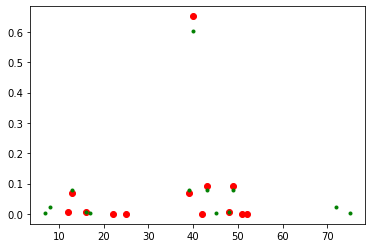

In [82]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-4):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")


In [ ]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])**2>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

In [101]:
#initial state
string_0 = "1111"

#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)


psi_0[i_0] = 1.

In [103]:
psi = ms_gate_global(2*np.pi)@psi_0
string = ""
for i in range(basis.Ns):
    if np.abs(psi[i])**2>=1e-3:
        string+=str(psi[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)
a = ms_gate_global(3*np.pi)

(-1.1729987415527113e-15+0.1464466094067268j)|2 2 2 2>
(-0.35355339059327506-4.608540849148181e-15j)|2 1 2 1>
(-0.3535533905932751-4.7056700676433e-15j)|1 2 1 2>
(1.1941022677129676e-14-0.8535533905932727j)|1 1 1 1>



In [242]:
phi = 0
sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
i = 1
j = 2
sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
print(sigma@sigma)

[[0.25+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.25+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j]]


In [177]:
a = np.array(1,2,3)
b = np.array(1,2,3)
print(np.conj(a)@b)

TypeError: array() takes from 1 to 2 positional arguments but 3 were given